# Import Supporting Libraries

In [1]:

import pandas as pd
import numpy as np

import folium
import io
import os

import pathlib

import requests
import seaborn as sns
import scipy.odr as odr
import statsmodels.api as sm

import scipy
import scipy.optimize as op
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy import stats

#from pandas.stats.api import ols
from datetime import date, timedelta
import datetime

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy.optimize import curve_fit

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib
import matplotlib as mpl
import matplotlib.cm as cm
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
rcParams['pdf.fonttype'] = 42
inline_rc = dict(plt.rcParams)

#from matplotlib.pyplot import cm 
import platform
import sys
import glob
import time
import folium
import pymannkendall as mk
#import windrose
#from windrose import WindroseAxes

import geopandas as gpd
#import geemap

from functools import reduce

from contextlib import closing
import csv

import pyproj
from pyproj import Proj

#import spotpy
#import simplekml

In [2]:
#import ee
#ee.Authenticate() 
#ee.Initialize()

In [3]:
#import wellapplication as wa

In [4]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Pandas Version " + str(pd.__version__))
print("Numpy Version " + str(np.__version__))
print("Matplotlib Version " + str(mpl.__version__))
#print("Well Application Version " + str(wa.__version__))
print("Scipy Version " +str(scipy.__version__))
print (os.environ['CONDA_DEFAULT_ENV'])

Operating System Windows 10
Python Version 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:29:11) [MSC v.1935 64 bit (AMD64)]
Pandas Version 2.1.2
Numpy Version 1.26.0
Matplotlib Version 3.8.0
Scipy Version 1.11.3
pygis311v3


In [5]:
sys.path.append("G:/My Drive/Python/")

import dbconnect

# Set main directories

In [6]:
gis_path = pathlib.Path("G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/GIS")
main_path = gis_path / "Cottonwood"
figure_dir = main_path / "figures"
raw_dir = main_path / "Cottonwood_Zonal" / "Cottonwood_Fields"
save_place = main_path / "output"
#G:\Shared drives\UGS_Groundwater\Projects\Pahvant_Valley\Pahvant_Basins\GEE_out
#save_place = "GEE_Summary_Out"
#ctnpath = gis_path / "Cottonwood"
dlypath = main_path / "openet_daily_data"
timepath = main_path / "openet_data"

# Define Custom Functions

In [7]:
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    """Displays an interactive map
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    """
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
        if ee.image.Image in [type(x) for x in v.values()]:
            folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k).add_to(mapViz)
        else:
            folium.GeoJson(data = v,name = k).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

In [8]:
def bland_altmann(m1, m2, sd_limit=1.96):
    """
    Bland-Altman Plot.

    A Bland-Altman plot is a graphical method to analyze the differences
    between two methods of measurement. The mean of the measures is plotted
    against their difference.

    Parameters
    ----------
    m1, m2: pandas Series or array-like

   Returns
    -------
    ax: matplotlib Axis object
    """

    import numpy as np
    import matplotlib.pyplot as plt

    if len(m1) != len(m2):
        raise ValueError('m1 does not have the same length as m2.')
    if sd_limit < 0:
        raise ValueError('sd_limit ({}) is less than 0.'.format(sd_limit))

    means = np.mean([m1, m2], axis=0)
    diffs = m1 - m2
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs, axis=0)

    return means, diffs

In [9]:
def scatterColor(x0,y,w):
    """Creates scatter plot with points colored by variable.
    All input arrays must have matching lengths

    Arg:
        x0 (array): 
            array of x values
        y (array): 
            array of y values
        w (array): 
            array of scalar values

    Returns:
        slope and intercept of best fit line
    
    """
    import matplotlib as mpl
    import matplotlib.cm as cm
    cmap = plt.cm.get_cmap('RdYlBu')
    norm = mpl.colors.Normalize(vmin=w.min(), vmax=w.max())
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    m.set_array(w)
    sc = plt.scatter(x0, y, label='', color = m.to_rgba(w))

    xa = sm.add_constant(x0)

    est = sm.RLM(y, xa).fit()
    r2 = sm.WLS(y, xa, weights=est.weights).fit().rsquared
    slope = est.params[1]

    x_prime = np.linspace(np.min(x0),np.max(x0),100)[:, np.newaxis]
    x_prime = sm.add_constant(x_prime)
    y_hat = est.predict(x_prime)

    const = est.params[0]
    y2 = [i*slope + const for i in x0]

    plt.xlabel('Barometric Pressure (ft water)')
    plt.ylabel('Transducer Pressure (ft water)')
    lin = linregress(x0,y)
    x1 = np.arange(np.min(x0), np.max(x0),0.1)
    y1 = [i*lin[0]+lin[1] for i in x1]
    y2 = [i*slope+const for i in x1]
    plt.plot(x1,y1,c='g',label='simple linear regression m = {:.2f} b = {:.0f}, r^2 = {:.2f}'.format(lin[0],lin[1],lin[2]**2))
    plt.plot(x1,y2,c='r',label='rlm regression m = {:.2f} b = {:.0f}, r2 = {:.2f}'.format(slope,const,r2))
    plt.legend()
    cbar = plt.colorbar(m)

    cbar.set_label('Julian Date')

    return slope,const,r2

def getlutrend(wrluy, crop, irr=None, adj=True):
    """
    wrluy = yearly et by landuse with year as index
    crop = type of landuse; ex 'Corn'
    irr = irr method; ex 'Sprinkler'
    """
    if irr:
        crp = wrluy[wrluy['IRR_Method']==irr].dropna(subset=['et_acft_adj'])
    else:
        crp = wrluy.dropna(subset=['et_acft_adj'])
    if adj:
        crpyr = crp.groupby(['Description',crp.index]).sum().loc[crop,'et_acft_adj'].sort_index()
        #alfyr.plot()
    else:
        crpyr = crp.groupby(['Description',crp.index]).sum().loc[crop,'et_acft'].sort_index()
        #alfyr.plot(color='red')
    return crpyr

def plotlu(crpyr, crop, ylab='ET (acft)', axis=None):
    if axis:
        pass
    else:
        fig, axis = plt.subplots(1,1,figsize=(12,9))
    axis.plot(crpyr.index, crpyr, label=crop)
    plotmk(crpyr, axis)
    axis.set_ylabel(ylab)
    axis.set_title(crop)
    axis.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    
def plotmk(crpyr,axis, units='ac-ft/yr', color=None):
    """This function plots the Mann Kendall trend
    crpyr = crop year
    axis = matplotlib plotting axis
    """
    seas = mk.yue_wang_modification_test(crpyr)
    mklist = [seas.trend, seas.h, seas.p, seas.z, seas.Tau, seas.s, seas.slope, seas.intercept]
    if mklist[1]:
        frst = crpyr.first_valid_index()
        lst = crpyr.last_valid_index()
        x = range(frst,lst)
        lab = f"MK {mklist[-2]:.2f} {units}"
        if color:
            clr = color
        else:            
            if mklist[0] == 'increasing':
                clr = 'red'
            else:
                clr = 'green'
        axis.plot(x,[(i-1985)*mklist[-2]+mklist[-1] for i in x],label=lab,color=clr)

In [10]:
def matchdiv(df, hucbasin):
    """matches dataset to hydro div information and adds hydrodiv information
    df = dataset
    hucbasin = huc geodataframe
    """
    df['huc_ind'] = df['system:index'].apply(lambda x: x.split("_")[0][-5:],1)
    df = df.set_index('huc_ind')
    match_dict = hucbasin.reset_index().set_index('huc_ind')['huc_12'].to_dict()
    df['huc12'] = df.index.map(match_dict)
    df['hucname'] = df['huc12'].map(hucbasin['hu_12_name'].to_dict())
    return df

In [11]:
def grphuc(x):
    """function to be applied to groupby technique on hucs and SEEBOP data"""
    d = {}
    d['ValleySide'] = x['ValleySide'][0]
    d['Topography'] = x['Topography'][0]
    d['wateryear'] = x['wateryear'][0]
    d['AreaAcres'] = x['AreaAcres'].max()
    d['et_acft'] = x['et_acft'].mean()
    d['MEAN'] = x['MEAN'].sum()
    return pd.Series(d,index=['AreaAcres','Topography','ValleySide','et_acft','MEAN','wateryear'])

def grpdaymet(x):
    """function to be applied to groupby technique on hucs and DAYMET data"""
    d = {}
    d['ppt_daymet'] = x['PR_acft'].sum()
    # SWE gives snapshot of snowpack for current day
    d['swe_daymet'] = x['SWE_acft'].median()
    return pd.Series(d,index=['ppt_daymet','swe_daymet'])

In [12]:
def plotcomparion(df, dataset_1, dataset_2, datatype, slope_adj=1., offset_adj = 0, plot=True):
    df1 = df[[f'{dataset_1}_{datatype}',f'{dataset_2}_{datatype}']].interpolate(method='time').dropna()
    
    y = df1[f'{dataset_2}_{datatype}']
    x = df1[f'{dataset_1}_{datatype}']*slope_adj - offset_adj
    res = sm.OLS(y,x).fit()

    y1 = df1[f'{dataset_2}_{datatype}']
    x1 = df1[f'{dataset_1}_{datatype}']*res.params[0]
    res1 = sm.OLS(y1,x1).fit()
    means1, diffs1 = bland_altmann(x1,y1)
    
    
    means, diffs = bland_altmann(x,y)
    
    if plot:
        paramsig, ax = plt.subplots(2,1, figsize=(12,10))

        ax[0].scatter(x,y)
        ax[0].plot(x, res.fittedvalues, 'r--', label="OLS")
        ax[0].plot(np.linspace(x.min(),x.max(),1000),
                   np.linspace(x.min(),x.max(),1000), color='black', label='1-to-1 Line')
        ax[0].legend(loc='best')
        ax[0].grid()

        if datatype == 'ppt':
            labelpart = 'Precipitation'
        elif datatype == 'aet':
            labelpart = 'Evapotranspiration'

            
        ax[0].set_xlabel(f'{dataset_1.upper()} {labelpart} (acre-ft/mo)')
        ax[0].set_ylabel(f'{dataset_2.upper()} {labelpart} (acre-ft/mo)')

        j = sm.graphics.mean_diff_plot(x, y, ax = ax[1])
    
    if res.params[0]>1:
        relsize = 'bigger'
    else:
        relsize = 'smaller'
    print(f'{dataset_2} is {res.params[0]:0.3f} times {relsize} than {dataset_1} (r2 = {res.rsquared:0.2f})')
    print(f'Mean diff is {np.mean(diffs):0.2f} and offset is {np.mean(diffs1):0.2f}')
    print(f'Model MSE = {res.mse_resid}')
    
    return np.mean(diffs), np.mean(diffs1), res.params[0]

# Import Shapefiles

Put in the GIS file you used to do the water budget summary in Google Earth Engine.  It must have the same index so you can match the GIS data to the results.

In [13]:
#hydrodivs = gpd.read_file(gis_path / 'Valley_Hydrogeologic_Divisions.shp')
#hydrodivs_wgs = hydrodivs.to_crs('epsg:4269')

ecdb = gis_path / "cottonwood_meters.gdb"
pou = gpd.read_file(ecdb, driver='FileGDB', layer='Placeofuse') 

# Reproject to a projection that preserves area
pou = pou.to_crs("EPSG:6350")
pou_wgs = pou.to_crs("epsg:4269")

# Create dictionaries that match field ID to meter number and area
meternumbers = pou[['ID','Meternumber']].set_index('ID').to_dict()['Meternumber']
pou['acres'] = pou.geometry.area * 0.000247105
acrenums = pou[['ID','acres']].set_index('ID').to_dict()['acres']

# dissolve by meter
pou_diss = pou.dissolve(by='Meternumber').drop(['Shape_Length', 'Shape_Area','Acreage','ID'],axis=1)


Draw a map of your fields to help you visualize the area when you are doing analyses.

In [14]:
centr = pou_diss.dissolve().centroid.to_crs('epsg:4269')
# This creates the map frame and adds the basemap
m = folium.Map(location=[centr.y, centr.x],tiles='Stamen Terrain', 
                    zoom_start=11)

for _, r in pou_wgs.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.0001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['Meternumber']).add_to(geo_j)
    geo_j.add_to(m)
m

C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\folium\utilities.py:69: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(coord)
C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\folium\utilities.py:77: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if math.isnan(float(coord)):
C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\folium\utilities.py:79: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(x) for x in coords]


# Data From the OpenET API

* [Documentation](https://open-et.github.io/docs/build/html/index.html)
* [Swagger Docs](https://openet.dri.edu/docs) 
* [API Key Found Here](https://auth.etdata.org/)

In [15]:
def call_api(endpoint, api_key, args=None, get=True):
    """Using user specified inputs, returns data from OpenET Raster API.

    Args:
        endpoint (str): Raster API endpoint

        api_key (str): Required api access key

        args (dictionary): User specified arguments for api call
        
        get (bool): use True if a get request and False if a post request

    Returns:
        result (object): An object of Raster API results
    """

    if args:
        args = args
    else:
        args = {}
    
    # api server address
    server = 'https://openet.dri.edu/'

    # initialize request url
    url = server + endpoint

    # create header
    header = {"Authorization": api_key}

    if get:
        # make api get request
        resp = requests.get(url=url, headers=header, params=args, verify=False)

    else: 
        # make api post request
        resp = requests.post(url=url, headers=header, data=json.dumps(args), verify=False)

    # view results
    #print(resp.url)
    #print(resp.content)
    return resp


def pull_point_et(api_key, variable = 'et',yearst = 2016, yearend = 2022, latitude = 39.22, longitude = -111.0698):
    #import time
    args = {'start_date' : f'{yearst}-01-01',                                 # inclusive starting date
            'end_date'   : f'{yearend}-12-31',                                 # inclusive completion date
            # spatial options
            'lon' : longitude,      # longitude,latitude region
            'lat' : latitude,
            'interval' : 'daily',
            'output_file_format':'json',
            # OpenET options
            'variable'      : variable,                                    # variable to retrieve (ndvi, etof, eto, et, pr)
            'model'         : 'ensemble',                                # model selection (ensemble, geesebal, ssebop, eemetric, sims, disalexi, ptjpl)
            'ref_et_source' : 'gridmet',                                 # reference et collection (cimis, gridmet)
            'provisional' : True,
            # data processing options
            'pixel_aggregation' : 'sum',                                # spatial aggregation method
            'units'             : 'english'}

    # query result
    resp = call_api('raster/timeseries/point?', api_key=api_key, args=args, get=True)
    print(resp.text)
    #time.sleep(5)
    etdf = pd.DataFrame(resp.json())
    etdf['time'] = pd.to_datetime(etdf['time'])
    etdf = etdf.set_index('time')
    return etdf

def pull_daymet_point(yearst = 2016, yearend = 2022, latitude = 39.22, longitude = -111.0698):
    from requests import Session, Request
    urlbase = "https://daymet.ornl.gov/single-pixel/api/data?"
    args = {"lat":latitude,
            "lon":longitude,
            "vars":"dayl,prcp,srad,swe,tmax,tmin,vp",
            "start": f"{yearst}-01-01",
            "end": f"{yearend}-12-31"}
    s = Session()
    p = Request('GET', urlbase, params=args).prepare()
    df = pd.read_csv(p.url,skiprows=7)
    df['datetime'] = pd.to_datetime(df['year'] * 1000 + df['yday'], format='%Y%j')
    df = df.set_index('datetime')
    return df 

## Pull data at UCC Station Location and Compare

In [16]:
climatedir = main_path / "weather_station_data"

cldata = {}

for file in climatedir.glob("*.csv"):
    if "UCC" in file.name:
        d = pd.read_csv(file,skiprows=1,nrows=9,names=['variable','description'],index_col='variable')
        #print(file.name)

        statname = d.loc['Station Name','description']
        cldata[statname] = pd.read_csv(file,skiprows=15,parse_dates=True,na_values=['M','S','T'],index_col='Day')
    else:
        pass
        #sdat = pd.read_csv(file,parse_dates=True,na_values=['Out of range'])
        #sdat['datetime'] = pd.to_datetime(sdat.reset_index().set_index('level_0').index, utc=True).tz_convert('MST').tz_localize(None)
        #sdat = sdat.set_index('datetime')
cl_sum = pd.concat(cldata)

<Axes: xlabel='Day'>

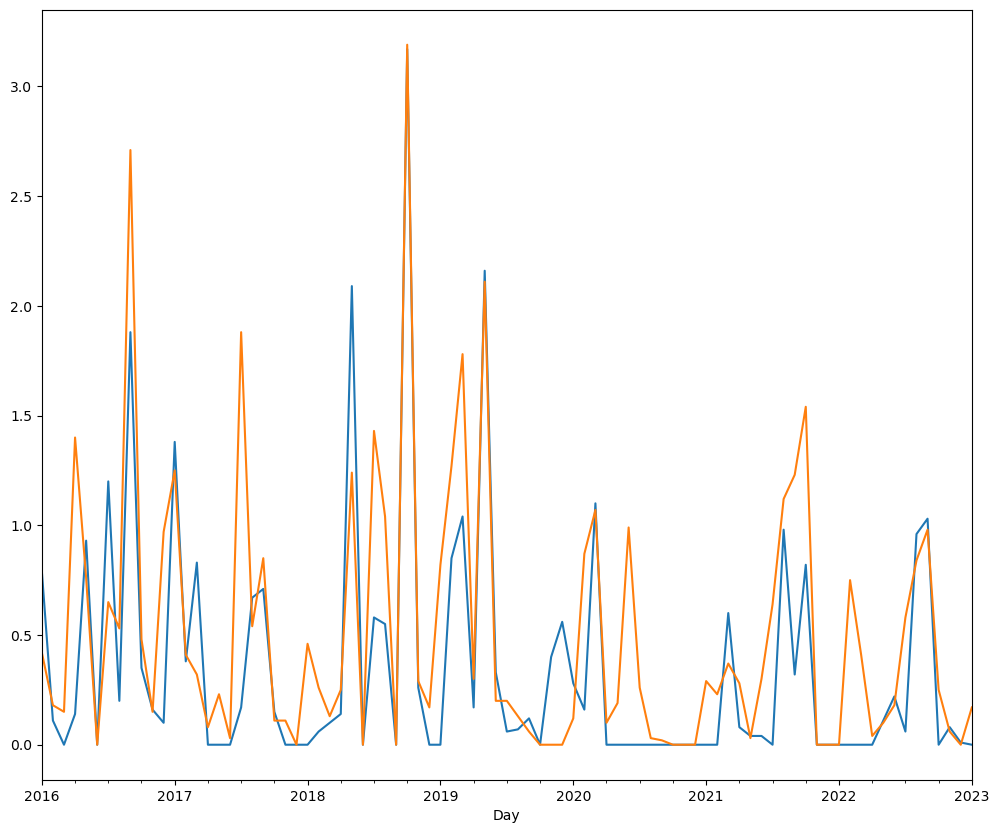

In [17]:
fig, ax = plt.subplots(1,1)

cl_sum.loc['FERRON','Precipitation'].groupby(pd.Grouper(level=0,freq='1MS')).sum().plot(ax=ax)
cl_sum.loc['CASTLE DALE','Precipitation'].groupby(pd.Grouper(level=0,freq='1MS')).sum().plot(ax=ax)

In [18]:
resp.text

NameError: name 'resp' is not defined

In [24]:
api_key = dbconnect.openetapi()
variable = 'pr'
yearst = 2017 
yearend = 2018 
latitude = 39.22 
longitude = -111.0698
    #import time
args = {'start_date' : f'{yearst}-01-01',                                 # inclusive starting date
        'end_date'   : f'{yearend}-12-31',                                 # inclusive completion date
        # spatial options
        'lon' : longitude,      # longitude,latitude region
        'lat' : latitude,
        'interval' : 'daily',
        'output_file_format':'json',
        # OpenET options
        'variable'      : variable,                                    # variable to retrieve (ndvi, etof, eto, et, pr)
        'model'         : 'ensemble',                                # model selection (ensemble, geesebal, ssebop, eemetric, sims, disalexi, ptjpl)
        'ref_et_source' : 'gridmet',                                 # reference et collection (cimis, gridmet)
        'provisional' : True,
        # data processing options
        'pixel_aggregation' : 'sum',                                # spatial aggregation method
        'units'             : 'english'}

# query result
resp = call_api('raster/timeseries/point?', api_key=api_key, args=args, get=True)
print(resp.text)
#time.sleep(5)
etdf = pd.DataFrame(resp.json())
etdf['time'] = pd.to_datetime(etdf['time'])
etdf = etdf.set_index('time')


C:\Users\pauli\anaconda3\envs\pygis311\Lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet.dri.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Internal Server Error


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [19]:
gridmetppt = pull_point_et(dbconnect.openetapi(),variable ='pr')
gridmetppt = gridmetppt.rename(columns = {'pr':'gridmet_pr'})
gridmeteto = pull_point_et(dbconnect.openetapi(),variable ='eto')
gridmeteto = gridmeteto.rename(columns = {'eto':'gridmet_eto'})
gridmetet = pull_point_et(dbconnect.openetapi(),variable ='et')



daymetppt = pull_daymet_point()

daymetppt['prcp (in/day)'] = 0.0393701 * daymetppt['prcp (mm/day)']

C:\Users\pauli\anaconda3\envs\pygis311\Lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet.dri.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Internal Server Error


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
ucc_key = dbconnect.get_ucc_api()
url = f"https://climate.usu.edu/API/api.php/v2/key={ucc_key}/station_search/source=UCC/radius=1.0/lat=39.22/long=-111.0698"
resp = requests.get(url)
station_info = resp.json()['payload'][0]
print(station_info)

stndta = {}

for yrs in range(2016,2024,2):
    data_url = f"https://climate.usu.edu/API/api.php/v3/key={ucc_key}/station_search/network=UAGRIMET/station_id={station_info['station_id']}/get_daily/start_date={yrs}-1-1/end_date={yrs+2}-12-31/units=e"
    dresp = requests.get(data_url)
    station_data = dresp.json()
    df = pd.DataFrame(station_data['payload'])
    df['date_time'] = pd.to_datetime(df['date_time'])
    stndta[yrs] = df.set_index('date_time')

station_data = pd.concat(stndta)

for col in station_data.columns:
    station_data[col] = pd.to_numeric(station_data[col],errors='coerce')

station_data = station_data.droplevel(0)
station_data = station_data.resample('1D').first().drop_duplicates()
station_data_mo = station_data[['eto','etr','precip']].groupby(pd.Grouper(level=0,freq='1MS')).sum()

### Monthly Comparisons

In [ ]:
ferron.columns

In [ ]:
ferron = cl_sum.loc['FERRON'].rename(columns={'Precipitation':'ferron_ppt',
                                              'Ref Evapotranspiration':'ferron_et',
                                              'Snow Fall':'ferron_snowfall'
                                             })#.groupby(pd.Grouper(level=0,freq='1MS')).sum()#.plot(ax=ax)
castledale = cl_sum.loc['CASTLE DALE'].rename(columns={'Precipitation':'casd_ppt',
                                              'Ref Evapotranspiration':'casd_et',
                                              'Snow Fall':'casd_snowfall'
                                             })

In [ ]:
ppt = pd.concat([gridmetppt,daymetppt,station_data,gridmeteto,ferron,castledale], axis=1)
ppt_mo = ppt.groupby(pd.Grouper(level=0, freq='1MS')).sum()

In [ ]:
eto_comp = ppt_mo[['eto','gridmet_eto']]
eto_comp = eto_comp[(eto_comp['eto']<20)&(eto_comp['gridmet_eto']>0)]


#import seaborn as sns

g = sns.jointplot(x="eto", y="gridmet_eto", data=eto_comp,
                  kind="reg", truncate=False,
                  xlim=(0, 10), ylim=(0, 10),
                  color="m", height=7)

#plt.scatter(eto_comp['eto'], eto_comp['gridmet_eto'])
plt.plot(range(0,10),range(0,10),color='grey',linestyle=":",label='1:1 line')
plt.grid()
plt.xlabel('Station ETO (in/mo)')
plt.ylabel('GridMET ETO (in/mo)')

plt.savefig(figure_dir / "eto_comparison_station.png")
plt.savefig(figure_dir / "eto_comparison_station.pdf")

In [ ]:

x = eto_comp['eto'].values 
y = eto_comp['gridmet_eto'].values

X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

In [ ]:
x = eto_comp['eto'].values 
y = eto_comp['gridmet_eto'].values

j = sm.graphics.mean_diff_plot(x, y)

In [ ]:
print(np.quantile(results.resid,0.025))
print(np.quantile(results.resid,0.975))

In [ ]:
df = ppt_mo[(ppt_mo.index.month.isin([2,3,4,5,6,7,8,9,10,11]))&(ppt_mo['precip']>0)&(ppt_mo['ferron_ppt']>0)]

fig, ax = plt.subplots(2,2,sharey=True, figsize=[10,10])

ax[0,0].scatter(df['precip'], df['gridmet_pr'])
ax[0,0].plot(range(0,5),range(0,5),color='grey',linestyle=":",label='1:1 line')
ax[0,0].set_ylabel("GridMET Precip. (in/mo)")
ax[0,0].set_xlabel("AgMET Station Precip. (in/mo)")
ax[0,0].set_xticks(np.arange(0,4.5,0.5))

ax[0,1].scatter(df['prcp (in/day)'], df['gridmet_pr'], label='Precip.')
ax[0,1].plot(range(0,5),range(0,5),color='grey',linestyle=":",label='1:1 line')
ax[0,1].set_ylabel("GridMET Precip. (in/mo)")
ax[0,1].set_xlabel("Daymet Precip. (in/mo)")
ax[0,1].set_xticks(np.arange(0,4.5,0.5))

ax[1,0].scatter(df['casd_ppt'], df['gridmet_pr'], label='Precip.')
ax[1,0].plot(range(0,5),range(0,5),color='grey',linestyle=":",label='1:1 line')
ax[1,0].set_ylabel("GridMET Precip. (in/mo)")
ax[1,0].set_xlabel("Castle Dale Station Precip. (in/mo)")
ax[1,0].set_xticks(np.arange(0,4.5,0.5))

ax[1,1].scatter(df['ferron_ppt'], df['gridmet_pr'], label='Precip.')
ax[1,1].plot(range(0,5),range(0,5),color='grey',linestyle=":",label='1:1 line')
ax[1,1].set_ylabel("GridMET Precip. (in/mo)")
ax[1,1].set_xlabel("Ferron Station Precip. (in/mo)")
ax[1,1].set_xticks(np.arange(0,4.5,0.5))

ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()
ax[0,0].set_title('Precipitation Comparison')

plt.savefig(figure_dir / "ppt_comparison_station.pdf")
plt.savefig(figure_dir / "ppt_comparison_station.png")

https://wswup.github.io/gridwxcomp/_modules/gridwxcomp/calc_bias_ratios.html#calc_bias_ratios

In [ ]:
df = ppt_mo[(ppt_mo.index.month.isin([2,3,4,5,6,7,8,9,10,11]))&(ppt_mo['precip']>0)&(ppt_mo['ferron_ppt']>0)]

x = df['precip'].values 
y = df['gridmet_pr'].values

j = sm.graphics.mean_diff_plot(x, y)

plt.scatter(x,y)

X = sm.add_constant(x)
model = sm.OLS(y, X)
pptresults = model.fit()
print(pptresults.summary())

fig, ax = plt.subplots(2,1,sharex=True)

sns.kdeplot(data = pptresults.resid,ax=ax[0],label='Ensemble')


sns.boxplot(data = pptresults.resid, 
            orient='h',notch=True,    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
 )
ax[0].legend()
plt.xlabel("AgMET vs. GridMET Precip. (in)")
ax[0].grid()
ax[1].grid()


In [ ]:
df = ppt_mo[(ppt_mo.index.month.isin([3,4,5,6,7,8,9,10]))&(ppt_mo['precip']>0)&(ppt_mo['ferron_ppt']>0)&(ppt_mo['casd_ppt']>0)]

fig, ax = plt.subplots(2,2,sharey=True, figsize=[10,10])

ax[0,0].scatter(df['precip'], df['prcp (in/day)'])
ax[0,0].plot(range(0,5),range(0,5),color='grey',linestyle=":",label='1:1 line')
ax[0,0].set_ylabel("Daymet Precip. (in/mo)")
ax[0,0].set_xlabel("AgMET Station Precip. (in/mo)")
ax[0,0].set_xticks(np.arange(0,4.5,0.5))

ax[0,1].scatter(df['prcp (in/day)'], df['gridmet_pr'], label='Precip.')
ax[0,1].plot(range(0,5),range(0,5),color='grey',linestyle=":",label='1:1 line')
ax[0,1].set_ylabel("GridMET Precip. (in/mo)")
ax[0,1].set_xlabel("Daymet Precip. (in/mo)")
ax[0,1].set_xticks(np.arange(0,4.5,0.5))

ax[1,0].scatter(df['casd_ppt'], df['prcp (in/day)'], label='Precip.')
ax[1,0].plot(range(0,5),range(0,5),color='grey',linestyle=":",label='1:1 line')
ax[1,0].set_ylabel("Daymet Precip. (in/mo)")
ax[1,0].set_xlabel("Castle Dale Station Precip. (in/mo)")
ax[1,0].set_xticks(np.arange(0,4.5,0.5))

ax[1,1].scatter(df['ferron_ppt'], df['prcp (in/day)'], label='Precip.')
ax[1,1].plot(range(0,5),range(0,5),color='grey',linestyle=":",label='1:1 line')
ax[1,1].set_ylabel("Daymet Precip. (in/mo)")
ax[1,1].set_xlabel("Ferron Station Precip. (in/mo)")
ax[1,1].set_xticks(np.arange(0,4.5,0.5))

ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()
ax[0,0].set_title('Precipitation Comparison')

plt.savefig(figure_dir / "ppt_comparison_station_dm.pdf")
plt.savefig(figure_dir / "ppt_comparison_station_dm.png")

In [ ]:
df = ppt_mo[(ppt_mo.index.month.isin([3,4,5,6,7,8,9,10]))&(ppt_mo['precip']>0)&(ppt_mo['ferron_ppt']>0)&(ppt_mo['casd_ppt']>0)]

ppt_yr = df.groupby(pd.Grouper(level=0,freq='1YS')).sum()
#import seaborn as sns

g = sns.jointplot(x="casd_ppt", y="ferron_ppt", data=ppt_yr,
                  kind="reg", truncate=False,
                  xlim=(0, 10), ylim=(0, 10),
                  color="m", height=7)

#plt.scatter(eto_comp['eto'], eto_comp['gridmet_eto'])
plt.plot(range(0,6),range(0,6),color='grey',linestyle=":",label='1:1 line')
plt.grid()
plt.xlabel('Castle Dale PPT (in/mo)')
plt.ylabel('Ferron PPT (in/mo)')

#plt.savefig(figure_dir / "eto_comparison_station.png")
#plt.savefig(figure_dir / "eto_comparison_station.pdf")

In [ ]:


x = ppt_yr['casd_ppt'].values 
y = ppt_yr['ferron_ppt'].values

X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

In [ ]:
x = ppt_yr['casd_ppt'].values 
y = ppt_yr['gridmet_pr'].values

X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

In [ ]:
x = ppt_yr['prcp (in/day)'].values 
y = ppt_yr['gridmet_pr'].values

X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

In [ ]:


x = ppt_yr['precip'].values 
y = ppt_yr['gridmet_pr'].values

X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

In [ ]:
df = ppt_yr
fig, ax = plt.subplots(2,2,sharey=True, figsize=[10,10])

ax[0,0].scatter(df['precip'], df['gridmet_pr'])
ax[0,0].plot(range(0,7),range(0,7),color='grey',linestyle=":",label='1:1 line')
ax[0,0].set_ylabel("GridMET Precip. (in/yr)")
ax[0,0].set_xlabel("AgMET Station Precip. (in/yr)")
ax[0,0].set_xticks(np.arange(0,8,1))

ax[0,1].scatter(df['prcp (in/day)'], df['gridmet_pr'], label='Precip.')
ax[0,1].plot(range(0,7),range(0,7),color='grey',linestyle=":",label='1:1 line')
ax[0,1].set_ylabel("GridMET Precip. (in/yr)")
ax[0,1].set_xlabel("Daymet Precip. (in/yr)")
ax[0,1].set_xticks(np.arange(0,8,1))

ax[1,0].scatter(df['casd_ppt'], df['gridmet_pr'], label='Precip.')
ax[1,0].plot(range(0,7),range(0,7),color='grey',linestyle=":",label='1:1 line')
ax[1,0].set_ylabel("GridMET Precip. (in/yr)")
ax[1,0].set_xlabel("Castle Dale Station Precip. (in/yr)")
ax[1,0].set_xticks(np.arange(0,8,1))

ax[1,1].scatter(df['ferron_ppt'], df['gridmet_pr'], label='Precip.')
ax[1,1].plot(range(0,7),range(0,7),color='grey',linestyle=":",label='1:1 line')
ax[1,1].set_ylabel("GridMET Precip. (in/yr)")
ax[1,1].set_xlabel("Ferron Station Precip. (in/yr)")
ax[1,1].set_xticks(np.arange(0,8,1))

ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()
ax[0,0].set_title('Precipitation Comparison')


### Yearly Comparisons

In [ ]:
ppt_yr = ppt.groupby(pd.Grouper(level=0, freq='1YS')).sum()

fig, ax = plt.subplots(1,2,sharey=True, figsize=[10,4.5])

ax[0].scatter(ppt_yr['precip'], ppt_yr['gridmet_pr'])
ax[0].plot(range(0,14),range(0,14),color='grey',linestyle=":",label='1:1 line')
ax[0].set_ylabel("GridMET Precip. (in/yr)")
ax[0].set_xlabel("Measured Precip. (in/yr)")
#ax[0].set_xticks(np.arange(0,4.5,0.5))
ax[0].grid()

ax[1].scatter(ppt_yr['prcp (in/day)'], ppt_yr['gridmet_pr'], label='Precip.')
ax[1].plot(range(0,14),range(0,14),color='grey',linestyle=":",label='1:1 line')
ax[1].set_ylabel("GridMET Precip. (in/yr)")
ax[1].set_xlabel("Daymet Precip. (in/yr)")
#ax[1].set_xticks(np.arange(0,4.5,0.5))

ax[1].grid()
ax[0].set_title('Precipitation Comparison')

In [ ]:


x = ppt_yr['casd_ppt'].values 
y = ppt_yr['gridmet_pr'].values

X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

In [ ]:
x = ppt_yr['precip'].values 
y = ppt_yr['gridmet_pr'].values

X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

In [ ]:
x = ppt_yr['prcp (in/day)'].values 
y = ppt_yr['gridmet_pr'].values

X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

## Timeseries Multipolygon Query from OpenET

The query results imported here are from using the Swagger Doc Interface.  The arguments used for the data are similar to the cell below.

https://openet-api.org/#/Manage%20Account%20Information/_account_status_get

In [16]:
args = {
  "model": "ensemble",
  "variable": "et",
  "start_date": "2020-03-01",
  "end_date": "2020-10-31",
  "ref_et_source": "gridmet",
  "units": "metric",
  "shapefile_asset_id": "projects/ee-paulinkenbrandt/assets/cottonwood_pou",
  "interval": "daily", 
  "include_columns":"ID",
  "filename_suffix":"cottonwood_dly_et",
  "output_file_format": "csv"
}
#resp = call_api("/raster/timeseries/multipolygon", api_key, args=args)

In [17]:
def summarizeoet(key, dfs, add_area=False):
    """Summarizes and transposes data from the OpenET API"""
    colnm = key.split("_")[-2:]
    colnm[0] = colnm[0][:3]
    col_name = "_".join(colnm)
    
    df = dfs[key]
    df['time'] = pd.to_datetime(df['time'])
    dfgm = df[df['time'].dt.month.isin([3,4,5,6,7,8,9,10])]
    dfgm['year'] = dfgm['time'].dt.year
    #dfgm['month'] = dfgm['time'].dt.month
    dfyr = dfgm.groupby(['ID','year']).sum(numeric_only=True)#.unstack(1)
    dfyr = dfyr.drop(['area_hectares'],axis=1)#.droplevel(0,axis=1)
    
    dfmo = df.groupby(['ID','time']).sum(numeric_only=True)#.unstack(1)
    dfmo = dfmo.drop(['area_hectares'],axis=1)#.droplevel(0,axis=1)
    
    #return dfyr
    return dfmo, dfyr

In [18]:
dfs = {}

for file in timepath.glob("*"):
    dfs[file.name.split(".")[0]] = pd.read_csv(file,parse_dates=True)
    
flat = {}
flatmo = {}
for key in dfs.keys():
    colnm = key.split("_")[-2:]
    colnm[0] = colnm[0][:3]
    col_name = "_".join(colnm)
    
    flat[col_name] = summarizeoet(key,dfs)[1]
    flatmo[col_name] = summarizeoet(key,dfs)[0]
hectars = summarizeoet(key,dfs)

C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\890703773.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfgm['year'] = dfgm['time'].dt.year
C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\890703773.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfgm['year'] = dfgm['time'].dt.year
C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\890703773.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

### Monthly

In [19]:
import logging
import json


class OpenET_Download(object):
    """Pulls daily time series data for each field polygon; One method for ET models and one for other weather data
    Leverages OpenET API to pull data;

    """
    #TODO This class currently doesn't work great; I think its due to the way the args are set up; Currently using Swagger instead
    def __init__(self, api_key, gpd_df, save_loc, stations= None, interval = 'monthly', start_yr=2016, end_yr=2023):
        """

        :param api_key: OpenET api key
        :param gpd_df: geodataframe with field polygons
        :param save_loc: output directory
        :param stations: list of index values to pull from the geographic file
        :param interval: frequency of data; monthly or daily
        :param start_yr: start year for data request; default is 2016
        :param endy_yr: end year for data request; default is 2023
        """
        # create header
        self.header = {"Authorization": api_key}

        self.geographic_data = gpd_df.to_crs('epsg:4326')

        self.variables = ['ETo','ET','PR','NDVI']
        self.models = ['Ensemble', 'geeSEBAL', 'SSEBop', 'DisALEXI', 'PTJPL', 'eeMETRIC']

        if stations is None:
            self.stations = ['LM20','LM22','LM27','BC1','BC10','BC11','BC12','BC20','BC22','BC29','MD49','CW1','CW25','BC45','UM24','UM3','UM56','MD43']
        else:
            self.stations = stations
        
        i = 0
        for station in self.stations:
            if station not in self.geographic_data.index.values:
                print(f"Station {station} not in geographic file.")
                i += 1

        # if more than 2 station values missing, default to geographic file index
        if i > 2:
            self.stations = self.geographic_data.index

        # api server address
        self.server = 'https://openet-api.org/'
        self.endpoint = 'raster/timeseries/polygon'

        self.start_yr = start_yr
        self.end_yr = end_yr

        if isinstance(save_loc, pathlib.PurePath):
            self.save_loc = save_loc
        else:
            self.save_loc = pathlib.Path(save_loc)

        self.kwargs = {"model": "ensemble",
                            "variable": "ET",
                            "date_range": ["2022-01-01", "2022-12-31"],
                            "reference_et": "gridMET",
                            "provisional": True,
                            "units": "in",
                            "geometry":[-111.00747, 41.2442, -111.00747, 41.24742, -111.00295, 41.24742, -111.00295, 41.24422],
                            "interval": interval,
                            "reducer": "mean",
                            "file_format": "JSON",
                            "cog":True}
    

    def scrape_alt(self):
        """Retrieves NDVI, Reference ET, and Precipitation from OpenET API for field polygons

        :return:
        """

        # initialize request url
        url = self.server + self.endpoint

        g = self.geographic_data

        self.kwargs["model"] = "ensemble"
        
        for station in self.stations:
            geolist = list(np.concatenate(np.dstack(g.loc[station].geometry.boundary.coords.xy)[0]))
            self.kwargs['geometry'] = geolist
            
            for varib in self.variables:
                self.kwargs['variable'] = varib
                dfs = {}
                for year in range(self.start_yr, self.end_yr+1):
                    try:
                        
                        self.kwargs['date_range'] = [f"{year}-01-01", f"{year}-12-31"]
                        
                        resp = requests.post(url=url, headers=self.header,
                                             data=json.dumps(self.kwargs), verify=False)
                        print(resp.json())
                        dfs[year] = pd.DataFrame(resp.json())
                        print(f"{station}, {year} success")
                        time.sleep(2)
                    except BaseException:
                        print(station, year)
                        logging.exception("An exception was thrown!")

                # check to make sure something was retrieved
                if len(dfs.keys()) > 0:
                    df = pd.concat(dfs, ignore_index=True)
                    if 'time' in df.columns:
                        df['time'] = pd.to_datetime(df['time'])
                        df = df.set_index('time')
                    df.to_csv(self.save_loc / f'combined_{interval}_openet_{varib}_{station}.csv')

    def scrape_et_polygons(self):
        """Retrieves eeMETRIC and ensemble ET from OpenET API for polygons

        :param stations: defaults to None; list of stations to pull data from; station must be in geographic data
        :return:
        """

        g = self.geographic_data

        # initialize request url
        url = self.server + self.endpoint

        self.kwargs['variable'] = "ET"
        
        for station in self.stations:
            # make coordinate list from polygon geometry
            geolist = list(np.concatenate(np.dstack(g.loc[station].geometry.boundary.coords.xy)[0]))
            self.kwargs['geometry'] = geolist
            
            for mod in self.models:
                dfs = {}
                self.kwargs["model"] = mod
                for year in range(self.start_yr, self.end_yr+1):
                    try:
                        print(station, year)
                        # set up request data
                        self.kwargs['date_range'] = [f"{year}-01-01", f"{year}-12-31"]
                        
                        resp = requests.post(url=url, headers=self.header, data=json.dumps(self.kwargs), verify=False)
                        dfs[year] = pd.DataFrame(resp.json())

                        # polite download
                        time.sleep(10)
                    except BaseException:
                        print(station, year)
                        logging.exception("An exception was thrown!")

                # check to make sure something was retrieved
                if len(dfs.keys()) > 0:
                    df = pd.concat(dfs, ignore_index=True)
                    if 'time' in df.columns:
                        df['time'] = pd.to_datetime(df['time'])
                        df = df.set_index('time')
                    outpath = self.save_loc / f'combined_{interval}_openet_et{mod[:3]}_{station}.csv'
                    df.to_csv(outpath)
                    print(outpath)


    def scrape_all(self):
        self.scrape_alt()
        self.scrape_et_polygons()
    
    def call_api(self, endpoint, api_key, args=None, get=True):
        """Using user specified inputs, returns data from OpenET Raster API.

        Args:
            endpoint (str): Raster API endpoint

            api_key (str): Required api access key

            args (dictionary): User specified arguments for api call

            get (bool): use True if a get request and False if a post request

        Returns:
            result (object): An object of Raster API results
        """

        if args:
            args = args
        else:
            args = {}

        # initialize request url
        url = self.server + self.endpoint

        if get:
            # make api get request
            resp = requests.get(url=url, headers=self.header, params=args, verify=False)

        else:
            # make api post request
            resp = requests.post(url=url, headers=self.header, data=json.dumps(args), verify=False)

        # view results
        # print(resp.url)
        # print(resp.content)
        return resp

In [20]:


gispath = pathlib.Path("G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/GIS")
ecdb = gispath / "cottonwood_meters.gdb"
pou = gpd.read_file(ecdb, driver='FileGDB', layer='Placeofuse') 

# Reproject to a projection that preserves area
pou = pou.to_crs("EPSG:6350")

# Create dictionaries that match field ID to meter number and area
meternumbers = pou[['ID','Meternumber']].set_index('ID').to_dict()['Meternumber']
pou['acres'] = pou.geometry.area * 0.000247105
acrenums = pou[['ID','acres']].set_index('ID').to_dict()['acres']

# dissolve by meter
pou_diss = pou.dissolve(by='Meternumber').drop(['Shape_Length', 'Shape_Area','Acreage','ID'],axis=1)

api_key = dbconnect.openetapi()

pathlib.Path("./test/").mkdir(parents=True, exist_ok=True)

testpath = pathlib.Path("./test/")

oet = OpenET_Download(api_key=api_key, gpd_df=pou_diss, save_loc=testpath, start_yr=2018, end_yr=2023)

#oet.scrape_all()

In [21]:
oet.scrape_all()

C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'eto': 1.252}, {'time': '2018-02-01', 'eto': 2.065}, {'time': '2018-03-01', 'eto': 3.598}, {'time': '2018-04-01', 'eto': 5.667}, {'time': '2018-05-01', 'eto': 6.711}, {'time': '2018-06-01', 'eto': 8.898}, {'time': '2018-07-01', 'eto': 7.813}, {'time': '2018-08-01', 'eto': 6.971}, {'time': '2018-09-01', 'eto': 5.738}, {'time': '2018-10-01', 'eto': 2.332}, {'time': '2018-11-01', 'eto': 1.535}, {'time': '2018-12-01', 'eto': 0.872}]
LM20, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'eto': 0.902}, {'time': '2019-02-01', 'eto': 1.216}, {'time': '2019-03-01', 'eto': 2.821}, {'time': '2019-04-01', 'eto': 4.943}, {'time': '2019-05-01', 'eto': 4.888}, {'time': '2019-06-01', 'eto': 7.325}, {'time': '2019-07-01', 'eto': 7.824}, {'time': '2019-08-01', 'eto': 7.03}, {'time': '2019-09-01', 'eto': 5.27}, {'time': '2019-10-01', 'eto': 3.183}, {'time': '2019-11-01', 'eto': 1.647}, {'time': '2019-12-01', 'eto': 0.899}]
LM20, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'eto': 0.779}, {'time': '2020-02-01', 'eto': 1.833}, {'time': '2020-03-01', 'eto': 3.108}, {'time': '2020-04-01', 'eto': 4.779}, {'time': '2020-05-01', 'eto': 7.027}, {'time': '2020-06-01', 'eto': 7.818}, {'time': '2020-07-01', 'eto': 8.201}, {'time': '2020-08-01', 'eto': 7.641}, {'time': '2020-09-01', 'eto': 5.151}, {'time': '2020-10-01', 'eto': 3.632}, {'time': '2020-11-01', 'eto': 1.702}, {'time': '2020-12-01', 'eto': 0.835}]
LM20, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'eto': 0.842}, {'time': '2021-02-01', 'eto': 1.799}, {'time': '2021-03-01', 'eto': 3.308}, {'time': '2021-04-01', 'eto': 5.103}, {'time': '2021-05-01', 'eto': 6.752}, {'time': '2021-06-01', 'eto': 8.345}, {'time': '2021-07-01', 'eto': 7.253}, {'time': '2021-08-01', 'eto': 6.706}, {'time': '2021-09-01', 'eto': 4.438}, {'time': '2021-10-01', 'eto': 2.412}, {'time': '2021-11-01', 'eto': 1.702}, {'time': '2021-12-01', 'eto': 0.925}]
LM20, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'eto': 1.082}, {'time': '2022-02-01', 'eto': 1.691}, {'time': '2022-03-01', 'eto': 3.364}, {'time': '2022-04-01', 'eto': 5.191}, {'time': '2022-05-01', 'eto': 6.51}, {'time': '2022-06-01', 'eto': 7.947}, {'time': '2022-07-01', 'eto': 7.313}, {'time': '2022-08-01', 'eto': 6.057}, {'time': '2022-09-01', 'eto': 4.808}, {'time': '2022-10-01', 'eto': 2.721}, {'time': '2022-11-01', 'eto': 1.492}, {'time': '2022-12-01', 'eto': 0.932}]
LM20, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'eto': 0.796}, {'time': '2023-02-01', 'eto': 1.302}, {'time': '2023-03-01', 'eto': 2.478}, {'time': '2023-04-01', 'eto': 4.927}, {'time': '2023-05-01', 'eto': 6.261}, {'time': '2023-06-01', 'eto': 7.23}, {'time': '2023-07-01', 'eto': 8.219}, {'time': '2023-08-01', 'eto': 6.286}, {'time': '2023-09-01', 'eto': 4.626}, {'time': '2023-10-01', 'eto': 2.771}]
LM20, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'et': 0.689}, {'time': '2018-02-01', 'et': 0.859}, {'time': '2018-03-01', 'et': 1.391}, {'time': '2018-04-01', 'et': 1.8}, {'time': '2018-05-01', 'et': 3.287}, {'time': '2018-06-01', 'et': 4.386}, {'time': '2018-07-01', 'et': 5.052}, {'time': '2018-08-01', 'et': 4.781}, {'time': '2018-09-01', 'et': 3.3}, {'time': '2018-10-01', 'et': 1.425}, {'time': '2018-11-01', 'et': 0.743}, {'time': '2018-12-01', 'et': 0.527}]
LM20, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'et': 0.48}, {'time': '2019-02-01', 'et': 0.664}, {'time': '2019-03-01', 'et': 1.588}, {'time': '2019-04-01', 'et': 2.338}, {'time': '2019-05-01', 'et': 2.896}, {'time': '2019-06-01', 'et': 4.362}, {'time': '2019-07-01', 'et': 5.109}, {'time': '2019-08-01', 'et': 4.453}, {'time': '2019-09-01', 'et': 3.411}, {'time': '2019-10-01', 'et': 1.634}, {'time': '2019-11-01', 'et': 0.82}, {'time': '2019-12-01', 'et': 0.473}]
LM20, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'et': 0.37}, {'time': '2020-02-01', 'et': 0.969}, {'time': '2020-03-01', 'et': 1.075}, {'time': '2020-04-01', 'et': 2.245}, {'time': '2020-05-01', 'et': 3.847}, {'time': '2020-06-01', 'et': 4.514}, {'time': '2020-07-01', 'et': 4.91}, {'time': '2020-08-01', 'et': 4.874}, {'time': '2020-09-01', 'et': 3.028}, {'time': '2020-10-01', 'et': 1.898}, {'time': '2020-11-01', 'et': 0.785}, {'time': '2020-12-01', 'et': 0.4}]
LM20, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'et': 0.309}, {'time': '2021-02-01', 'et': 0.583}, {'time': '2021-03-01', 'et': 0.922}, {'time': '2021-04-01', 'et': 1.24}, {'time': '2021-05-01', 'et': 2.319}, {'time': '2021-06-01', 'et': 3.68}, {'time': '2021-07-01', 'et': 4.281}, {'time': '2021-08-01', 'et': 4.29}, {'time': '2021-09-01', 'et': 3.106}, {'time': '2021-10-01', 'et': 1.789}, {'time': '2021-11-01', 'et': 0.865}, {'time': '2021-12-01', 'et': 0.54}]
LM20, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'et': 0.515}, {'time': '2022-02-01', 'et': 0.619}, {'time': '2022-03-01', 'et': 1.187}, {'time': '2022-04-01', 'et': 2.208}, {'time': '2022-05-01', 'et': 3.007}, {'time': '2022-06-01', 'et': 4.109}, {'time': '2022-07-01', 'et': 4.691}, {'time': '2022-08-01', 'et': 3.624}, {'time': '2022-09-01', 'et': 3.373}, {'time': '2022-10-01', 'et': 1.84}, {'time': '2022-11-01', 'et': 0.549}, {'time': '2022-12-01', 'et': 0.275}]
LM20, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'et': 0.115}, {'time': '2023-02-01', 'et': 0.614}, {'time': '2023-03-01', 'et': 0.732}, {'time': '2023-04-01', 'et': 1.417}, {'time': '2023-05-01', 'et': 3.147}, {'time': '2023-06-01', 'et': 3.85}, {'time': '2023-07-01', 'et': 5.658}, {'time': '2023-08-01', 'et': 4.928}, {'time': '2023-09-01', 'et': 3.364}, {'time': '2023-10-01', 'et': 1.931}]
LM20, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'pr': 0.406}, {'time': '2018-02-01', 'pr': 0.205}, {'time': '2018-03-01', 'pr': 0.106}, {'time': '2018-04-01', 'pr': 0.28}, {'time': '2018-05-01', 'pr': 0.969}, {'time': '2018-06-01', 'pr': 0.0}, {'time': '2018-07-01', 'pr': 0.512}, {'time': '2018-08-01', 'pr': 0.728}, {'time': '2018-09-01', 'pr': 0.028}, {'time': '2018-10-01', 'pr': 2.445}, {'time': '2018-11-01', 'pr': 0.65}, {'time': '2018-12-01', 'pr': 0.787}]
LM20, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'pr': 1.118}, {'time': '2019-02-01', 'pr': 1.823}, {'time': '2019-03-01', 'pr': 1.311}, {'time': '2019-04-01', 'pr': 0.421}, {'time': '2019-05-01', 'pr': 1.681}, {'time': '2019-06-01', 'pr': 2.256}, {'time': '2019-07-01', 'pr': 0.161}, {'time': '2019-08-01', 'pr': 0.189}, {'time': '2019-09-01', 'pr': 0.075}, {'time': '2019-10-01', 'pr': 0.063}, {'time': '2019-11-01', 'pr': 1.803}, {'time': '2019-12-01', 'pr': 0.74}]
LM20, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'pr': 0.091}, {'time': '2020-02-01', 'pr': 0.791}, {'time': '2020-03-01', 'pr': 1.02}, {'time': '2020-04-01', 'pr': 0.213}, {'time': '2020-05-01', 'pr': 0.071}, {'time': '2020-06-01', 'pr': 0.083}, {'time': '2020-07-01', 'pr': 0.189}, {'time': '2020-08-01', 'pr': 0.035}, {'time': '2020-09-01', 'pr': 0.024}, {'time': '2020-10-01', 'pr': 0.0}, {'time': '2020-11-01', 'pr': 0.327}, {'time': '2020-12-01', 'pr': 0.504}]
LM20, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'pr': 0.291}, {'time': '2021-02-01', 'pr': 0.256}, {'time': '2021-03-01', 'pr': 0.433}, {'time': '2021-04-01', 'pr': 0.28}, {'time': '2021-05-01', 'pr': 0.02}, {'time': '2021-06-01', 'pr': 0.339}, {'time': '2021-07-01', 'pr': 0.89}, {'time': '2021-08-01', 'pr': 1.925}, {'time': '2021-09-01', 'pr': 0.705}, {'time': '2021-10-01', 'pr': 1.528}, {'time': '2021-11-01', 'pr': 0.118}, {'time': '2021-12-01', 'pr': 0.937}]
LM20, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'pr': 0.0}, {'time': '2022-02-01', 'pr': 0.622}, {'time': '2022-03-01', 'pr': 0.39}, {'time': '2022-04-01', 'pr': 0.055}, {'time': '2022-05-01', 'pr': 0.028}, {'time': '2022-06-01', 'pr': 0.287}, {'time': '2022-07-01', 'pr': 0.374}, {'time': '2022-08-01', 'pr': 1.043}, {'time': '2022-09-01', 'pr': 1.52}, {'time': '2022-10-01', 'pr': 0.075}, {'time': '2022-11-01', 'pr': 0.043}, {'time': '2022-12-01', 'pr': 0.72}]
LM20, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'pr': 2.559}, {'time': '2023-02-01', 'pr': 0.295}, {'time': '2023-03-01', 'pr': 1.492}, {'time': '2023-04-01', 'pr': 0.047}, {'time': '2023-05-01', 'pr': 0.602}, {'time': '2023-06-01', 'pr': 0.681}, {'time': '2023-07-01', 'pr': 0.587}, {'time': '2023-08-01', 'pr': 1.504}, {'time': '2023-09-01', 'pr': 0.654}, {'time': '2023-10-01', 'pr': 0.126}]
LM20, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'ndvi': 0.202}, {'time': '2018-02-01', 'ndvi': 0.179}, {'time': '2018-03-01', 'ndvi': 0.175}, {'time': '2018-04-01', 'ndvi': 0.215}, {'time': '2018-05-01', 'ndvi': 0.307}, {'time': '2018-06-01', 'ndvi': 0.398}, {'time': '2018-07-01', 'ndvi': 0.511}, {'time': '2018-08-01', 'ndvi': 0.511}, {'time': '2018-09-01', 'ndvi': 0.522}, {'time': '2018-10-01', 'ndvi': 0.373}, {'time': '2018-11-01', 'ndvi': 0.243}, {'time': '2018-12-01', 'ndvi': 0.208}]
LM20, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'ndvi': 0.164}, {'time': '2019-02-01', 'ndvi': 0.167}, {'time': '2019-03-01', 'ndvi': 0.178}, {'time': '2019-04-01', 'ndvi': 0.227}, {'time': '2019-05-01', 'ndvi': 0.353}, {'time': '2019-06-01', 'ndvi': 0.456}, {'time': '2019-07-01', 'ndvi': 0.573}, {'time': '2019-08-01', 'ndvi': 0.595}, {'time': '2019-09-01', 'ndvi': 0.573}, {'time': '2019-10-01', 'ndvi': 0.43}, {'time': '2019-11-01', 'ndvi': 0.24}, {'time': '2019-12-01', 'ndvi': 0.196}]
LM20, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'ndvi': 0.188}, {'time': '2020-02-01', 'ndvi': 0.197}, {'time': '2020-03-01', 'ndvi': 0.227}, {'time': '2020-04-01', 'ndvi': 0.265}, {'time': '2020-05-01', 'ndvi': 0.371}, {'time': '2020-06-01', 'ndvi': 0.466}, {'time': '2020-07-01', 'ndvi': 0.55}, {'time': '2020-08-01', 'ndvi': 0.592}, {'time': '2020-09-01', 'ndvi': 0.532}, {'time': '2020-10-01', 'ndvi': 0.433}, {'time': '2020-11-01', 'ndvi': 0.299}, {'time': '2020-12-01', 'ndvi': 0.231}]
LM20, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'ndvi': 0.167}, {'time': '2021-02-01', 'ndvi': 0.172}, {'time': '2021-03-01', 'ndvi': 0.198}, {'time': '2021-04-01', 'ndvi': 0.195}, {'time': '2021-05-01', 'ndvi': 0.263}, {'time': '2021-06-01', 'ndvi': 0.358}, {'time': '2021-07-01', 'ndvi': 0.52}, {'time': '2021-08-01', 'ndvi': 0.605}, {'time': '2021-09-01', 'ndvi': 0.61}, {'time': '2021-10-01', 'ndvi': 0.405}, {'time': '2021-11-01', 'ndvi': 0.329}, {'time': '2021-12-01', 'ndvi': 0.267}]
LM20, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'ndvi': 0.228}, {'time': '2022-02-01', 'ndvi': 0.208}, {'time': '2022-03-01', 'ndvi': 0.209}, {'time': '2022-04-01', 'ndvi': 0.255}, {'time': '2022-05-01', 'ndvi': 0.311}, {'time': '2022-06-01', 'ndvi': 0.424}, {'time': '2022-07-01', 'ndvi': 0.517}, {'time': '2022-08-01', 'ndvi': 0.619}, {'time': '2022-09-01', 'ndvi': 0.598}, {'time': '2022-10-01', 'ndvi': 0.483}, {'time': '2022-11-01', 'ndvi': 0.335}, {'time': '2022-12-01', 'ndvi': 0.301}]
LM20, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'ndvi': 0.402}, {'time': '2023-02-01', 'ndvi': 0.295}, {'time': '2023-03-01', 'ndvi': 0.205}, {'time': '2023-04-01', 'ndvi': 0.218}, {'time': '2023-05-01', 'ndvi': 0.342}, {'time': '2023-06-01', 'ndvi': 0.52}, {'time': '2023-07-01', 'ndvi': 0.619}, {'time': '2023-08-01', 'ndvi': 0.68}, {'time': '2023-09-01', 'ndvi': 0.642}, {'time': '2023-10-01', 'ndvi': 0.501}]
LM20, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'eto': 1.218}, {'time': '2018-02-01', 'eto': 1.911}, {'time': '2018-03-01', 'eto': 3.405}, {'time': '2018-04-01', 'eto': 5.422}, {'time': '2018-05-01', 'eto': 6.546}, {'time': '2018-06-01', 'eto': 8.604}, {'time': '2018-07-01', 'eto': 7.601}, {'time': '2018-08-01', 'eto': 6.729}, {'time': '2018-09-01', 'eto': 5.502}, {'time': '2018-10-01', 'eto': 2.235}, {'time': '2018-11-01', 'eto': 1.464}, {'time': '2018-12-01', 'eto': 0.828}]
LM22, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'eto': 0.854}, {'time': '2019-02-01', 'eto': 1.126}, {'time': '2019-03-01', 'eto': 2.654}, {'time': '2019-04-01', 'eto': 4.814}, {'time': '2019-05-01', 'eto': 4.783}, {'time': '2019-06-01', 'eto': 7.122}, {'time': '2019-07-01', 'eto': 7.638}, {'time': '2019-08-01', 'eto': 6.887}, {'time': '2019-09-01', 'eto': 5.009}, {'time': '2019-10-01', 'eto': 3.028}, {'time': '2019-11-01', 'eto': 1.586}, {'time': '2019-12-01', 'eto': 0.871}]
LM22, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'eto': 0.745}, {'time': '2020-02-01', 'eto': 1.737}, {'time': '2020-03-01', 'eto': 2.962}, {'time': '2020-04-01', 'eto': 4.706}, {'time': '2020-05-01', 'eto': 6.914}, {'time': '2020-06-01', 'eto': 7.655}, {'time': '2020-07-01', 'eto': 7.977}, {'time': '2020-08-01', 'eto': 7.453}, {'time': '2020-09-01', 'eto': 4.975}, {'time': '2020-10-01', 'eto': 3.521}, {'time': '2020-11-01', 'eto': 1.632}, {'time': '2020-12-01', 'eto': 0.827}]
LM22, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'eto': 0.871}, {'time': '2021-02-01', 'eto': 1.776}, {'time': '2021-03-01', 'eto': 3.192}, {'time': '2021-04-01', 'eto': 4.983}, {'time': '2021-05-01', 'eto': 6.629}, {'time': '2021-06-01', 'eto': 8.158}, {'time': '2021-07-01', 'eto': 7.084}, {'time': '2021-08-01', 'eto': 6.506}, {'time': '2021-09-01', 'eto': 4.28}, {'time': '2021-10-01', 'eto': 2.307}, {'time': '2021-11-01', 'eto': 1.646}, {'time': '2021-12-01', 'eto': 0.894}]
LM22, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'eto': 1.063}, {'time': '2022-02-01', 'eto': 1.611}, {'time': '2022-03-01', 'eto': 3.218}, {'time': '2022-04-01', 'eto': 4.999}, {'time': '2022-05-01', 'eto': 6.312}, {'time': '2022-06-01', 'eto': 7.685}, {'time': '2022-07-01', 'eto': 7.132}, {'time': '2022-08-01', 'eto': 5.913}, {'time': '2022-09-01', 'eto': 4.685}, {'time': '2022-10-01', 'eto': 2.661}, {'time': '2022-11-01', 'eto': 1.496}, {'time': '2022-12-01', 'eto': 0.927}]
LM22, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 95, in scrape_alt
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.p

{'detail': 'Invalid API credentials.'}
LM22 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'et': 0.615}, {'time': '2018-02-01', 'et': 0.726}, {'time': '2018-03-01', 'et': 1.198}, {'time': '2018-04-01', 'et': 1.632}, {'time': '2018-05-01', 'et': 3.355}, {'time': '2018-06-01', 'et': 4.658}, {'time': '2018-07-01', 'et': 5.28}, {'time': '2018-08-01', 'et': 5.268}, {'time': '2018-09-01', 'et': 3.546}, {'time': '2018-10-01', 'et': 1.51}, {'time': '2018-11-01', 'et': 0.73}, {'time': '2018-12-01', 'et': 0.475}]
LM22, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'et': 0.397}, {'time': '2019-02-01', 'et': 0.605}, {'time': '2019-03-01', 'et': 1.411}, {'time': '2019-04-01', 'et': 2.424}, {'time': '2019-05-01', 'et': 2.987}, {'time': '2019-06-01', 'et': 4.671}, {'time': '2019-07-01', 'et': 4.853}, {'time': '2019-08-01', 'et': 4.546}, {'time': '2019-09-01', 'et': 3.44}, {'time': '2019-10-01', 'et': 1.588}, {'time': '2019-11-01', 'et': 0.81}, {'time': '2019-12-01', 'et': 0.456}]
LM22, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'et': 0.305}, {'time': '2020-02-01', 'et': 0.862}, {'time': '2020-03-01', 'et': 1.017}, {'time': '2020-04-01', 'et': 2.307}, {'time': '2020-05-01', 'et': 4.627}, {'time': '2020-06-01', 'et': 5.493}, {'time': '2020-07-01', 'et': 5.615}, {'time': '2020-08-01', 'et': 5.304}, {'time': '2020-09-01', 'et': 3.631}, {'time': '2020-10-01', 'et': 2.474}, {'time': '2020-11-01', 'et': 0.806}, {'time': '2020-12-01', 'et': 0.402}]
LM22, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 95, in scrape_alt
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.p

{'detail': 'Invalid API credentials.'}
LM22 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'et': 0.438}, {'time': '2022-02-01', 'et': 0.536}, {'time': '2022-03-01', 'et': 1.078}, {'time': '2022-04-01', 'et': 2.515}, {'time': '2022-05-01', 'et': 3.652}, {'time': '2022-06-01', 'et': 4.278}, {'time': '2022-07-01', 'et': 4.309}, {'time': '2022-08-01', 'et': 4.004}, {'time': '2022-09-01', 'et': 3.639}, {'time': '2022-10-01', 'et': 2.01}, {'time': '2022-11-01', 'et': 0.556}, {'time': '2022-12-01', 'et': 0.275}]
LM22, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'et': 0.346}, {'time': '2023-02-01', 'et': 0.594}, {'time': '2023-03-01', 'et': 0.72}, {'time': '2023-04-01', 'et': 1.588}, {'time': '2023-05-01', 'et': 3.987}, {'time': '2023-06-01', 'et': 4.303}, {'time': '2023-07-01', 'et': 6.176}, {'time': '2023-08-01', 'et': 4.963}, {'time': '2023-09-01', 'et': 3.493}, {'time': '2023-10-01', 'et': 2.144}]
LM22, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'pr': 0.406}, {'time': '2018-02-01', 'pr': 0.194}, {'time': '2018-03-01', 'pr': 0.092}, {'time': '2018-04-01', 'pr': 0.117}, {'time': '2018-05-01', 'pr': 1.12}, {'time': '2018-06-01', 'pr': 0.0}, {'time': '2018-07-01', 'pr': 0.635}, {'time': '2018-08-01', 'pr': 0.774}, {'time': '2018-09-01', 'pr': 0.031}, {'time': '2018-10-01', 'pr': 2.438}, {'time': '2018-11-01', 'pr': 0.66}, {'time': '2018-12-01', 'pr': 0.731}]
LM22, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'pr': 1.182}, {'time': '2019-02-01', 'pr': 1.788}, {'time': '2019-03-01', 'pr': 1.336}, {'time': '2019-04-01', 'pr': 0.467}, {'time': '2019-05-01', 'pr': 1.685}, {'time': '2019-06-01', 'pr': 4.496}, {'time': '2019-07-01', 'pr': 0.158}, {'time': '2019-08-01', 'pr': 0.21}, {'time': '2019-09-01', 'pr': 0.085}, {'time': '2019-10-01', 'pr': 0.074}, {'time': '2019-11-01', 'pr': 1.754}, {'time': '2019-12-01', 'pr': 0.744}]
LM22, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'pr': 0.129}, {'time': '2020-02-01', 'pr': 0.851}, {'time': '2020-03-01', 'pr': 1.041}, {'time': '2020-04-01', 'pr': 0.206}, {'time': '2020-05-01', 'pr': 0.029}, {'time': '2020-06-01', 'pr': 0.062}, {'time': '2020-07-01', 'pr': 0.217}, {'time': '2020-08-01', 'pr': 0.035}, {'time': '2020-09-01', 'pr': 0.002}, {'time': '2020-10-01', 'pr': 0.0}, {'time': '2020-11-01', 'pr': 0.224}, {'time': '2020-12-01', 'pr': 0.44}]
LM22, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'pr': 0.33}, {'time': '2021-02-01', 'pr': 0.259}, {'time': '2021-03-01', 'pr': 0.444}, {'time': '2021-04-01', 'pr': 0.297}, {'time': '2021-05-01', 'pr': 0.027}, {'time': '2021-06-01', 'pr': 0.391}, {'time': '2021-07-01', 'pr': 1.017}, {'time': '2021-08-01', 'pr': 2.063}, {'time': '2021-09-01', 'pr': 0.673}, {'time': '2021-10-01', 'pr': 1.57}, {'time': '2021-11-01', 'pr': 0.093}, {'time': '2021-12-01', 'pr': 0.849}]
LM22, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'pr': 0.0}, {'time': '2022-02-01', 'pr': 0.611}, {'time': '2022-03-01', 'pr': 0.411}, {'time': '2022-04-01', 'pr': 0.027}, {'time': '2022-05-01', 'pr': 0.028}, {'time': '2022-06-01', 'pr': 0.344}, {'time': '2022-07-01', 'pr': 0.363}, {'time': '2022-08-01', 'pr': 1.174}, {'time': '2022-09-01', 'pr': 1.728}, {'time': '2022-10-01', 'pr': 0.138}, {'time': '2022-11-01', 'pr': 0.047}, {'time': '2022-12-01', 'pr': 0.629}]
LM22, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'pr': 2.654}, {'time': '2023-02-01', 'pr': 0.306}, {'time': '2023-03-01', 'pr': 1.538}, {'time': '2023-04-01', 'pr': 0.005}, {'time': '2023-05-01', 'pr': 0.659}, {'time': '2023-06-01', 'pr': 0.674}, {'time': '2023-07-01', 'pr': 0.558}, {'time': '2023-08-01', 'pr': 1.627}, {'time': '2023-09-01', 'pr': 0.795}, {'time': '2023-10-01', 'pr': 0.154}]
LM22, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'ndvi': 0.218}, {'time': '2018-02-01', 'ndvi': 0.186}, {'time': '2018-03-01', 'ndvi': 0.181}, {'time': '2018-04-01', 'ndvi': 0.244}, {'time': '2018-05-01', 'ndvi': 0.348}, {'time': '2018-06-01', 'ndvi': 0.408}, {'time': '2018-07-01', 'ndvi': 0.556}, {'time': '2018-08-01', 'ndvi': 0.61}, {'time': '2018-09-01', 'ndvi': 0.626}, {'time': '2018-10-01', 'ndvi': 0.506}, {'time': '2018-11-01', 'ndvi': 0.317}, {'time': '2018-12-01', 'ndvi': 0.237}]
LM22, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'ndvi': 0.191}, {'time': '2019-02-01', 'ndvi': 0.191}, {'time': '2019-03-01', 'ndvi': 0.188}, {'time': '2019-04-01', 'ndvi': 0.263}, {'time': '2019-05-01', 'ndvi': 0.441}, {'time': '2019-06-01', 'ndvi': 0.567}, {'time': '2019-07-01', 'ndvi': 0.526}, {'time': '2019-08-01', 'ndvi': 0.59}, {'time': '2019-09-01', 'ndvi': 0.624}, {'time': '2019-10-01', 'ndvi': 0.452}, {'time': '2019-11-01', 'ndvi': 0.252}, {'time': '2019-12-01', 'ndvi': 0.203}]
LM22, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'ndvi': 0.204}, {'time': '2020-02-01', 'ndvi': 0.206}, {'time': '2020-03-01', 'ndvi': 0.254}, {'time': '2020-04-01', 'ndvi': 0.33}, {'time': '2020-05-01', 'ndvi': 0.506}, {'time': '2020-06-01', 'ndvi': 0.58}, {'time': '2020-07-01', 'ndvi': 0.607}, {'time': '2020-08-01', 'ndvi': 0.642}, {'time': '2020-09-01', 'ndvi': 0.602}, {'time': '2020-10-01', 'ndvi': 0.503}, {'time': '2020-11-01', 'ndvi': 0.368}, {'time': '2020-12-01', 'ndvi': 0.261}]
LM22, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'ndvi': 0.188}, {'time': '2021-02-01', 'ndvi': 0.169}, {'time': '2021-03-01', 'ndvi': 0.204}, {'time': '2021-04-01', 'ndvi': 0.234}, {'time': '2021-05-01', 'ndvi': 0.323}, {'time': '2021-06-01', 'ndvi': 0.431}, {'time': '2021-07-01', 'ndvi': 0.544}, {'time': '2021-08-01', 'ndvi': 0.652}, {'time': '2021-09-01', 'ndvi': 0.632}, {'time': '2021-10-01', 'ndvi': 0.36}, {'time': '2021-11-01', 'ndvi': 0.316}, {'time': '2021-12-01', 'ndvi': 0.266}]
LM22, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'ndvi': 0.233}, {'time': '2022-02-01', 'ndvi': 0.203}, {'time': '2022-03-01', 'ndvi': 0.209}, {'time': '2022-04-01', 'ndvi': 0.294}, {'time': '2022-05-01', 'ndvi': 0.401}, {'time': '2022-06-01', 'ndvi': 0.429}, {'time': '2022-07-01', 'ndvi': 0.462}, {'time': '2022-08-01', 'ndvi': 0.645}, {'time': '2022-09-01', 'ndvi': 0.674}, {'time': '2022-10-01', 'ndvi': 0.591}, {'time': '2022-11-01', 'ndvi': 0.385}, {'time': '2022-12-01', 'ndvi': 0.339}]
LM22, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'ndvi': 0.168}, {'time': '2023-02-01', 'ndvi': 0.168}, {'time': '2023-03-01', 'ndvi': 0.235}, {'time': '2023-04-01', 'ndvi': 0.251}, {'time': '2023-05-01', 'ndvi': 0.412}, {'time': '2023-06-01', 'ndvi': 0.534}, {'time': '2023-07-01', 'ndvi': 0.671}, {'time': '2023-08-01', 'ndvi': 0.711}, {'time': '2023-09-01', 'ndvi': 0.696}, {'time': '2023-10-01', 'ndvi': 0.602}]
LM22, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'eto': 1.214}, {'time': '2018-02-01', 'eto': 1.893}, {'time': '2018-03-01', 'eto': 3.383}, {'time': '2018-04-01', 'eto': 5.394}, {'time': '2018-05-01', 'eto': 6.527}, {'time': '2018-06-01', 'eto': 8.569}, {'time': '2018-07-01', 'eto': 7.577}, {'time': '2018-08-01', 'eto': 6.701}, {'time': '2018-09-01', 'eto': 5.475}, {'time': '2018-10-01', 'eto': 2.224}, {'time': '2018-11-01', 'eto': 1.456}, {'time': '2018-12-01', 'eto': 0.823}]
LM27, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'eto': 0.848}, {'time': '2019-02-01', 'eto': 1.115}, {'time': '2019-03-01', 'eto': 2.634}, {'time': '2019-04-01', 'eto': 4.8}, {'time': '2019-05-01', 'eto': 4.771}, {'time': '2019-06-01', 'eto': 7.099}, {'time': '2019-07-01', 'eto': 7.617}, {'time': '2019-08-01', 'eto': 6.87}, {'time': '2019-09-01', 'eto': 4.978}, {'time': '2019-10-01', 'eto': 3.01}, {'time': '2019-11-01', 'eto': 1.579}, {'time': '2019-12-01', 'eto': 0.868}]
LM27, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'eto': 0.741}, {'time': '2020-02-01', 'eto': 1.726}, {'time': '2020-03-01', 'eto': 2.945}, {'time': '2020-04-01', 'eto': 4.697}, {'time': '2020-05-01', 'eto': 6.9}, {'time': '2020-06-01', 'eto': 7.636}, {'time': '2020-07-01', 'eto': 7.951}, {'time': '2020-08-01', 'eto': 7.431}, {'time': '2020-09-01', 'eto': 4.954}, {'time': '2020-10-01', 'eto': 3.508}, {'time': '2020-11-01', 'eto': 1.623}, {'time': '2020-12-01', 'eto': 0.826}]
LM27, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'eto': 0.875}, {'time': '2021-02-01', 'eto': 1.773}, {'time': '2021-03-01', 'eto': 3.179}, {'time': '2021-04-01', 'eto': 4.969}, {'time': '2021-05-01', 'eto': 6.615}, {'time': '2021-06-01', 'eto': 8.136}, {'time': '2021-07-01', 'eto': 7.064}, {'time': '2021-08-01', 'eto': 6.482}, {'time': '2021-09-01', 'eto': 4.262}, {'time': '2021-10-01', 'eto': 2.295}, {'time': '2021-11-01', 'eto': 1.639}, {'time': '2021-12-01', 'eto': 0.891}]
LM27, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'eto': 1.061}, {'time': '2022-02-01', 'eto': 1.602}, {'time': '2022-03-01', 'eto': 3.201}, {'time': '2022-04-01', 'eto': 4.977}, {'time': '2022-05-01', 'eto': 6.289}, {'time': '2022-06-01', 'eto': 7.654}, {'time': '2022-07-01', 'eto': 7.111}, {'time': '2022-08-01', 'eto': 5.897}, {'time': '2022-09-01', 'eto': 4.671}, {'time': '2022-10-01', 'eto': 2.654}, {'time': '2022-11-01', 'eto': 1.497}, {'time': '2022-12-01', 'eto': 0.926}]
LM27, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'eto': 0.783}, {'time': '2023-02-01', 'eto': 1.235}, {'time': '2023-03-01', 'eto': 2.386}, {'time': '2023-04-01', 'eto': 4.839}, {'time': '2023-05-01', 'eto': 6.18}, {'time': '2023-06-01', 'eto': 7.028}, {'time': '2023-07-01', 'eto': 7.948}, {'time': '2023-08-01', 'eto': 6.08}, {'time': '2023-09-01', 'eto': 4.421}, {'time': '2023-10-01', 'eto': 2.702}]
LM27, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'et': 0.609}, {'time': '2018-02-01', 'et': 0.77}, {'time': '2018-03-01', 'et': 1.182}, {'time': '2018-04-01', 'et': 1.816}, {'time': '2018-05-01', 'et': 4.055}, {'time': '2018-06-01', 'et': 5.323}, {'time': '2018-07-01', 'et': 5.671}, {'time': '2018-08-01', 'et': 4.874}, {'time': '2018-09-01', 'et': 2.914}, {'time': '2018-10-01', 'et': 1.298}, {'time': '2018-11-01', 'et': 0.758}, {'time': '2018-12-01', 'et': 0.408}]
LM27, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'et': 0.319}, {'time': '2019-02-01', 'et': 0.644}, {'time': '2019-03-01', 'et': 1.436}, {'time': '2019-04-01', 'et': 2.561}, {'time': '2019-05-01', 'et': 2.707}, {'time': '2019-06-01', 'et': 4.534}, {'time': '2019-07-01', 'et': 5.896}, {'time': '2019-08-01', 'et': 5.052}, {'time': '2019-09-01', 'et': 4.045}, {'time': '2019-10-01', 'et': 1.629}, {'time': '2019-11-01', 'et': 0.831}, {'time': '2019-12-01', 'et': 0.45}]
LM27, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'et': 0.332}, {'time': '2020-02-01', 'et': 0.952}, {'time': '2020-03-01', 'et': 1.22}, {'time': '2020-04-01', 'et': 2.698}, {'time': '2020-05-01', 'et': 3.945}, {'time': '2020-06-01', 'et': 4.887}, {'time': '2020-07-01', 'et': 5.79}, {'time': '2020-08-01', 'et': 4.484}, {'time': '2020-09-01', 'et': 2.647}, {'time': '2020-10-01', 'et': 2.278}, {'time': '2020-11-01', 'et': 0.76}, {'time': '2020-12-01', 'et': 0.349}]
LM27, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'et': 0.265}, {'time': '2021-02-01', 'et': 0.589}, {'time': '2021-03-01', 'et': 0.973}, {'time': '2021-04-01', 'et': 1.754}, {'time': '2021-05-01', 'et': 3.226}, {'time': '2021-06-01', 'et': 5.36}, {'time': '2021-07-01', 'et': 5.135}, {'time': '2021-08-01', 'et': 3.067}, {'time': '2021-09-01', 'et': 2.768}, {'time': '2021-10-01', 'et': 1.976}, {'time': '2021-11-01', 'et': 1.039}, {'time': '2021-12-01', 'et': 0.547}]
LM27, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'et': 0.484}, {'time': '2022-02-01', 'et': 0.563}, {'time': '2022-03-01', 'et': 1.136}, {'time': '2022-04-01', 'et': 2.179}, {'time': '2022-05-01', 'et': 3.469}, {'time': '2022-06-01', 'et': 4.911}, {'time': '2022-07-01', 'et': 4.897}, {'time': '2022-08-01', 'et': 4.083}, {'time': '2022-09-01', 'et': 3.505}, {'time': '2022-10-01', 'et': 2.068}, {'time': '2022-11-01', 'et': 0.571}, {'time': '2022-12-01', 'et': 0.273}]
LM27, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'et': 0.046}, {'time': '2023-02-01', 'et': 0.524}, {'time': '2023-03-01', 'et': 0.683}, {'time': '2023-04-01', 'et': 2.031}, {'time': '2023-05-01', 'et': 5.157}, {'time': '2023-06-01', 'et': 4.023}, {'time': '2023-07-01', 'et': 6.085}, {'time': '2023-08-01', 'et': 4.698}, {'time': '2023-09-01', 'et': 2.947}, {'time': '2023-10-01', 'et': 2.179}]
LM27, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'pr': 0.406}, {'time': '2018-02-01', 'pr': 0.193}, {'time': '2018-03-01', 'pr': 0.091}, {'time': '2018-04-01', 'pr': 0.098}, {'time': '2018-05-01', 'pr': 1.138}, {'time': '2018-06-01', 'pr': 0.0}, {'time': '2018-07-01', 'pr': 0.65}, {'time': '2018-08-01', 'pr': 0.78}, {'time': '2018-09-01', 'pr': 0.031}, {'time': '2018-10-01', 'pr': 2.437}, {'time': '2018-11-01', 'pr': 0.661}, {'time': '2018-12-01', 'pr': 0.724}]
LM27, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'pr': 1.189}, {'time': '2019-02-01', 'pr': 1.783}, {'time': '2019-03-01', 'pr': 1.339}, {'time': '2019-04-01', 'pr': 0.472}, {'time': '2019-05-01', 'pr': 1.685}, {'time': '2019-06-01', 'pr': 4.756}, {'time': '2019-07-01', 'pr': 0.157}, {'time': '2019-08-01', 'pr': 0.213}, {'time': '2019-09-01', 'pr': 0.087}, {'time': '2019-10-01', 'pr': 0.075}, {'time': '2019-11-01', 'pr': 1.748}, {'time': '2019-12-01', 'pr': 0.744}]
LM27, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'pr': 0.134}, {'time': '2020-02-01', 'pr': 0.858}, {'time': '2020-03-01', 'pr': 1.043}, {'time': '2020-04-01', 'pr': 0.205}, {'time': '2020-05-01', 'pr': 0.024}, {'time': '2020-06-01', 'pr': 0.059}, {'time': '2020-07-01', 'pr': 0.22}, {'time': '2020-08-01', 'pr': 0.035}, {'time': '2020-09-01', 'pr': 0.0}, {'time': '2020-10-01', 'pr': 0.0}, {'time': '2020-11-01', 'pr': 0.213}, {'time': '2020-12-01', 'pr': 0.433}]
LM27, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'pr': 0.335}, {'time': '2021-02-01', 'pr': 0.26}, {'time': '2021-03-01', 'pr': 0.445}, {'time': '2021-04-01', 'pr': 0.299}, {'time': '2021-05-01', 'pr': 0.028}, {'time': '2021-06-01', 'pr': 0.398}, {'time': '2021-07-01', 'pr': 1.031}, {'time': '2021-08-01', 'pr': 2.079}, {'time': '2021-09-01', 'pr': 0.669}, {'time': '2021-10-01', 'pr': 1.575}, {'time': '2021-11-01', 'pr': 0.091}, {'time': '2021-12-01', 'pr': 0.839}]
LM27, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 95, in scrape_alt
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.p

{'detail': 'Invalid API credentials.'}
LM27 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'pr': 2.665}, {'time': '2023-02-01', 'pr': 0.307}, {'time': '2023-03-01', 'pr': 1.543}, {'time': '2023-04-01', 'pr': 0.0}, {'time': '2023-05-01', 'pr': 0.665}, {'time': '2023-06-01', 'pr': 0.673}, {'time': '2023-07-01', 'pr': 0.555}, {'time': '2023-08-01', 'pr': 1.642}, {'time': '2023-09-01', 'pr': 0.811}, {'time': '2023-10-01', 'pr': 0.157}]
LM27, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'ndvi': 0.19}, {'time': '2018-02-01', 'ndvi': 0.172}, {'time': '2018-03-01', 'ndvi': 0.169}, {'time': '2018-04-01', 'ndvi': 0.242}, {'time': '2018-05-01', 'ndvi': 0.358}, {'time': '2018-06-01', 'ndvi': 0.503}, {'time': '2018-07-01', 'ndvi': 0.62}, {'time': '2018-08-01', 'ndvi': 0.561}, {'time': '2018-09-01', 'ndvi': 0.499}, {'time': '2018-10-01', 'ndvi': 0.415}, {'time': '2018-11-01', 'ndvi': 0.352}, {'time': '2018-12-01', 'ndvi': 0.255}]
LM27, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'ndvi': 0.185}, {'time': '2019-02-01', 'ndvi': 0.194}, {'time': '2019-03-01', 'ndvi': 0.232}, {'time': '2019-04-01', 'ndvi': 0.4}, {'time': '2019-05-01', 'ndvi': 0.473}, {'time': '2019-06-01', 'ndvi': 0.48}, {'time': '2019-07-01', 'ndvi': 0.658}, {'time': '2019-08-01', 'ndvi': 0.621}, {'time': '2019-09-01', 'ndvi': 0.701}, {'time': '2019-10-01', 'ndvi': 0.486}, {'time': '2019-11-01', 'ndvi': 0.283}, {'time': '2019-12-01', 'ndvi': 0.233}]
LM27, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'ndvi': 0.223}, {'time': '2020-02-01', 'ndvi': 0.217}, {'time': '2020-03-01', 'ndvi': 0.308}, {'time': '2020-04-01', 'ndvi': 0.375}, {'time': '2020-05-01', 'ndvi': 0.381}, {'time': '2020-06-01', 'ndvi': 0.543}, {'time': '2020-07-01', 'ndvi': 0.642}, {'time': '2020-08-01', 'ndvi': 0.51}, {'time': '2020-09-01', 'ndvi': 0.398}, {'time': '2020-10-01', 'ndvi': 0.465}, {'time': '2020-11-01', 'ndvi': 0.362}, {'time': '2020-12-01', 'ndvi': 0.251}]
LM27, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'ndvi': 0.165}, {'time': '2021-02-01', 'ndvi': 0.149}, {'time': '2021-03-01', 'ndvi': 0.206}, {'time': '2021-04-01', 'ndvi': 0.227}, {'time': '2021-05-01', 'ndvi': 0.305}, {'time': '2021-06-01', 'ndvi': 0.564}, {'time': '2021-07-01', 'ndvi': 0.619}, {'time': '2021-08-01', 'ndvi': 0.399}, {'time': '2021-09-01', 'ndvi': 0.487}, {'time': '2021-10-01', 'ndvi': 0.529}, {'time': '2021-11-01', 'ndvi': 0.557}, {'time': '2021-12-01', 'ndvi': 0.388}]
LM27, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'ndvi': 0.258}, {'time': '2022-02-01', 'ndvi': 0.215}, {'time': '2022-03-01', 'ndvi': 0.209}, {'time': '2022-04-01', 'ndvi': 0.274}, {'time': '2022-05-01', 'ndvi': 0.371}, {'time': '2022-06-01', 'ndvi': 0.55}, {'time': '2022-07-01', 'ndvi': 0.524}, {'time': '2022-08-01', 'ndvi': 0.692}, {'time': '2022-09-01', 'ndvi': 0.63}, {'time': '2022-10-01', 'ndvi': 0.655}, {'time': '2022-11-01', 'ndvi': 0.514}, {'time': '2022-12-01', 'ndvi': 0.467}]
LM27, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'ndvi': 0.168}, {'time': '2023-02-01', 'ndvi': 0.168}, {'time': '2023-03-01', 'ndvi': 0.224}, {'time': '2023-04-01', 'ndvi': 0.308}, {'time': '2023-05-01', 'ndvi': 0.584}, {'time': '2023-06-01', 'ndvi': 0.615}, {'time': '2023-07-01', 'ndvi': 0.643}, {'time': '2023-08-01', 'ndvi': 0.629}, {'time': '2023-09-01', 'ndvi': 0.588}, {'time': '2023-10-01', 'ndvi': 0.608}]
LM27, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'eto': 1.228}, {'time': '2018-02-01', 'eto': 1.959}, {'time': '2018-03-01', 'eto': 3.432}, {'time': '2018-04-01', 'eto': 5.606}, {'time': '2018-05-01', 'eto': 6.599}, {'time': '2018-06-01', 'eto': 8.784}, {'time': '2018-07-01', 'eto': 7.749}, {'time': '2018-08-01', 'eto': 6.939}, {'time': '2018-09-01', 'eto': 5.78}, {'time': '2018-10-01', 'eto': 2.386}, {'time': '2018-11-01', 'eto': 1.498}, {'time': '2018-12-01', 'eto': 0.892}]
BC1, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'eto': 0.9}, {'time': '2019-02-01', 'eto': 1.2}, {'time': '2019-03-01', 'eto': 2.731}, {'time': '2019-04-01', 'eto': 4.917}, {'time': '2019-05-01', 'eto': 4.923}, {'time': '2019-06-01', 'eto': 7.265}, {'time': '2019-07-01', 'eto': 7.802}, {'time': '2019-08-01', 'eto': 7.014}, {'time': '2019-09-01', 'eto': 5.259}, {'time': '2019-10-01', 'eto': 3.207}, {'time': '2019-11-01', 'eto': 1.563}, {'time': '2019-12-01', 'eto': 0.908}]
BC1, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'eto': 0.779}, {'time': '2020-02-01', 'eto': 1.787}, {'time': '2020-03-01', 'eto': 2.978}, {'time': '2020-04-01', 'eto': 4.764}, {'time': '2020-05-01', 'eto': 7.027}, {'time': '2020-06-01', 'eto': 7.77}, {'time': '2020-07-01', 'eto': 8.113}, {'time': '2020-08-01', 'eto': 7.611}, {'time': '2020-09-01', 'eto': 5.154}, {'time': '2020-10-01', 'eto': 3.657}, {'time': '2020-11-01', 'eto': 1.667}, {'time': '2020-12-01', 'eto': 0.852}]
BC1, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'eto': 0.899}, {'time': '2021-02-01', 'eto': 1.79}, {'time': '2021-03-01', 'eto': 3.186}, {'time': '2021-04-01', 'eto': 5.065}, {'time': '2021-05-01', 'eto': 6.698}, {'time': '2021-06-01', 'eto': 8.24}, {'time': '2021-07-01', 'eto': 7.208}, {'time': '2021-08-01', 'eto': 6.705}, {'time': '2021-09-01', 'eto': 4.488}, {'time': '2021-10-01', 'eto': 2.504}, {'time': '2021-11-01', 'eto': 1.68}, {'time': '2021-12-01', 'eto': 0.96}]
BC1, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'eto': 1.118}, {'time': '2022-02-01', 'eto': 1.664}, {'time': '2022-03-01', 'eto': 3.299}, {'time': '2022-04-01', 'eto': 5.141}, {'time': '2022-05-01', 'eto': 6.475}, {'time': '2022-06-01', 'eto': 7.969}, {'time': '2022-07-01', 'eto': 7.355}, {'time': '2022-08-01', 'eto': 6.052}, {'time': '2022-09-01', 'eto': 4.775}, {'time': '2022-10-01', 'eto': 2.746}, {'time': '2022-11-01', 'eto': 1.523}, {'time': '2022-12-01', 'eto': 0.959}]
BC1, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'eto': 0.857}, {'time': '2023-02-01', 'eto': 1.332}, {'time': '2023-03-01', 'eto': 2.465}, {'time': '2023-04-01', 'eto': 4.893}, {'time': '2023-05-01', 'eto': 6.266}, {'time': '2023-06-01', 'eto': 7.195}, {'time': '2023-07-01', 'eto': 8.212}, {'time': '2023-08-01', 'eto': 6.304}, {'time': '2023-09-01', 'eto': 4.706}, {'time': '2023-10-01', 'eto': 2.807}]
BC1, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'et': 0.663}, {'time': '2018-02-01', 'et': 0.697}, {'time': '2018-03-01', 'et': 1.234}, {'time': '2018-04-01', 'et': 2.331}, {'time': '2018-05-01', 'et': 3.781}, {'time': '2018-06-01', 'et': 5.595}, {'time': '2018-07-01', 'et': 6.106}, {'time': '2018-08-01', 'et': 5.835}, {'time': '2018-09-01', 'et': 3.996}, {'time': '2018-10-01', 'et': 1.931}, {'time': '2018-11-01', 'et': 0.802}, {'time': '2018-12-01', 'et': 0.405}]
BC1, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'et': 0.381}, {'time': '2019-02-01', 'et': 0.492}, {'time': '2019-03-01', 'et': 1.848}, {'time': '2019-04-01', 'et': 3.148}, {'time': '2019-05-01', 'et': 2.829}, {'time': '2019-06-01', 'et': 4.448}, {'time': '2019-07-01', 'et': 5.978}, {'time': '2019-08-01', 'et': 5.817}, {'time': '2019-09-01', 'et': 4.228}, {'time': '2019-10-01', 'et': 2.03}, {'time': '2019-11-01', 'et': 0.619}, {'time': '2019-12-01', 'et': 0.395}]
BC1, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'et': 0.372}, {'time': '2020-02-01', 'et': 0.984}, {'time': '2020-03-01', 'et': 1.044}, {'time': '2020-04-01', 'et': 3.087}, {'time': '2020-05-01', 'et': 4.44}, {'time': '2020-06-01', 'et': 5.379}, {'time': '2020-07-01', 'et': 5.687}, {'time': '2020-08-01', 'et': 5.919}, {'time': '2020-09-01', 'et': 3.852}, {'time': '2020-10-01', 'et': 2.276}, {'time': '2020-11-01', 'et': 0.715}, {'time': '2020-12-01', 'et': 0.395}]
BC1, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'et': 0.262}, {'time': '2021-02-01', 'et': 0.514}, {'time': '2021-03-01', 'et': 1.136}, {'time': '2021-04-01', 'et': 2.282}, {'time': '2021-05-01', 'et': 4.423}, {'time': '2021-06-01', 'et': 5.487}, {'time': '2021-07-01', 'et': 5.663}, {'time': '2021-08-01', 'et': 4.812}, {'time': '2021-09-01', 'et': 3.259}, {'time': '2021-10-01', 'et': 1.622}, {'time': '2021-11-01', 'et': 0.896}, {'time': '2021-12-01', 'et': 0.469}]
BC1, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'et': 0.451}, {'time': '2022-02-01', 'et': 0.577}, {'time': '2022-03-01', 'et': 1.258}, {'time': '2022-04-01', 'et': 2.75}, {'time': '2022-05-01', 'et': 4.162}, {'time': '2022-06-01', 'et': 5.506}, {'time': '2022-07-01', 'et': 6.089}, {'time': '2022-08-01', 'et': 4.753}, {'time': '2022-09-01', 'et': 3.983}, {'time': '2022-10-01', 'et': 1.959}, {'time': '2022-11-01', 'et': 0.538}, {'time': '2022-12-01', 'et': 0.28}]
BC1, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'et': 0.09}, {'time': '2023-02-01', 'et': 0.548}, {'time': '2023-03-01', 'et': 0.745}, {'time': '2023-04-01', 'et': 2.018}, {'time': '2023-05-01', 'et': 4.66}, {'time': '2023-06-01', 'et': 5.439}, {'time': '2023-07-01', 'et': 7.141}, {'time': '2023-08-01', 'et': 5.645}, {'time': '2023-09-01', 'et': 3.737}, {'time': '2023-10-01', 'et': 2.473}]
BC1, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'pr': 0.474}, {'time': '2018-02-01', 'pr': 0.262}, {'time': '2018-03-01', 'pr': 0.13}, {'time': '2018-04-01', 'pr': 0.308}, {'time': '2018-05-01', 'pr': 1.12}, {'time': '2018-06-01', 'pr': 0.0}, {'time': '2018-07-01', 'pr': 0.643}, {'time': '2018-08-01', 'pr': 0.72}, {'time': '2018-09-01', 'pr': 0.042}, {'time': '2018-10-01', 'pr': 2.409}, {'time': '2018-11-01', 'pr': 0.6}, {'time': '2018-12-01', 'pr': 0.703}]
BC1, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 95, in scrape_alt
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.p

{'detail': 'Invalid API credentials.'}
BC1 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'pr': 0.166}, {'time': '2020-02-01', 'pr': 0.835}, {'time': '2020-03-01', 'pr': 1.025}, {'time': '2020-04-01', 'pr': 0.245}, {'time': '2020-05-01', 'pr': 0.141}, {'time': '2020-06-01', 'pr': 0.11}, {'time': '2020-07-01', 'pr': 0.244}, {'time': '2020-08-01', 'pr': 0.022}, {'time': '2020-09-01', 'pr': 0.027}, {'time': '2020-10-01', 'pr': 0.0}, {'time': '2020-11-01', 'pr': 0.394}, {'time': '2020-12-01', 'pr': 0.51}]
BC1, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'pr': 0.348}, {'time': '2021-02-01', 'pr': 0.307}, {'time': '2021-03-01', 'pr': 0.476}, {'time': '2021-04-01', 'pr': 0.276}, {'time': '2021-05-01', 'pr': 0.004}, {'time': '2021-06-01', 'pr': 0.363}, {'time': '2021-07-01', 'pr': 0.931}, {'time': '2021-08-01', 'pr': 1.922}, {'time': '2021-09-01', 'pr': 0.696}, {'time': '2021-10-01', 'pr': 1.578}, {'time': '2021-11-01', 'pr': 0.134}, {'time': '2021-12-01', 'pr': 0.985}]
BC1, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'pr': 0.016}, {'time': '2022-02-01', 'pr': 0.656}, {'time': '2022-03-01', 'pr': 0.45}, {'time': '2022-04-01', 'pr': 0.081}, {'time': '2022-05-01', 'pr': 0.084}, {'time': '2022-06-01', 'pr': 0.362}, {'time': '2022-07-01', 'pr': 0.325}, {'time': '2022-08-01', 'pr': 1.096}, {'time': '2022-09-01', 'pr': 1.505}, {'time': '2022-10-01', 'pr': 0.119}, {'time': '2022-11-01', 'pr': 0.054}, {'time': '2022-12-01', 'pr': 0.701}]
BC1, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'pr': 2.66}, {'time': '2023-02-01', 'pr': 0.317}, {'time': '2023-03-01', 'pr': 1.487}, {'time': '2023-04-01', 'pr': 0.006}, {'time': '2023-05-01', 'pr': 0.643}, {'time': '2023-06-01', 'pr': 0.75}, {'time': '2023-07-01', 'pr': 0.61}, {'time': '2023-08-01', 'pr': 1.467}, {'time': '2023-09-01', 'pr': 0.608}, {'time': '2023-10-01', 'pr': 0.159}]
BC1, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'ndvi': 0.228}, {'time': '2018-02-01', 'ndvi': 0.208}, {'time': '2018-03-01', 'ndvi': 0.235}, {'time': '2018-04-01', 'ndvi': 0.29}, {'time': '2018-05-01', 'ndvi': 0.442}, {'time': '2018-06-01', 'ndvi': 0.566}, {'time': '2018-07-01', 'ndvi': 0.704}, {'time': '2018-08-01', 'ndvi': 0.663}, {'time': '2018-09-01', 'ndvi': 0.596}, {'time': '2018-10-01', 'ndvi': 0.574}, {'time': '2018-11-01', 'ndvi': 0.48}, {'time': '2018-12-01', 'ndvi': 0.346}]
BC1, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'ndvi': 0.239}, {'time': '2019-02-01', 'ndvi': 0.234}, {'time': '2019-03-01', 'ndvi': 0.259}, {'time': '2019-04-01', 'ndvi': 0.46}, {'time': '2019-05-01', 'ndvi': 0.57}, {'time': '2019-06-01', 'ndvi': 0.57}, {'time': '2019-07-01', 'ndvi': 0.687}, {'time': '2019-08-01', 'ndvi': 0.76}, {'time': '2019-09-01', 'ndvi': 0.758}, {'time': '2019-10-01', 'ndvi': 0.594}, {'time': '2019-11-01', 'ndvi': 0.323}, {'time': '2019-12-01', 'ndvi': 0.26}]
BC1, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'ndvi': 0.226}, {'time': '2020-02-01', 'ndvi': 0.236}, {'time': '2020-03-01', 'ndvi': 0.302}, {'time': '2020-04-01', 'ndvi': 0.489}, {'time': '2020-05-01', 'ndvi': 0.558}, {'time': '2020-06-01', 'ndvi': 0.514}, {'time': '2020-07-01', 'ndvi': 0.697}, {'time': '2020-08-01', 'ndvi': 0.746}, {'time': '2020-09-01', 'ndvi': 0.715}, {'time': '2020-10-01', 'ndvi': 0.563}, {'time': '2020-11-01', 'ndvi': 0.407}, {'time': '2020-12-01', 'ndvi': 0.326}]
BC1, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'ndvi': 0.204}, {'time': '2021-02-01', 'ndvi': 0.196}, {'time': '2021-03-01', 'ndvi': 0.276}, {'time': '2021-04-01', 'ndvi': 0.353}, {'time': '2021-05-01', 'ndvi': 0.474}, {'time': '2021-06-01', 'ndvi': 0.553}, {'time': '2021-07-01', 'ndvi': 0.679}, {'time': '2021-08-01', 'ndvi': 0.757}, {'time': '2021-09-01', 'ndvi': 0.747}, {'time': '2021-10-01', 'ndvi': 0.597}, {'time': '2021-11-01', 'ndvi': 0.467}, {'time': '2021-12-01', 'ndvi': 0.382}]
BC1, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'ndvi': 0.31}, {'time': '2022-02-01', 'ndvi': 0.264}, {'time': '2022-03-01', 'ndvi': 0.276}, {'time': '2022-04-01', 'ndvi': 0.4}, {'time': '2022-05-01', 'ndvi': 0.503}, {'time': '2022-06-01', 'ndvi': 0.571}, {'time': '2022-07-01', 'ndvi': 0.687}, {'time': '2022-08-01', 'ndvi': 0.795}, {'time': '2022-09-01', 'ndvi': 0.762}, {'time': '2022-10-01', 'ndvi': 0.645}, {'time': '2022-11-01', 'ndvi': 0.438}, {'time': '2022-12-01', 'ndvi': 0.392}]
BC1, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'ndvi': 0.31}, {'time': '2023-02-01', 'ndvi': 0.31}, {'time': '2023-03-01', 'ndvi': 0.31}, {'time': '2023-04-01', 'ndvi': 0.337}, {'time': '2023-05-01', 'ndvi': 0.535}, {'time': '2023-06-01', 'ndvi': 0.647}, {'time': '2023-07-01', 'ndvi': 0.73}, {'time': '2023-08-01', 'ndvi': 0.802}, {'time': '2023-09-01', 'ndvi': 0.777}, {'time': '2023-10-01', 'ndvi': 0.679}]
BC1, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'eto': 1.263}, {'time': '2018-02-01', 'eto': 2.111}, {'time': '2018-03-01', 'eto': 3.654}, {'time': '2018-04-01', 'eto': 5.867}, {'time': '2018-05-01', 'eto': 6.848}, {'time': '2018-06-01', 'eto': 9.152}, {'time': '2018-07-01', 'eto': 7.998}, {'time': '2018-08-01', 'eto': 7.222}, {'time': '2018-09-01', 'eto': 6.057}, {'time': '2018-10-01', 'eto': 2.481}, {'time': '2018-11-01', 'eto': 1.552}, {'time': '2018-12-01', 'eto': 0.927}]
BC10, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'eto': 0.938}, {'time': '2019-02-01', 'eto': 1.242}, {'time': '2019-03-01', 'eto': 2.953}, {'time': '2019-04-01', 'eto': 5.075}, {'time': '2019-05-01', 'eto': 5.048}, {'time': '2019-06-01', 'eto': 7.521}, {'time': '2019-07-01', 'eto': 8.029}, {'time': '2019-08-01', 'eto': 7.264}, {'time': '2019-09-01', 'eto': 5.575}, {'time': '2019-10-01', 'eto': 3.426}, {'time': '2019-11-01', 'eto': 1.646}, {'time': '2019-12-01', 'eto': 0.927}]
BC10, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'eto': 0.787}, {'time': '2020-02-01', 'eto': 1.886}, {'time': '2020-03-01', 'eto': 3.197}, {'time': '2020-04-01', 'eto': 4.855}, {'time': '2020-05-01', 'eto': 7.191}, {'time': '2020-06-01', 'eto': 8.011}, {'time': '2020-07-01', 'eto': 8.412}, {'time': '2020-08-01', 'eto': 7.938}, {'time': '2020-09-01', 'eto': 5.446}, {'time': '2020-10-01', 'eto': 3.846}, {'time': '2020-11-01', 'eto': 1.772}, {'time': '2020-12-01', 'eto': 0.871}]
BC10, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'eto': 0.821}, {'time': '2021-02-01', 'eto': 1.785}, {'time': '2021-03-01', 'eto': 3.29}, {'time': '2021-04-01', 'eto': 5.128}, {'time': '2021-05-01', 'eto': 6.829}, {'time': '2021-06-01', 'eto': 8.568}, {'time': '2021-07-01', 'eto': 7.464}, {'time': '2021-08-01', 'eto': 6.981}, {'time': '2021-09-01', 'eto': 4.707}, {'time': '2021-10-01', 'eto': 2.621}, {'time': '2021-11-01', 'eto': 1.73}, {'time': '2021-12-01', 'eto': 0.968}]
BC10, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'eto': 1.129}, {'time': '2022-02-01', 'eto': 1.782}, {'time': '2022-03-01', 'eto': 3.534}, {'time': '2022-04-01', 'eto': 5.463}, {'time': '2022-05-01', 'eto': 6.802}, {'time': '2022-06-01', 'eto': 8.286}, {'time': '2022-07-01', 'eto': 7.615}, {'time': '2022-08-01', 'eto': 6.219}, {'time': '2022-09-01', 'eto': 4.987}, {'time': '2022-10-01', 'eto': 2.831}, {'time': '2022-11-01', 'eto': 1.49}, {'time': '2022-12-01', 'eto': 0.958}]
BC10, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'eto': 0.839}, {'time': '2023-02-01', 'eto': 1.378}, {'time': '2023-03-01', 'eto': 2.566}, {'time': '2023-04-01', 'eto': 5.035}, {'time': '2023-05-01', 'eto': 6.391}, {'time': '2023-06-01', 'eto': 7.455}, {'time': '2023-07-01', 'eto': 8.52}, {'time': '2023-08-01', 'eto': 6.525}, {'time': '2023-09-01', 'eto': 4.898}, {'time': '2023-10-01', 'eto': 2.852}]
BC10, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'et': 0.528}, {'time': '2018-02-01', 'et': 0.636}, {'time': '2018-03-01', 'et': 0.865}, {'time': '2018-04-01', 'et': 1.727}, {'time': '2018-05-01', 'et': 3.593}, {'time': '2018-06-01', 'et': 5.889}, {'time': '2018-07-01', 'et': 5.794}, {'time': '2018-08-01', 'et': 5.131}, {'time': '2018-09-01', 'et': 3.171}, {'time': '2018-10-01', 'et': 1.604}, {'time': '2018-11-01', 'et': 0.862}, {'time': '2018-12-01', 'et': 0.422}]
BC10, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'et': 0.432}, {'time': '2019-02-01', 'et': 0.68}, {'time': '2019-03-01', 'et': 1.827}, {'time': '2019-04-01', 'et': 3.058}, {'time': '2019-05-01', 'et': 3.903}, {'time': '2019-06-01', 'et': 4.602}, {'time': '2019-07-01', 'et': 5.142}, {'time': '2019-08-01', 'et': 5.87}, {'time': '2019-09-01', 'et': 3.523}, {'time': '2019-10-01', 'et': 1.985}, {'time': '2019-11-01', 'et': 0.766}, {'time': '2019-12-01', 'et': 0.499}]
BC10, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'et': 0.385}, {'time': '2020-02-01', 'et': 1.05}, {'time': '2020-03-01', 'et': 1.775}, {'time': '2020-04-01', 'et': 3.206}, {'time': '2020-05-01', 'et': 5.199}, {'time': '2020-06-01', 'et': 5.033}, {'time': '2020-07-01', 'et': 5.505}, {'time': '2020-08-01', 'et': 4.654}, {'time': '2020-09-01', 'et': 2.662}, {'time': '2020-10-01', 'et': 1.765}, {'time': '2020-11-01', 'et': 0.746}, {'time': '2020-12-01', 'et': 0.367}]
BC10, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'et': 0.106}, {'time': '2021-02-01', 'et': 0.478}, {'time': '2021-03-01', 'et': 0.798}, {'time': '2021-04-01', 'et': 1.588}, {'time': '2021-05-01', 'et': 3.278}, {'time': '2021-06-01', 'et': 5.327}, {'time': '2021-07-01', 'et': 3.621}, {'time': '2021-08-01', 'et': 3.46}, {'time': '2021-09-01', 'et': 3.144}, {'time': '2021-10-01', 'et': 1.431}, {'time': '2021-11-01', 'et': 0.783}, {'time': '2021-12-01', 'et': 0.514}]
BC10, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'et': 0.388}, {'time': '2022-02-01', 'et': 0.421}, {'time': '2022-03-01', 'et': 0.809}, {'time': '2022-04-01', 'et': 1.301}, {'time': '2022-05-01', 'et': 3.382}, {'time': '2022-06-01', 'et': 5.313}, {'time': '2022-07-01', 'et': 4.542}, {'time': '2022-08-01', 'et': 3.05}, {'time': '2022-09-01', 'et': 3.323}, {'time': '2022-10-01', 'et': 1.311}, {'time': '2022-11-01', 'et': 0.452}, {'time': '2022-12-01', 'et': 0.263}]
BC10, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'et': 0.006}, {'time': '2023-02-01', 'et': 0.489}, {'time': '2023-03-01', 'et': 0.306}, {'time': '2023-04-01', 'et': 1.197}, {'time': '2023-05-01', 'et': 4.91}, {'time': '2023-06-01', 'et': 3.936}, {'time': '2023-07-01', 'et': 6.52}, {'time': '2023-08-01', 'et': 4.973}, {'time': '2023-09-01', 'et': 3.05}, {'time': '2023-10-01', 'et': 2.276}]
BC10, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'pr': 0.386}, {'time': '2018-02-01', 'pr': 0.252}, {'time': '2018-03-01', 'pr': 0.118}, {'time': '2018-04-01', 'pr': 0.441}, {'time': '2018-05-01', 'pr': 0.988}, {'time': '2018-06-01', 'pr': 0.0}, {'time': '2018-07-01', 'pr': 0.488}, {'time': '2018-08-01', 'pr': 0.657}, {'time': '2018-09-01', 'pr': 0.0}, {'time': '2018-10-01', 'pr': 2.492}, {'time': '2018-11-01', 'pr': 0.673}, {'time': '2018-12-01', 'pr': 0.791}]
BC10, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'pr': 0.866}, {'time': '2019-02-01', 'pr': 2.142}, {'time': '2019-03-01', 'pr': 1.366}, {'time': '2019-04-01', 'pr': 0.425}, {'time': '2019-05-01', 'pr': 1.898}, {'time': '2019-06-01', 'pr': 0.366}, {'time': '2019-07-01', 'pr': 0.154}, {'time': '2019-08-01', 'pr': 0.161}, {'time': '2019-09-01', 'pr': 0.059}, {'time': '2019-10-01', 'pr': 0.071}, {'time': '2019-11-01', 'pr': 1.713}, {'time': '2019-12-01', 'pr': 0.732}]
BC10, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'pr': 0.083}, {'time': '2020-02-01', 'pr': 0.846}, {'time': '2020-03-01', 'pr': 1.02}, {'time': '2020-04-01', 'pr': 0.264}, {'time': '2020-05-01', 'pr': 0.177}, {'time': '2020-06-01', 'pr': 0.118}, {'time': '2020-07-01', 'pr': 0.22}, {'time': '2020-08-01', 'pr': 0.035}, {'time': '2020-09-01', 'pr': 0.024}, {'time': '2020-10-01', 'pr': 0.0}, {'time': '2020-11-01', 'pr': 0.378}, {'time': '2020-12-01', 'pr': 0.575}]
BC10, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'pr': 0.232}, {'time': '2021-02-01', 'pr': 0.24}, {'time': '2021-03-01', 'pr': 0.386}, {'time': '2021-04-01', 'pr': 0.283}, {'time': '2021-05-01', 'pr': 0.0}, {'time': '2021-06-01', 'pr': 0.283}, {'time': '2021-07-01', 'pr': 0.783}, {'time': '2021-08-01', 'pr': 1.866}, {'time': '2021-09-01', 'pr': 0.776}, {'time': '2021-10-01', 'pr': 1.531}, {'time': '2021-11-01', 'pr': 0.13}, {'time': '2021-12-01', 'pr': 1.079}]
BC10, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'pr': 0.0}, {'time': '2022-02-01', 'pr': 0.732}, {'time': '2022-03-01', 'pr': 0.409}, {'time': '2022-04-01', 'pr': 0.047}, {'time': '2022-05-01', 'pr': 0.087}, {'time': '2022-06-01', 'pr': 0.26}, {'time': '2022-07-01', 'pr': 0.425}, {'time': '2022-08-01', 'pr': 1.094}, {'time': '2022-09-01', 'pr': 1.331}, {'time': '2022-10-01', 'pr': 0.059}, {'time': '2022-11-01', 'pr': 0.039}, {'time': '2022-12-01', 'pr': 0.677}]
BC10, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'pr': 2.213}, {'time': '2023-02-01', 'pr': 0.232}, {'time': '2023-03-01', 'pr': 1.413}, {'time': '2023-04-01', 'pr': 0.0}, {'time': '2023-05-01', 'pr': 0.594}, {'time': '2023-06-01', 'pr': 0.65}, {'time': '2023-07-01', 'pr': 0.602}, {'time': '2023-08-01', 'pr': 1.437}, {'time': '2023-09-01', 'pr': 0.547}, {'time': '2023-10-01', 'pr': 0.118}]
BC10, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'ndvi': 0.175}, {'time': '2018-02-01', 'ndvi': 0.158}, {'time': '2018-03-01', 'ndvi': 0.163}, {'time': '2018-04-01', 'ndvi': 0.205}, {'time': '2018-05-01', 'ndvi': 0.403}, {'time': '2018-06-01', 'ndvi': 0.569}, {'time': '2018-07-01', 'ndvi': 0.59}, {'time': '2018-08-01', 'ndvi': 0.565}, {'time': '2018-09-01', 'ndvi': 0.53}, {'time': '2018-10-01', 'ndvi': 0.496}, {'time': '2018-11-01', 'ndvi': 0.423}, {'time': '2018-12-01', 'ndvi': 0.24}]
BC10, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'ndvi': 0.169}, {'time': '2019-02-01', 'ndvi': 0.175}, {'time': '2019-03-01', 'ndvi': 0.191}, {'time': '2019-04-01', 'ndvi': 0.501}, {'time': '2019-05-01', 'ndvi': 0.758}, {'time': '2019-06-01', 'ndvi': 0.525}, {'time': '2019-07-01', 'ndvi': 0.588}, {'time': '2019-08-01', 'ndvi': 0.738}, {'time': '2019-09-01', 'ndvi': 0.608}, {'time': '2019-10-01', 'ndvi': 0.501}, {'time': '2019-11-01', 'ndvi': 0.316}, {'time': '2019-12-01', 'ndvi': 0.219}]
BC10, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'ndvi': 0.209}, {'time': '2020-02-01', 'ndvi': 0.217}, {'time': '2020-03-01', 'ndvi': 0.223}, {'time': '2020-04-01', 'ndvi': 0.51}, {'time': '2020-05-01', 'ndvi': 0.698}, {'time': '2020-06-01', 'ndvi': 0.504}, {'time': '2020-07-01', 'ndvi': 0.67}, {'time': '2020-08-01', 'ndvi': 0.617}, {'time': '2020-09-01', 'ndvi': 0.539}, {'time': '2020-10-01', 'ndvi': 0.456}, {'time': '2020-11-01', 'ndvi': 0.346}, {'time': '2020-12-01', 'ndvi': 0.243}]
BC10, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'ndvi': 0.195}, {'time': '2021-02-01', 'ndvi': 0.169}, {'time': '2021-03-01', 'ndvi': 0.203}, {'time': '2021-04-01', 'ndvi': 0.276}, {'time': '2021-05-01', 'ndvi': 0.365}, {'time': '2021-06-01', 'ndvi': 0.614}, {'time': '2021-07-01', 'ndvi': 0.495}, {'time': '2021-08-01', 'ndvi': 0.565}, {'time': '2021-09-01', 'ndvi': 0.722}, {'time': '2021-10-01', 'ndvi': 0.403}, {'time': '2021-11-01', 'ndvi': 0.363}, {'time': '2021-12-01', 'ndvi': 0.289}]
BC10, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'ndvi': 0.238}, {'time': '2022-02-01', 'ndvi': 0.199}, {'time': '2022-03-01', 'ndvi': 0.191}, {'time': '2022-04-01', 'ndvi': 0.251}, {'time': '2022-05-01', 'ndvi': 0.444}, {'time': '2022-06-01', 'ndvi': 0.654}, {'time': '2022-07-01', 'ndvi': 0.59}, {'time': '2022-08-01', 'ndvi': 0.55}, {'time': '2022-09-01', 'ndvi': 0.622}, {'time': '2022-10-01', 'ndvi': 0.409}, {'time': '2022-11-01', 'ndvi': 0.365}, {'time': '2022-12-01', 'ndvi': 0.331}]
BC10, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'ndvi': 0.183}, {'time': '2023-02-01', 'ndvi': 0.183}, {'time': '2023-03-01', 'ndvi': 0.183}, {'time': '2023-04-01', 'ndvi': 0.219}, {'time': '2023-05-01', 'ndvi': 0.595}, {'time': '2023-06-01', 'ndvi': 0.576}, {'time': '2023-07-01', 'ndvi': 0.721}, {'time': '2023-08-01', 'ndvi': 0.653}, {'time': '2023-09-01', 'ndvi': 0.6}, {'time': '2023-10-01', 'ndvi': 0.592}]
BC10, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'eto': 1.263}, {'time': '2018-02-01', 'eto': 2.111}, {'time': '2018-03-01', 'eto': 3.654}, {'time': '2018-04-01', 'eto': 5.867}, {'time': '2018-05-01', 'eto': 6.848}, {'time': '2018-06-01', 'eto': 9.152}, {'time': '2018-07-01', 'eto': 7.998}, {'time': '2018-08-01', 'eto': 7.222}, {'time': '2018-09-01', 'eto': 6.057}, {'time': '2018-10-01', 'eto': 2.481}, {'time': '2018-11-01', 'eto': 1.552}, {'time': '2018-12-01', 'eto': 0.927}]
BC11, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'eto': 0.938}, {'time': '2019-02-01', 'eto': 1.242}, {'time': '2019-03-01', 'eto': 2.953}, {'time': '2019-04-01', 'eto': 5.075}, {'time': '2019-05-01', 'eto': 5.048}, {'time': '2019-06-01', 'eto': 7.521}, {'time': '2019-07-01', 'eto': 8.029}, {'time': '2019-08-01', 'eto': 7.264}, {'time': '2019-09-01', 'eto': 5.575}, {'time': '2019-10-01', 'eto': 3.426}, {'time': '2019-11-01', 'eto': 1.646}, {'time': '2019-12-01', 'eto': 0.927}]
BC11, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'eto': 0.787}, {'time': '2020-02-01', 'eto': 1.886}, {'time': '2020-03-01', 'eto': 3.197}, {'time': '2020-04-01', 'eto': 4.855}, {'time': '2020-05-01', 'eto': 7.191}, {'time': '2020-06-01', 'eto': 8.011}, {'time': '2020-07-01', 'eto': 8.412}, {'time': '2020-08-01', 'eto': 7.938}, {'time': '2020-09-01', 'eto': 5.446}, {'time': '2020-10-01', 'eto': 3.846}, {'time': '2020-11-01', 'eto': 1.772}, {'time': '2020-12-01', 'eto': 0.871}]
BC11, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'eto': 0.821}, {'time': '2021-02-01', 'eto': 1.785}, {'time': '2021-03-01', 'eto': 3.29}, {'time': '2021-04-01', 'eto': 5.128}, {'time': '2021-05-01', 'eto': 6.829}, {'time': '2021-06-01', 'eto': 8.568}, {'time': '2021-07-01', 'eto': 7.464}, {'time': '2021-08-01', 'eto': 6.981}, {'time': '2021-09-01', 'eto': 4.707}, {'time': '2021-10-01', 'eto': 2.621}, {'time': '2021-11-01', 'eto': 1.73}, {'time': '2021-12-01', 'eto': 0.968}]
BC11, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'eto': 1.129}, {'time': '2022-02-01', 'eto': 1.782}, {'time': '2022-03-01', 'eto': 3.534}, {'time': '2022-04-01', 'eto': 5.463}, {'time': '2022-05-01', 'eto': 6.802}, {'time': '2022-06-01', 'eto': 8.286}, {'time': '2022-07-01', 'eto': 7.615}, {'time': '2022-08-01', 'eto': 6.219}, {'time': '2022-09-01', 'eto': 4.987}, {'time': '2022-10-01', 'eto': 2.831}, {'time': '2022-11-01', 'eto': 1.49}, {'time': '2022-12-01', 'eto': 0.958}]
BC11, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'eto': 0.839}, {'time': '2023-02-01', 'eto': 1.378}, {'time': '2023-03-01', 'eto': 2.566}, {'time': '2023-04-01', 'eto': 5.035}, {'time': '2023-05-01', 'eto': 6.391}, {'time': '2023-06-01', 'eto': 7.455}, {'time': '2023-07-01', 'eto': 8.52}, {'time': '2023-08-01', 'eto': 6.525}, {'time': '2023-09-01', 'eto': 4.898}, {'time': '2023-10-01', 'eto': 2.852}]
BC11, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'et': 0.613}, {'time': '2018-02-01', 'et': 0.652}, {'time': '2018-03-01', 'et': 0.992}, {'time': '2018-04-01', 'et': 1.925}, {'time': '2018-05-01', 'et': 3.141}, {'time': '2018-06-01', 'et': 4.476}, {'time': '2018-07-01', 'et': 5.239}, {'time': '2018-08-01', 'et': 4.452}, {'time': '2018-09-01', 'et': 3.137}, {'time': '2018-10-01', 'et': 1.01}, {'time': '2018-11-01', 'et': 0.63}, {'time': '2018-12-01', 'et': 0.498}]
BC11, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'et': 0.492}, {'time': '2019-02-01', 'et': 0.676}, {'time': '2019-03-01', 'et': 1.734}, {'time': '2019-04-01', 'et': 2.573}, {'time': '2019-05-01', 'et': 2.802}, {'time': '2019-06-01', 'et': 4.58}, {'time': '2019-07-01', 'et': 5.447}, {'time': '2019-08-01', 'et': 4.731}, {'time': '2019-09-01', 'et': 3.338}, {'time': '2019-10-01', 'et': 1.509}, {'time': '2019-11-01', 'et': 0.689}, {'time': '2019-12-01', 'et': 0.448}]
BC11, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'et': 0.326}, {'time': '2020-02-01', 'et': 1.036}, {'time': '2020-03-01', 'et': 1.428}, {'time': '2020-04-01', 'et': 2.388}, {'time': '2020-05-01', 'et': 3.468}, {'time': '2020-06-01', 'et': 4.76}, {'time': '2020-07-01', 'et': 4.541}, {'time': '2020-08-01', 'et': 4.227}, {'time': '2020-09-01', 'et': 2.364}, {'time': '2020-10-01', 'et': 1.686}, {'time': '2020-11-01', 'et': 0.747}, {'time': '2020-12-01', 'et': 0.395}]
BC11, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'et': 0.216}, {'time': '2021-02-01', 'et': 0.534}, {'time': '2021-03-01', 'et': 1.011}, {'time': '2021-04-01', 'et': 1.275}, {'time': '2021-05-01', 'et': 2.413}, {'time': '2021-06-01', 'et': 4.728}, {'time': '2021-07-01', 'et': 3.771}, {'time': '2021-08-01', 'et': 3.055}, {'time': '2021-09-01', 'et': 2.479}, {'time': '2021-10-01', 'et': 1.659}, {'time': '2021-11-01', 'et': 0.791}, {'time': '2021-12-01', 'et': 0.552}]
BC11, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'et': 0.453}, {'time': '2022-02-01', 'et': 0.609}, {'time': '2022-03-01', 'et': 1.13}, {'time': '2022-04-01', 'et': 1.582}, {'time': '2022-05-01', 'et': 1.984}, {'time': '2022-06-01', 'et': 2.847}, {'time': '2022-07-01', 'et': 3.368}, {'time': '2022-08-01', 'et': 3.668}, {'time': '2022-09-01', 'et': 3.389}, {'time': '2022-10-01', 'et': 1.934}, {'time': '2022-11-01', 'et': 0.632}, {'time': '2022-12-01', 'et': 0.302}]
BC11, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'et': 0.044}, {'time': '2023-02-01', 'et': 0.576}, {'time': '2023-03-01', 'et': 0.446}, {'time': '2023-04-01', 'et': 1.272}, {'time': '2023-05-01', 'et': 2.991}, {'time': '2023-06-01', 'et': 3.503}, {'time': '2023-07-01', 'et': 6.131}, {'time': '2023-08-01', 'et': 5.788}, {'time': '2023-09-01', 'et': 3.915}, {'time': '2023-10-01', 'et': 2.593}]
BC11, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'pr': 0.386}, {'time': '2018-02-01', 'pr': 0.252}, {'time': '2018-03-01', 'pr': 0.118}, {'time': '2018-04-01', 'pr': 0.441}, {'time': '2018-05-01', 'pr': 0.988}, {'time': '2018-06-01', 'pr': 0.0}, {'time': '2018-07-01', 'pr': 0.488}, {'time': '2018-08-01', 'pr': 0.657}, {'time': '2018-09-01', 'pr': 0.0}, {'time': '2018-10-01', 'pr': 2.492}, {'time': '2018-11-01', 'pr': 0.673}, {'time': '2018-12-01', 'pr': 0.791}]
BC11, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'pr': 0.866}, {'time': '2019-02-01', 'pr': 2.142}, {'time': '2019-03-01', 'pr': 1.366}, {'time': '2019-04-01', 'pr': 0.425}, {'time': '2019-05-01', 'pr': 1.898}, {'time': '2019-06-01', 'pr': 0.366}, {'time': '2019-07-01', 'pr': 0.154}, {'time': '2019-08-01', 'pr': 0.161}, {'time': '2019-09-01', 'pr': 0.059}, {'time': '2019-10-01', 'pr': 0.071}, {'time': '2019-11-01', 'pr': 1.713}, {'time': '2019-12-01', 'pr': 0.732}]
BC11, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 95, in scrape_alt
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.p

{'detail': 'Invalid API credentials.'}
BC11 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'pr': 0.232}, {'time': '2021-02-01', 'pr': 0.24}, {'time': '2021-03-01', 'pr': 0.386}, {'time': '2021-04-01', 'pr': 0.283}, {'time': '2021-05-01', 'pr': 0.0}, {'time': '2021-06-01', 'pr': 0.283}, {'time': '2021-07-01', 'pr': 0.783}, {'time': '2021-08-01', 'pr': 1.866}, {'time': '2021-09-01', 'pr': 0.776}, {'time': '2021-10-01', 'pr': 1.531}, {'time': '2021-11-01', 'pr': 0.13}, {'time': '2021-12-01', 'pr': 1.079}]
BC11, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'pr': 0.0}, {'time': '2022-02-01', 'pr': 0.732}, {'time': '2022-03-01', 'pr': 0.409}, {'time': '2022-04-01', 'pr': 0.047}, {'time': '2022-05-01', 'pr': 0.087}, {'time': '2022-06-01', 'pr': 0.26}, {'time': '2022-07-01', 'pr': 0.425}, {'time': '2022-08-01', 'pr': 1.094}, {'time': '2022-09-01', 'pr': 1.331}, {'time': '2022-10-01', 'pr': 0.059}, {'time': '2022-11-01', 'pr': 0.039}, {'time': '2022-12-01', 'pr': 0.677}]
BC11, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'pr': 2.213}, {'time': '2023-02-01', 'pr': 0.232}, {'time': '2023-03-01', 'pr': 1.413}, {'time': '2023-04-01', 'pr': 0.0}, {'time': '2023-05-01', 'pr': 0.594}, {'time': '2023-06-01', 'pr': 0.65}, {'time': '2023-07-01', 'pr': 0.602}, {'time': '2023-08-01', 'pr': 1.437}, {'time': '2023-09-01', 'pr': 0.547}, {'time': '2023-10-01', 'pr': 0.118}]
BC11, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'ndvi': 0.199}, {'time': '2018-02-01', 'ndvi': 0.175}, {'time': '2018-03-01', 'ndvi': 0.188}, {'time': '2018-04-01', 'ndvi': 0.214}, {'time': '2018-05-01', 'ndvi': 0.326}, {'time': '2018-06-01', 'ndvi': 0.392}, {'time': '2018-07-01', 'ndvi': 0.481}, {'time': '2018-08-01', 'ndvi': 0.459}, {'time': '2018-09-01', 'ndvi': 0.471}, {'time': '2018-10-01', 'ndvi': 0.339}, {'time': '2018-11-01', 'ndvi': 0.24}, {'time': '2018-12-01', 'ndvi': 0.209}]
BC11, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'ndvi': 0.168}, {'time': '2019-02-01', 'ndvi': 0.171}, {'time': '2019-03-01', 'ndvi': 0.18}, {'time': '2019-04-01', 'ndvi': 0.261}, {'time': '2019-05-01', 'ndvi': 0.382}, {'time': '2019-06-01', 'ndvi': 0.446}, {'time': '2019-07-01', 'ndvi': 0.559}, {'time': '2019-08-01', 'ndvi': 0.569}, {'time': '2019-09-01', 'ndvi': 0.53}, {'time': '2019-10-01', 'ndvi': 0.386}, {'time': '2019-11-01', 'ndvi': 0.259}, {'time': '2019-12-01', 'ndvi': 0.213}]
BC11, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'ndvi': 0.211}, {'time': '2020-02-01', 'ndvi': 0.215}, {'time': '2020-03-01', 'ndvi': 0.197}, {'time': '2020-04-01', 'ndvi': 0.27}, {'time': '2020-05-01', 'ndvi': 0.363}, {'time': '2020-06-01', 'ndvi': 0.449}, {'time': '2020-07-01', 'ndvi': 0.466}, {'time': '2020-08-01', 'ndvi': 0.498}, {'time': '2020-09-01', 'ndvi': 0.448}, {'time': '2020-10-01', 'ndvi': 0.4}, {'time': '2020-11-01', 'ndvi': 0.288}, {'time': '2020-12-01', 'ndvi': 0.228}]
BC11, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'ndvi': 0.158}, {'time': '2021-02-01', 'ndvi': 0.164}, {'time': '2021-03-01', 'ndvi': 0.214}, {'time': '2021-04-01', 'ndvi': 0.209}, {'time': '2021-05-01', 'ndvi': 0.249}, {'time': '2021-06-01', 'ndvi': 0.43}, {'time': '2021-07-01', 'ndvi': 0.467}, {'time': '2021-08-01', 'ndvi': 0.416}, {'time': '2021-09-01', 'ndvi': 0.443}, {'time': '2021-10-01', 'ndvi': 0.348}, {'time': '2021-11-01', 'ndvi': 0.265}, {'time': '2021-12-01', 'ndvi': 0.233}]
BC11, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'ndvi': 0.21}, {'time': '2022-02-01', 'ndvi': 0.181}, {'time': '2022-03-01', 'ndvi': 0.18}, {'time': '2022-04-01', 'ndvi': 0.21}, {'time': '2022-05-01', 'ndvi': 0.233}, {'time': '2022-06-01', 'ndvi': 0.295}, {'time': '2022-07-01', 'ndvi': 0.354}, {'time': '2022-08-01', 'ndvi': 0.562}, {'time': '2022-09-01', 'ndvi': 0.472}, {'time': '2022-10-01', 'ndvi': 0.48}, {'time': '2022-11-01', 'ndvi': 0.359}, {'time': '2022-12-01', 'ndvi': 0.33}]
BC11, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'ndvi': 0.165}, {'time': '2023-02-01', 'ndvi': 0.165}, {'time': '2023-03-01', 'ndvi': 0.199}, {'time': '2023-04-01', 'ndvi': 0.205}, {'time': '2023-05-01', 'ndvi': 0.328}, {'time': '2023-06-01', 'ndvi': 0.316}, {'time': '2023-07-01', 'ndvi': 0.562}, {'time': '2023-08-01', 'ndvi': 0.744}, {'time': '2023-09-01', 'ndvi': 0.75}, {'time': '2023-10-01', 'ndvi': 0.707}]
BC11, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'eto': 1.258}, {'time': '2018-02-01', 'eto': 2.062}, {'time': '2018-03-01', 'eto': 3.59}, {'time': '2018-04-01', 'eto': 5.76}, {'time': '2018-05-01', 'eto': 6.757}, {'time': '2018-06-01', 'eto': 9.071}, {'time': '2018-07-01', 'eto': 7.96}, {'time': '2018-08-01', 'eto': 7.189}, {'time': '2018-09-01', 'eto': 6.034}, {'time': '2018-10-01', 'eto': 2.486}, {'time': '2018-11-01', 'eto': 1.563}, {'time': '2018-12-01', 'eto': 0.943}]
BC12, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'eto': 0.939}, {'time': '2019-02-01', 'eto': 1.248}, {'time': '2019-03-01', 'eto': 2.91}, {'time': '2019-04-01', 'eto': 5.022}, {'time': '2019-05-01', 'eto': 5.038}, {'time': '2019-06-01', 'eto': 7.475}, {'time': '2019-07-01', 'eto': 8.02}, {'time': '2019-08-01', 'eto': 7.225}, {'time': '2019-09-01', 'eto': 5.521}, {'time': '2019-10-01', 'eto': 3.377}, {'time': '2019-11-01', 'eto': 1.637}, {'time': '2019-12-01', 'eto': 0.957}]
BC12, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'eto': 0.801}, {'time': '2020-02-01', 'eto': 1.869}, {'time': '2020-03-01', 'eto': 3.146}, {'time': '2020-04-01', 'eto': 4.836}, {'time': '2020-05-01', 'eto': 7.193}, {'time': '2020-06-01', 'eto': 7.988}, {'time': '2020-07-01', 'eto': 8.338}, {'time': '2020-08-01', 'eto': 7.873}, {'time': '2020-09-01', 'eto': 5.361}, {'time': '2020-10-01', 'eto': 3.799}, {'time': '2020-11-01', 'eto': 1.744}, {'time': '2020-12-01', 'eto': 0.874}]
BC12, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'eto': 0.863}, {'time': '2021-02-01', 'eto': 1.803}, {'time': '2021-03-01', 'eto': 3.26}, {'time': '2021-04-01', 'eto': 5.101}, {'time': '2021-05-01', 'eto': 6.799}, {'time': '2021-06-01', 'eto': 8.453}, {'time': '2021-07-01', 'eto': 7.4}, {'time': '2021-08-01', 'eto': 6.931}, {'time': '2021-09-01', 'eto': 4.688}, {'time': '2021-10-01', 'eto': 2.609}, {'time': '2021-11-01', 'eto': 1.74}, {'time': '2021-12-01', 'eto': 0.989}]
BC12, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'eto': 1.137}, {'time': '2022-02-01', 'eto': 1.743}, {'time': '2022-03-01', 'eto': 3.447}, {'time': '2022-04-01', 'eto': 5.312}, {'time': '2022-05-01', 'eto': 6.662}, {'time': '2022-06-01', 'eto': 8.235}, {'time': '2022-07-01', 'eto': 7.576}, {'time': '2022-08-01', 'eto': 6.196}, {'time': '2022-09-01', 'eto': 4.949}, {'time': '2022-10-01', 'eto': 2.829}, {'time': '2022-11-01', 'eto': 1.522}, {'time': '2022-12-01', 'eto': 0.976}]
BC12, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'eto': 0.865}, {'time': '2023-02-01', 'eto': 1.378}, {'time': '2023-03-01', 'eto': 2.543}, {'time': '2023-04-01', 'eto': 4.979}, {'time': '2023-05-01', 'eto': 6.364}, {'time': '2023-06-01', 'eto': 7.378}, {'time': '2023-07-01', 'eto': 8.501}, {'time': '2023-08-01', 'eto': 6.527}, {'time': '2023-09-01', 'eto': 4.932}, {'time': '2023-10-01', 'eto': 2.875}]
BC12, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'et': 0.541}, {'time': '2018-02-01', 'et': 0.627}, {'time': '2018-03-01', 'et': 0.883}, {'time': '2018-04-01', 'et': 1.438}, {'time': '2018-05-01', 'et': 2.457}, {'time': '2018-06-01', 'et': 3.565}, {'time': '2018-07-01', 'et': 5.797}, {'time': '2018-08-01', 'et': 5.276}, {'time': '2018-09-01', 'et': 3.706}, {'time': '2018-10-01', 'et': 1.151}, {'time': '2018-11-01', 'et': 0.625}, {'time': '2018-12-01', 'et': 0.438}]
BC12, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'et': 0.421}, {'time': '2019-02-01', 'et': 0.565}, {'time': '2019-03-01', 'et': 1.706}, {'time': '2019-04-01', 'et': 2.676}, {'time': '2019-05-01', 'et': 2.878}, {'time': '2019-06-01', 'et': 4.57}, {'time': '2019-07-01', 'et': 5.552}, {'time': '2019-08-01', 'et': 5.597}, {'time': '2019-09-01', 'et': 3.647}, {'time': '2019-10-01', 'et': 1.859}, {'time': '2019-11-01', 'et': 0.606}, {'time': '2019-12-01', 'et': 0.44}]
BC12, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'et': 0.365}, {'time': '2020-02-01', 'et': 0.985}, {'time': '2020-03-01', 'et': 1.217}, {'time': '2020-04-01', 'et': 2.827}, {'time': '2020-05-01', 'et': 5.333}, {'time': '2020-06-01', 'et': 5.47}, {'time': '2020-07-01', 'et': 6.081}, {'time': '2020-08-01', 'et': 4.532}, {'time': '2020-09-01', 'et': 2.877}, {'time': '2020-10-01', 'et': 1.339}, {'time': '2020-11-01', 'et': 0.545}, {'time': '2020-12-01', 'et': 0.316}]
BC12, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'et': 0.204}, {'time': '2021-02-01', 'et': 0.485}, {'time': '2021-03-01', 'et': 0.769}, {'time': '2021-04-01', 'et': 1.391}, {'time': '2021-05-01', 'et': 4.206}, {'time': '2021-06-01', 'et': 5.222}, {'time': '2021-07-01', 'et': 4.246}, {'time': '2021-08-01', 'et': 3.638}, {'time': '2021-09-01', 'et': 3.248}, {'time': '2021-10-01', 'et': 1.749}, {'time': '2021-11-01', 'et': 0.771}, {'time': '2021-12-01', 'et': 0.515}]
BC12, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'et': 0.382}, {'time': '2022-02-01', 'et': 0.374}, {'time': '2022-03-01', 'et': 0.832}, {'time': '2022-04-01', 'et': 1.825}, {'time': '2022-05-01', 'et': 3.482}, {'time': '2022-06-01', 'et': 5.198}, {'time': '2022-07-01', 'et': 4.451}, {'time': '2022-08-01', 'et': 4.241}, {'time': '2022-09-01', 'et': 3.742}, {'time': '2022-10-01', 'et': 1.61}, {'time': '2022-11-01', 'et': 0.431}, {'time': '2022-12-01', 'et': 0.261}]
BC12, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'et': 0.043}, {'time': '2023-02-01', 'et': 0.568}, {'time': '2023-03-01', 'et': 0.405}, {'time': '2023-04-01', 'et': 1.482}, {'time': '2023-05-01', 'et': 4.732}, {'time': '2023-06-01', 'et': 3.941}, {'time': '2023-07-01', 'et': 5.877}, {'time': '2023-08-01', 'et': 5.04}, {'time': '2023-09-01', 'et': 3.326}, {'time': '2023-10-01', 'et': 1.884}]
BC12, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'pr': 0.413}, {'time': '2018-02-01', 'pr': 0.259}, {'time': '2018-03-01', 'pr': 0.123}, {'time': '2018-04-01', 'pr': 0.409}, {'time': '2018-05-01', 'pr': 1.083}, {'time': '2018-06-01', 'pr': 0.0}, {'time': '2018-07-01', 'pr': 0.565}, {'time': '2018-08-01', 'pr': 0.644}, {'time': '2018-09-01', 'pr': 0.011}, {'time': '2018-10-01', 'pr': 2.488}, {'time': '2018-11-01', 'pr': 0.662}, {'time': '2018-12-01', 'pr': 0.771}]
BC12, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'pr': 0.853}, {'time': '2019-02-01', 'pr': 2.158}, {'time': '2019-03-01', 'pr': 1.386}, {'time': '2019-04-01', 'pr': 0.448}, {'time': '2019-05-01', 'pr': 1.895}, {'time': '2019-06-01', 'pr': 0.556}, {'time': '2019-07-01', 'pr': 0.167}, {'time': '2019-08-01', 'pr': 0.173}, {'time': '2019-09-01', 'pr': 0.102}, {'time': '2019-10-01', 'pr': 0.089}, {'time': '2019-11-01', 'pr': 1.783}, {'time': '2019-12-01', 'pr': 0.744}]
BC12, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'pr': 0.108}, {'time': '2020-02-01', 'pr': 0.846}, {'time': '2020-03-01', 'pr': 0.993}, {'time': '2020-04-01', 'pr': 0.259}, {'time': '2020-05-01', 'pr': 0.209}, {'time': '2020-06-01', 'pr': 0.127}, {'time': '2020-07-01', 'pr': 0.214}, {'time': '2020-08-01', 'pr': 0.026}, {'time': '2020-09-01', 'pr': 0.033}, {'time': '2020-10-01', 'pr': 0.0}, {'time': '2020-11-01', 'pr': 0.419}, {'time': '2020-12-01', 'pr': 0.564}]
BC12, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'pr': 0.287}, {'time': '2021-02-01', 'pr': 0.276}, {'time': '2021-03-01', 'pr': 0.424}, {'time': '2021-04-01', 'pr': 0.272}, {'time': '2021-05-01', 'pr': 0.0}, {'time': '2021-06-01', 'pr': 0.295}, {'time': '2021-07-01', 'pr': 0.802}, {'time': '2021-08-01', 'pr': 1.801}, {'time': '2021-09-01', 'pr': 0.746}, {'time': '2021-10-01', 'pr': 1.574}, {'time': '2021-11-01', 'pr': 0.137}, {'time': '2021-12-01', 'pr': 1.128}]
BC12, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 95, in scrape_alt
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.p

{'detail': 'Invalid API credentials.'}
BC12 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'pr': 2.335}, {'time': '2023-02-01', 'pr': 0.253}, {'time': '2023-03-01', 'pr': 1.427}, {'time': '2023-04-01', 'pr': 0.0}, {'time': '2023-05-01', 'pr': 0.624}, {'time': '2023-06-01', 'pr': 0.693}, {'time': '2023-07-01', 'pr': 0.618}, {'time': '2023-08-01', 'pr': 1.414}, {'time': '2023-09-01', 'pr': 0.529}, {'time': '2023-10-01', 'pr': 0.129}]
BC12, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'ndvi': 0.169}, {'time': '2018-02-01', 'ndvi': 0.159}, {'time': '2018-03-01', 'ndvi': 0.158}, {'time': '2018-04-01', 'ndvi': 0.179}, {'time': '2018-05-01', 'ndvi': 0.266}, {'time': '2018-06-01', 'ndvi': 0.331}, {'time': '2018-07-01', 'ndvi': 0.577}, {'time': '2018-08-01', 'ndvi': 0.593}, {'time': '2018-09-01', 'ndvi': 0.572}, {'time': '2018-10-01', 'ndvi': 0.355}, {'time': '2018-11-01', 'ndvi': 0.237}, {'time': '2018-12-01', 'ndvi': 0.202}]
BC12, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'ndvi': 0.17}, {'time': '2019-02-01', 'ndvi': 0.183}, {'time': '2019-03-01', 'ndvi': 0.187}, {'time': '2019-04-01', 'ndvi': 0.341}, {'time': '2019-05-01', 'ndvi': 0.491}, {'time': '2019-06-01', 'ndvi': 0.515}, {'time': '2019-07-01', 'ndvi': 0.586}, {'time': '2019-08-01', 'ndvi': 0.69}, {'time': '2019-09-01', 'ndvi': 0.589}, {'time': '2019-10-01', 'ndvi': 0.459}, {'time': '2019-11-01', 'ndvi': 0.242}, {'time': '2019-12-01', 'ndvi': 0.188}]
BC12, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'ndvi': 0.187}, {'time': '2020-02-01', 'ndvi': 0.196}, {'time': '2020-03-01', 'ndvi': 0.244}, {'time': '2020-04-01', 'ndvi': 0.414}, {'time': '2020-05-01', 'ndvi': 0.603}, {'time': '2020-06-01', 'ndvi': 0.529}, {'time': '2020-07-01', 'ndvi': 0.655}, {'time': '2020-08-01', 'ndvi': 0.553}, {'time': '2020-09-01', 'ndvi': 0.539}, {'time': '2020-10-01', 'ndvi': 0.33}, {'time': '2020-11-01', 'ndvi': 0.258}, {'time': '2020-12-01', 'ndvi': 0.201}]
BC12, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'ndvi': 0.16}, {'time': '2021-02-01', 'ndvi': 0.153}, {'time': '2021-03-01', 'ndvi': 0.202}, {'time': '2021-04-01', 'ndvi': 0.22}, {'time': '2021-05-01', 'ndvi': 0.407}, {'time': '2021-06-01', 'ndvi': 0.513}, {'time': '2021-07-01', 'ndvi': 0.533}, {'time': '2021-08-01', 'ndvi': 0.547}, {'time': '2021-09-01', 'ndvi': 0.665}, {'time': '2021-10-01', 'ndvi': 0.394}, {'time': '2021-11-01', 'ndvi': 0.322}, {'time': '2021-12-01', 'ndvi': 0.271}]
BC12, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'ndvi': 0.238}, {'time': '2022-02-01', 'ndvi': 0.204}, {'time': '2022-03-01', 'ndvi': 0.21}, {'time': '2022-04-01', 'ndvi': 0.29}, {'time': '2022-05-01', 'ndvi': 0.444}, {'time': '2022-06-01', 'ndvi': 0.576}, {'time': '2022-07-01', 'ndvi': 0.535}, {'time': '2022-08-01', 'ndvi': 0.621}, {'time': '2022-09-01', 'ndvi': 0.707}, {'time': '2022-10-01', 'ndvi': 0.476}, {'time': '2022-11-01', 'ndvi': 0.309}, {'time': '2022-12-01', 'ndvi': 0.283}]
BC12, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'ndvi': 0.228}, {'time': '2023-02-01', 'ndvi': 0.228}, {'time': '2023-03-01', 'ndvi': 0.228}, {'time': '2023-04-01', 'ndvi': 0.275}, {'time': '2023-05-01', 'ndvi': 0.57}, {'time': '2023-06-01', 'ndvi': 0.547}, {'time': '2023-07-01', 'ndvi': 0.584}, {'time': '2023-08-01', 'ndvi': 0.632}, {'time': '2023-09-01', 'ndvi': 0.598}, {'time': '2023-10-01', 'ndvi': 0.451}]
BC12, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'eto': 1.263}, {'time': '2018-02-01', 'eto': 2.111}, {'time': '2018-03-01', 'eto': 3.654}, {'time': '2018-04-01', 'eto': 5.867}, {'time': '2018-05-01', 'eto': 6.848}, {'time': '2018-06-01', 'eto': 9.152}, {'time': '2018-07-01', 'eto': 7.998}, {'time': '2018-08-01', 'eto': 7.222}, {'time': '2018-09-01', 'eto': 6.057}, {'time': '2018-10-01', 'eto': 2.481}, {'time': '2018-11-01', 'eto': 1.552}, {'time': '2018-12-01', 'eto': 0.927}]
BC20, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'eto': 0.938}, {'time': '2019-02-01', 'eto': 1.242}, {'time': '2019-03-01', 'eto': 2.953}, {'time': '2019-04-01', 'eto': 5.075}, {'time': '2019-05-01', 'eto': 5.048}, {'time': '2019-06-01', 'eto': 7.521}, {'time': '2019-07-01', 'eto': 8.029}, {'time': '2019-08-01', 'eto': 7.264}, {'time': '2019-09-01', 'eto': 5.575}, {'time': '2019-10-01', 'eto': 3.426}, {'time': '2019-11-01', 'eto': 1.646}, {'time': '2019-12-01', 'eto': 0.927}]
BC20, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'eto': 0.787}, {'time': '2020-02-01', 'eto': 1.886}, {'time': '2020-03-01', 'eto': 3.197}, {'time': '2020-04-01', 'eto': 4.855}, {'time': '2020-05-01', 'eto': 7.191}, {'time': '2020-06-01', 'eto': 8.011}, {'time': '2020-07-01', 'eto': 8.412}, {'time': '2020-08-01', 'eto': 7.938}, {'time': '2020-09-01', 'eto': 5.446}, {'time': '2020-10-01', 'eto': 3.846}, {'time': '2020-11-01', 'eto': 1.772}, {'time': '2020-12-01', 'eto': 0.871}]
BC20, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'eto': 0.821}, {'time': '2021-02-01', 'eto': 1.785}, {'time': '2021-03-01', 'eto': 3.29}, {'time': '2021-04-01', 'eto': 5.128}, {'time': '2021-05-01', 'eto': 6.829}, {'time': '2021-06-01', 'eto': 8.568}, {'time': '2021-07-01', 'eto': 7.464}, {'time': '2021-08-01', 'eto': 6.981}, {'time': '2021-09-01', 'eto': 4.707}, {'time': '2021-10-01', 'eto': 2.621}, {'time': '2021-11-01', 'eto': 1.73}, {'time': '2021-12-01', 'eto': 0.968}]
BC20, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'eto': 1.129}, {'time': '2022-02-01', 'eto': 1.782}, {'time': '2022-03-01', 'eto': 3.534}, {'time': '2022-04-01', 'eto': 5.463}, {'time': '2022-05-01', 'eto': 6.802}, {'time': '2022-06-01', 'eto': 8.286}, {'time': '2022-07-01', 'eto': 7.615}, {'time': '2022-08-01', 'eto': 6.219}, {'time': '2022-09-01', 'eto': 4.987}, {'time': '2022-10-01', 'eto': 2.831}, {'time': '2022-11-01', 'eto': 1.49}, {'time': '2022-12-01', 'eto': 0.958}]
BC20, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'eto': 0.839}, {'time': '2023-02-01', 'eto': 1.378}, {'time': '2023-03-01', 'eto': 2.566}, {'time': '2023-04-01', 'eto': 5.035}, {'time': '2023-05-01', 'eto': 6.391}, {'time': '2023-06-01', 'eto': 7.455}, {'time': '2023-07-01', 'eto': 8.52}, {'time': '2023-08-01', 'eto': 6.525}, {'time': '2023-09-01', 'eto': 4.898}, {'time': '2023-10-01', 'eto': 2.852}]
BC20, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'et': 0.608}, {'time': '2018-02-01', 'et': 0.703}, {'time': '2018-03-01', 'et': 0.948}, {'time': '2018-04-01', 'et': 2.398}, {'time': '2018-05-01', 'et': 4.573}, {'time': '2018-06-01', 'et': 4.51}, {'time': '2018-07-01', 'et': 5.219}, {'time': '2018-08-01', 'et': 4.856}, {'time': '2018-09-01', 'et': 3.897}, {'time': '2018-10-01', 'et': 1.475}, {'time': '2018-11-01', 'et': 0.796}, {'time': '2018-12-01', 'et': 0.454}]
BC20, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 95, in scrape_alt
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.p

{'detail': 'Invalid API credentials.'}
BC20 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'et': 0.36}, {'time': '2020-02-01', 'et': 1.229}, {'time': '2020-03-01', 'et': 1.738}, {'time': '2020-04-01', 'et': 2.923}, {'time': '2020-05-01', 'et': 4.427}, {'time': '2020-06-01', 'et': 4.092}, {'time': '2020-07-01', 'et': 4.988}, {'time': '2020-08-01', 'et': 5.326}, {'time': '2020-09-01', 'et': 3.115}, {'time': '2020-10-01', 'et': 2.193}, {'time': '2020-11-01', 'et': 0.874}, {'time': '2020-12-01', 'et': 0.37}]
BC20, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'et': 0.189}, {'time': '2021-02-01', 'et': 0.518}, {'time': '2021-03-01', 'et': 0.996}, {'time': '2021-04-01', 'et': 2.14}, {'time': '2021-05-01', 'et': 4.698}, {'time': '2021-06-01', 'et': 5.267}, {'time': '2021-07-01', 'et': 3.692}, {'time': '2021-08-01', 'et': 4.016}, {'time': '2021-09-01', 'et': 2.933}, {'time': '2021-10-01', 'et': 1.893}, {'time': '2021-11-01', 'et': 0.945}, {'time': '2021-12-01', 'et': 0.555}]
BC20, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'et': 0.425}, {'time': '2022-02-01', 'et': 0.477}, {'time': '2022-03-01', 'et': 0.938}, {'time': '2022-04-01', 'et': 1.989}, {'time': '2022-05-01', 'et': 3.273}, {'time': '2022-06-01', 'et': 4.207}, {'time': '2022-07-01', 'et': 4.022}, {'time': '2022-08-01', 'et': 4.002}, {'time': '2022-09-01', 'et': 3.1}, {'time': '2022-10-01', 'et': 1.658}, {'time': '2022-11-01', 'et': 0.526}, {'time': '2022-12-01', 'et': 0.278}]
BC20, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'et': 0.02}, {'time': '2023-02-01', 'et': 0.52}, {'time': '2023-03-01', 'et': 0.402}, {'time': '2023-04-01', 'et': 1.3}, {'time': '2023-05-01', 'et': 4.343}, {'time': '2023-06-01', 'et': 5.377}, {'time': '2023-07-01', 'et': 4.987}, {'time': '2023-08-01', 'et': 5.27}, {'time': '2023-09-01', 'et': 3.66}, {'time': '2023-10-01', 'et': 2.177}]
BC20, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'pr': 0.386}, {'time': '2018-02-01', 'pr': 0.252}, {'time': '2018-03-01', 'pr': 0.118}, {'time': '2018-04-01', 'pr': 0.441}, {'time': '2018-05-01', 'pr': 0.988}, {'time': '2018-06-01', 'pr': 0.0}, {'time': '2018-07-01', 'pr': 0.488}, {'time': '2018-08-01', 'pr': 0.657}, {'time': '2018-09-01', 'pr': 0.0}, {'time': '2018-10-01', 'pr': 2.492}, {'time': '2018-11-01', 'pr': 0.673}, {'time': '2018-12-01', 'pr': 0.791}]
BC20, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'pr': 0.866}, {'time': '2019-02-01', 'pr': 2.142}, {'time': '2019-03-01', 'pr': 1.366}, {'time': '2019-04-01', 'pr': 0.425}, {'time': '2019-05-01', 'pr': 1.898}, {'time': '2019-06-01', 'pr': 0.366}, {'time': '2019-07-01', 'pr': 0.154}, {'time': '2019-08-01', 'pr': 0.161}, {'time': '2019-09-01', 'pr': 0.059}, {'time': '2019-10-01', 'pr': 0.071}, {'time': '2019-11-01', 'pr': 1.713}, {'time': '2019-12-01', 'pr': 0.732}]
BC20, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'pr': 0.083}, {'time': '2020-02-01', 'pr': 0.846}, {'time': '2020-03-01', 'pr': 1.02}, {'time': '2020-04-01', 'pr': 0.264}, {'time': '2020-05-01', 'pr': 0.177}, {'time': '2020-06-01', 'pr': 0.118}, {'time': '2020-07-01', 'pr': 0.22}, {'time': '2020-08-01', 'pr': 0.035}, {'time': '2020-09-01', 'pr': 0.024}, {'time': '2020-10-01', 'pr': 0.0}, {'time': '2020-11-01', 'pr': 0.378}, {'time': '2020-12-01', 'pr': 0.575}]
BC20, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'pr': 0.232}, {'time': '2021-02-01', 'pr': 0.24}, {'time': '2021-03-01', 'pr': 0.386}, {'time': '2021-04-01', 'pr': 0.283}, {'time': '2021-05-01', 'pr': 0.0}, {'time': '2021-06-01', 'pr': 0.283}, {'time': '2021-07-01', 'pr': 0.783}, {'time': '2021-08-01', 'pr': 1.866}, {'time': '2021-09-01', 'pr': 0.776}, {'time': '2021-10-01', 'pr': 1.531}, {'time': '2021-11-01', 'pr': 0.13}, {'time': '2021-12-01', 'pr': 1.079}]
BC20, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'pr': 0.0}, {'time': '2022-02-01', 'pr': 0.732}, {'time': '2022-03-01', 'pr': 0.409}, {'time': '2022-04-01', 'pr': 0.047}, {'time': '2022-05-01', 'pr': 0.087}, {'time': '2022-06-01', 'pr': 0.26}, {'time': '2022-07-01', 'pr': 0.425}, {'time': '2022-08-01', 'pr': 1.094}, {'time': '2022-09-01', 'pr': 1.331}, {'time': '2022-10-01', 'pr': 0.059}, {'time': '2022-11-01', 'pr': 0.039}, {'time': '2022-12-01', 'pr': 0.677}]
BC20, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'pr': 2.213}, {'time': '2023-02-01', 'pr': 0.232}, {'time': '2023-03-01', 'pr': 1.413}, {'time': '2023-04-01', 'pr': 0.0}, {'time': '2023-05-01', 'pr': 0.594}, {'time': '2023-06-01', 'pr': 0.65}, {'time': '2023-07-01', 'pr': 0.602}, {'time': '2023-08-01', 'pr': 1.437}, {'time': '2023-09-01', 'pr': 0.547}, {'time': '2023-10-01', 'pr': 0.118}]
BC20, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'ndvi': 0.193}, {'time': '2018-02-01', 'ndvi': 0.164}, {'time': '2018-03-01', 'ndvi': 0.174}, {'time': '2018-04-01', 'ndvi': 0.323}, {'time': '2018-05-01', 'ndvi': 0.565}, {'time': '2018-06-01', 'ndvi': 0.462}, {'time': '2018-07-01', 'ndvi': 0.467}, {'time': '2018-08-01', 'ndvi': 0.524}, {'time': '2018-09-01', 'ndvi': 0.547}, {'time': '2018-10-01', 'ndvi': 0.406}, {'time': '2018-11-01', 'ndvi': 0.273}, {'time': '2018-12-01', 'ndvi': 0.201}]
BC20, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'ndvi': 0.147}, {'time': '2019-02-01', 'ndvi': 0.189}, {'time': '2019-03-01', 'ndvi': 0.206}, {'time': '2019-04-01', 'ndvi': 0.453}, {'time': '2019-05-01', 'ndvi': 0.697}, {'time': '2019-06-01', 'ndvi': 0.503}, {'time': '2019-07-01', 'ndvi': 0.528}, {'time': '2019-08-01', 'ndvi': 0.546}, {'time': '2019-09-01', 'ndvi': 0.543}, {'time': '2019-10-01', 'ndvi': 0.412}, {'time': '2019-11-01', 'ndvi': 0.241}, {'time': '2019-12-01', 'ndvi': 0.207}]
BC20, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 95, in scrape_alt
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.p

{'detail': 'Invalid API credentials.'}
BC20 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'ndvi': 0.17}, {'time': '2021-02-01', 'ndvi': 0.144}, {'time': '2021-03-01', 'ndvi': 0.22}, {'time': '2021-04-01', 'ndvi': 0.333}, {'time': '2021-05-01', 'ndvi': 0.522}, {'time': '2021-06-01', 'ndvi': 0.513}, {'time': '2021-07-01', 'ndvi': 0.424}, {'time': '2021-08-01', 'ndvi': 0.543}, {'time': '2021-09-01', 'ndvi': 0.498}, {'time': '2021-10-01', 'ndvi': 0.427}, {'time': '2021-11-01', 'ndvi': 0.425}, {'time': '2021-12-01', 'ndvi': 0.299}]
BC20, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'ndvi': 0.242}, {'time': '2022-02-01', 'ndvi': 0.187}, {'time': '2022-03-01', 'ndvi': 0.189}, {'time': '2022-04-01', 'ndvi': 0.318}, {'time': '2022-05-01', 'ndvi': 0.436}, {'time': '2022-06-01', 'ndvi': 0.435}, {'time': '2022-07-01', 'ndvi': 0.451}, {'time': '2022-08-01', 'ndvi': 0.608}, {'time': '2022-09-01', 'ndvi': 0.474}, {'time': '2022-10-01', 'ndvi': 0.423}, {'time': '2022-11-01', 'ndvi': 0.329}, {'time': '2022-12-01', 'ndvi': 0.289}]
BC20, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'ndvi': 0.177}, {'time': '2023-02-01', 'ndvi': 0.177}, {'time': '2023-03-01', 'ndvi': 0.152}, {'time': '2023-04-01', 'ndvi': 0.186}, {'time': '2023-05-01', 'ndvi': 0.514}, {'time': '2023-06-01', 'ndvi': 0.589}, {'time': '2023-07-01', 'ndvi': 0.441}, {'time': '2023-08-01', 'ndvi': 0.668}, {'time': '2023-09-01', 'ndvi': 0.687}, {'time': '2023-10-01', 'ndvi': 0.488}]
BC20, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'eto': 1.263}, {'time': '2018-02-01', 'eto': 2.111}, {'time': '2018-03-01', 'eto': 3.654}, {'time': '2018-04-01', 'eto': 5.867}, {'time': '2018-05-01', 'eto': 6.848}, {'time': '2018-06-01', 'eto': 9.152}, {'time': '2018-07-01', 'eto': 7.998}, {'time': '2018-08-01', 'eto': 7.222}, {'time': '2018-09-01', 'eto': 6.057}, {'time': '2018-10-01', 'eto': 2.481}, {'time': '2018-11-01', 'eto': 1.552}, {'time': '2018-12-01', 'eto': 0.927}]
BC22, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'eto': 0.938}, {'time': '2019-02-01', 'eto': 1.242}, {'time': '2019-03-01', 'eto': 2.953}, {'time': '2019-04-01', 'eto': 5.075}, {'time': '2019-05-01', 'eto': 5.048}, {'time': '2019-06-01', 'eto': 7.521}, {'time': '2019-07-01', 'eto': 8.029}, {'time': '2019-08-01', 'eto': 7.264}, {'time': '2019-09-01', 'eto': 5.575}, {'time': '2019-10-01', 'eto': 3.426}, {'time': '2019-11-01', 'eto': 1.646}, {'time': '2019-12-01', 'eto': 0.927}]
BC22, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 95, in scrape_alt
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.p

{'detail': 'Invalid API credentials.'}
BC22 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'eto': 0.821}, {'time': '2021-02-01', 'eto': 1.785}, {'time': '2021-03-01', 'eto': 3.29}, {'time': '2021-04-01', 'eto': 5.128}, {'time': '2021-05-01', 'eto': 6.829}, {'time': '2021-06-01', 'eto': 8.568}, {'time': '2021-07-01', 'eto': 7.464}, {'time': '2021-08-01', 'eto': 6.981}, {'time': '2021-09-01', 'eto': 4.707}, {'time': '2021-10-01', 'eto': 2.621}, {'time': '2021-11-01', 'eto': 1.73}, {'time': '2021-12-01', 'eto': 0.968}]
BC22, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'eto': 1.129}, {'time': '2022-02-01', 'eto': 1.782}, {'time': '2022-03-01', 'eto': 3.534}, {'time': '2022-04-01', 'eto': 5.463}, {'time': '2022-05-01', 'eto': 6.802}, {'time': '2022-06-01', 'eto': 8.286}, {'time': '2022-07-01', 'eto': 7.615}, {'time': '2022-08-01', 'eto': 6.219}, {'time': '2022-09-01', 'eto': 4.987}, {'time': '2022-10-01', 'eto': 2.831}, {'time': '2022-11-01', 'eto': 1.49}, {'time': '2022-12-01', 'eto': 0.958}]
BC22, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'eto': 0.839}, {'time': '2023-02-01', 'eto': 1.378}, {'time': '2023-03-01', 'eto': 2.566}, {'time': '2023-04-01', 'eto': 5.035}, {'time': '2023-05-01', 'eto': 6.391}, {'time': '2023-06-01', 'eto': 7.455}, {'time': '2023-07-01', 'eto': 8.52}, {'time': '2023-08-01', 'eto': 6.525}, {'time': '2023-09-01', 'eto': 4.898}, {'time': '2023-10-01', 'eto': 2.852}]
BC22, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'et': 0.618}, {'time': '2018-02-01', 'et': 0.758}, {'time': '2018-03-01', 'et': 0.967}, {'time': '2018-04-01', 'et': 1.986}, {'time': '2018-05-01', 'et': 4.261}, {'time': '2018-06-01', 'et': 5.409}, {'time': '2018-07-01', 'et': 5.658}, {'time': '2018-08-01', 'et': 5.186}, {'time': '2018-09-01', 'et': 3.886}, {'time': '2018-10-01', 'et': 1.459}, {'time': '2018-11-01', 'et': 0.797}, {'time': '2018-12-01', 'et': 0.486}]
BC22, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'et': 0.412}, {'time': '2019-02-01', 'et': 0.562}, {'time': '2019-03-01', 'et': 1.652}, {'time': '2019-04-01', 'et': 2.895}, {'time': '2019-05-01', 'et': 3.973}, {'time': '2019-06-01', 'et': 5.666}, {'time': '2019-07-01', 'et': 5.717}, {'time': '2019-08-01', 'et': 5.343}, {'time': '2019-09-01', 'et': 3.99}, {'time': '2019-10-01', 'et': 2.19}, {'time': '2019-11-01', 'et': 0.895}, {'time': '2019-12-01', 'et': 0.453}]
BC22, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 95, in scrape_alt
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.p

{'detail': 'Invalid API credentials.'}
BC22 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'et': 0.25}, {'time': '2021-02-01', 'et': 0.504}, {'time': '2021-03-01', 'et': 1.147}, {'time': '2021-04-01', 'et': 2.304}, {'time': '2021-05-01', 'et': 4.704}, {'time': '2021-06-01', 'et': 5.782}, {'time': '2021-07-01', 'et': 5.66}, {'time': '2021-08-01', 'et': 5.077}, {'time': '2021-09-01', 'et': 3.449}, {'time': '2021-10-01', 'et': 1.866}, {'time': '2021-11-01', 'et': 1.081}, {'time': '2021-12-01', 'et': 0.578}]
BC22, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'et': 0.462}, {'time': '2022-02-01', 'et': 0.559}, {'time': '2022-03-01', 'et': 1.209}, {'time': '2022-04-01', 'et': 2.275}, {'time': '2022-05-01', 'et': 2.759}, {'time': '2022-06-01', 'et': 2.969}, {'time': '2022-07-01', 'et': 4.339}, {'time': '2022-08-01', 'et': 4.599}, {'time': '2022-09-01', 'et': 3.927}, {'time': '2022-10-01', 'et': 2.331}, {'time': '2022-11-01', 'et': 0.708}, {'time': '2022-12-01', 'et': 0.337}]
BC22, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'et': 0.12}, {'time': '2023-02-01', 'et': 0.435}, {'time': '2023-03-01', 'et': 0.519}, {'time': '2023-04-01', 'et': 1.613}, {'time': '2023-05-01', 'et': 5.173}, {'time': '2023-06-01', 'et': 4.265}, {'time': '2023-07-01', 'et': 7.366}, {'time': '2023-08-01', 'et': 5.771}, {'time': '2023-09-01', 'et': 4.017}, {'time': '2023-10-01', 'et': 2.661}]
BC22, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'pr': 0.386}, {'time': '2018-02-01', 'pr': 0.252}, {'time': '2018-03-01', 'pr': 0.118}, {'time': '2018-04-01', 'pr': 0.441}, {'time': '2018-05-01', 'pr': 0.988}, {'time': '2018-06-01', 'pr': 0.0}, {'time': '2018-07-01', 'pr': 0.488}, {'time': '2018-08-01', 'pr': 0.657}, {'time': '2018-09-01', 'pr': 0.0}, {'time': '2018-10-01', 'pr': 2.492}, {'time': '2018-11-01', 'pr': 0.673}, {'time': '2018-12-01', 'pr': 0.791}]
BC22, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'pr': 0.866}, {'time': '2019-02-01', 'pr': 2.142}, {'time': '2019-03-01', 'pr': 1.366}, {'time': '2019-04-01', 'pr': 0.425}, {'time': '2019-05-01', 'pr': 1.898}, {'time': '2019-06-01', 'pr': 0.366}, {'time': '2019-07-01', 'pr': 0.154}, {'time': '2019-08-01', 'pr': 0.161}, {'time': '2019-09-01', 'pr': 0.059}, {'time': '2019-10-01', 'pr': 0.071}, {'time': '2019-11-01', 'pr': 1.713}, {'time': '2019-12-01', 'pr': 0.732}]
BC22, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'pr': 0.083}, {'time': '2020-02-01', 'pr': 0.846}, {'time': '2020-03-01', 'pr': 1.02}, {'time': '2020-04-01', 'pr': 0.264}, {'time': '2020-05-01', 'pr': 0.177}, {'time': '2020-06-01', 'pr': 0.118}, {'time': '2020-07-01', 'pr': 0.22}, {'time': '2020-08-01', 'pr': 0.035}, {'time': '2020-09-01', 'pr': 0.024}, {'time': '2020-10-01', 'pr': 0.0}, {'time': '2020-11-01', 'pr': 0.378}, {'time': '2020-12-01', 'pr': 0.575}]
BC22, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'pr': 0.232}, {'time': '2021-02-01', 'pr': 0.24}, {'time': '2021-03-01', 'pr': 0.386}, {'time': '2021-04-01', 'pr': 0.283}, {'time': '2021-05-01', 'pr': 0.0}, {'time': '2021-06-01', 'pr': 0.283}, {'time': '2021-07-01', 'pr': 0.783}, {'time': '2021-08-01', 'pr': 1.866}, {'time': '2021-09-01', 'pr': 0.776}, {'time': '2021-10-01', 'pr': 1.531}, {'time': '2021-11-01', 'pr': 0.13}, {'time': '2021-12-01', 'pr': 1.079}]
BC22, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'pr': 0.0}, {'time': '2022-02-01', 'pr': 0.732}, {'time': '2022-03-01', 'pr': 0.409}, {'time': '2022-04-01', 'pr': 0.047}, {'time': '2022-05-01', 'pr': 0.087}, {'time': '2022-06-01', 'pr': 0.26}, {'time': '2022-07-01', 'pr': 0.425}, {'time': '2022-08-01', 'pr': 1.094}, {'time': '2022-09-01', 'pr': 1.331}, {'time': '2022-10-01', 'pr': 0.059}, {'time': '2022-11-01', 'pr': 0.039}, {'time': '2022-12-01', 'pr': 0.677}]
BC22, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'pr': 2.213}, {'time': '2023-02-01', 'pr': 0.232}, {'time': '2023-03-01', 'pr': 1.413}, {'time': '2023-04-01', 'pr': 0.0}, {'time': '2023-05-01', 'pr': 0.594}, {'time': '2023-06-01', 'pr': 0.65}, {'time': '2023-07-01', 'pr': 0.602}, {'time': '2023-08-01', 'pr': 1.437}, {'time': '2023-09-01', 'pr': 0.547}, {'time': '2023-10-01', 'pr': 0.118}]
BC22, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'ndvi': 0.196}, {'time': '2018-02-01', 'ndvi': 0.173}, {'time': '2018-03-01', 'ndvi': 0.181}, {'time': '2018-04-01', 'ndvi': 0.241}, {'time': '2018-05-01', 'ndvi': 0.461}, {'time': '2018-06-01', 'ndvi': 0.542}, {'time': '2018-07-01', 'ndvi': 0.575}, {'time': '2018-08-01', 'ndvi': 0.571}, {'time': '2018-09-01', 'ndvi': 0.631}, {'time': '2018-10-01', 'ndvi': 0.493}, {'time': '2018-11-01', 'ndvi': 0.353}, {'time': '2018-12-01', 'ndvi': 0.238}]
BC22, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'ndvi': 0.177}, {'time': '2019-02-01', 'ndvi': 0.2}, {'time': '2019-03-01', 'ndvi': 0.234}, {'time': '2019-04-01', 'ndvi': 0.45}, {'time': '2019-05-01', 'ndvi': 0.621}, {'time': '2019-06-01', 'ndvi': 0.643}, {'time': '2019-07-01', 'ndvi': 0.605}, {'time': '2019-08-01', 'ndvi': 0.655}, {'time': '2019-09-01', 'ndvi': 0.638}, {'time': '2019-10-01', 'ndvi': 0.551}, {'time': '2019-11-01', 'ndvi': 0.277}, {'time': '2019-12-01', 'ndvi': 0.201}]
BC22, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'ndvi': 0.206}, {'time': '2020-02-01', 'ndvi': 0.212}, {'time': '2020-03-01', 'ndvi': 0.247}, {'time': '2020-04-01', 'ndvi': 0.369}, {'time': '2020-05-01', 'ndvi': 0.473}, {'time': '2020-06-01', 'ndvi': 0.579}, {'time': '2020-07-01', 'ndvi': 0.592}, {'time': '2020-08-01', 'ndvi': 0.682}, {'time': '2020-09-01', 'ndvi': 0.695}, {'time': '2020-10-01', 'ndvi': 0.666}, {'time': '2020-11-01', 'ndvi': 0.458}, {'time': '2020-12-01', 'ndvi': 0.328}]
BC22, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'ndvi': 0.219}, {'time': '2021-02-01', 'ndvi': 0.189}, {'time': '2021-03-01', 'ndvi': 0.256}, {'time': '2021-04-01', 'ndvi': 0.368}, {'time': '2021-05-01', 'ndvi': 0.475}, {'time': '2021-06-01', 'ndvi': 0.565}, {'time': '2021-07-01', 'ndvi': 0.63}, {'time': '2021-08-01', 'ndvi': 0.701}, {'time': '2021-09-01', 'ndvi': 0.744}, {'time': '2021-10-01', 'ndvi': 0.663}, {'time': '2021-11-01', 'ndvi': 0.488}, {'time': '2021-12-01', 'ndvi': 0.319}]
BC22, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'ndvi': 0.262}, {'time': '2022-02-01', 'ndvi': 0.226}, {'time': '2022-03-01', 'ndvi': 0.252}, {'time': '2022-04-01', 'ndvi': 0.373}, {'time': '2022-05-01', 'ndvi': 0.364}, {'time': '2022-06-01', 'ndvi': 0.269}, {'time': '2022-07-01', 'ndvi': 0.426}, {'time': '2022-08-01', 'ndvi': 0.712}, {'time': '2022-09-01', 'ndvi': 0.608}, {'time': '2022-10-01', 'ndvi': 0.712}, {'time': '2022-11-01', 'ndvi': 0.484}, {'time': '2022-12-01', 'ndvi': 0.401}]
BC22, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'ndvi': 0.205}, {'time': '2023-02-01', 'ndvi': 0.205}, {'time': '2023-03-01', 'ndvi': 0.21}, {'time': '2023-04-01', 'ndvi': 0.244}, {'time': '2023-05-01', 'ndvi': 0.602}, {'time': '2023-06-01', 'ndvi': 0.611}, {'time': '2023-07-01', 'ndvi': 0.721}, {'time': '2023-08-01', 'ndvi': 0.737}, {'time': '2023-09-01', 'ndvi': 0.771}, {'time': '2023-10-01', 'ndvi': 0.752}]
BC22, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'eto': 1.263}, {'time': '2018-02-01', 'eto': 2.111}, {'time': '2018-03-01', 'eto': 3.654}, {'time': '2018-04-01', 'eto': 5.867}, {'time': '2018-05-01', 'eto': 6.848}, {'time': '2018-06-01', 'eto': 9.152}, {'time': '2018-07-01', 'eto': 7.998}, {'time': '2018-08-01', 'eto': 7.222}, {'time': '2018-09-01', 'eto': 6.056}, {'time': '2018-10-01', 'eto': 2.481}, {'time': '2018-11-01', 'eto': 1.552}, {'time': '2018-12-01', 'eto': 0.926}]
BC29, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'eto': 0.938}, {'time': '2019-02-01', 'eto': 1.242}, {'time': '2019-03-01', 'eto': 2.953}, {'time': '2019-04-01', 'eto': 5.075}, {'time': '2019-05-01', 'eto': 5.047}, {'time': '2019-06-01', 'eto': 7.521}, {'time': '2019-07-01', 'eto': 8.029}, {'time': '2019-08-01', 'eto': 7.264}, {'time': '2019-09-01', 'eto': 5.575}, {'time': '2019-10-01', 'eto': 3.426}, {'time': '2019-11-01', 'eto': 1.646}, {'time': '2019-12-01', 'eto': 0.926}]
BC29, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'eto': 0.787}, {'time': '2020-02-01', 'eto': 1.886}, {'time': '2020-03-01', 'eto': 3.197}, {'time': '2020-04-01', 'eto': 4.855}, {'time': '2020-05-01', 'eto': 7.191}, {'time': '2020-06-01', 'eto': 8.011}, {'time': '2020-07-01', 'eto': 8.412}, {'time': '2020-08-01', 'eto': 7.938}, {'time': '2020-09-01', 'eto': 5.446}, {'time': '2020-10-01', 'eto': 3.846}, {'time': '2020-11-01', 'eto': 1.772}, {'time': '2020-12-01', 'eto': 0.871}]
BC29, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'eto': 0.821}, {'time': '2021-02-01', 'eto': 1.785}, {'time': '2021-03-01', 'eto': 3.29}, {'time': '2021-04-01', 'eto': 5.129}, {'time': '2021-05-01', 'eto': 6.829}, {'time': '2021-06-01', 'eto': 8.568}, {'time': '2021-07-01', 'eto': 7.464}, {'time': '2021-08-01', 'eto': 6.981}, {'time': '2021-09-01', 'eto': 4.707}, {'time': '2021-10-01', 'eto': 2.621}, {'time': '2021-11-01', 'eto': 1.73}, {'time': '2021-12-01', 'eto': 0.968}]
BC29, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'eto': 1.129}, {'time': '2022-02-01', 'eto': 1.781}, {'time': '2022-03-01', 'eto': 3.534}, {'time': '2022-04-01', 'eto': 5.463}, {'time': '2022-05-01', 'eto': 6.802}, {'time': '2022-06-01', 'eto': 8.286}, {'time': '2022-07-01', 'eto': 7.615}, {'time': '2022-08-01', 'eto': 6.219}, {'time': '2022-09-01', 'eto': 4.986}, {'time': '2022-10-01', 'eto': 2.831}, {'time': '2022-11-01', 'eto': 1.49}, {'time': '2022-12-01', 'eto': 0.958}]
BC29, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'eto': 0.838}, {'time': '2023-02-01', 'eto': 1.378}, {'time': '2023-03-01', 'eto': 2.566}, {'time': '2023-04-01', 'eto': 5.035}, {'time': '2023-05-01', 'eto': 6.391}, {'time': '2023-06-01', 'eto': 7.455}, {'time': '2023-07-01', 'eto': 8.52}, {'time': '2023-08-01', 'eto': 6.525}, {'time': '2023-09-01', 'eto': 4.898}, {'time': '2023-10-01', 'eto': 2.852}]
BC29, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'et': 0.508}, {'time': '2018-02-01', 'et': 0.647}, {'time': '2018-03-01', 'et': 0.757}, {'time': '2018-04-01', 'et': 1.649}, {'time': '2018-05-01', 'et': 2.54}, {'time': '2018-06-01', 'et': 4.071}, {'time': '2018-07-01', 'et': 5.904}, {'time': '2018-08-01', 'et': 4.95}, {'time': '2018-09-01', 'et': 4.249}, {'time': '2018-10-01', 'et': 1.268}, {'time': '2018-11-01', 'et': 0.654}, {'time': '2018-12-01', 'et': 0.378}]
BC29, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'et': 0.319}, {'time': '2019-02-01', 'et': 0.465}, {'time': '2019-03-01', 'et': 1.58}, {'time': '2019-04-01', 'et': 2.051}, {'time': '2019-05-01', 'et': 3.471}, {'time': '2019-06-01', 'et': 4.132}, {'time': '2019-07-01', 'et': 2.043}, {'time': '2019-08-01', 'et': 1.878}, {'time': '2019-09-01', 'et': 3.44}, {'time': '2019-10-01', 'et': 2.347}, {'time': '2019-11-01', 'et': 0.908}, {'time': '2019-12-01', 'et': 0.395}]
BC29, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'et': 0.406}, {'time': '2020-02-01', 'et': 1.131}, {'time': '2020-03-01', 'et': 1.856}, {'time': '2020-04-01', 'et': 3.485}, {'time': '2020-05-01', 'et': 5.476}, {'time': '2020-06-01', 'et': 4.982}, {'time': '2020-07-01', 'et': 6.863}, {'time': '2020-08-01', 'et': 6.005}, {'time': '2020-09-01', 'et': 3.832}, {'time': '2020-10-01', 'et': 3.075}, {'time': '2020-11-01', 'et': 0.944}, {'time': '2020-12-01', 'et': 0.329}]
BC29, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'et': 0.154}, {'time': '2021-02-01', 'et': 0.555}, {'time': '2021-03-01', 'et': 1.218}, {'time': '2021-04-01', 'et': 3.013}, {'time': '2021-05-01', 'et': 5.653}, {'time': '2021-06-01', 'et': 6.081}, {'time': '2021-07-01', 'et': 7.078}, {'time': '2021-08-01', 'et': 5.931}, {'time': '2021-09-01', 'et': 2.9}, {'time': '2021-10-01', 'et': 1.77}, {'time': '2021-11-01', 'et': 1.125}, {'time': '2021-12-01', 'et': 0.574}]
BC29, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'et': 0.432}, {'time': '2022-02-01', 'et': 0.466}, {'time': '2022-03-01', 'et': 1.328}, {'time': '2022-04-01', 'et': 2.57}, {'time': '2022-05-01', 'et': 5.743}, {'time': '2022-06-01', 'et': 6.42}, {'time': '2022-07-01', 'et': 6.237}, {'time': '2022-08-01', 'et': 5.262}, {'time': '2022-09-01', 'et': 4.051}, {'time': '2022-10-01', 'et': 1.911}, {'time': '2022-11-01', 'et': 0.578}, {'time': '2022-12-01', 'et': 0.339}]
BC29, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'et': 0.08}, {'time': '2023-02-01', 'et': 0.493}, {'time': '2023-03-01', 'et': 0.986}, {'time': '2023-04-01', 'et': 2.151}, {'time': '2023-05-01', 'et': 5.658}, {'time': '2023-06-01', 'et': 4.789}, {'time': '2023-07-01', 'et': 7.497}, {'time': '2023-08-01', 'et': 6.113}, {'time': '2023-09-01', 'et': 4.355}, {'time': '2023-10-01', 'et': 2.811}]
BC29, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'pr': 0.386}, {'time': '2018-02-01', 'pr': 0.252}, {'time': '2018-03-01', 'pr': 0.118}, {'time': '2018-04-01', 'pr': 0.441}, {'time': '2018-05-01', 'pr': 0.988}, {'time': '2018-06-01', 'pr': 0.0}, {'time': '2018-07-01', 'pr': 0.488}, {'time': '2018-08-01', 'pr': 0.657}, {'time': '2018-09-01', 'pr': 0.0}, {'time': '2018-10-01', 'pr': 2.492}, {'time': '2018-11-01', 'pr': 0.673}, {'time': '2018-12-01', 'pr': 0.791}]
BC29, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'pr': 0.866}, {'time': '2019-02-01', 'pr': 2.141}, {'time': '2019-03-01', 'pr': 1.366}, {'time': '2019-04-01', 'pr': 0.425}, {'time': '2019-05-01', 'pr': 1.897}, {'time': '2019-06-01', 'pr': 0.367}, {'time': '2019-07-01', 'pr': 0.154}, {'time': '2019-08-01', 'pr': 0.161}, {'time': '2019-09-01', 'pr': 0.059}, {'time': '2019-10-01', 'pr': 0.071}, {'time': '2019-11-01', 'pr': 1.713}, {'time': '2019-12-01', 'pr': 0.732}]
BC29, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'pr': 0.083}, {'time': '2020-02-01', 'pr': 0.846}, {'time': '2020-03-01', 'pr': 1.02}, {'time': '2020-04-01', 'pr': 0.264}, {'time': '2020-05-01', 'pr': 0.177}, {'time': '2020-06-01', 'pr': 0.118}, {'time': '2020-07-01', 'pr': 0.22}, {'time': '2020-08-01', 'pr': 0.035}, {'time': '2020-09-01', 'pr': 0.024}, {'time': '2020-10-01', 'pr': 0.0}, {'time': '2020-11-01', 'pr': 0.378}, {'time': '2020-12-01', 'pr': 0.575}]
BC29, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'pr': 0.232}, {'time': '2021-02-01', 'pr': 0.24}, {'time': '2021-03-01', 'pr': 0.386}, {'time': '2021-04-01', 'pr': 0.283}, {'time': '2021-05-01', 'pr': 0.0}, {'time': '2021-06-01', 'pr': 0.283}, {'time': '2021-07-01', 'pr': 0.783}, {'time': '2021-08-01', 'pr': 1.866}, {'time': '2021-09-01', 'pr': 0.776}, {'time': '2021-10-01', 'pr': 1.531}, {'time': '2021-11-01', 'pr': 0.13}, {'time': '2021-12-01', 'pr': 1.079}]
BC29, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'pr': 0.0}, {'time': '2022-02-01', 'pr': 0.732}, {'time': '2022-03-01', 'pr': 0.409}, {'time': '2022-04-01', 'pr': 0.047}, {'time': '2022-05-01', 'pr': 0.087}, {'time': '2022-06-01', 'pr': 0.26}, {'time': '2022-07-01', 'pr': 0.425}, {'time': '2022-08-01', 'pr': 1.094}, {'time': '2022-09-01', 'pr': 1.331}, {'time': '2022-10-01', 'pr': 0.059}, {'time': '2022-11-01', 'pr': 0.039}, {'time': '2022-12-01', 'pr': 0.677}]
BC29, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'pr': 2.213}, {'time': '2023-02-01', 'pr': 0.232}, {'time': '2023-03-01', 'pr': 1.414}, {'time': '2023-04-01', 'pr': 0.0}, {'time': '2023-05-01', 'pr': 0.595}, {'time': '2023-06-01', 'pr': 0.65}, {'time': '2023-07-01', 'pr': 0.602}, {'time': '2023-08-01', 'pr': 1.437}, {'time': '2023-09-01', 'pr': 0.547}, {'time': '2023-10-01', 'pr': 0.118}]
BC29, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'ndvi': 0.164}, {'time': '2018-02-01', 'ndvi': 0.156}, {'time': '2018-03-01', 'ndvi': 0.158}, {'time': '2018-04-01', 'ndvi': 0.168}, {'time': '2018-05-01', 'ndvi': 0.229}, {'time': '2018-06-01', 'ndvi': 0.322}, {'time': '2018-07-01', 'ndvi': 0.582}, {'time': '2018-08-01', 'ndvi': 0.532}, {'time': '2018-09-01', 'ndvi': 0.588}, {'time': '2018-10-01', 'ndvi': 0.336}, {'time': '2018-11-01', 'ndvi': 0.216}, {'time': '2018-12-01', 'ndvi': 0.183}]
BC29, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'ndvi': 0.152}, {'time': '2019-02-01', 'ndvi': 0.164}, {'time': '2019-03-01', 'ndvi': 0.172}, {'time': '2019-04-01', 'ndvi': 0.235}, {'time': '2019-05-01', 'ndvi': 0.384}, {'time': '2019-06-01', 'ndvi': 0.415}, {'time': '2019-07-01', 'ndvi': 0.304}, {'time': '2019-08-01', 'ndvi': 0.219}, {'time': '2019-09-01', 'ndvi': 0.408}, {'time': '2019-10-01', 'ndvi': 0.631}, {'time': '2019-11-01', 'ndvi': 0.453}, {'time': '2019-12-01', 'ndvi': 0.445}]
BC29, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'ndvi': 0.395}, {'time': '2020-02-01', 'ndvi': 0.358}, {'time': '2020-03-01', 'ndvi': 0.415}, {'time': '2020-04-01', 'ndvi': 0.551}, {'time': '2020-05-01', 'ndvi': 0.612}, {'time': '2020-06-01', 'ndvi': 0.451}, {'time': '2020-07-01', 'ndvi': 0.71}, {'time': '2020-08-01', 'ndvi': 0.68}, {'time': '2020-09-01', 'ndvi': 0.608}, {'time': '2020-10-01', 'ndvi': 0.772}, {'time': '2020-11-01', 'ndvi': 0.431}, {'time': '2020-12-01', 'ndvi': 0.231}]
BC29, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'ndvi': 0.177}, {'time': '2021-02-01', 'ndvi': 0.161}, {'time': '2021-03-01', 'ndvi': 0.269}, {'time': '2021-04-01', 'ndvi': 0.469}, {'time': '2021-05-01', 'ndvi': 0.669}, {'time': '2021-06-01', 'ndvi': 0.582}, {'time': '2021-07-01', 'ndvi': 0.785}, {'time': '2021-08-01', 'ndvi': 0.782}, {'time': '2021-09-01', 'ndvi': 0.599}, {'time': '2021-10-01', 'ndvi': 0.481}, {'time': '2021-11-01', 'ndvi': 0.495}, {'time': '2021-12-01', 'ndvi': 0.357}]
BC29, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'ndvi': 0.283}, {'time': '2022-02-01', 'ndvi': 0.223}, {'time': '2022-03-01', 'ndvi': 0.212}, {'time': '2022-04-01', 'ndvi': 0.369}, {'time': '2022-05-01', 'ndvi': 0.73}, {'time': '2022-06-01', 'ndvi': 0.74}, {'time': '2022-07-01', 'ndvi': 0.661}, {'time': '2022-08-01', 'ndvi': 0.734}, {'time': '2022-09-01', 'ndvi': 0.706}, {'time': '2022-10-01', 'ndvi': 0.481}, {'time': '2022-11-01', 'ndvi': 0.361}, {'time': '2022-12-01', 'ndvi': 0.322}]
BC29, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'ndvi': 0.179}, {'time': '2023-02-01', 'ndvi': 0.179}, {'time': '2023-03-01', 'ndvi': 0.179}, {'time': '2023-04-01', 'ndvi': 0.265}, {'time': '2023-05-01', 'ndvi': 0.731}, {'time': '2023-06-01', 'ndvi': 0.622}, {'time': '2023-07-01', 'ndvi': 0.721}, {'time': '2023-08-01', 'ndvi': 0.786}, {'time': '2023-09-01', 'ndvi': 0.849}, {'time': '2023-10-01', 'ndvi': 0.851}]
BC29, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'eto': 1.248}, {'time': '2018-02-01', 'eto': 2.143}, {'time': '2018-03-01', 'eto': 3.839}, {'time': '2018-04-01', 'eto': 5.783}, {'time': '2018-05-01', 'eto': 6.919}, {'time': '2018-06-01', 'eto': 9.141}, {'time': '2018-07-01', 'eto': 8.014}, {'time': '2018-08-01', 'eto': 7.133}, {'time': '2018-09-01', 'eto': 5.907}, {'time': '2018-10-01', 'eto': 2.357}, {'time': '2018-11-01', 'eto': 1.545}, {'time': '2018-12-01', 'eto': 0.843}]
MD49, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'eto': 0.91}, {'time': '2019-02-01', 'eto': 1.248}, {'time': '2019-03-01', 'eto': 3.019}, {'time': '2019-04-01', 'eto': 5.06}, {'time': '2019-05-01', 'eto': 4.97}, {'time': '2019-06-01', 'eto': 7.496}, {'time': '2019-07-01', 'eto': 8.024}, {'time': '2019-08-01', 'eto': 7.222}, {'time': '2019-09-01', 'eto': 5.441}, {'time': '2019-10-01', 'eto': 3.255}, {'time': '2019-11-01', 'eto': 1.628}, {'time': '2019-12-01', 'eto': 0.869}]
MD49, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'eto': 0.755}, {'time': '2020-02-01', 'eto': 1.836}, {'time': '2020-03-01', 'eto': 3.3}, {'time': '2020-04-01', 'eto': 4.863}, {'time': '2020-05-01', 'eto': 7.157}, {'time': '2020-06-01', 'eto': 8.002}, {'time': '2020-07-01', 'eto': 8.411}, {'time': '2020-08-01', 'eto': 7.842}, {'time': '2020-09-01', 'eto': 5.301}, {'time': '2020-10-01', 'eto': 3.663}, {'time': '2020-11-01', 'eto': 1.735}, {'time': '2020-12-01', 'eto': 0.836}]
MD49, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'eto': 0.795}, {'time': '2021-02-01', 'eto': 1.768}, {'time': '2021-03-01', 'eto': 3.449}, {'time': '2021-04-01', 'eto': 5.252}, {'time': '2021-05-01', 'eto': 6.908}, {'time': '2021-06-01', 'eto': 8.553}, {'time': '2021-07-01', 'eto': 7.478}, {'time': '2021-08-01', 'eto': 6.907}, {'time': '2021-09-01', 'eto': 4.58}, {'time': '2021-10-01', 'eto': 2.46}, {'time': '2021-11-01', 'eto': 1.669}, {'time': '2021-12-01', 'eto': 0.934}]
MD49, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'eto': 1.042}, {'time': '2022-02-01', 'eto': 1.766}, {'time': '2022-03-01', 'eto': 3.473}, {'time': '2022-04-01', 'eto': 5.378}, {'time': '2022-05-01', 'eto': 6.747}, {'time': '2022-06-01', 'eto': 8.225}, {'time': '2022-07-01', 'eto': 7.545}, {'time': '2022-08-01', 'eto': 6.266}, {'time': '2022-09-01', 'eto': 4.982}, {'time': '2022-10-01', 'eto': 2.775}, {'time': '2022-11-01', 'eto': 1.478}, {'time': '2022-12-01', 'eto': 0.913}]
MD49, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'eto': 0.794}, {'time': '2023-02-01', 'eto': 1.346}, {'time': '2023-03-01', 'eto': 2.511}, {'time': '2023-04-01', 'eto': 5.001}, {'time': '2023-05-01', 'eto': 6.438}, {'time': '2023-06-01', 'eto': 7.464}, {'time': '2023-07-01', 'eto': 8.489}, {'time': '2023-08-01', 'eto': 6.497}, {'time': '2023-09-01', 'eto': 4.783}, {'time': '2023-10-01', 'eto': 2.852}]
MD49, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'et': 0.581}, {'time': '2018-02-01', 'et': 0.679}, {'time': '2018-03-01', 'et': 1.03}, {'time': '2018-04-01', 'et': 1.25}, {'time': '2018-05-01', 'et': 1.878}, {'time': '2018-06-01', 'et': 3.407}, {'time': '2018-07-01', 'et': 5.25}, {'time': '2018-08-01', 'et': 5.243}, {'time': '2018-09-01', 'et': 3.972}, {'time': '2018-10-01', 'et': 1.24}, {'time': '2018-11-01', 'et': 0.741}, {'time': '2018-12-01', 'et': 0.398}]
MD49, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'et': 0.411}, {'time': '2019-02-01', 'et': 0.78}, {'time': '2019-03-01', 'et': 1.76}, {'time': '2019-04-01', 'et': 2.771}, {'time': '2019-05-01', 'et': 3.161}, {'time': '2019-06-01', 'et': 4.713}, {'time': '2019-07-01', 'et': 4.587}, {'time': '2019-08-01', 'et': 5.486}, {'time': '2019-09-01', 'et': 4.364}, {'time': '2019-10-01', 'et': 1.637}, {'time': '2019-11-01', 'et': 0.695}, {'time': '2019-12-01', 'et': 0.428}]
MD49, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'et': 0.344}, {'time': '2020-02-01', 'et': 0.974}, {'time': '2020-03-01', 'et': 1.426}, {'time': '2020-04-01', 'et': 2.16}, {'time': '2020-05-01', 'et': 3.436}, {'time': '2020-06-01', 'et': 3.652}, {'time': '2020-07-01', 'et': 5.032}, {'time': '2020-08-01', 'et': 5.386}, {'time': '2020-09-01', 'et': 3.848}, {'time': '2020-10-01', 'et': 2.167}, {'time': '2020-11-01', 'et': 0.788}, {'time': '2020-12-01', 'et': 0.341}]
MD49, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 95, in scrape_alt
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.p

{'detail': 'Invalid API credentials.'}
MD49 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'et': 0.452}, {'time': '2022-02-01', 'et': 0.655}, {'time': '2022-03-01', 'et': 1.376}, {'time': '2022-04-01', 'et': 2.512}, {'time': '2022-05-01', 'et': 4.188}, {'time': '2022-06-01', 'et': 5.989}, {'time': '2022-07-01', 'et': 6.554}, {'time': '2022-08-01', 'et': 5.279}, {'time': '2022-09-01', 'et': 4.089}, {'time': '2022-10-01', 'et': 2.03}, {'time': '2022-11-01', 'et': 0.597}, {'time': '2022-12-01', 'et': 0.298}]
MD49, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'et': 0.015}, {'time': '2023-02-01', 'et': 0.41}, {'time': '2023-03-01', 'et': 0.59}, {'time': '2023-04-01', 'et': 1.959}, {'time': '2023-05-01', 'et': 5.058}, {'time': '2023-06-01', 'et': 5.855}, {'time': '2023-07-01', 'et': 7.043}, {'time': '2023-08-01', 'et': 5.972}, {'time': '2023-09-01', 'et': 4.2}, {'time': '2023-10-01', 'et': 2.321}]
MD49, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'pr': 0.361}, {'time': '2018-02-01', 'pr': 0.211}, {'time': '2018-03-01', 'pr': 0.112}, {'time': '2018-04-01', 'pr': 0.337}, {'time': '2018-05-01', 'pr': 0.927}, {'time': '2018-06-01', 'pr': 0.0}, {'time': '2018-07-01', 'pr': 0.447}, {'time': '2018-08-01', 'pr': 0.701}, {'time': '2018-09-01', 'pr': 0.016}, {'time': '2018-10-01', 'pr': 2.501}, {'time': '2018-11-01', 'pr': 0.595}, {'time': '2018-12-01', 'pr': 0.801}]
MD49, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'pr': 0.9}, {'time': '2019-02-01', 'pr': 1.877}, {'time': '2019-03-01', 'pr': 1.293}, {'time': '2019-04-01', 'pr': 0.437}, {'time': '2019-05-01', 'pr': 1.631}, {'time': '2019-06-01', 'pr': 1.305}, {'time': '2019-07-01', 'pr': 0.151}, {'time': '2019-08-01', 'pr': 0.173}, {'time': '2019-09-01', 'pr': 0.083}, {'time': '2019-10-01', 'pr': 0.064}, {'time': '2019-11-01', 'pr': 1.734}, {'time': '2019-12-01', 'pr': 0.718}]
MD49, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'pr': 0.065}, {'time': '2020-02-01', 'pr': 0.779}, {'time': '2020-03-01', 'pr': 1.005}, {'time': '2020-04-01', 'pr': 0.201}, {'time': '2020-05-01', 'pr': 0.115}, {'time': '2020-06-01', 'pr': 0.106}, {'time': '2020-07-01', 'pr': 0.166}, {'time': '2020-08-01', 'pr': 0.031}, {'time': '2020-09-01', 'pr': 0.031}, {'time': '2020-10-01', 'pr': 0.0}, {'time': '2020-11-01', 'pr': 0.333}, {'time': '2020-12-01', 'pr': 0.508}]
MD49, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 95, in scrape_alt
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.p

{'detail': 'Invalid API credentials.'}
MD49 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'pr': 0.0}, {'time': '2022-02-01', 'pr': 0.641}, {'time': '2022-03-01', 'pr': 0.409}, {'time': '2022-04-01', 'pr': 0.068}, {'time': '2022-05-01', 'pr': 0.038}, {'time': '2022-06-01', 'pr': 0.251}, {'time': '2022-07-01', 'pr': 0.362}, {'time': '2022-08-01', 'pr': 0.995}, {'time': '2022-09-01', 'pr': 1.467}, {'time': '2022-10-01', 'pr': 0.063}, {'time': '2022-11-01', 'pr': 0.04}, {'time': '2022-12-01', 'pr': 0.692}]
MD49, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'pr': 2.325}, {'time': '2023-02-01', 'pr': 0.297}, {'time': '2023-03-01', 'pr': 1.504}, {'time': '2023-04-01', 'pr': 0.042}, {'time': '2023-05-01', 'pr': 0.606}, {'time': '2023-06-01', 'pr': 0.616}, {'time': '2023-07-01', 'pr': 0.559}, {'time': '2023-08-01', 'pr': 1.52}, {'time': '2023-09-01', 'pr': 0.588}, {'time': '2023-10-01', 'pr': 0.096}]
MD49, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'ndvi': 0.206}, {'time': '2018-02-01', 'ndvi': 0.183}, {'time': '2018-03-01', 'ndvi': 0.18}, {'time': '2018-04-01', 'ndvi': 0.224}, {'time': '2018-05-01', 'ndvi': 0.283}, {'time': '2018-06-01', 'ndvi': 0.308}, {'time': '2018-07-01', 'ndvi': 0.542}, {'time': '2018-08-01', 'ndvi': 0.581}, {'time': '2018-09-01', 'ndvi': 0.6}, {'time': '2018-10-01', 'ndvi': 0.41}, {'time': '2018-11-01', 'ndvi': 0.266}, {'time': '2018-12-01', 'ndvi': 0.222}]
MD49, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'ndvi': 0.177}, {'time': '2019-02-01', 'ndvi': 0.18}, {'time': '2019-03-01', 'ndvi': 0.207}, {'time': '2019-04-01', 'ndvi': 0.354}, {'time': '2019-05-01', 'ndvi': 0.482}, {'time': '2019-06-01', 'ndvi': 0.431}, {'time': '2019-07-01', 'ndvi': 0.458}, {'time': '2019-08-01', 'ndvi': 0.645}, {'time': '2019-09-01', 'ndvi': 0.699}, {'time': '2019-10-01', 'ndvi': 0.38}, {'time': '2019-11-01', 'ndvi': 0.22}, {'time': '2019-12-01', 'ndvi': 0.191}]
MD49, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'ndvi': 0.193}, {'time': '2020-02-01', 'ndvi': 0.204}, {'time': '2020-03-01', 'ndvi': 0.212}, {'time': '2020-04-01', 'ndvi': 0.315}, {'time': '2020-05-01', 'ndvi': 0.401}, {'time': '2020-06-01', 'ndvi': 0.357}, {'time': '2020-07-01', 'ndvi': 0.514}, {'time': '2020-08-01', 'ndvi': 0.635}, {'time': '2020-09-01', 'ndvi': 0.609}, {'time': '2020-10-01', 'ndvi': 0.459}, {'time': '2020-11-01', 'ndvi': 0.281}, {'time': '2020-12-01', 'ndvi': 0.212}]
MD49, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'ndvi': 0.218}, {'time': '2021-02-01', 'ndvi': 0.213}, {'time': '2021-03-01', 'ndvi': 0.217}, {'time': '2021-04-01', 'ndvi': 0.311}, {'time': '2021-05-01', 'ndvi': 0.431}, {'time': '2021-06-01', 'ndvi': 0.452}, {'time': '2021-07-01', 'ndvi': 0.637}, {'time': '2021-08-01', 'ndvi': 0.693}, {'time': '2021-09-01', 'ndvi': 0.678}, {'time': '2021-10-01', 'ndvi': 0.429}, {'time': '2021-11-01', 'ndvi': 0.342}, {'time': '2021-12-01', 'ndvi': 0.284}]
MD49, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'ndvi': 0.239}, {'time': '2022-02-01', 'ndvi': 0.205}, {'time': '2022-03-01', 'ndvi': 0.218}, {'time': '2022-04-01', 'ndvi': 0.318}, {'time': '2022-05-01', 'ndvi': 0.462}, {'time': '2022-06-01', 'ndvi': 0.615}, {'time': '2022-07-01', 'ndvi': 0.735}, {'time': '2022-08-01', 'ndvi': 0.759}, {'time': '2022-09-01', 'ndvi': 0.727}, {'time': '2022-10-01', 'ndvi': 0.585}, {'time': '2022-11-01', 'ndvi': 0.363}, {'time': '2022-12-01', 'ndvi': 0.319}]
MD49, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'ndvi': 0.234}, {'time': '2023-02-01', 'ndvi': 0.234}, {'time': '2023-03-01', 'ndvi': 0.236}, {'time': '2023-04-01', 'ndvi': 0.261}, {'time': '2023-05-01', 'ndvi': 0.521}, {'time': '2023-06-01', 'ndvi': 0.602}, {'time': '2023-07-01', 'ndvi': 0.687}, {'time': '2023-08-01', 'ndvi': 0.8}, {'time': '2023-09-01', 'ndvi': 0.778}, {'time': '2023-10-01', 'ndvi': 0.619}]
MD49, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'eto': 1.225}, {'time': '2018-02-01', 'eto': 1.929}, {'time': '2018-03-01', 'eto': 3.395}, {'time': '2018-04-01', 'eto': 5.579}, {'time': '2018-05-01', 'eto': 6.556}, {'time': '2018-06-01', 'eto': 8.772}, {'time': '2018-07-01', 'eto': 7.75}, {'time': '2018-08-01', 'eto': 6.98}, {'time': '2018-09-01', 'eto': 5.82}, {'time': '2018-10-01', 'eto': 2.411}, {'time': '2018-11-01', 'eto': 1.484}, {'time': '2018-12-01', 'eto': 0.918}]
CW1, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'eto': 0.908}, {'time': '2019-02-01', 'eto': 1.216}, {'time': '2019-03-01', 'eto': 2.702}, {'time': '2019-04-01', 'eto': 4.921}, {'time': '2019-05-01', 'eto': 4.964}, {'time': '2019-06-01', 'eto': 7.264}, {'time': '2019-07-01', 'eto': 7.853}, {'time': '2019-08-01', 'eto': 7.04}, {'time': '2019-09-01', 'eto': 5.286}, {'time': '2019-10-01', 'eto': 3.201}, {'time': '2019-11-01', 'eto': 1.511}, {'time': '2019-12-01', 'eto': 0.932}]
CW1, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'eto': 0.786}, {'time': '2020-02-01', 'eto': 1.765}, {'time': '2020-03-01', 'eto': 2.916}, {'time': '2020-04-01', 'eto': 4.799}, {'time': '2020-05-01', 'eto': 7.099}, {'time': '2020-06-01', 'eto': 7.79}, {'time': '2020-07-01', 'eto': 8.109}, {'time': '2020-08-01', 'eto': 7.659}, {'time': '2020-09-01', 'eto': 5.141}, {'time': '2020-10-01', 'eto': 3.658}, {'time': '2020-11-01', 'eto': 1.644}, {'time': '2020-12-01', 'eto': 0.85}]
CW1, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'eto': 0.948}, {'time': '2021-02-01', 'eto': 1.845}, {'time': '2021-03-01', 'eto': 3.188}, {'time': '2021-04-01', 'eto': 5.082}, {'time': '2021-05-01', 'eto': 6.744}, {'time': '2021-06-01', 'eto': 8.208}, {'time': '2021-07-01', 'eto': 7.186}, {'time': '2021-08-01', 'eto': 6.731}, {'time': '2021-09-01', 'eto': 4.525}, {'time': '2021-10-01', 'eto': 2.525}, {'time': '2021-11-01', 'eto': 1.671}, {'time': '2021-12-01', 'eto': 0.973}]
CW1, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 95, in scrape_alt
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.p

{'detail': 'Invalid API credentials.'}
CW1 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'eto': 0.884}, {'time': '2023-02-01', 'eto': 1.38}, {'time': '2023-03-01', 'eto': 2.499}, {'time': '2023-04-01', 'eto': 4.892}, {'time': '2023-05-01', 'eto': 6.273}, {'time': '2023-06-01', 'eto': 7.175}, {'time': '2023-07-01', 'eto': 8.292}, {'time': '2023-08-01', 'eto': 6.369}, {'time': '2023-09-01', 'eto': 4.791}, {'time': '2023-10-01', 'eto': 2.855}]
CW1, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'et': 0.682}, {'time': '2018-02-01', 'et': 0.706}, {'time': '2018-03-01', 'et': 0.8}, {'time': '2018-04-01', 'et': 2.178}, {'time': '2018-05-01', 'et': 4.165}, {'time': '2018-06-01', 'et': 4.917}, {'time': '2018-07-01', 'et': 5.464}, {'time': '2018-08-01', 'et': 5.174}, {'time': '2018-09-01', 'et': 3.887}, {'time': '2018-10-01', 'et': 1.595}, {'time': '2018-11-01', 'et': 0.804}, {'time': '2018-12-01', 'et': 0.423}]
CW1, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'et': 0.228}, {'time': '2019-02-01', 'et': 0.493}, {'time': '2019-03-01', 'et': 1.657}, {'time': '2019-04-01', 'et': 3.184}, {'time': '2019-05-01', 'et': 3.274}, {'time': '2019-06-01', 'et': 4.942}, {'time': '2019-07-01', 'et': 5.06}, {'time': '2019-08-01', 'et': 4.817}, {'time': '2019-09-01', 'et': 3.626}, {'time': '2019-10-01', 'et': 1.917}, {'time': '2019-11-01', 'et': 0.624}, {'time': '2019-12-01', 'et': 0.482}]
CW1, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'et': 0.37}, {'time': '2020-02-01', 'et': 0.995}, {'time': '2020-03-01', 'et': 1.777}, {'time': '2020-04-01', 'et': 2.826}, {'time': '2020-05-01', 'et': 4.585}, {'time': '2020-06-01', 'et': 4.69}, {'time': '2020-07-01', 'et': 4.685}, {'time': '2020-08-01', 'et': 4.347}, {'time': '2020-09-01', 'et': 3.133}, {'time': '2020-10-01', 'et': 1.746}, {'time': '2020-11-01', 'et': 0.631}, {'time': '2020-12-01', 'et': 0.192}]
CW1, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'et': 0.333}, {'time': '2021-02-01', 'et': 0.53}, {'time': '2021-03-01', 'et': 0.948}, {'time': '2021-04-01', 'et': 1.519}, {'time': '2021-05-01', 'et': 3.142}, {'time': '2021-06-01', 'et': 4.341}, {'time': '2021-07-01', 'et': 4.4}, {'time': '2021-08-01', 'et': 3.187}, {'time': '2021-09-01', 'et': 2.178}, {'time': '2021-10-01', 'et': 1.824}, {'time': '2021-11-01', 'et': 0.835}, {'time': '2021-12-01', 'et': 0.45}]
CW1, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'et': 0.367}, {'time': '2022-02-01', 'et': 0.435}, {'time': '2022-03-01', 'et': 0.819}, {'time': '2022-04-01', 'et': 1.777}, {'time': '2022-05-01', 'et': 2.66}, {'time': '2022-06-01', 'et': 4.061}, {'time': '2022-07-01', 'et': 4.039}, {'time': '2022-08-01', 'et': 2.874}, {'time': '2022-09-01', 'et': 2.902}, {'time': '2022-10-01', 'et': 1.045}, {'time': '2022-11-01', 'et': 0.347}, {'time': '2022-12-01', 'et': 0.175}]
CW1, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'et': 0.154}, {'time': '2023-02-01', 'et': 0.561}, {'time': '2023-03-01', 'et': 0.749}, {'time': '2023-04-01', 'et': 1.092}, {'time': '2023-05-01', 'et': 3.865}, {'time': '2023-06-01', 'et': 3.087}, {'time': '2023-07-01', 'et': 4.732}, {'time': '2023-08-01', 'et': 4.804}, {'time': '2023-09-01', 'et': 2.863}, {'time': '2023-10-01', 'et': 1.295}]
CW1, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'pr': 0.465}, {'time': '2018-02-01', 'pr': 0.303}, {'time': '2018-03-01', 'pr': 0.146}, {'time': '2018-04-01', 'pr': 0.331}, {'time': '2018-05-01', 'pr': 1.094}, {'time': '2018-06-01', 'pr': 0.0}, {'time': '2018-07-01', 'pr': 0.665}, {'time': '2018-08-01', 'pr': 0.736}, {'time': '2018-09-01', 'pr': 0.055}, {'time': '2018-10-01', 'pr': 2.339}, {'time': '2018-11-01', 'pr': 0.575}, {'time': '2018-12-01', 'pr': 0.713}]
CW1, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 95, in scrape_alt
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.p

{'detail': 'Invalid API credentials.'}
CW1 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'pr': 0.205}, {'time': '2020-02-01', 'pr': 0.787}, {'time': '2020-03-01', 'pr': 0.929}, {'time': '2020-04-01', 'pr': 0.248}, {'time': '2020-05-01', 'pr': 0.189}, {'time': '2020-06-01', 'pr': 0.161}, {'time': '2020-07-01', 'pr': 0.26}, {'time': '2020-08-01', 'pr': 0.0}, {'time': '2020-09-01', 'pr': 0.039}, {'time': '2020-10-01', 'pr': 0.0}, {'time': '2020-11-01', 'pr': 0.461}, {'time': '2020-12-01', 'pr': 0.551}]
CW1, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'pr': 0.37}, {'time': '2021-02-01', 'pr': 0.343}, {'time': '2021-03-01', 'pr': 0.492}, {'time': '2021-04-01', 'pr': 0.26}, {'time': '2021-05-01', 'pr': 0.02}, {'time': '2021-06-01', 'pr': 0.35}, {'time': '2021-07-01', 'pr': 0.886}, {'time': '2021-08-01', 'pr': 1.807}, {'time': '2021-09-01', 'pr': 0.626}, {'time': '2021-10-01', 'pr': 1.559}, {'time': '2021-11-01', 'pr': 0.15}, {'time': '2021-12-01', 'pr': 1.071}]
CW1, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'pr': 0.083}, {'time': '2022-02-01', 'pr': 0.583}, {'time': '2022-03-01', 'pr': 0.472}, {'time': '2022-04-01', 'pr': 0.177}, {'time': '2022-05-01', 'pr': 0.142}, {'time': '2022-06-01', 'pr': 0.413}, {'time': '2022-07-01', 'pr': 0.201}, {'time': '2022-08-01', 'pr': 1.035}, {'time': '2022-09-01', 'pr': 1.461}, {'time': '2022-10-01', 'pr': 0.173}, {'time': '2022-11-01', 'pr': 0.083}, {'time': '2022-12-01', 'pr': 0.701}]
CW1, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'pr': 2.433}, {'time': '2023-02-01', 'pr': 0.343}, {'time': '2023-03-01', 'pr': 1.413}, {'time': '2023-04-01', 'pr': 0.031}, {'time': '2023-05-01', 'pr': 0.634}, {'time': '2023-06-01', 'pr': 0.74}, {'time': '2023-07-01', 'pr': 0.594}, {'time': '2023-08-01', 'pr': 1.394}, {'time': '2023-09-01', 'pr': 0.531}, {'time': '2023-10-01', 'pr': 0.165}]
CW1, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'ndvi': 0.231}, {'time': '2018-02-01', 'ndvi': 0.201}, {'time': '2018-03-01', 'ndvi': 0.232}, {'time': '2018-04-01', 'ndvi': 0.288}, {'time': '2018-05-01', 'ndvi': 0.509}, {'time': '2018-06-01', 'ndvi': 0.553}, {'time': '2018-07-01', 'ndvi': 0.671}, {'time': '2018-08-01', 'ndvi': 0.644}, {'time': '2018-09-01', 'ndvi': 0.678}, {'time': '2018-10-01', 'ndvi': 0.673}, {'time': '2018-11-01', 'ndvi': 0.547}, {'time': '2018-12-01', 'ndvi': 0.345}]
CW1, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'ndvi': 0.25}, {'time': '2019-02-01', 'ndvi': 0.234}, {'time': '2019-03-01', 'ndvi': 0.276}, {'time': '2019-04-01', 'ndvi': 0.435}, {'time': '2019-05-01', 'ndvi': 0.577}, {'time': '2019-06-01', 'ndvi': 0.612}, {'time': '2019-07-01', 'ndvi': 0.598}, {'time': '2019-08-01', 'ndvi': 0.698}, {'time': '2019-09-01', 'ndvi': 0.76}, {'time': '2019-10-01', 'ndvi': 0.617}, {'time': '2019-11-01', 'ndvi': 0.361}, {'time': '2019-12-01', 'ndvi': 0.303}]
CW1, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'ndvi': 0.274}, {'time': '2020-02-01', 'ndvi': 0.264}, {'time': '2020-03-01', 'ndvi': 0.302}, {'time': '2020-04-01', 'ndvi': 0.401}, {'time': '2020-05-01', 'ndvi': 0.541}, {'time': '2020-06-01', 'ndvi': 0.53}, {'time': '2020-07-01', 'ndvi': 0.636}, {'time': '2020-08-01', 'ndvi': 0.643}, {'time': '2020-09-01', 'ndvi': 0.683}, {'time': '2020-10-01', 'ndvi': 0.566}, {'time': '2020-11-01', 'ndvi': 0.387}, {'time': '2020-12-01', 'ndvi': 0.303}]
CW1, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'ndvi': 0.227}, {'time': '2021-02-01', 'ndvi': 0.224}, {'time': '2021-03-01', 'ndvi': 0.291}, {'time': '2021-04-01', 'ndvi': 0.314}, {'time': '2021-05-01', 'ndvi': 0.375}, {'time': '2021-06-01', 'ndvi': 0.489}, {'time': '2021-07-01', 'ndvi': 0.621}, {'time': '2021-08-01', 'ndvi': 0.556}, {'time': '2021-09-01', 'ndvi': 0.564}, {'time': '2021-10-01', 'ndvi': 0.504}, {'time': '2021-11-01', 'ndvi': 0.473}, {'time': '2021-12-01', 'ndvi': 0.422}]
CW1, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'ndvi': 0.322}, {'time': '2022-02-01', 'ndvi': 0.278}, {'time': '2022-03-01', 'ndvi': 0.283}, {'time': '2022-04-01', 'ndvi': 0.359}, {'time': '2022-05-01', 'ndvi': 0.409}, {'time': '2022-06-01', 'ndvi': 0.507}, {'time': '2022-07-01', 'ndvi': 0.597}, {'time': '2022-08-01', 'ndvi': 0.63}, {'time': '2022-09-01', 'ndvi': 0.568}, {'time': '2022-10-01', 'ndvi': 0.376}, {'time': '2022-11-01', 'ndvi': 0.295}, {'time': '2022-12-01', 'ndvi': 0.276}]
CW1, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'ndvi': 0.247}, {'time': '2023-02-01', 'ndvi': 0.247}, {'time': '2023-03-01', 'ndvi': 0.247}, {'time': '2023-04-01', 'ndvi': 0.264}, {'time': '2023-05-01', 'ndvi': 0.396}, {'time': '2023-06-01', 'ndvi': 0.509}, {'time': '2023-07-01', 'ndvi': 0.55}, {'time': '2023-08-01', 'ndvi': 0.731}, {'time': '2023-09-01', 'ndvi': 0.708}, {'time': '2023-10-01', 'ndvi': 0.475}]
CW1, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'eto': 1.225}, {'time': '2018-02-01', 'eto': 1.929}, {'time': '2018-03-01', 'eto': 3.395}, {'time': '2018-04-01', 'eto': 5.579}, {'time': '2018-05-01', 'eto': 6.556}, {'time': '2018-06-01', 'eto': 8.772}, {'time': '2018-07-01', 'eto': 7.75}, {'time': '2018-08-01', 'eto': 6.98}, {'time': '2018-09-01', 'eto': 5.82}, {'time': '2018-10-01', 'eto': 2.411}, {'time': '2018-11-01', 'eto': 1.484}, {'time': '2018-12-01', 'eto': 0.918}]
CW25, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'eto': 0.908}, {'time': '2019-02-01', 'eto': 1.216}, {'time': '2019-03-01', 'eto': 2.702}, {'time': '2019-04-01', 'eto': 4.921}, {'time': '2019-05-01', 'eto': 4.964}, {'time': '2019-06-01', 'eto': 7.264}, {'time': '2019-07-01', 'eto': 7.853}, {'time': '2019-08-01', 'eto': 7.04}, {'time': '2019-09-01', 'eto': 5.286}, {'time': '2019-10-01', 'eto': 3.201}, {'time': '2019-11-01', 'eto': 1.511}, {'time': '2019-12-01', 'eto': 0.932}]
CW25, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'eto': 0.786}, {'time': '2020-02-01', 'eto': 1.765}, {'time': '2020-03-01', 'eto': 2.916}, {'time': '2020-04-01', 'eto': 4.799}, {'time': '2020-05-01', 'eto': 7.099}, {'time': '2020-06-01', 'eto': 7.79}, {'time': '2020-07-01', 'eto': 8.109}, {'time': '2020-08-01', 'eto': 7.659}, {'time': '2020-09-01', 'eto': 5.141}, {'time': '2020-10-01', 'eto': 3.658}, {'time': '2020-11-01', 'eto': 1.644}, {'time': '2020-12-01', 'eto': 0.85}]
CW25, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'eto': 0.948}, {'time': '2021-02-01', 'eto': 1.845}, {'time': '2021-03-01', 'eto': 3.188}, {'time': '2021-04-01', 'eto': 5.082}, {'time': '2021-05-01', 'eto': 6.744}, {'time': '2021-06-01', 'eto': 8.208}, {'time': '2021-07-01', 'eto': 7.186}, {'time': '2021-08-01', 'eto': 6.731}, {'time': '2021-09-01', 'eto': 4.525}, {'time': '2021-10-01', 'eto': 2.525}, {'time': '2021-11-01', 'eto': 1.671}, {'time': '2021-12-01', 'eto': 0.973}]
CW25, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'eto': 1.127}, {'time': '2022-02-01', 'eto': 1.662}, {'time': '2022-03-01', 'eto': 3.28}, {'time': '2022-04-01', 'eto': 5.123}, {'time': '2022-05-01', 'eto': 6.446}, {'time': '2022-06-01', 'eto': 8.022}, {'time': '2022-07-01', 'eto': 7.43}, {'time': '2022-08-01', 'eto': 6.056}, {'time': '2022-09-01', 'eto': 4.791}, {'time': '2022-10-01', 'eto': 2.779}, {'time': '2022-11-01', 'eto': 1.559}, {'time': '2022-12-01', 'eto': 0.986}]
CW25, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'eto': 0.884}, {'time': '2023-02-01', 'eto': 1.38}, {'time': '2023-03-01', 'eto': 2.499}, {'time': '2023-04-01', 'eto': 4.892}, {'time': '2023-05-01', 'eto': 6.273}, {'time': '2023-06-01', 'eto': 7.175}, {'time': '2023-07-01', 'eto': 8.292}, {'time': '2023-08-01', 'eto': 6.369}, {'time': '2023-09-01', 'eto': 4.791}, {'time': '2023-10-01', 'eto': 2.855}]
CW25, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'et': 0.455}, {'time': '2018-02-01', 'et': 0.499}, {'time': '2018-03-01', 'et': 0.814}, {'time': '2018-04-01', 'et': 1.301}, {'time': '2018-05-01', 'et': 3.252}, {'time': '2018-06-01', 'et': 5.142}, {'time': '2018-07-01', 'et': 6.033}, {'time': '2018-08-01', 'et': 5.087}, {'time': '2018-09-01', 'et': 3.661}, {'time': '2018-10-01', 'et': 1.466}, {'time': '2018-11-01', 'et': 0.634}, {'time': '2018-12-01', 'et': 0.517}]
CW25, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'et': 0.453}, {'time': '2019-02-01', 'et': 0.629}, {'time': '2019-03-01', 'et': 1.568}, {'time': '2019-04-01', 'et': 2.88}, {'time': '2019-05-01', 'et': 3.116}, {'time': '2019-06-01', 'et': 5.005}, {'time': '2019-07-01', 'et': 5.963}, {'time': '2019-08-01', 'et': 4.152}, {'time': '2019-09-01', 'et': 2.926}, {'time': '2019-10-01', 'et': 1.626}, {'time': '2019-11-01', 'et': 0.483}, {'time': '2019-12-01', 'et': 0.35}]
CW25, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'et': 0.399}, {'time': '2020-02-01', 'et': 0.979}, {'time': '2020-03-01', 'et': 1.058}, {'time': '2020-04-01', 'et': 2.734}, {'time': '2020-05-01', 'et': 4.69}, {'time': '2020-06-01', 'et': 5.528}, {'time': '2020-07-01', 'et': 5.299}, {'time': '2020-08-01', 'et': 4.589}, {'time': '2020-09-01', 'et': 2.709}, {'time': '2020-10-01', 'et': 1.723}, {'time': '2020-11-01', 'et': 0.727}, {'time': '2020-12-01', 'et': 0.399}]
CW25, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'et': 0.24}, {'time': '2021-02-01', 'et': 0.495}, {'time': '2021-03-01', 'et': 0.92}, {'time': '2021-04-01', 'et': 1.569}, {'time': '2021-05-01', 'et': 3.454}, {'time': '2021-06-01', 'et': 5.102}, {'time': '2021-07-01', 'et': 4.58}, {'time': '2021-08-01', 'et': 4.334}, {'time': '2021-09-01', 'et': 2.734}, {'time': '2021-10-01', 'et': 1.902}, {'time': '2021-11-01', 'et': 0.935}, {'time': '2021-12-01', 'et': 0.551}]
CW25, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'et': 0.45}, {'time': '2022-02-01', 'et': 0.58}, {'time': '2022-03-01', 'et': 1.203}, {'time': '2022-04-01', 'et': 2.352}, {'time': '2022-05-01', 'et': 3.828}, {'time': '2022-06-01', 'et': 5.482}, {'time': '2022-07-01', 'et': 6.035}, {'time': '2022-08-01', 'et': 4.334}, {'time': '2022-09-01', 'et': 4.015}, {'time': '2022-10-01', 'et': 1.902}, {'time': '2022-11-01', 'et': 0.61}, {'time': '2022-12-01', 'et': 0.281}]
CW25, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'et': 0.115}, {'time': '2023-02-01', 'et': 0.485}, {'time': '2023-03-01', 'et': 0.573}, {'time': '2023-04-01', 'et': 1.731}, {'time': '2023-05-01', 'et': 4.834}, {'time': '2023-06-01', 'et': 4.747}, {'time': '2023-07-01', 'et': 6.419}, {'time': '2023-08-01', 'et': 4.976}, {'time': '2023-09-01', 'et': 3.386}, {'time': '2023-10-01', 'et': 1.719}]
CW25, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'pr': 0.465}, {'time': '2018-02-01', 'pr': 0.303}, {'time': '2018-03-01', 'pr': 0.146}, {'time': '2018-04-01', 'pr': 0.331}, {'time': '2018-05-01', 'pr': 1.094}, {'time': '2018-06-01', 'pr': 0.0}, {'time': '2018-07-01', 'pr': 0.665}, {'time': '2018-08-01', 'pr': 0.736}, {'time': '2018-09-01', 'pr': 0.055}, {'time': '2018-10-01', 'pr': 2.339}, {'time': '2018-11-01', 'pr': 0.575}, {'time': '2018-12-01', 'pr': 0.713}]
CW25, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'pr': 0.996}, {'time': '2019-02-01', 'pr': 2.055}, {'time': '2019-03-01', 'pr': 1.484}, {'time': '2019-04-01', 'pr': 0.445}, {'time': '2019-05-01', 'pr': 1.795}, {'time': '2019-06-01', 'pr': 1.004}, {'time': '2019-07-01', 'pr': 0.181}, {'time': '2019-08-01', 'pr': 0.181}, {'time': '2019-09-01', 'pr': 0.134}, {'time': '2019-10-01', 'pr': 0.134}, {'time': '2019-11-01', 'pr': 1.764}, {'time': '2019-12-01', 'pr': 0.744}]
CW25, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'pr': 0.205}, {'time': '2020-02-01', 'pr': 0.787}, {'time': '2020-03-01', 'pr': 0.929}, {'time': '2020-04-01', 'pr': 0.248}, {'time': '2020-05-01', 'pr': 0.189}, {'time': '2020-06-01', 'pr': 0.161}, {'time': '2020-07-01', 'pr': 0.26}, {'time': '2020-08-01', 'pr': 0.0}, {'time': '2020-09-01', 'pr': 0.039}, {'time': '2020-10-01', 'pr': 0.0}, {'time': '2020-11-01', 'pr': 0.461}, {'time': '2020-12-01', 'pr': 0.551}]
CW25, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'pr': 0.37}, {'time': '2021-02-01', 'pr': 0.343}, {'time': '2021-03-01', 'pr': 0.492}, {'time': '2021-04-01', 'pr': 0.26}, {'time': '2021-05-01', 'pr': 0.02}, {'time': '2021-06-01', 'pr': 0.35}, {'time': '2021-07-01', 'pr': 0.886}, {'time': '2021-08-01', 'pr': 1.807}, {'time': '2021-09-01', 'pr': 0.626}, {'time': '2021-10-01', 'pr': 1.559}, {'time': '2021-11-01', 'pr': 0.15}, {'time': '2021-12-01', 'pr': 1.071}]
CW25, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'pr': 0.083}, {'time': '2022-02-01', 'pr': 0.583}, {'time': '2022-03-01', 'pr': 0.472}, {'time': '2022-04-01', 'pr': 0.177}, {'time': '2022-05-01', 'pr': 0.142}, {'time': '2022-06-01', 'pr': 0.413}, {'time': '2022-07-01', 'pr': 0.201}, {'time': '2022-08-01', 'pr': 1.035}, {'time': '2022-09-01', 'pr': 1.461}, {'time': '2022-10-01', 'pr': 0.173}, {'time': '2022-11-01', 'pr': 0.083}, {'time': '2022-12-01', 'pr': 0.701}]
CW25, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'pr': 2.433}, {'time': '2023-02-01', 'pr': 0.343}, {'time': '2023-03-01', 'pr': 1.413}, {'time': '2023-04-01', 'pr': 0.031}, {'time': '2023-05-01', 'pr': 0.634}, {'time': '2023-06-01', 'pr': 0.74}, {'time': '2023-07-01', 'pr': 0.594}, {'time': '2023-08-01', 'pr': 1.394}, {'time': '2023-09-01', 'pr': 0.531}, {'time': '2023-10-01', 'pr': 0.165}]
CW25, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'ndvi': 0.232}, {'time': '2018-02-01', 'ndvi': 0.209}, {'time': '2018-03-01', 'ndvi': 0.211}, {'time': '2018-04-01', 'ndvi': 0.25}, {'time': '2018-05-01', 'ndvi': 0.417}, {'time': '2018-06-01', 'ndvi': 0.511}, {'time': '2018-07-01', 'ndvi': 0.597}, {'time': '2018-08-01', 'ndvi': 0.564}, {'time': '2018-09-01', 'ndvi': 0.563}, {'time': '2018-10-01', 'ndvi': 0.467}, {'time': '2018-11-01', 'ndvi': 0.348}, {'time': '2018-12-01', 'ndvi': 0.267}]
CW25, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'ndvi': 0.207}, {'time': '2019-02-01', 'ndvi': 0.212}, {'time': '2019-03-01', 'ndvi': 0.217}, {'time': '2019-04-01', 'ndvi': 0.404}, {'time': '2019-05-01', 'ndvi': 0.59}, {'time': '2019-06-01', 'ndvi': 0.645}, {'time': '2019-07-01', 'ndvi': 0.668}, {'time': '2019-08-01', 'ndvi': 0.505}, {'time': '2019-09-01', 'ndvi': 0.503}, {'time': '2019-10-01', 'ndvi': 0.417}, {'time': '2019-11-01', 'ndvi': 0.304}, {'time': '2019-12-01', 'ndvi': 0.254}]
CW25, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'ndvi': 0.218}, {'time': '2020-02-01', 'ndvi': 0.22}, {'time': '2020-03-01', 'ndvi': 0.258}, {'time': '2020-04-01', 'ndvi': 0.375}, {'time': '2020-05-01', 'ndvi': 0.56}, {'time': '2020-06-01', 'ndvi': 0.623}, {'time': '2020-07-01', 'ndvi': 0.604}, {'time': '2020-08-01', 'ndvi': 0.56}, {'time': '2020-09-01', 'ndvi': 0.499}, {'time': '2020-10-01', 'ndvi': 0.4}, {'time': '2020-11-01', 'ndvi': 0.308}, {'time': '2020-12-01', 'ndvi': 0.258}]
CW25, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'ndvi': 0.158}, {'time': '2021-02-01', 'ndvi': 0.16}, {'time': '2021-03-01', 'ndvi': 0.214}, {'time': '2021-04-01', 'ndvi': 0.24}, {'time': '2021-05-01', 'ndvi': 0.361}, {'time': '2021-06-01', 'ndvi': 0.493}, {'time': '2021-07-01', 'ndvi': 0.531}, {'time': '2021-08-01', 'ndvi': 0.538}, {'time': '2021-09-01', 'ndvi': 0.571}, {'time': '2021-10-01', 'ndvi': 0.501}, {'time': '2021-11-01', 'ndvi': 0.451}, {'time': '2021-12-01', 'ndvi': 0.373}]
CW25, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'ndvi': 0.3}, {'time': '2022-02-01', 'ndvi': 0.246}, {'time': '2022-03-01', 'ndvi': 0.247}, {'time': '2022-04-01', 'ndvi': 0.35}, {'time': '2022-05-01', 'ndvi': 0.462}, {'time': '2022-06-01', 'ndvi': 0.633}, {'time': '2022-07-01', 'ndvi': 0.706}, {'time': '2022-08-01', 'ndvi': 0.67}, {'time': '2022-09-01', 'ndvi': 0.639}, {'time': '2022-10-01', 'ndvi': 0.493}, {'time': '2022-11-01', 'ndvi': 0.34}, {'time': '2022-12-01', 'ndvi': 0.311}]
CW25, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'ndvi': 0.252}, {'time': '2023-02-01', 'ndvi': 0.252}, {'time': '2023-03-01', 'ndvi': 0.252}, {'time': '2023-04-01', 'ndvi': 0.278}, {'time': '2023-05-01', 'ndvi': 0.508}, {'time': '2023-06-01', 'ndvi': 0.684}, {'time': '2023-07-01', 'ndvi': 0.616}, {'time': '2023-08-01', 'ndvi': 0.643}, {'time': '2023-09-01', 'ndvi': 0.648}, {'time': '2023-10-01', 'ndvi': 0.54}]
CW25, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'eto': 1.267}, {'time': '2018-02-01', 'eto': 2.204}, {'time': '2018-03-01', 'eto': 3.919}, {'time': '2018-04-01', 'eto': 5.851}, {'time': '2018-05-01', 'eto': 6.923}, {'time': '2018-06-01', 'eto': 9.267}, {'time': '2018-07-01', 'eto': 8.097}, {'time': '2018-08-01', 'eto': 7.284}, {'time': '2018-09-01', 'eto': 6.054}, {'time': '2018-10-01', 'eto': 2.415}, {'time': '2018-11-01', 'eto': 1.607}, {'time': '2018-12-01', 'eto': 0.885}]
BC45, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'eto': 0.926}, {'time': '2019-02-01', 'eto': 1.295}, {'time': '2019-03-01', 'eto': 3.159}, {'time': '2019-04-01', 'eto': 5.116}, {'time': '2019-05-01', 'eto': 5.012}, {'time': '2019-06-01', 'eto': 7.615}, {'time': '2019-07-01', 'eto': 8.144}, {'time': '2019-08-01', 'eto': 7.362}, {'time': '2019-09-01', 'eto': 5.577}, {'time': '2019-10-01', 'eto': 3.352}, {'time': '2019-11-01', 'eto': 1.688}, {'time': '2019-12-01', 'eto': 0.913}]
BC45, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'eto': 0.777}, {'time': '2020-02-01', 'eto': 1.913}, {'time': '2020-03-01', 'eto': 3.409}, {'time': '2020-04-01', 'eto': 4.904}, {'time': '2020-05-01', 'eto': 7.221}, {'time': '2020-06-01', 'eto': 8.128}, {'time': '2020-07-01', 'eto': 8.519}, {'time': '2020-08-01', 'eto': 8.001}, {'time': '2020-09-01', 'eto': 5.419}, {'time': '2020-10-01', 'eto': 3.766}, {'time': '2020-11-01', 'eto': 1.78}, {'time': '2020-12-01', 'eto': 0.865}]
BC45, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'eto': 0.822}, {'time': '2021-02-01', 'eto': 1.797}, {'time': '2021-03-01', 'eto': 3.418}, {'time': '2021-04-01', 'eto': 5.299}, {'time': '2021-05-01', 'eto': 6.942}, {'time': '2021-06-01', 'eto': 8.645}, {'time': '2021-07-01', 'eto': 7.564}, {'time': '2021-08-01', 'eto': 7.028}, {'time': '2021-09-01', 'eto': 4.693}, {'time': '2021-10-01', 'eto': 2.531}, {'time': '2021-11-01', 'eto': 1.711}, {'time': '2021-12-01', 'eto': 0.963}]
BC45, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'eto': 1.111}, {'time': '2022-02-01', 'eto': 1.834}, {'time': '2022-03-01', 'eto': 3.525}, {'time': '2022-04-01', 'eto': 5.422}, {'time': '2022-05-01', 'eto': 6.803}, {'time': '2022-06-01', 'eto': 8.378}, {'time': '2022-07-01', 'eto': 7.684}, {'time': '2022-08-01', 'eto': 6.347}, {'time': '2022-09-01', 'eto': 5.053}, {'time': '2022-10-01', 'eto': 2.837}, {'time': '2022-11-01', 'eto': 1.501}, {'time': '2022-12-01', 'eto': 0.952}]
BC45, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'eto': 0.842}, {'time': '2023-02-01', 'eto': 1.401}, {'time': '2023-03-01', 'eto': 2.55}, {'time': '2023-04-01', 'eto': 5.058}, {'time': '2023-05-01', 'eto': 6.44}, {'time': '2023-06-01', 'eto': 7.571}, {'time': '2023-07-01', 'eto': 8.639}, {'time': '2023-08-01', 'eto': 6.646}, {'time': '2023-09-01', 'eto': 4.91}, {'time': '2023-10-01', 'eto': 2.885}]
BC45, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'et': 0.628}, {'time': '2018-02-01', 'et': 0.678}, {'time': '2018-03-01', 'et': 1.043}, {'time': '2018-04-01', 'et': 1.38}, {'time': '2018-05-01', 'et': 3.895}, {'time': '2018-06-01', 'et': 5.616}, {'time': '2018-07-01', 'et': 5.413}, {'time': '2018-08-01', 'et': 5.064}, {'time': '2018-09-01', 'et': 4.258}, {'time': '2018-10-01', 'et': 1.311}, {'time': '2018-11-01', 'et': 0.859}, {'time': '2018-12-01', 'et': 0.448}]
BC45, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'et': 0.387}, {'time': '2019-02-01', 'et': 0.625}, {'time': '2019-03-01', 'et': 1.438}, {'time': '2019-04-01', 'et': 2.412}, {'time': '2019-05-01', 'et': 2.945}, {'time': '2019-06-01', 'et': 5.626}, {'time': '2019-07-01', 'et': 5.302}, {'time': '2019-08-01', 'et': 5.28}, {'time': '2019-09-01', 'et': 4.096}, {'time': '2019-10-01', 'et': 1.784}, {'time': '2019-11-01', 'et': 0.82}, {'time': '2019-12-01', 'et': 0.403}]
BC45, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'et': 0.344}, {'time': '2020-02-01', 'et': 0.842}, {'time': '2020-03-01', 'et': 1.267}, {'time': '2020-04-01', 'et': 1.996}, {'time': '2020-05-01', 'et': 2.309}, {'time': '2020-06-01', 'et': 5.059}, {'time': '2020-07-01', 'et': 5.558}, {'time': '2020-08-01', 'et': 5.467}, {'time': '2020-09-01', 'et': 3.453}, {'time': '2020-10-01', 'et': 2.085}, {'time': '2020-11-01', 'et': 0.841}, {'time': '2020-12-01', 'et': 0.397}]
BC45, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'et': 0.309}, {'time': '2021-02-01', 'et': 0.608}, {'time': '2021-03-01', 'et': 0.971}, {'time': '2021-04-01', 'et': 1.422}, {'time': '2021-05-01', 'et': 2.162}, {'time': '2021-06-01', 'et': 3.697}, {'time': '2021-07-01', 'et': 5.33}, {'time': '2021-08-01', 'et': 4.562}, {'time': '2021-09-01', 'et': 3.55}, {'time': '2021-10-01', 'et': 2.083}, {'time': '2021-11-01', 'et': 0.963}, {'time': '2021-12-01', 'et': 0.538}]
BC45, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'et': 0.454}, {'time': '2022-02-01', 'et': 0.502}, {'time': '2022-03-01', 'et': 1.105}, {'time': '2022-04-01', 'et': 1.301}, {'time': '2022-05-01', 'et': 3.189}, {'time': '2022-06-01', 'et': 5.157}, {'time': '2022-07-01', 'et': 5.465}, {'time': '2022-08-01', 'et': 4.318}, {'time': '2022-09-01', 'et': 3.923}, {'time': '2022-10-01', 'et': 2.027}, {'time': '2022-11-01', 'et': 0.556}, {'time': '2022-12-01', 'et': 0.315}]
BC45, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 95, in scrape_alt
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.p

{'detail': 'Invalid API credentials.'}
BC45 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'pr': 0.357}, {'time': '2018-02-01', 'pr': 0.227}, {'time': '2018-03-01', 'pr': 0.118}, {'time': '2018-04-01', 'pr': 0.384}, {'time': '2018-05-01', 'pr': 0.993}, {'time': '2018-06-01', 'pr': 0.0}, {'time': '2018-07-01', 'pr': 0.447}, {'time': '2018-08-01', 'pr': 0.643}, {'time': '2018-09-01', 'pr': 0.0}, {'time': '2018-10-01', 'pr': 2.59}, {'time': '2018-11-01', 'pr': 0.692}, {'time': '2018-12-01', 'pr': 0.857}]
BC45, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'pr': 0.845}, {'time': '2019-02-01', 'pr': 2.156}, {'time': '2019-03-01', 'pr': 1.335}, {'time': '2019-04-01', 'pr': 0.431}, {'time': '2019-05-01', 'pr': 1.754}, {'time': '2019-06-01', 'pr': 0.865}, {'time': '2019-07-01', 'pr': 0.171}, {'time': '2019-08-01', 'pr': 0.164}, {'time': '2019-09-01', 'pr': 0.104}, {'time': '2019-10-01', 'pr': 0.073}, {'time': '2019-11-01', 'pr': 1.764}, {'time': '2019-12-01', 'pr': 0.714}]
BC45, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'pr': 0.051}, {'time': '2020-02-01', 'pr': 0.808}, {'time': '2020-03-01', 'pr': 0.995}, {'time': '2020-04-01', 'pr': 0.215}, {'time': '2020-05-01', 'pr': 0.141}, {'time': '2020-06-01', 'pr': 0.118}, {'time': '2020-07-01', 'pr': 0.164}, {'time': '2020-08-01', 'pr': 0.034}, {'time': '2020-09-01', 'pr': 0.036}, {'time': '2020-10-01', 'pr': 0.0}, {'time': '2020-11-01', 'pr': 0.358}, {'time': '2020-12-01', 'pr': 0.53}]
BC45, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'pr': 0.251}, {'time': '2021-02-01', 'pr': 0.269}, {'time': '2021-03-01', 'pr': 0.422}, {'time': '2021-04-01', 'pr': 0.302}, {'time': '2021-05-01', 'pr': 0.0}, {'time': '2021-06-01', 'pr': 0.26}, {'time': '2021-07-01', 'pr': 0.722}, {'time': '2021-08-01', 'pr': 1.762}, {'time': '2021-09-01', 'pr': 0.745}, {'time': '2021-10-01', 'pr': 1.507}, {'time': '2021-11-01', 'pr': 0.133}, {'time': '2021-12-01', 'pr': 1.069}]
BC45, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'pr': 0.0}, {'time': '2022-02-01', 'pr': 0.667}, {'time': '2022-03-01', 'pr': 0.405}, {'time': '2022-04-01', 'pr': 0.064}, {'time': '2022-05-01', 'pr': 0.077}, {'time': '2022-06-01', 'pr': 0.238}, {'time': '2022-07-01', 'pr': 0.402}, {'time': '2022-08-01', 'pr': 1.008}, {'time': '2022-09-01', 'pr': 1.348}, {'time': '2022-10-01', 'pr': 0.033}, {'time': '2022-11-01', 'pr': 0.045}, {'time': '2022-12-01', 'pr': 0.69}]
BC45, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'pr': 2.223}, {'time': '2023-02-01', 'pr': 0.299}, {'time': '2023-03-01', 'pr': 1.506}, {'time': '2023-04-01', 'pr': 0.054}, {'time': '2023-05-01', 'pr': 0.651}, {'time': '2023-06-01', 'pr': 0.614}, {'time': '2023-07-01', 'pr': 0.62}, {'time': '2023-08-01', 'pr': 1.48}, {'time': '2023-09-01', 'pr': 0.583}, {'time': '2023-10-01', 'pr': 0.116}]
BC45, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'ndvi': 0.231}, {'time': '2018-02-01', 'ndvi': 0.191}, {'time': '2018-03-01', 'ndvi': 0.188}, {'time': '2018-04-01', 'ndvi': 0.242}, {'time': '2018-05-01', 'ndvi': 0.454}, {'time': '2018-06-01', 'ndvi': 0.565}, {'time': '2018-07-01', 'ndvi': 0.585}, {'time': '2018-08-01', 'ndvi': 0.558}, {'time': '2018-09-01', 'ndvi': 0.615}, {'time': '2018-10-01', 'ndvi': 0.514}, {'time': '2018-11-01', 'ndvi': 0.402}, {'time': '2018-12-01', 'ndvi': 0.294}]
BC45, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'ndvi': 0.209}, {'time': '2019-02-01', 'ndvi': 0.201}, {'time': '2019-03-01', 'ndvi': 0.212}, {'time': '2019-04-01', 'ndvi': 0.297}, {'time': '2019-05-01', 'ndvi': 0.484}, {'time': '2019-06-01', 'ndvi': 0.654}, {'time': '2019-07-01', 'ndvi': 0.612}, {'time': '2019-08-01', 'ndvi': 0.66}, {'time': '2019-09-01', 'ndvi': 0.682}, {'time': '2019-10-01', 'ndvi': 0.512}, {'time': '2019-11-01', 'ndvi': 0.313}, {'time': '2019-12-01', 'ndvi': 0.255}]
BC45, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'ndvi': 0.221}, {'time': '2020-02-01', 'ndvi': 0.227}, {'time': '2020-03-01', 'ndvi': 0.269}, {'time': '2020-04-01', 'ndvi': 0.339}, {'time': '2020-05-01', 'ndvi': 0.361}, {'time': '2020-06-01', 'ndvi': 0.482}, {'time': '2020-07-01', 'ndvi': 0.621}, {'time': '2020-08-01', 'ndvi': 0.658}, {'time': '2020-09-01', 'ndvi': 0.577}, {'time': '2020-10-01', 'ndvi': 0.521}, {'time': '2020-11-01', 'ndvi': 0.362}, {'time': '2020-12-01', 'ndvi': 0.263}]
BC45, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'ndvi': 0.195}, {'time': '2021-02-01', 'ndvi': 0.197}, {'time': '2021-03-01', 'ndvi': 0.227}, {'time': '2021-04-01', 'ndvi': 0.248}, {'time': '2021-05-01', 'ndvi': 0.296}, {'time': '2021-06-01', 'ndvi': 0.346}, {'time': '2021-07-01', 'ndvi': 0.593}, {'time': '2021-08-01', 'ndvi': 0.622}, {'time': '2021-09-01', 'ndvi': 0.693}, {'time': '2021-10-01', 'ndvi': 0.499}, {'time': '2021-11-01', 'ndvi': 0.378}, {'time': '2021-12-01', 'ndvi': 0.283}]
BC45, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'ndvi': 0.237}, {'time': '2022-02-01', 'ndvi': 0.212}, {'time': '2022-03-01', 'ndvi': 0.219}, {'time': '2022-04-01', 'ndvi': 0.292}, {'time': '2022-05-01', 'ndvi': 0.405}, {'time': '2022-06-01', 'ndvi': 0.587}, {'time': '2022-07-01', 'ndvi': 0.676}, {'time': '2022-08-01', 'ndvi': 0.623}, {'time': '2022-09-01', 'ndvi': 0.691}, {'time': '2022-10-01', 'ndvi': 0.552}, {'time': '2022-11-01', 'ndvi': 0.401}, {'time': '2022-12-01', 'ndvi': 0.388}]
BC45, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'ndvi': 0.76}, {'time': '2023-02-01', 'ndvi': 0.321}, {'time': '2023-03-01', 'ndvi': 0.223}, {'time': '2023-04-01', 'ndvi': 0.266}, {'time': '2023-05-01', 'ndvi': 0.587}, {'time': '2023-06-01', 'ndvi': 0.664}, {'time': '2023-07-01', 'ndvi': 0.684}, {'time': '2023-08-01', 'ndvi': 0.708}, {'time': '2023-09-01', 'ndvi': 0.743}, {'time': '2023-10-01', 'ndvi': 0.701}]
BC45, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'eto': 1.226}, {'time': '2018-02-01', 'eto': 1.936}, {'time': '2018-03-01', 'eto': 3.403}, {'time': '2018-04-01', 'eto': 5.585}, {'time': '2018-05-01', 'eto': 6.566}, {'time': '2018-06-01', 'eto': 8.775}, {'time': '2018-07-01', 'eto': 7.75}, {'time': '2018-08-01', 'eto': 6.971}, {'time': '2018-09-01', 'eto': 5.811}, {'time': '2018-10-01', 'eto': 2.406}, {'time': '2018-11-01', 'eto': 1.487}, {'time': '2018-12-01', 'eto': 0.912}]
UM24, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'eto': 0.906}, {'time': '2019-02-01', 'eto': 1.212}, {'time': '2019-03-01', 'eto': 2.709}, {'time': '2019-04-01', 'eto': 4.92}, {'time': '2019-05-01', 'eto': 4.954}, {'time': '2019-06-01', 'eto': 7.264}, {'time': '2019-07-01', 'eto': 7.841}, {'time': '2019-08-01', 'eto': 7.034}, {'time': '2019-09-01', 'eto': 5.28}, {'time': '2019-10-01', 'eto': 3.203}, {'time': '2019-11-01', 'eto': 1.523}, {'time': '2019-12-01', 'eto': 0.926}]
UM24, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'eto': 0.785}, {'time': '2020-02-01', 'eto': 1.77}, {'time': '2020-03-01', 'eto': 2.931}, {'time': '2020-04-01', 'eto': 4.791}, {'time': '2020-05-01', 'eto': 7.082}, {'time': '2020-06-01', 'eto': 7.785}, {'time': '2020-07-01', 'eto': 8.11}, {'time': '2020-08-01', 'eto': 7.648}, {'time': '2020-09-01', 'eto': 5.145}, {'time': '2020-10-01', 'eto': 3.658}, {'time': '2020-11-01', 'eto': 1.649}, {'time': '2020-12-01', 'eto': 0.85}]
UM24, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'eto': 0.937}, {'time': '2021-02-01', 'eto': 1.832}, {'time': '2021-03-01', 'eto': 3.188}, {'time': '2021-04-01', 'eto': 5.078}, {'time': '2021-05-01', 'eto': 6.734}, {'time': '2021-06-01', 'eto': 8.215}, {'time': '2021-07-01', 'eto': 7.191}, {'time': '2021-08-01', 'eto': 6.725}, {'time': '2021-09-01', 'eto': 4.516}, {'time': '2021-10-01', 'eto': 2.52}, {'time': '2021-11-01', 'eto': 1.673}, {'time': '2021-12-01', 'eto': 0.97}]
UM24, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'eto': 1.125}, {'time': '2022-02-01', 'eto': 1.662}, {'time': '2022-03-01', 'eto': 3.284}, {'time': '2022-04-01', 'eto': 5.127}, {'time': '2022-05-01', 'eto': 6.453}, {'time': '2022-06-01', 'eto': 8.01}, {'time': '2022-07-01', 'eto': 7.412}, {'time': '2022-08-01', 'eto': 6.055}, {'time': '2022-09-01', 'eto': 4.788}, {'time': '2022-10-01', 'eto': 2.771}, {'time': '2022-11-01', 'eto': 1.55}, {'time': '2022-12-01', 'eto': 0.98}]
UM24, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'eto': 0.878}, {'time': '2023-02-01', 'eto': 1.369}, {'time': '2023-03-01', 'eto': 2.491}, {'time': '2023-04-01', 'eto': 4.892}, {'time': '2023-05-01', 'eto': 6.271}, {'time': '2023-06-01', 'eto': 7.18}, {'time': '2023-07-01', 'eto': 8.273}, {'time': '2023-08-01', 'eto': 6.354}, {'time': '2023-09-01', 'eto': 4.771}, {'time': '2023-10-01', 'eto': 2.843}]
UM24, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'et': 0.585}, {'time': '2018-02-01', 'et': 0.658}, {'time': '2018-03-01', 'et': 0.783}, {'time': '2018-04-01', 'et': 2.134}, {'time': '2018-05-01', 'et': 4.281}, {'time': '2018-06-01', 'et': 5.534}, {'time': '2018-07-01', 'et': 5.533}, {'time': '2018-08-01', 'et': 5.054}, {'time': '2018-09-01', 'et': 3.304}, {'time': '2018-10-01', 'et': 1.33}, {'time': '2018-11-01', 'et': 0.618}, {'time': '2018-12-01', 'et': 0.391}]
UM24, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'et': 0.418}, {'time': '2019-02-01', 'et': 0.673}, {'time': '2019-03-01', 'et': 1.786}, {'time': '2019-04-01', 'et': 3.112}, {'time': '2019-05-01', 'et': 2.914}, {'time': '2019-06-01', 'et': 4.011}, {'time': '2019-07-01', 'et': 4.646}, {'time': '2019-08-01', 'et': 5.352}, {'time': '2019-09-01', 'et': 3.596}, {'time': '2019-10-01', 'et': 1.681}, {'time': '2019-11-01', 'et': 0.588}, {'time': '2019-12-01', 'et': 0.334}]
UM24, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'et': 0.287}, {'time': '2020-02-01', 'et': 0.81}, {'time': '2020-03-01', 'et': 1.429}, {'time': '2020-04-01', 'et': 2.605}, {'time': '2020-05-01', 'et': 4.109}, {'time': '2020-06-01', 'et': 4.368}, {'time': '2020-07-01', 'et': 5.439}, {'time': '2020-08-01', 'et': 3.748}, {'time': '2020-09-01', 'et': 2.893}, {'time': '2020-10-01', 'et': 1.936}, {'time': '2020-11-01', 'et': 0.675}, {'time': '2020-12-01', 'et': 0.238}]
UM24, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'et': 0.34}, {'time': '2021-02-01', 'et': 0.556}, {'time': '2021-03-01', 'et': 0.895}, {'time': '2021-04-01', 'et': 1.88}, {'time': '2021-05-01', 'et': 4.205}, {'time': '2021-06-01', 'et': 4.941}, {'time': '2021-07-01', 'et': 4.938}, {'time': '2021-08-01', 'et': 4.293}, {'time': '2021-09-01', 'et': 2.744}, {'time': '2021-10-01', 'et': 1.36}, {'time': '2021-11-01', 'et': 0.708}, {'time': '2021-12-01', 'et': 0.437}]
UM24, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'et': 0.408}, {'time': '2022-02-01', 'et': 0.463}, {'time': '2022-03-01', 'et': 0.997}, {'time': '2022-04-01', 'et': 1.974}, {'time': '2022-05-01', 'et': 2.808}, {'time': '2022-06-01', 'et': 4.6}, {'time': '2022-07-01', 'et': 4.779}, {'time': '2022-08-01', 'et': 3.664}, {'time': '2022-09-01', 'et': 3.295}, {'time': '2022-10-01', 'et': 1.651}, {'time': '2022-11-01', 'et': 0.39}, {'time': '2022-12-01', 'et': 0.206}]
UM24, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'et': 0.086}, {'time': '2023-02-01', 'et': 0.534}, {'time': '2023-03-01', 'et': 0.544}, {'time': '2023-04-01', 'et': 1.773}, {'time': '2023-05-01', 'et': 3.916}, {'time': '2023-06-01', 'et': 3.972}, {'time': '2023-07-01', 'et': 6.309}, {'time': '2023-08-01', 'et': 5.233}, {'time': '2023-09-01', 'et': 3.235}, {'time': '2023-10-01', 'et': 1.718}]
UM24, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'pr': 0.467}, {'time': '2018-02-01', 'pr': 0.293}, {'time': '2018-03-01', 'pr': 0.142}, {'time': '2018-04-01', 'pr': 0.325}, {'time': '2018-05-01', 'pr': 1.1}, {'time': '2018-06-01', 'pr': 0.0}, {'time': '2018-07-01', 'pr': 0.66}, {'time': '2018-08-01', 'pr': 0.732}, {'time': '2018-09-01', 'pr': 0.052}, {'time': '2018-10-01', 'pr': 2.355}, {'time': '2018-11-01', 'pr': 0.581}, {'time': '2018-12-01', 'pr': 0.71}]
UM24, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'pr': 1.034}, {'time': '2019-02-01', 'pr': 2.064}, {'time': '2019-03-01', 'pr': 1.484}, {'time': '2019-04-01', 'pr': 0.452}, {'time': '2019-05-01', 'pr': 1.824}, {'time': '2019-06-01', 'pr': 1.193}, {'time': '2019-07-01', 'pr': 0.18}, {'time': '2019-08-01', 'pr': 0.177}, {'time': '2019-09-01', 'pr': 0.123}, {'time': '2019-10-01', 'pr': 0.124}, {'time': '2019-11-01', 'pr': 1.781}, {'time': '2019-12-01', 'pr': 0.74}]
UM24, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'pr': 0.196}, {'time': '2020-02-01', 'pr': 0.799}, {'time': '2020-03-01', 'pr': 0.952}, {'time': '2020-04-01', 'pr': 0.247}, {'time': '2020-05-01', 'pr': 0.178}, {'time': '2020-06-01', 'pr': 0.149}, {'time': '2020-07-01', 'pr': 0.256}, {'time': '2020-08-01', 'pr': 0.005}, {'time': '2020-09-01', 'pr': 0.036}, {'time': '2020-10-01', 'pr': 0.0}, {'time': '2020-11-01', 'pr': 0.445}, {'time': '2020-12-01', 'pr': 0.541}]
UM24, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'pr': 0.365}, {'time': '2021-02-01', 'pr': 0.334}, {'time': '2021-03-01', 'pr': 0.488}, {'time': '2021-04-01', 'pr': 0.264}, {'time': '2021-05-01', 'pr': 0.016}, {'time': '2021-06-01', 'pr': 0.353}, {'time': '2021-07-01', 'pr': 0.896}, {'time': '2021-08-01', 'pr': 1.834}, {'time': '2021-09-01', 'pr': 0.642}, {'time': '2021-10-01', 'pr': 1.564}, {'time': '2021-11-01', 'pr': 0.146}, {'time': '2021-12-01', 'pr': 1.051}]
UM24, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'pr': 0.067}, {'time': '2022-02-01', 'pr': 0.6}, {'time': '2022-03-01', 'pr': 0.467}, {'time': '2022-04-01', 'pr': 0.155}, {'time': '2022-05-01', 'pr': 0.128}, {'time': '2022-06-01', 'pr': 0.401}, {'time': '2022-07-01', 'pr': 0.23}, {'time': '2022-08-01', 'pr': 1.05}, {'time': '2022-09-01', 'pr': 1.471}, {'time': '2022-10-01', 'pr': 0.16}, {'time': '2022-11-01', 'pr': 0.076}, {'time': '2022-12-01', 'pr': 0.701}]
UM24, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'pr': 2.486}, {'time': '2023-02-01', 'pr': 0.337}, {'time': '2023-03-01', 'pr': 1.431}, {'time': '2023-04-01', 'pr': 0.026}, {'time': '2023-05-01', 'pr': 0.636}, {'time': '2023-06-01', 'pr': 0.742}, {'time': '2023-07-01', 'pr': 0.598}, {'time': '2023-08-01', 'pr': 1.411}, {'time': '2023-09-01', 'pr': 0.549}, {'time': '2023-10-01', 'pr': 0.164}]
UM24, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'ndvi': 0.183}, {'time': '2018-02-01', 'ndvi': 0.171}, {'time': '2018-03-01', 'ndvi': 0.175}, {'time': '2018-04-01', 'ndvi': 0.232}, {'time': '2018-05-01', 'ndvi': 0.386}, {'time': '2018-06-01', 'ndvi': 0.44}, {'time': '2018-07-01', 'ndvi': 0.573}, {'time': '2018-08-01', 'ndvi': 0.569}, {'time': '2018-09-01', 'ndvi': 0.534}, {'time': '2018-10-01', 'ndvi': 0.406}, {'time': '2018-11-01', 'ndvi': 0.316}, {'time': '2018-12-01', 'ndvi': 0.249}]
UM24, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 95, in scrape_alt
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.p

{'detail': 'Invalid API credentials.'}
UM24 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'ndvi': 0.213}, {'time': '2020-02-01', 'ndvi': 0.209}, {'time': '2020-03-01', 'ndvi': 0.218}, {'time': '2020-04-01', 'ndvi': 0.321}, {'time': '2020-05-01', 'ndvi': 0.421}, {'time': '2020-06-01', 'ndvi': 0.501}, {'time': '2020-07-01', 'ndvi': 0.584}, {'time': '2020-08-01', 'ndvi': 0.482}, {'time': '2020-09-01', 'ndvi': 0.442}, {'time': '2020-10-01', 'ndvi': 0.53}, {'time': '2020-11-01', 'ndvi': 0.392}, {'time': '2020-12-01', 'ndvi': 0.253}]
UM24, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'ndvi': 0.183}, {'time': '2021-02-01', 'ndvi': 0.172}, {'time': '2021-03-01', 'ndvi': 0.238}, {'time': '2021-04-01', 'ndvi': 0.327}, {'time': '2021-05-01', 'ndvi': 0.408}, {'time': '2021-06-01', 'ndvi': 0.407}, {'time': '2021-07-01', 'ndvi': 0.459}, {'time': '2021-08-01', 'ndvi': 0.529}, {'time': '2021-09-01', 'ndvi': 0.545}, {'time': '2021-10-01', 'ndvi': 0.432}, {'time': '2021-11-01', 'ndvi': 0.346}, {'time': '2021-12-01', 'ndvi': 0.288}]
UM24, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'ndvi': 0.248}, {'time': '2022-02-01', 'ndvi': 0.211}, {'time': '2022-03-01', 'ndvi': 0.221}, {'time': '2022-04-01', 'ndvi': 0.249}, {'time': '2022-05-01', 'ndvi': 0.331}, {'time': '2022-06-01', 'ndvi': 0.48}, {'time': '2022-07-01', 'ndvi': 0.482}, {'time': '2022-08-01', 'ndvi': 0.553}, {'time': '2022-09-01', 'ndvi': 0.531}, {'time': '2022-10-01', 'ndvi': 0.494}, {'time': '2022-11-01', 'ndvi': 0.355}, {'time': '2022-12-01', 'ndvi': 0.325}]
UM24, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'ndvi': 0.255}, {'time': '2023-02-01', 'ndvi': 0.255}, {'time': '2023-03-01', 'ndvi': 0.255}, {'time': '2023-04-01', 'ndvi': 0.281}, {'time': '2023-05-01', 'ndvi': 0.385}, {'time': '2023-06-01', 'ndvi': 0.445}, {'time': '2023-07-01', 'ndvi': 0.606}, {'time': '2023-08-01', 'ndvi': 0.69}, {'time': '2023-09-01', 'ndvi': 0.654}, {'time': '2023-10-01', 'ndvi': 0.534}]
UM24, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'eto': 1.225}, {'time': '2018-02-01', 'eto': 1.929}, {'time': '2018-03-01', 'eto': 3.395}, {'time': '2018-04-01', 'eto': 5.579}, {'time': '2018-05-01', 'eto': 6.556}, {'time': '2018-06-01', 'eto': 8.772}, {'time': '2018-07-01', 'eto': 7.75}, {'time': '2018-08-01', 'eto': 6.98}, {'time': '2018-09-01', 'eto': 5.82}, {'time': '2018-10-01', 'eto': 2.411}, {'time': '2018-11-01', 'eto': 1.484}, {'time': '2018-12-01', 'eto': 0.918}]
UM3, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'eto': 0.908}, {'time': '2019-02-01', 'eto': 1.216}, {'time': '2019-03-01', 'eto': 2.702}, {'time': '2019-04-01', 'eto': 4.921}, {'time': '2019-05-01', 'eto': 4.964}, {'time': '2019-06-01', 'eto': 7.264}, {'time': '2019-07-01', 'eto': 7.853}, {'time': '2019-08-01', 'eto': 7.04}, {'time': '2019-09-01', 'eto': 5.286}, {'time': '2019-10-01', 'eto': 3.201}, {'time': '2019-11-01', 'eto': 1.511}, {'time': '2019-12-01', 'eto': 0.932}]
UM3, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'eto': 0.786}, {'time': '2020-02-01', 'eto': 1.765}, {'time': '2020-03-01', 'eto': 2.916}, {'time': '2020-04-01', 'eto': 4.799}, {'time': '2020-05-01', 'eto': 7.099}, {'time': '2020-06-01', 'eto': 7.79}, {'time': '2020-07-01', 'eto': 8.109}, {'time': '2020-08-01', 'eto': 7.659}, {'time': '2020-09-01', 'eto': 5.141}, {'time': '2020-10-01', 'eto': 3.658}, {'time': '2020-11-01', 'eto': 1.644}, {'time': '2020-12-01', 'eto': 0.85}]
UM3, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'eto': 0.948}, {'time': '2021-02-01', 'eto': 1.845}, {'time': '2021-03-01', 'eto': 3.188}, {'time': '2021-04-01', 'eto': 5.082}, {'time': '2021-05-01', 'eto': 6.744}, {'time': '2021-06-01', 'eto': 8.208}, {'time': '2021-07-01', 'eto': 7.186}, {'time': '2021-08-01', 'eto': 6.731}, {'time': '2021-09-01', 'eto': 4.525}, {'time': '2021-10-01', 'eto': 2.525}, {'time': '2021-11-01', 'eto': 1.671}, {'time': '2021-12-01', 'eto': 0.973}]
UM3, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'eto': 1.127}, {'time': '2022-02-01', 'eto': 1.662}, {'time': '2022-03-01', 'eto': 3.28}, {'time': '2022-04-01', 'eto': 5.123}, {'time': '2022-05-01', 'eto': 6.446}, {'time': '2022-06-01', 'eto': 8.022}, {'time': '2022-07-01', 'eto': 7.43}, {'time': '2022-08-01', 'eto': 6.056}, {'time': '2022-09-01', 'eto': 4.791}, {'time': '2022-10-01', 'eto': 2.779}, {'time': '2022-11-01', 'eto': 1.559}, {'time': '2022-12-01', 'eto': 0.986}]
UM3, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'eto': 0.884}, {'time': '2023-02-01', 'eto': 1.38}, {'time': '2023-03-01', 'eto': 2.499}, {'time': '2023-04-01', 'eto': 4.892}, {'time': '2023-05-01', 'eto': 6.273}, {'time': '2023-06-01', 'eto': 7.175}, {'time': '2023-07-01', 'eto': 8.292}, {'time': '2023-08-01', 'eto': 6.369}, {'time': '2023-09-01', 'eto': 4.791}, {'time': '2023-10-01', 'eto': 2.855}]
UM3, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'et': 0.524}, {'time': '2018-02-01', 'et': 0.649}, {'time': '2018-03-01', 'et': 0.886}, {'time': '2018-04-01', 'et': 1.594}, {'time': '2018-05-01', 'et': 3.42}, {'time': '2018-06-01', 'et': 4.855}, {'time': '2018-07-01', 'et': 4.655}, {'time': '2018-08-01', 'et': 3.303}, {'time': '2018-09-01', 'et': 1.767}, {'time': '2018-10-01', 'et': 1.02}, {'time': '2018-11-01', 'et': 0.595}, {'time': '2018-12-01', 'et': 0.415}]
UM3, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'et': 0.259}, {'time': '2019-02-01', 'et': 0.481}, {'time': '2019-03-01', 'et': 1.776}, {'time': '2019-04-01', 'et': 2.72}, {'time': '2019-05-01', 'et': 3.808}, {'time': '2019-06-01', 'et': 5.06}, {'time': '2019-07-01', 'et': 6.333}, {'time': '2019-08-01', 'et': 4.634}, {'time': '2019-09-01', 'et': 3.613}, {'time': '2019-10-01', 'et': 1.688}, {'time': '2019-11-01', 'et': 0.711}, {'time': '2019-12-01', 'et': 0.419}]
UM3, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'et': 0.328}, {'time': '2020-02-01', 'et': 0.935}, {'time': '2020-03-01', 'et': 1.595}, {'time': '2020-04-01', 'et': 2.641}, {'time': '2020-05-01', 'et': 4.698}, {'time': '2020-06-01', 'et': 4.469}, {'time': '2020-07-01', 'et': 3.027}, {'time': '2020-08-01', 'et': 4.405}, {'time': '2020-09-01', 'et': 3.168}, {'time': '2020-10-01', 'et': 1.649}, {'time': '2020-11-01', 'et': 0.598}, {'time': '2020-12-01', 'et': 0.254}]
UM3, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'et': 0.283}, {'time': '2021-02-01', 'et': 0.524}, {'time': '2021-03-01', 'et': 0.795}, {'time': '2021-04-01', 'et': 1.697}, {'time': '2021-05-01', 'et': 3.434}, {'time': '2021-06-01', 'et': 3.947}, {'time': '2021-07-01', 'et': 2.286}, {'time': '2021-08-01', 'et': 2.956}, {'time': '2021-09-01', 'et': 2.25}, {'time': '2021-10-01', 'et': 1.506}, {'time': '2021-11-01', 'et': 0.824}, {'time': '2021-12-01', 'et': 0.515}]
UM3, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'et': 0.384}, {'time': '2022-02-01', 'et': 0.519}, {'time': '2022-03-01', 'et': 0.923}, {'time': '2022-04-01', 'et': 1.827}, {'time': '2022-05-01', 'et': 2.252}, {'time': '2022-06-01', 'et': 3.047}, {'time': '2022-07-01', 'et': 2.114}, {'time': '2022-08-01', 'et': 1.482}, {'time': '2022-09-01', 'et': 1.895}, {'time': '2022-10-01', 'et': 0.758}, {'time': '2022-11-01', 'et': 0.334}, {'time': '2022-12-01', 'et': 0.253}]
UM3, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'et': 0.137}, {'time': '2023-02-01', 'et': 0.7}, {'time': '2023-03-01', 'et': 0.317}, {'time': '2023-04-01', 'et': 1.032}, {'time': '2023-05-01', 'et': 2.951}, {'time': '2023-06-01', 'et': 3.451}, {'time': '2023-07-01', 'et': 3.749}, {'time': '2023-08-01', 'et': 3.24}, {'time': '2023-09-01', 'et': 1.886}, {'time': '2023-10-01', 'et': 1.049}]
UM3, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'pr': 0.465}, {'time': '2018-02-01', 'pr': 0.303}, {'time': '2018-03-01', 'pr': 0.146}, {'time': '2018-04-01', 'pr': 0.331}, {'time': '2018-05-01', 'pr': 1.094}, {'time': '2018-06-01', 'pr': 0.0}, {'time': '2018-07-01', 'pr': 0.665}, {'time': '2018-08-01', 'pr': 0.736}, {'time': '2018-09-01', 'pr': 0.055}, {'time': '2018-10-01', 'pr': 2.339}, {'time': '2018-11-01', 'pr': 0.575}, {'time': '2018-12-01', 'pr': 0.713}]
UM3, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'pr': 0.996}, {'time': '2019-02-01', 'pr': 2.055}, {'time': '2019-03-01', 'pr': 1.484}, {'time': '2019-04-01', 'pr': 0.445}, {'time': '2019-05-01', 'pr': 1.795}, {'time': '2019-06-01', 'pr': 1.004}, {'time': '2019-07-01', 'pr': 0.181}, {'time': '2019-08-01', 'pr': 0.181}, {'time': '2019-09-01', 'pr': 0.134}, {'time': '2019-10-01', 'pr': 0.134}, {'time': '2019-11-01', 'pr': 1.764}, {'time': '2019-12-01', 'pr': 0.744}]
UM3, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'pr': 0.205}, {'time': '2020-02-01', 'pr': 0.787}, {'time': '2020-03-01', 'pr': 0.929}, {'time': '2020-04-01', 'pr': 0.248}, {'time': '2020-05-01', 'pr': 0.189}, {'time': '2020-06-01', 'pr': 0.161}, {'time': '2020-07-01', 'pr': 0.26}, {'time': '2020-08-01', 'pr': 0.0}, {'time': '2020-09-01', 'pr': 0.039}, {'time': '2020-10-01', 'pr': 0.0}, {'time': '2020-11-01', 'pr': 0.461}, {'time': '2020-12-01', 'pr': 0.551}]
UM3, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'pr': 0.37}, {'time': '2021-02-01', 'pr': 0.343}, {'time': '2021-03-01', 'pr': 0.492}, {'time': '2021-04-01', 'pr': 0.26}, {'time': '2021-05-01', 'pr': 0.02}, {'time': '2021-06-01', 'pr': 0.35}, {'time': '2021-07-01', 'pr': 0.886}, {'time': '2021-08-01', 'pr': 1.807}, {'time': '2021-09-01', 'pr': 0.626}, {'time': '2021-10-01', 'pr': 1.559}, {'time': '2021-11-01', 'pr': 0.15}, {'time': '2021-12-01', 'pr': 1.071}]
UM3, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'pr': 0.083}, {'time': '2022-02-01', 'pr': 0.583}, {'time': '2022-03-01', 'pr': 0.472}, {'time': '2022-04-01', 'pr': 0.177}, {'time': '2022-05-01', 'pr': 0.142}, {'time': '2022-06-01', 'pr': 0.413}, {'time': '2022-07-01', 'pr': 0.201}, {'time': '2022-08-01', 'pr': 1.035}, {'time': '2022-09-01', 'pr': 1.461}, {'time': '2022-10-01', 'pr': 0.173}, {'time': '2022-11-01', 'pr': 0.083}, {'time': '2022-12-01', 'pr': 0.701}]
UM3, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'pr': 2.433}, {'time': '2023-02-01', 'pr': 0.343}, {'time': '2023-03-01', 'pr': 1.413}, {'time': '2023-04-01', 'pr': 0.031}, {'time': '2023-05-01', 'pr': 0.634}, {'time': '2023-06-01', 'pr': 0.74}, {'time': '2023-07-01', 'pr': 0.594}, {'time': '2023-08-01', 'pr': 1.394}, {'time': '2023-09-01', 'pr': 0.531}, {'time': '2023-10-01', 'pr': 0.165}]
UM3, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'ndvi': 0.208}, {'time': '2018-02-01', 'ndvi': 0.185}, {'time': '2018-03-01', 'ndvi': 0.176}, {'time': '2018-04-01', 'ndvi': 0.21}, {'time': '2018-05-01', 'ndvi': 0.396}, {'time': '2018-06-01', 'ndvi': 0.524}, {'time': '2018-07-01', 'ndvi': 0.574}, {'time': '2018-08-01', 'ndvi': 0.425}, {'time': '2018-09-01', 'ndvi': 0.366}, {'time': '2018-10-01', 'ndvi': 0.317}, {'time': '2018-11-01', 'ndvi': 0.28}, {'time': '2018-12-01', 'ndvi': 0.225}]
UM3, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'ndvi': 0.147}, {'time': '2019-02-01', 'ndvi': 0.196}, {'time': '2019-03-01', 'ndvi': 0.199}, {'time': '2019-04-01', 'ndvi': 0.361}, {'time': '2019-05-01', 'ndvi': 0.506}, {'time': '2019-06-01', 'ndvi': 0.53}, {'time': '2019-07-01', 'ndvi': 0.726}, {'time': '2019-08-01', 'ndvi': 0.64}, {'time': '2019-09-01', 'ndvi': 0.614}, {'time': '2019-10-01', 'ndvi': 0.514}, {'time': '2019-11-01', 'ndvi': 0.272}, {'time': '2019-12-01', 'ndvi': 0.23}]
UM3, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'ndvi': 0.219}, {'time': '2020-02-01', 'ndvi': 0.219}, {'time': '2020-03-01', 'ndvi': 0.152}, {'time': '2020-04-01', 'ndvi': 0.328}, {'time': '2020-05-01', 'ndvi': 0.574}, {'time': '2020-06-01', 'ndvi': 0.537}, {'time': '2020-07-01', 'ndvi': 0.389}, {'time': '2020-08-01', 'ndvi': 0.561}, {'time': '2020-09-01', 'ndvi': 0.627}, {'time': '2020-10-01', 'ndvi': 0.444}, {'time': '2020-11-01', 'ndvi': 0.353}, {'time': '2020-12-01', 'ndvi': 0.259}]
UM3, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'ndvi': 0.189}, {'time': '2021-02-01', 'ndvi': 0.173}, {'time': '2021-03-01', 'ndvi': 0.218}, {'time': '2021-04-01', 'ndvi': 0.302}, {'time': '2021-05-01', 'ndvi': 0.409}, {'time': '2021-06-01', 'ndvi': 0.521}, {'time': '2021-07-01', 'ndvi': 0.388}, {'time': '2021-08-01', 'ndvi': 0.43}, {'time': '2021-09-01', 'ndvi': 0.454}, {'time': '2021-10-01', 'ndvi': 0.381}, {'time': '2021-11-01', 'ndvi': 0.365}, {'time': '2021-12-01', 'ndvi': 0.316}]
UM3, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'ndvi': 0.252}, {'time': '2022-02-01', 'ndvi': 0.214}, {'time': '2022-03-01', 'ndvi': 0.214}, {'time': '2022-04-01', 'ndvi': 0.274}, {'time': '2022-05-01', 'ndvi': 0.286}, {'time': '2022-06-01', 'ndvi': 0.316}, {'time': '2022-07-01', 'ndvi': 0.317}, {'time': '2022-08-01', 'ndvi': 0.315}, {'time': '2022-09-01', 'ndvi': 0.31}, {'time': '2022-10-01', 'ndvi': 0.278}, {'time': '2022-11-01', 'ndvi': 0.242}, {'time': '2022-12-01', 'ndvi': 0.236}]
UM3, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'ndvi': 0.206}, {'time': '2023-02-01', 'ndvi': 0.193}, {'time': '2023-03-01', 'ndvi': 0.181}, {'time': '2023-04-01', 'ndvi': 0.197}, {'time': '2023-05-01', 'ndvi': 0.334}, {'time': '2023-06-01', 'ndvi': 0.49}, {'time': '2023-07-01', 'ndvi': 0.425}, {'time': '2023-08-01', 'ndvi': 0.384}, {'time': '2023-09-01', 'ndvi': 0.381}, {'time': '2023-10-01', 'ndvi': 0.327}]
UM3, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'eto': 1.237}, {'time': '2018-02-01', 'eto': 1.876}, {'time': '2018-03-01', 'eto': 3.267}, {'time': '2018-04-01', 'eto': 5.417}, {'time': '2018-05-01', 'eto': 6.455}, {'time': '2018-06-01', 'eto': 8.675}, {'time': '2018-07-01', 'eto': 7.724}, {'time': '2018-08-01', 'eto': 6.926}, {'time': '2018-09-01', 'eto': 5.831}, {'time': '2018-10-01', 'eto': 2.439}, {'time': '2018-11-01', 'eto': 1.481}, {'time': '2018-12-01', 'eto': 0.925}]
UM56, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'eto': 0.936}, {'time': '2019-02-01', 'eto': 1.223}, {'time': '2019-03-01', 'eto': 2.671}, {'time': '2019-04-01', 'eto': 4.807}, {'time': '2019-05-01', 'eto': 4.922}, {'time': '2019-06-01', 'eto': 7.173}, {'time': '2019-07-01', 'eto': 7.884}, {'time': '2019-08-01', 'eto': 7.101}, {'time': '2019-09-01', 'eto': 5.282}, {'time': '2019-10-01', 'eto': 3.178}, {'time': '2019-11-01', 'eto': 1.506}, {'time': '2019-12-01', 'eto': 0.932}]
UM56, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'eto': 0.829}, {'time': '2020-02-01', 'eto': 1.739}, {'time': '2020-03-01', 'eto': 2.862}, {'time': '2020-04-01', 'eto': 4.711}, {'time': '2020-05-01', 'eto': 7.015}, {'time': '2020-06-01', 'eto': 7.722}, {'time': '2020-07-01', 'eto': 8.087}, {'time': '2020-08-01', 'eto': 7.697}, {'time': '2020-09-01', 'eto': 5.186}, {'time': '2020-10-01', 'eto': 3.686}, {'time': '2020-11-01', 'eto': 1.65}, {'time': '2020-12-01', 'eto': 0.875}]
UM56, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'eto': 1.01}, {'time': '2021-02-01', 'eto': 1.879}, {'time': '2021-03-01', 'eto': 3.17}, {'time': '2021-04-01', 'eto': 4.955}, {'time': '2021-05-01', 'eto': 6.645}, {'time': '2021-06-01', 'eto': 8.165}, {'time': '2021-07-01', 'eto': 7.199}, {'time': '2021-08-01', 'eto': 6.733}, {'time': '2021-09-01', 'eto': 4.596}, {'time': '2021-10-01', 'eto': 2.532}, {'time': '2021-11-01', 'eto': 1.7}, {'time': '2021-12-01', 'eto': 0.999}]
UM56, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'eto': 1.187}, {'time': '2022-02-01', 'eto': 1.659}, {'time': '2022-03-01', 'eto': 3.235}, {'time': '2022-04-01', 'eto': 4.948}, {'time': '2022-05-01', 'eto': 6.341}, {'time': '2022-06-01', 'eto': 7.967}, {'time': '2022-07-01', 'eto': 7.446}, {'time': '2022-08-01', 'eto': 6.066}, {'time': '2022-09-01', 'eto': 4.827}, {'time': '2022-10-01', 'eto': 2.825}, {'time': '2022-11-01', 'eto': 1.561}, {'time': '2022-12-01', 'eto': 1.016}]
UM56, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'eto': 0.903}, {'time': '2023-02-01', 'eto': 1.413}, {'time': '2023-03-01', 'eto': 2.456}, {'time': '2023-04-01', 'eto': 4.79}, {'time': '2023-05-01', 'eto': 6.205}, {'time': '2023-06-01', 'eto': 7.105}, {'time': '2023-07-01', 'eto': 8.335}, {'time': '2023-08-01', 'eto': 6.38}, {'time': '2023-09-01', 'eto': 4.837}, {'time': '2023-10-01', 'eto': 2.908}]
UM56, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'et': 0.723}, {'time': '2018-02-01', 'et': 0.687}, {'time': '2018-03-01', 'et': 0.743}, {'time': '2018-04-01', 'et': 1.647}, {'time': '2018-05-01', 'et': 3.337}, {'time': '2018-06-01', 'et': 5.196}, {'time': '2018-07-01', 'et': 5.303}, {'time': '2018-08-01', 'et': 4.899}, {'time': '2018-09-01', 'et': 3.63}, {'time': '2018-10-01', 'et': 1.586}, {'time': '2018-11-01', 'et': 0.708}, {'time': '2018-12-01', 'et': 0.499}]
UM56, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'et': 0.235}, {'time': '2019-02-01', 'et': 0.434}, {'time': '2019-03-01', 'et': 1.938}, {'time': '2019-04-01', 'et': 2.577}, {'time': '2019-05-01', 'et': 3.362}, {'time': '2019-06-01', 'et': 4.984}, {'time': '2019-07-01', 'et': 5.761}, {'time': '2019-08-01', 'et': 4.802}, {'time': '2019-09-01', 'et': 3.662}, {'time': '2019-10-01', 'et': 1.8}, {'time': '2019-11-01', 'et': 0.743}, {'time': '2019-12-01', 'et': 0.386}]
UM56, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'et': 0.412}, {'time': '2020-02-01', 'et': 0.986}, {'time': '2020-03-01', 'et': 1.707}, {'time': '2020-04-01', 'et': 2.973}, {'time': '2020-05-01', 'et': 5.409}, {'time': '2020-06-01', 'et': 5.416}, {'time': '2020-07-01', 'et': 5.19}, {'time': '2020-08-01', 'et': 5.164}, {'time': '2020-09-01', 'et': 3.305}, {'time': '2020-10-01', 'et': 2.159}, {'time': '2020-11-01', 'et': 0.787}, {'time': '2020-12-01', 'et': 0.274}]
UM56, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'et': 0.221}, {'time': '2021-02-01', 'et': 0.568}, {'time': '2021-03-01', 'et': 0.993}, {'time': '2021-04-01', 'et': 2.23}, {'time': '2021-05-01', 'et': 4.194}, {'time': '2021-06-01', 'et': 5.606}, {'time': '2021-07-01', 'et': 5.305}, {'time': '2021-08-01', 'et': 4.545}, {'time': '2021-09-01', 'et': 3.209}, {'time': '2021-10-01', 'et': 1.63}, {'time': '2021-11-01', 'et': 0.983}, {'time': '2021-12-01', 'et': 0.537}]
UM56, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'et': 0.418}, {'time': '2022-02-01', 'et': 0.555}, {'time': '2022-03-01', 'et': 1.022}, {'time': '2022-04-01', 'et': 2.693}, {'time': '2022-05-01', 'et': 3.693}, {'time': '2022-06-01', 'et': 5.646}, {'time': '2022-07-01', 'et': 4.932}, {'time': '2022-08-01', 'et': 3.984}, {'time': '2022-09-01', 'et': 3.481}, {'time': '2022-10-01', 'et': 2.071}, {'time': '2022-11-01', 'et': 0.549}, {'time': '2022-12-01', 'et': 0.245}]
UM56, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'et': 0.132}, {'time': '2023-02-01', 'et': 0.586}, {'time': '2023-03-01', 'et': 0.563}, {'time': '2023-04-01', 'et': 1.877}, {'time': '2023-05-01', 'et': 4.669}, {'time': '2023-06-01', 'et': 4.41}, {'time': '2023-07-01', 'et': 6.239}, {'time': '2023-08-01', 'et': 4.753}, {'time': '2023-09-01', 'et': 3.245}, {'time': '2023-10-01', 'et': 2.148}]
UM56, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'pr': 0.607}, {'time': '2018-02-01', 'pr': 0.396}, {'time': '2018-03-01', 'pr': 0.196}, {'time': '2018-04-01', 'pr': 0.384}, {'time': '2018-05-01', 'pr': 1.265}, {'time': '2018-06-01', 'pr': 0.0}, {'time': '2018-07-01', 'pr': 0.815}, {'time': '2018-08-01', 'pr': 0.84}, {'time': '2018-09-01', 'pr': 0.091}, {'time': '2018-10-01', 'pr': 2.506}, {'time': '2018-11-01', 'pr': 0.703}, {'time': '2018-12-01', 'pr': 0.755}]
UM56, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'pr': 1.071}, {'time': '2019-02-01', 'pr': 2.301}, {'time': '2019-03-01', 'pr': 1.773}, {'time': '2019-04-01', 'pr': 0.527}, {'time': '2019-05-01', 'pr': 2.052}, {'time': '2019-06-01', 'pr': 0.901}, {'time': '2019-07-01', 'pr': 0.224}, {'time': '2019-08-01', 'pr': 0.195}, {'time': '2019-09-01', 'pr': 0.223}, {'time': '2019-10-01', 'pr': 0.173}, {'time': '2019-11-01', 'pr': 2.138}, {'time': '2019-12-01', 'pr': 0.83}]
UM56, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'pr': 0.308}, {'time': '2020-02-01', 'pr': 0.912}, {'time': '2020-03-01', 'pr': 1.057}, {'time': '2020-04-01', 'pr': 0.287}, {'time': '2020-05-01', 'pr': 0.225}, {'time': '2020-06-01', 'pr': 0.204}, {'time': '2020-07-01', 'pr': 0.313}, {'time': '2020-08-01', 'pr': 0.0}, {'time': '2020-09-01', 'pr': 0.057}, {'time': '2020-10-01', 'pr': 0.021}, {'time': '2020-11-01', 'pr': 0.585}, {'time': '2020-12-01', 'pr': 0.651}]
UM56, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'pr': 0.505}, {'time': '2021-02-01', 'pr': 0.457}, {'time': '2021-03-01', 'pr': 0.599}, {'time': '2021-04-01', 'pr': 0.292}, {'time': '2021-05-01', 'pr': 0.027}, {'time': '2021-06-01', 'pr': 0.411}, {'time': '2021-07-01', 'pr': 1.05}, {'time': '2021-08-01', 'pr': 1.796}, {'time': '2021-09-01', 'pr': 0.612}, {'time': '2021-10-01', 'pr': 1.723}, {'time': '2021-11-01', 'pr': 0.178}, {'time': '2021-12-01', 'pr': 1.274}]
UM56, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'pr': 0.197}, {'time': '2022-02-01', 'pr': 0.672}, {'time': '2022-03-01', 'pr': 0.611}, {'time': '2022-04-01', 'pr': 0.284}, {'time': '2022-05-01', 'pr': 0.224}, {'time': '2022-06-01', 'pr': 0.495}, {'time': '2022-07-01', 'pr': 0.048}, {'time': '2022-08-01', 'pr': 0.897}, {'time': '2022-09-01', 'pr': 1.535}, {'time': '2022-10-01', 'pr': 0.255}, {'time': '2022-11-01', 'pr': 0.147}, {'time': '2022-12-01', 'pr': 0.811}]
UM56, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'pr': 3.128}, {'time': '2023-02-01', 'pr': 0.471}, {'time': '2023-03-01', 'pr': 1.752}, {'time': '2023-04-01', 'pr': 0.056}, {'time': '2023-05-01', 'pr': 0.819}, {'time': '2023-06-01', 'pr': 0.836}, {'time': '2023-07-01', 'pr': 0.659}, {'time': '2023-08-01', 'pr': 1.444}, {'time': '2023-09-01', 'pr': 0.596}, {'time': '2023-10-01', 'pr': 0.19}]
UM56, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'ndvi': 0.197}, {'time': '2018-02-01', 'ndvi': 0.178}, {'time': '2018-03-01', 'ndvi': 0.185}, {'time': '2018-04-01', 'ndvi': 0.226}, {'time': '2018-05-01', 'ndvi': 0.356}, {'time': '2018-06-01', 'ndvi': 0.522}, {'time': '2018-07-01', 'ndvi': 0.578}, {'time': '2018-08-01', 'ndvi': 0.527}, {'time': '2018-09-01', 'ndvi': 0.559}, {'time': '2018-10-01', 'ndvi': 0.447}, {'time': '2018-11-01', 'ndvi': 0.314}, {'time': '2018-12-01', 'ndvi': 0.253}]
UM56, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'ndvi': 0.203}, {'time': '2019-02-01', 'ndvi': 0.201}, {'time': '2019-03-01', 'ndvi': 0.206}, {'time': '2019-04-01', 'ndvi': 0.294}, {'time': '2019-05-01', 'ndvi': 0.409}, {'time': '2019-06-01', 'ndvi': 0.53}, {'time': '2019-07-01', 'ndvi': 0.717}, {'time': '2019-08-01', 'ndvi': 0.709}, {'time': '2019-09-01', 'ndvi': 0.692}, {'time': '2019-10-01', 'ndvi': 0.479}, {'time': '2019-11-01', 'ndvi': 0.327}, {'time': '2019-12-01', 'ndvi': 0.27}]
UM56, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'ndvi': 0.229}, {'time': '2020-02-01', 'ndvi': 0.235}, {'time': '2020-03-01', 'ndvi': 0.266}, {'time': '2020-04-01', 'ndvi': 0.417}, {'time': '2020-05-01', 'ndvi': 0.693}, {'time': '2020-06-01', 'ndvi': 0.725}, {'time': '2020-07-01', 'ndvi': 0.67}, {'time': '2020-08-01', 'ndvi': 0.662}, {'time': '2020-09-01', 'ndvi': 0.64}, {'time': '2020-10-01', 'ndvi': 0.517}, {'time': '2020-11-01', 'ndvi': 0.386}, {'time': '2020-12-01', 'ndvi': 0.278}]
UM56, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'ndvi': 0.192}, {'time': '2021-02-01', 'ndvi': 0.187}, {'time': '2021-03-01', 'ndvi': 0.251}, {'time': '2021-04-01', 'ndvi': 0.367}, {'time': '2021-05-01', 'ndvi': 0.538}, {'time': '2021-06-01', 'ndvi': 0.584}, {'time': '2021-07-01', 'ndvi': 0.639}, {'time': '2021-08-01', 'ndvi': 0.632}, {'time': '2021-09-01', 'ndvi': 0.714}, {'time': '2021-10-01', 'ndvi': 0.517}, {'time': '2021-11-01', 'ndvi': 0.434}, {'time': '2021-12-01', 'ndvi': 0.361}]
UM56, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'ndvi': 0.286}, {'time': '2022-02-01', 'ndvi': 0.251}, {'time': '2022-03-01', 'ndvi': 0.264}, {'time': '2022-04-01', 'ndvi': 0.418}, {'time': '2022-05-01', 'ndvi': 0.526}, {'time': '2022-06-01', 'ndvi': 0.676}, {'time': '2022-07-01', 'ndvi': 0.66}, {'time': '2022-08-01', 'ndvi': 0.722}, {'time': '2022-09-01', 'ndvi': 0.692}, {'time': '2022-10-01', 'ndvi': 0.715}, {'time': '2022-11-01', 'ndvi': 0.497}, {'time': '2022-12-01', 'ndvi': 0.441}]
UM56, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'ndvi': 0.28}, {'time': '2023-02-01', 'ndvi': 0.28}, {'time': '2023-03-01', 'ndvi': 0.28}, {'time': '2023-04-01', 'ndvi': 0.317}, {'time': '2023-05-01', 'ndvi': 0.579}, {'time': '2023-06-01', 'ndvi': 0.626}, {'time': '2023-07-01', 'ndvi': 0.665}, {'time': '2023-08-01', 'ndvi': 0.684}, {'time': '2023-09-01', 'ndvi': 0.684}, {'time': '2023-10-01', 'ndvi': 0.662}]
UM56, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'eto': 1.263}, {'time': '2018-02-01', 'eto': 2.111}, {'time': '2018-03-01', 'eto': 3.654}, {'time': '2018-04-01', 'eto': 5.867}, {'time': '2018-05-01', 'eto': 6.848}, {'time': '2018-06-01', 'eto': 9.152}, {'time': '2018-07-01', 'eto': 7.998}, {'time': '2018-08-01', 'eto': 7.222}, {'time': '2018-09-01', 'eto': 6.057}, {'time': '2018-10-01', 'eto': 2.481}, {'time': '2018-11-01', 'eto': 1.552}, {'time': '2018-12-01', 'eto': 0.927}]
MD43, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'eto': 0.938}, {'time': '2019-02-01', 'eto': 1.242}, {'time': '2019-03-01', 'eto': 2.953}, {'time': '2019-04-01', 'eto': 5.075}, {'time': '2019-05-01', 'eto': 5.048}, {'time': '2019-06-01', 'eto': 7.521}, {'time': '2019-07-01', 'eto': 8.029}, {'time': '2019-08-01', 'eto': 7.264}, {'time': '2019-09-01', 'eto': 5.575}, {'time': '2019-10-01', 'eto': 3.426}, {'time': '2019-11-01', 'eto': 1.646}, {'time': '2019-12-01', 'eto': 0.927}]
MD43, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'eto': 0.787}, {'time': '2020-02-01', 'eto': 1.886}, {'time': '2020-03-01', 'eto': 3.197}, {'time': '2020-04-01', 'eto': 4.855}, {'time': '2020-05-01', 'eto': 7.191}, {'time': '2020-06-01', 'eto': 8.011}, {'time': '2020-07-01', 'eto': 8.412}, {'time': '2020-08-01', 'eto': 7.938}, {'time': '2020-09-01', 'eto': 5.446}, {'time': '2020-10-01', 'eto': 3.846}, {'time': '2020-11-01', 'eto': 1.772}, {'time': '2020-12-01', 'eto': 0.871}]
MD43, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'eto': 0.821}, {'time': '2021-02-01', 'eto': 1.785}, {'time': '2021-03-01', 'eto': 3.29}, {'time': '2021-04-01', 'eto': 5.128}, {'time': '2021-05-01', 'eto': 6.829}, {'time': '2021-06-01', 'eto': 8.568}, {'time': '2021-07-01', 'eto': 7.464}, {'time': '2021-08-01', 'eto': 6.981}, {'time': '2021-09-01', 'eto': 4.707}, {'time': '2021-10-01', 'eto': 2.621}, {'time': '2021-11-01', 'eto': 1.73}, {'time': '2021-12-01', 'eto': 0.968}]
MD43, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'eto': 1.129}, {'time': '2022-02-01', 'eto': 1.782}, {'time': '2022-03-01', 'eto': 3.534}, {'time': '2022-04-01', 'eto': 5.463}, {'time': '2022-05-01', 'eto': 6.802}, {'time': '2022-06-01', 'eto': 8.286}, {'time': '2022-07-01', 'eto': 7.615}, {'time': '2022-08-01', 'eto': 6.219}, {'time': '2022-09-01', 'eto': 4.987}, {'time': '2022-10-01', 'eto': 2.831}, {'time': '2022-11-01', 'eto': 1.49}, {'time': '2022-12-01', 'eto': 0.958}]
MD43, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'eto': 0.839}, {'time': '2023-02-01', 'eto': 1.378}, {'time': '2023-03-01', 'eto': 2.566}, {'time': '2023-04-01', 'eto': 5.035}, {'time': '2023-05-01', 'eto': 6.391}, {'time': '2023-06-01', 'eto': 7.455}, {'time': '2023-07-01', 'eto': 8.52}, {'time': '2023-08-01', 'eto': 6.525}, {'time': '2023-09-01', 'eto': 4.898}, {'time': '2023-10-01', 'eto': 2.852}]
MD43, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'et': 0.599}, {'time': '2018-02-01', 'et': 0.762}, {'time': '2018-03-01', 'et': 0.895}, {'time': '2018-04-01', 'et': 2.188}, {'time': '2018-05-01', 'et': 4.328}, {'time': '2018-06-01', 'et': 6.92}, {'time': '2018-07-01', 'et': 6.543}, {'time': '2018-08-01', 'et': 6.228}, {'time': '2018-09-01', 'et': 4.743}, {'time': '2018-10-01', 'et': 1.903}, {'time': '2018-11-01', 'et': 0.923}, {'time': '2018-12-01', 'et': 0.54}]
MD43, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'et': 0.477}, {'time': '2019-02-01', 'et': 0.694}, {'time': '2019-03-01', 'et': 1.612}, {'time': '2019-04-01', 'et': 2.598}, {'time': '2019-05-01', 'et': 3.471}, {'time': '2019-06-01', 'et': 5.416}, {'time': '2019-07-01', 'et': 6.801}, {'time': '2019-08-01', 'et': 6.045}, {'time': '2019-09-01', 'et': 4.217}, {'time': '2019-10-01', 'et': 2.04}, {'time': '2019-11-01', 'et': 0.935}, {'time': '2019-12-01', 'et': 0.444}]
MD43, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'et': 0.325}, {'time': '2020-02-01', 'et': 1.023}, {'time': '2020-03-01', 'et': 1.416}, {'time': '2020-04-01', 'et': 2.169}, {'time': '2020-05-01', 'et': 3.12}, {'time': '2020-06-01', 'et': 5.836}, {'time': '2020-07-01', 'et': 6.816}, {'time': '2020-08-01', 'et': 6.165}, {'time': '2020-09-01', 'et': 4.344}, {'time': '2020-10-01', 'et': 2.739}, {'time': '2020-11-01', 'et': 0.938}, {'time': '2020-12-01', 'et': 0.409}]
MD43, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'et': 0.239}, {'time': '2021-02-01', 'et': 0.553}, {'time': '2021-03-01', 'et': 1.134}, {'time': '2021-04-01', 'et': 1.441}, {'time': '2021-05-01', 'et': 4.073}, {'time': '2021-06-01', 'et': 6.72}, {'time': '2021-07-01', 'et': 5.947}, {'time': '2021-08-01', 'et': 5.08}, {'time': '2021-09-01', 'et': 3.277}, {'time': '2021-10-01', 'et': 1.82}, {'time': '2021-11-01', 'et': 0.986}, {'time': '2021-12-01', 'et': 0.567}]
MD43, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'et': 0.447}, {'time': '2022-02-01', 'et': 0.511}, {'time': '2022-03-01', 'et': 1.177}, {'time': '2022-04-01', 'et': 2.427}, {'time': '2022-05-01', 'et': 4.368}, {'time': '2022-06-01', 'et': 5.869}, {'time': '2022-07-01', 'et': 6.885}, {'time': '2022-08-01', 'et': 4.388}, {'time': '2022-09-01', 'et': 4.424}, {'time': '2022-10-01', 'et': 2.306}, {'time': '2022-11-01', 'et': 0.624}, {'time': '2022-12-01', 'et': 0.303}]
MD43, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'et': 0.293}, {'time': '2023-02-01', 'et': 0.731}, {'time': '2023-03-01', 'et': 0.372}, {'time': '2023-04-01', 'et': 1.376}, {'time': '2023-05-01', 'et': 5.035}, {'time': '2023-06-01', 'et': 5.678}, {'time': '2023-07-01', 'et': 7.276}, {'time': '2023-08-01', 'et': 5.976}, {'time': '2023-09-01', 'et': 4.115}, {'time': '2023-10-01', 'et': 2.691}]
MD43, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'pr': 0.386}, {'time': '2018-02-01', 'pr': 0.252}, {'time': '2018-03-01', 'pr': 0.118}, {'time': '2018-04-01', 'pr': 0.441}, {'time': '2018-05-01', 'pr': 0.988}, {'time': '2018-06-01', 'pr': 0.0}, {'time': '2018-07-01', 'pr': 0.488}, {'time': '2018-08-01', 'pr': 0.657}, {'time': '2018-09-01', 'pr': 0.0}, {'time': '2018-10-01', 'pr': 2.492}, {'time': '2018-11-01', 'pr': 0.673}, {'time': '2018-12-01', 'pr': 0.791}]
MD43, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'pr': 0.866}, {'time': '2019-02-01', 'pr': 2.142}, {'time': '2019-03-01', 'pr': 1.366}, {'time': '2019-04-01', 'pr': 0.425}, {'time': '2019-05-01', 'pr': 1.898}, {'time': '2019-06-01', 'pr': 0.366}, {'time': '2019-07-01', 'pr': 0.154}, {'time': '2019-08-01', 'pr': 0.161}, {'time': '2019-09-01', 'pr': 0.059}, {'time': '2019-10-01', 'pr': 0.071}, {'time': '2019-11-01', 'pr': 1.713}, {'time': '2019-12-01', 'pr': 0.732}]
MD43, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'pr': 0.083}, {'time': '2020-02-01', 'pr': 0.846}, {'time': '2020-03-01', 'pr': 1.02}, {'time': '2020-04-01', 'pr': 0.264}, {'time': '2020-05-01', 'pr': 0.177}, {'time': '2020-06-01', 'pr': 0.118}, {'time': '2020-07-01', 'pr': 0.22}, {'time': '2020-08-01', 'pr': 0.035}, {'time': '2020-09-01', 'pr': 0.024}, {'time': '2020-10-01', 'pr': 0.0}, {'time': '2020-11-01', 'pr': 0.378}, {'time': '2020-12-01', 'pr': 0.575}]
MD43, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'pr': 0.232}, {'time': '2021-02-01', 'pr': 0.24}, {'time': '2021-03-01', 'pr': 0.386}, {'time': '2021-04-01', 'pr': 0.283}, {'time': '2021-05-01', 'pr': 0.0}, {'time': '2021-06-01', 'pr': 0.283}, {'time': '2021-07-01', 'pr': 0.783}, {'time': '2021-08-01', 'pr': 1.866}, {'time': '2021-09-01', 'pr': 0.776}, {'time': '2021-10-01', 'pr': 1.531}, {'time': '2021-11-01', 'pr': 0.13}, {'time': '2021-12-01', 'pr': 1.079}]
MD43, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'pr': 0.0}, {'time': '2022-02-01', 'pr': 0.732}, {'time': '2022-03-01', 'pr': 0.409}, {'time': '2022-04-01', 'pr': 0.047}, {'time': '2022-05-01', 'pr': 0.087}, {'time': '2022-06-01', 'pr': 0.26}, {'time': '2022-07-01', 'pr': 0.425}, {'time': '2022-08-01', 'pr': 1.094}, {'time': '2022-09-01', 'pr': 1.331}, {'time': '2022-10-01', 'pr': 0.059}, {'time': '2022-11-01', 'pr': 0.039}, {'time': '2022-12-01', 'pr': 0.677}]
MD43, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'pr': 2.213}, {'time': '2023-02-01', 'pr': 0.232}, {'time': '2023-03-01', 'pr': 1.413}, {'time': '2023-04-01', 'pr': 0.0}, {'time': '2023-05-01', 'pr': 0.594}, {'time': '2023-06-01', 'pr': 0.65}, {'time': '2023-07-01', 'pr': 0.602}, {'time': '2023-08-01', 'pr': 1.437}, {'time': '2023-09-01', 'pr': 0.547}, {'time': '2023-10-01', 'pr': 0.118}]
MD43, 2023 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2018-01-01', 'ndvi': 0.207}, {'time': '2018-02-01', 'ndvi': 0.181}, {'time': '2018-03-01', 'ndvi': 0.176}, {'time': '2018-04-01', 'ndvi': 0.233}, {'time': '2018-05-01', 'ndvi': 0.457}, {'time': '2018-06-01', 'ndvi': 0.593}, {'time': '2018-07-01', 'ndvi': 0.638}, {'time': '2018-08-01', 'ndvi': 0.692}, {'time': '2018-09-01', 'ndvi': 0.637}, {'time': '2018-10-01', 'ndvi': 0.487}, {'time': '2018-11-01', 'ndvi': 0.336}, {'time': '2018-12-01', 'ndvi': 0.233}]
MD43, 2018 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2019-01-01', 'ndvi': 0.198}, {'time': '2019-02-01', 'ndvi': 0.195}, {'time': '2019-03-01', 'ndvi': 0.19}, {'time': '2019-04-01', 'ndvi': 0.344}, {'time': '2019-05-01', 'ndvi': 0.439}, {'time': '2019-06-01', 'ndvi': 0.566}, {'time': '2019-07-01', 'ndvi': 0.718}, {'time': '2019-08-01', 'ndvi': 0.698}, {'time': '2019-09-01', 'ndvi': 0.654}, {'time': '2019-10-01', 'ndvi': 0.495}, {'time': '2019-11-01', 'ndvi': 0.296}, {'time': '2019-12-01', 'ndvi': 0.214}]
MD43, 2019 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2020-01-01', 'ndvi': 0.209}, {'time': '2020-02-01', 'ndvi': 0.215}, {'time': '2020-03-01', 'ndvi': 0.199}, {'time': '2020-04-01', 'ndvi': 0.308}, {'time': '2020-05-01', 'ndvi': 0.37}, {'time': '2020-06-01', 'ndvi': 0.566}, {'time': '2020-07-01', 'ndvi': 0.683}, {'time': '2020-08-01', 'ndvi': 0.673}, {'time': '2020-09-01', 'ndvi': 0.687}, {'time': '2020-10-01', 'ndvi': 0.587}, {'time': '2020-11-01', 'ndvi': 0.353}, {'time': '2020-12-01', 'ndvi': 0.234}]
MD43, 2020 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2021-01-01', 'ndvi': 0.166}, {'time': '2021-02-01', 'ndvi': 0.16}, {'time': '2021-03-01', 'ndvi': 0.231}, {'time': '2021-04-01', 'ndvi': 0.253}, {'time': '2021-05-01', 'ndvi': 0.438}, {'time': '2021-06-01', 'ndvi': 0.677}, {'time': '2021-07-01', 'ndvi': 0.665}, {'time': '2021-08-01', 'ndvi': 0.678}, {'time': '2021-09-01', 'ndvi': 0.677}, {'time': '2021-10-01', 'ndvi': 0.508}, {'time': '2021-11-01', 'ndvi': 0.336}, {'time': '2021-12-01', 'ndvi': 0.268}]
MD43, 2021 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2022-01-01', 'ndvi': 0.238}, {'time': '2022-02-01', 'ndvi': 0.199}, {'time': '2022-03-01', 'ndvi': 0.211}, {'time': '2022-04-01', 'ndvi': 0.287}, {'time': '2022-05-01', 'ndvi': 0.386}, {'time': '2022-06-01', 'ndvi': 0.619}, {'time': '2022-07-01', 'ndvi': 0.768}, {'time': '2022-08-01', 'ndvi': 0.608}, {'time': '2022-09-01', 'ndvi': 0.684}, {'time': '2022-10-01', 'ndvi': 0.565}, {'time': '2022-11-01', 'ndvi': 0.366}, {'time': '2022-12-01', 'ndvi': 0.318}]
MD43, 2022 success


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


[{'time': '2023-01-01', 'ndvi': 0.211}, {'time': '2023-02-01', 'ndvi': 0.211}, {'time': '2023-03-01', 'ndvi': 0.194}, {'time': '2023-04-01', 'ndvi': 0.234}, {'time': '2023-05-01', 'ndvi': 0.614}, {'time': '2023-06-01', 'ndvi': 0.608}, {'time': '2023-07-01', 'ndvi': 0.684}, {'time': '2023-08-01', 'ndvi': 0.792}, {'time': '2023-09-01', 'ndvi': 0.78}, {'time': '2023-10-01', 'ndvi': 0.788}]
MD43, 2023 success
LM20 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etEns_LM20.csv
LM20 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etgee_LM20.csv
LM20 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etSSE_LM20.csv
LM20 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etDis_LM20.csv
LM20 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etPTJ_LM20.csv
LM20 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM20 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_eteeM_LM20.csv
LM22 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etEns_LM22.csv
LM22 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etgee_LM22.csv
LM22 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etSSE_LM22.csv
LM22 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etDis_LM22.csv
LM22 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etPTJ_LM22.csv
LM22 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM22 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_eteeM_LM22.csv
LM27 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etEns_LM27.csv
LM27 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etgee_LM27.csv
LM27 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etSSE_LM27.csv
LM27 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etDis_LM27.csv
LM27 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etPTJ_LM27.csv
LM27 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


LM27 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_eteeM_LM27.csv
BC1 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etEns_BC1.csv
BC1 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etgee_BC1.csv
BC1 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etSSE_BC1.csv
BC1 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etDis_BC1.csv
BC1 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etPTJ_BC1.csv
BC1 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC1 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_eteeM_BC1.csv
BC10 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etEns_BC10.csv
BC10 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etgee_BC10.csv
BC10 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etSSE_BC10.csv
BC10 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etDis_BC10.csv
BC10 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etPTJ_BC10.csv
BC10 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC10 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_eteeM_BC10.csv
BC11 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etEns_BC11.csv
BC11 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etgee_BC11.csv
BC11 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etSSE_BC11.csv
BC11 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etDis_BC11.csv
BC11 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etPTJ_BC11.csv
BC11 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC11 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_eteeM_BC11.csv
BC12 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etEns_BC12.csv
BC12 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etgee_BC12.csv
BC12 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etSSE_BC12.csv
BC12 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etDis_BC12.csv
BC12 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etPTJ_BC12.csv
BC12 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC12 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_eteeM_BC12.csv
BC20 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etEns_BC20.csv
BC20 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etgee_BC20.csv
BC20 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etSSE_BC20.csv
BC20 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etDis_BC20.csv
BC20 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etPTJ_BC20.csv
BC20 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC20 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_eteeM_BC20.csv
BC22 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etEns_BC22.csv
BC22 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etgee_BC22.csv
BC22 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etSSE_BC22.csv
BC22 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etDis_BC22.csv
BC22 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etPTJ_BC22.csv
BC22 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC22 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_eteeM_BC22.csv
BC29 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etEns_BC29.csv
BC29 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etgee_BC29.csv
BC29 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etSSE_BC29.csv
BC29 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etDis_BC29.csv
BC29 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etPTJ_BC29.csv
BC29 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC29 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_eteeM_BC29.csv
MD49 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etEns_MD49.csv
MD49 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etgee_MD49.csv
MD49 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etSSE_MD49.csv
MD49 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etDis_MD49.csv
MD49 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etPTJ_MD49.csv
MD49 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


MD49 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_eteeM_MD49.csv
CW1 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etEns_CW1.csv
CW1 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etgee_CW1.csv
CW1 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etSSE_CW1.csv
CW1 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etDis_CW1.csv
CW1 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etPTJ_CW1.csv
CW1 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW1 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_eteeM_CW1.csv
CW25 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etEns_CW25.csv
CW25 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etgee_CW25.csv
CW25 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etSSE_CW25.csv
CW25 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etDis_CW25.csv
CW25 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etPTJ_CW25.csv
CW25 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


CW25 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_eteeM_CW25.csv
BC45 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etEns_BC45.csv
BC45 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etgee_BC45.csv
BC45 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etSSE_BC45.csv
BC45 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etDis_BC45.csv
BC45 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etPTJ_BC45.csv
BC45 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


BC45 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_eteeM_BC45.csv
UM24 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etEns_UM24.csv
UM24 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etgee_UM24.csv
UM24 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etSSE_UM24.csv
UM24 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etDis_UM24.csv
UM24 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etPTJ_UM24.csv
UM24 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM24 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_eteeM_UM24.csv
UM3 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etEns_UM3.csv
UM3 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etgee_UM3.csv
UM3 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etSSE_UM3.csv
UM3 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etDis_UM3.csv
UM3 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etPTJ_UM3.csv
UM3 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM3 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_eteeM_UM3.csv
UM56 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM56 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM56 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM56 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM56 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM56 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etEns_UM56.csv
UM56 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM56 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM56 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM56 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM56 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM56 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


test\combined_daily_openet_etgee_UM56.csv
UM56 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM56 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM56 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM56 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM56 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


UM56 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\const

UM56 2023
test\combined_daily_openet_etSSE_UM56.csv
UM56 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\const

UM56 2018
UM56 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\const

UM56 2019
UM56 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\const

UM56 2020
UM56 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\const

UM56 2021
UM56 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\const

UM56 2022
UM56 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\const

UM56 2023
UM56 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\const

UM56 2018
UM56 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\const

UM56 2019
UM56 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\const

UM56 2020
UM56 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\const

UM56 2021
UM56 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\const

UM56 2022
UM56 2023


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\const

UM56 2023
UM56 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\const

UM56 2018
UM56 2019


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\const

UM56 2019
UM56 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\const

UM56 2020
UM56 2021


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\const

UM56 2021
UM56 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\const

UM56 2022
UM56 2023
UM56 2023
MD43 2018
MD43 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\const

MD43 2019
MD43 2019
MD43 2020
MD43 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\const

MD43 2021
MD43 2021
MD43 2022
MD43 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\const

MD43 2023
MD43 2023
MD43 2018


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\const

MD43 2018
MD43 2019
MD43 2019
MD43 2020
MD43 2020


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\const

MD43 2021
MD43 2021
MD43 2022


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openet-api.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\const

MD43 2022
MD43 2023
MD43 2023
MD43 2018


ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.py", line 503, in dict_to_mgr
    return arrays_to_mgr(arrays, columns, index, dtype=dtype, typ=typ, consolidate=copy)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.py", line 1

MD43 2018
MD43 2019
MD43 2019
MD43 2020


ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.py", line 503, in dict_to_mgr
    return arrays_to_mgr(arrays, columns, index, dtype=dtype, typ=typ, consolidate=copy)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.py", line 1

MD43 2020
MD43 2021
MD43 2021
MD43 2022


ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.py", line 503, in dict_to_mgr
    return arrays_to_mgr(arrays, columns, index, dtype=dtype, typ=typ, consolidate=copy)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.py", line 1

MD43 2022
MD43 2023
MD43 2023
MD43 2018


ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.py", line 503, in dict_to_mgr
    return arrays_to_mgr(arrays, columns, index, dtype=dtype, typ=typ, consolidate=copy)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.py", line 1

MD43 2018
MD43 2019
MD43 2019
MD43 2020


ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.py", line 503, in dict_to_mgr
    return arrays_to_mgr(arrays, columns, index, dtype=dtype, typ=typ, consolidate=copy)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.py", line 1

MD43 2020
MD43 2021
MD43 2021
MD43 2022


ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.py", line 503, in dict_to_mgr
    return arrays_to_mgr(arrays, columns, index, dtype=dtype, typ=typ, consolidate=copy)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.py", line 1

MD43 2022
MD43 2023
MD43 2023
MD43 2018


ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.py", line 503, in dict_to_mgr
    return arrays_to_mgr(arrays, columns, index, dtype=dtype, typ=typ, consolidate=copy)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.py", line 1

MD43 2018
MD43 2019
MD43 2019
MD43 2020


ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.py", line 503, in dict_to_mgr
    return arrays_to_mgr(arrays, columns, index, dtype=dtype, typ=typ, consolidate=copy)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.py", line 1

MD43 2020
MD43 2021
MD43 2021
MD43 2022


ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.py", line 503, in dict_to_mgr
    return arrays_to_mgr(arrays, columns, index, dtype=dtype, typ=typ, consolidate=copy)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.py", line 1

MD43 2022
MD43 2023
MD43 2023
MD43 2018


ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.py", line 503, in dict_to_mgr
    return arrays_to_mgr(arrays, columns, index, dtype=dtype, typ=typ, consolidate=copy)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.py", line 1

MD43 2018
MD43 2019
MD43 2019
MD43 2020


ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.py", line 503, in dict_to_mgr
    return arrays_to_mgr(arrays, columns, index, dtype=dtype, typ=typ, consolidate=copy)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.py", line 1

MD43 2020
MD43 2021
MD43 2021
MD43 2022
MD43 2022


ERROR:root:An exception was thrown!
Traceback (most recent call last):
  File "C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_15316\3078118326.py", line 139, in scrape_et_polygons
    dfs[year] = pd.DataFrame(resp.json())
                ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\frame.py", line 733, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.py", line 503, in dict_to_mgr
    return arrays_to_mgr(arrays, columns, index, dtype=dtype, typ=typ, consolidate=copy)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v3\Lib\site-packages\pandas\core\internals\construction.py", line 1

MD43 2023
MD43 2023


In [ ]:
datamo = pd.concat(flatmo,axis=1).droplevel(-1,axis=1)

datamo['sensor'] = datamo.reset_index().set_index("ID").index.map(meternumbers)
datamo['acres'] = datamo.reset_index().set_index("ID").index.map(acrenums)

for col in datamo:
    if "_et" in col or "_pr" in col:
        print(col)
        datamo[col] = datamo[col]*0.00328084 # mm to feet
        datamo[f"{col}"] = datamo[col]*datamo['acres']
        


In [ ]:
datamo.to_csv(save_place / "monthly_openet_query_data.csv")

### Yearly

Pull all monthly multipolygon data together into one file and calculate effective ET.  Group individual fields into groups of fields fed by the same meters.

In [ ]:
data = pd.concat(flat,axis=1).droplevel(-1,axis=1)

for col in data:
    if "_et" in col or "_pr" in col:
        print(col)
        data[col] = data[col]*0.00328084 # mm to feet

#calculate the effective et, which is ET minus precipitation
data['eem_eet'] = data['eem_et'] - data['ens_pr']
data['sse_eet'] = data['sse_et'] - data['ens_pr']
data['ens_eet'] = data['ens_et'] - data['ens_pr']
data['sensor'] = data.reset_index().set_index("ID").index.map(meternumbers)
data['acres'] = data.reset_index().set_index("ID").index.map(acrenums)
data = data.reset_index().groupby(['sensor','year']).sum()

data

In [ ]:
data.to_csv(save_place / "yearly_openet_query_data.csv")

# Read in Tabulated Meter Data from the Emery Water Conservancy District Website (http://www.ewcd.org/)

In [27]:
gispath = pathlib.Path("G:/Shared drives/UGS_Groundwater/Projects/Eddy_Covariance/GIS")
ctnpath = gispath / "Cottonwood"
comparison = pd.read_csv(ctnpath / 'gage_reading_comparison.csv')

#meter_read = pd.read_excel(main_path / 'IRR_totals.xlsx')
#meter_read['sensor-year'] = meter_read[['sensor','year']].apply(lambda x: f"{x[0]}_{x[1]}",1)
#meter_read= meter_read.set_index(['sensor','year']).sort_index()
meter_read=comparison.rename(columns={'meternumber':'sensor'}).set_index(['sensor','year']).sort_index()
meter_read

gpm_total_acft   acft
sensor year                       
BC13   2019       22.521356   94.0
       2020      144.597197  144.6
       2021       78.647426  144.6
       2022       81.247021   81.3
       2023      193.618480  193.5
...                     ...    ...
UM42   2022        1.207087    1.2
       2023        0.313027    0.3
UM48   2021        0.211753    6.9
       2022        8.887199    8.9
       2023       23.053870   23.1

[225 rows x 2 columns]

## Combine OpenET data with Meter Data

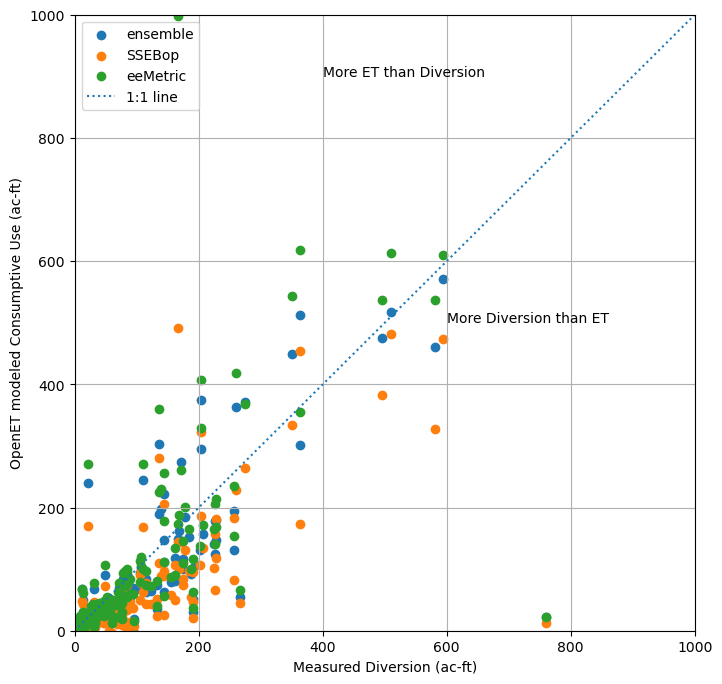

In [29]:
data = pd.read_csv(save_place / "yearly_openet_query_data.csv").set_index(['sensor','year'])

data_all = pd.merge(data,meter_read, left_index=True, right_index=True,copy=True)#how='outer'

for col in data_all:
    if "_et" in col or "_pr" in col or "_eet" in col:
        data_all[f"{col}"] = data_all[col]*data_all['acres']


        
data_all['ens_residual'] =  data_all['acft'] - data_all['ens_eet']
data_all['eem_residual'] =  data_all['acft'] - data_all['eem_eet']
data_all['sse_residual'] =  data_all['acft'] - data_all['eem_eet']

data_all['ens_resid_pcnt_eet'] = data_all['ens_residual']/data_all['ens_eet']

data_all = data_all.reset_index()
data_all['irr_area'] = data_all['sensor'].str[:2]#.apply(lambda x: x[:2],1)
data_all = data_all.set_index(['sensor','year'])


fig, ax = plt.subplots(1,1,figsize=(8,8))

plt.scatter(data_all['acft'], data_all['ens_eet'],label='ensemble')
plt.scatter(data_all['acft'], data_all['sse_eet'],label='SSEBop')
plt.scatter(data_all['acft'], data_all['eem_eet'],label='eeMetric')
plt.ylabel('OpenET modeled Consumptive Use (ac-ft)')
plt.xlabel('Measured Diversion (ac-ft)')
plt.text(400,900, "More ET than Diversion")
plt.text(600,500, "More Diversion than ET")
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.plot(range(0,1000),range(0,1000),linestyle=':', label="1:1 line")
plt.grid()
plt.legend()
#plt.savefig(figure_dir / 'consumption_vs_diversion.pdf')
#plt.savefig(figure_dir / 'consumption_vs_diversion.jpg')

Only look at areas being pumped, positive effecitive precip,

In [32]:
outliers_out = data_all[(data_all['ens_resid_pcnt_eet'] > -1)&(data_all['ens_eet'] > 0)&(data_all['acft'] > 0)&(data_all['ens_residual'].abs() < 500)]

In [33]:
data_all

ID      sse_et  ens_etof     ens_eto      ens_et     ens_pr  \
sensor year                                                                 
BC13   2019  141   74.099938  0.778431  367.770800  106.949790  37.605108   
       2020  141  112.143344  0.823317  400.515022  126.871023  15.255205   
       2021  141   74.477346  0.844118  371.154096  111.132424  48.507160   
       2022  141   68.160949  0.832807  367.950793  112.749309  30.723854   
BC22   2020  147  153.533416  1.001679  241.925354  157.454642   9.194180   
...          ...         ...       ...         ...         ...        ...   
UM41   2020   29   18.852613  0.135911   32.422715   21.083747   1.247936   
       2021   29   13.825732  0.129557   30.206375   18.226673   4.343359   
       2022   29   13.376122  0.131440   29.966256   18.484149   2.764449   
UM48   2021  101    4.067917  0.078072   43.898581   10.375169   6.312155   
       2022  101    5.188819  0.075669   43.549619   10.820624   4.017543   

                 eem_et     eem_eet     sse_eet     ens_eet      acres  \
sensor year                                                              
BC13   2019   97.239002   59.633893   36.494830   69.344682  98.481307   
       2020  126.189932  110.934727   96.888138  111.615818  98.481307   
       2021  105.494380   56.987220   25.970186   62.625264  98.481307   
       2022  103.734122   73.010268   37.437095   82.025455  98.481307   
BC22   2020  181.962819  172.768639  144.339236  148.260462  59.372584   
...                 ...         ...         ...         ...        ...   
UM41   2020   25.313546   24.065610   17.604678   19.835811   8.268931   
       2021   21.321998   16.978639    9.482373   13.883314   8.268931   
       2022   20.066324   17.301874   10.611673   15.719700   8.268931   
UM48   2021   10.773751    4.461597   -2.244238    4.063014  12.017144   
       2022   10.782354    6.764812    1.171276    6.803081  12.017144   

             gpm_total_acft   acft  ens_residual  eem_residual  sse_residual  \
sensor year                                                                    
BC13   2019       22.521356   94.0     24.655318     34.366107     34.366107   
       2020      144.597197  144.6     32.984182     33.665273     33.665273   
       2021       78.647426  144.6     81.974736     87.612780     87.612780   
       2022       81.247021   81.3     -0.725455      8.289732      8.289732   
BC22   2020       56.255516  166.8     18.539538     -5.968639     -5.968639   
...                     ...    ...           ...           ...           ...   
UM41   2020       26.139393   26.2      6.364189      2.134390      2.134390   
       2021       16.587289   26.2     12.316686      9.221361      9.221361   
       2022       21.273852   21.3      5.580300      3.998126      3.998126   
UM48   2021        0.211753    6.9      2.836986      2.438403      2.438403   
       2022        8.887199    8.9      2.096919      2.135188      2.135188   

             ens_resid_pcnt_eet irr_area  
sensor year                               
BC13   2019            0.355547       BC  
       2020            0.295515       BC  
       2021            1.308972       BC  
       2022           -0.008844       BC  
BC22   2020            0.125047       BC  
...                         ...      ...  
UM41   2020            0.320843       UM  
       2021            0.887158       UM  
       2022            0.354988       UM  
UM48   2021            0.698247       UM  
       2022            0.308231       UM  

[168 rows x 18 columns]

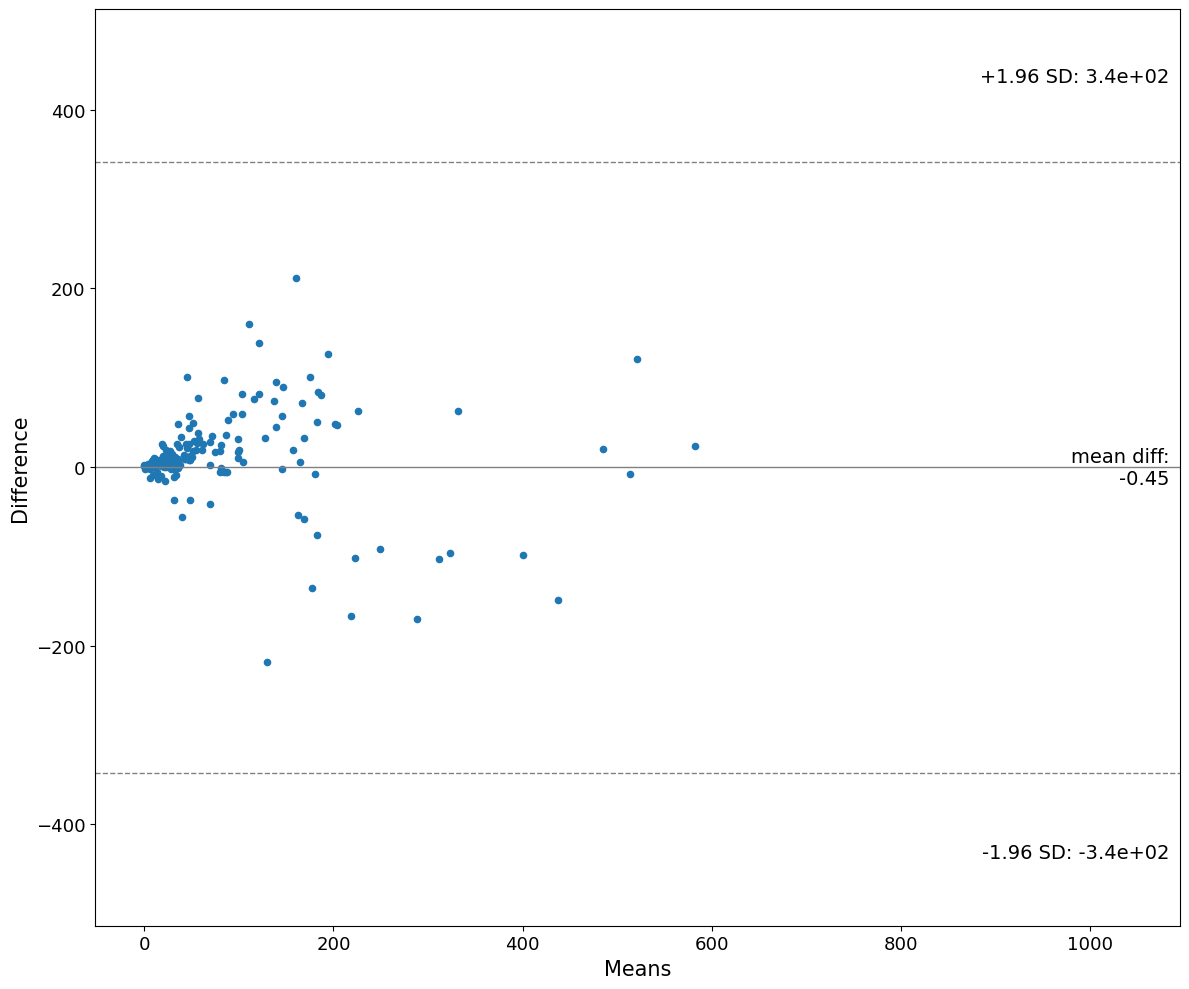

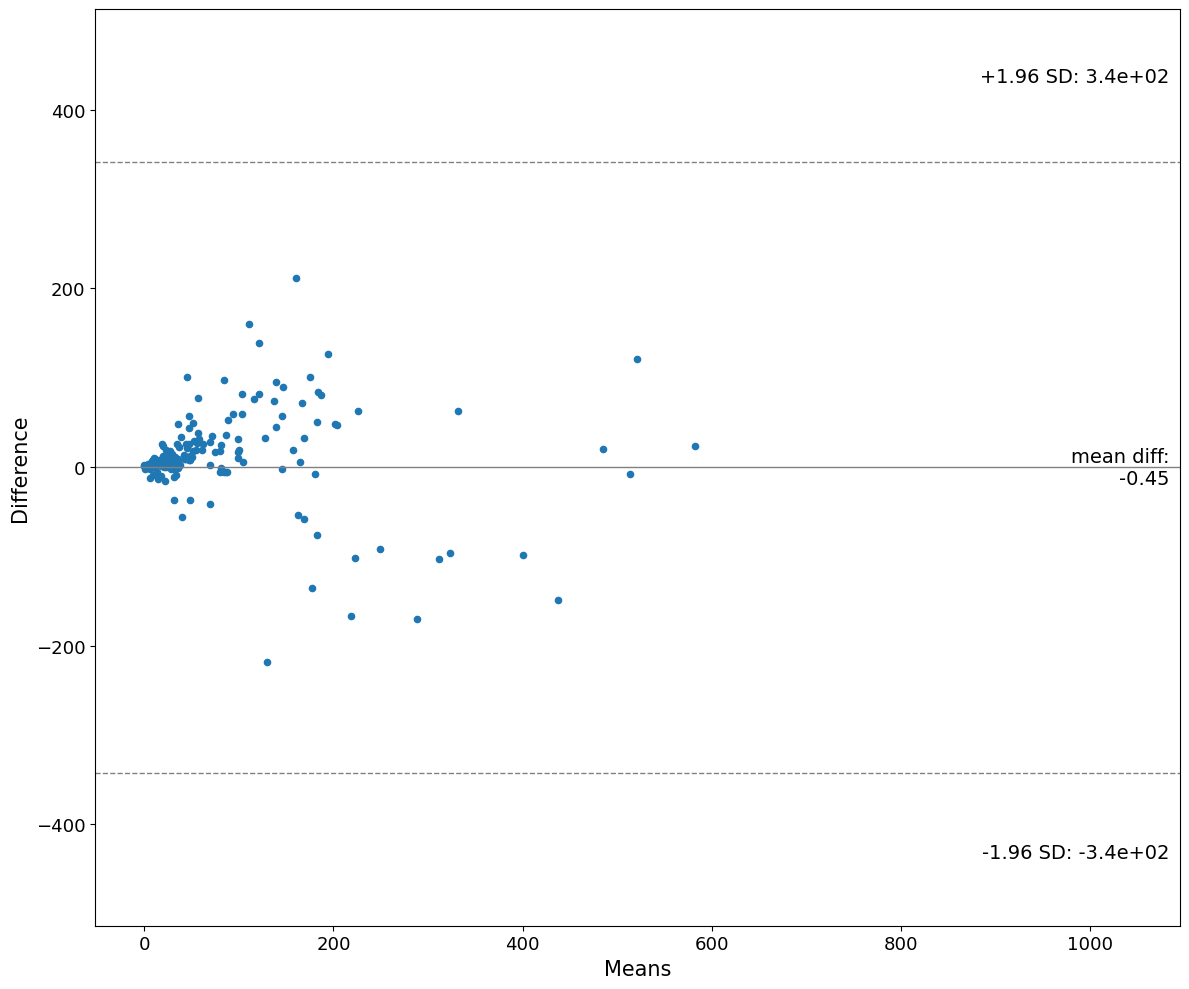

In [35]:
fig, ax = plt.subplots(1,1)
sm.graphics.mean_diff_plot(data_all['acft'], data_all['ens_eet'],ax=ax)
#sm.graphics.mean_diff_plot(data_all['ens_eet'], data_all['total_acft'],ax=ax[1])

Text(85.09722222222221, 0.5, 'Gage measurement minus OpenET Ensemble (ac-ft)')

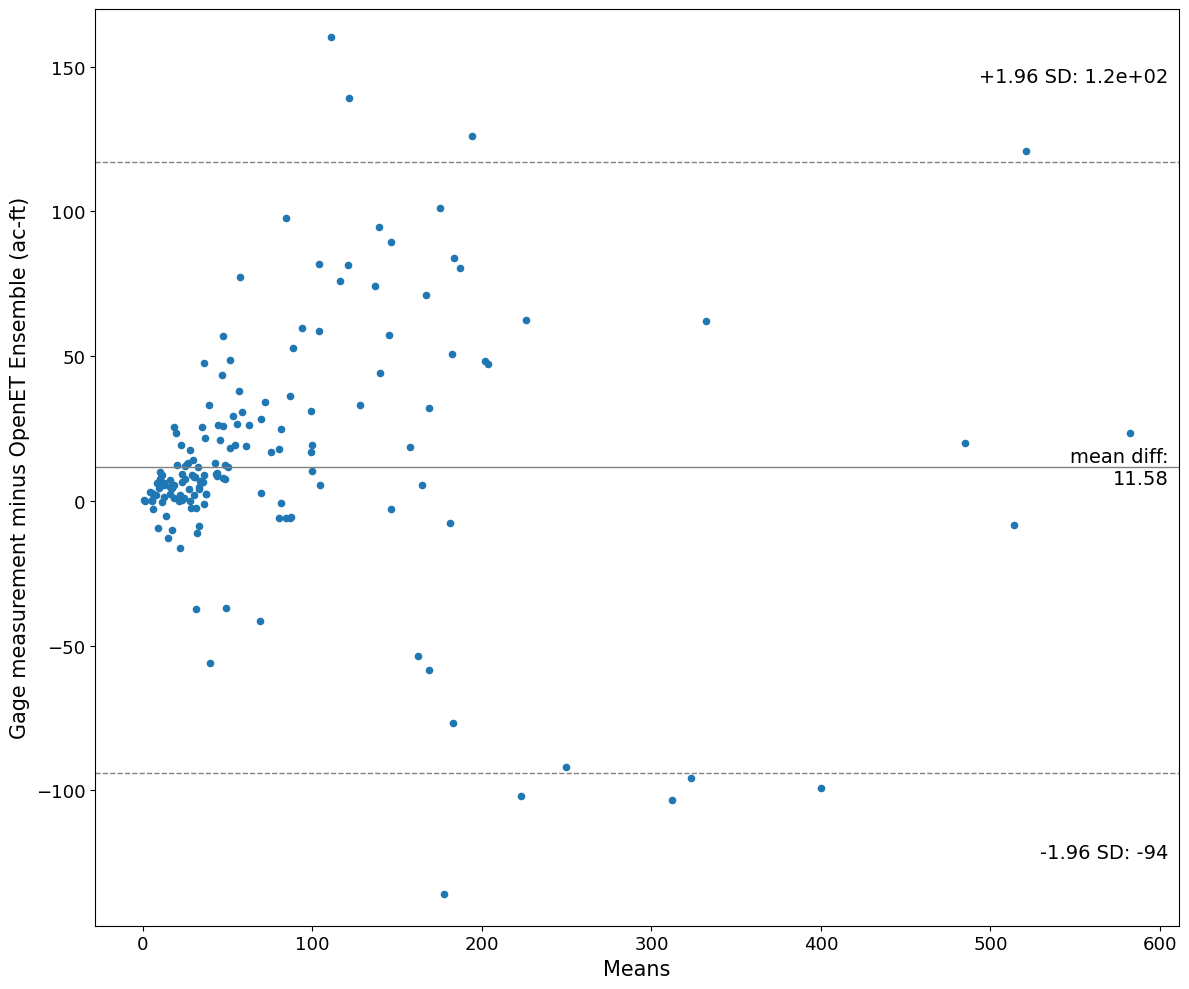

In [47]:
fig, ax = plt.subplots(1,1)
sm.graphics.mean_diff_plot(outliers_out['acft'], outliers_out['ens_eet'],ax=ax)
plt.ylabel("Gage measurement minus OpenET Ensemble (ac-ft)")
#sm.graphics.mean_diff_plot(data_all['ens_eet'], data_all['total_acft'],ax=ax[1])

Text(0.5, 1.0, 'Normalized for acrage')

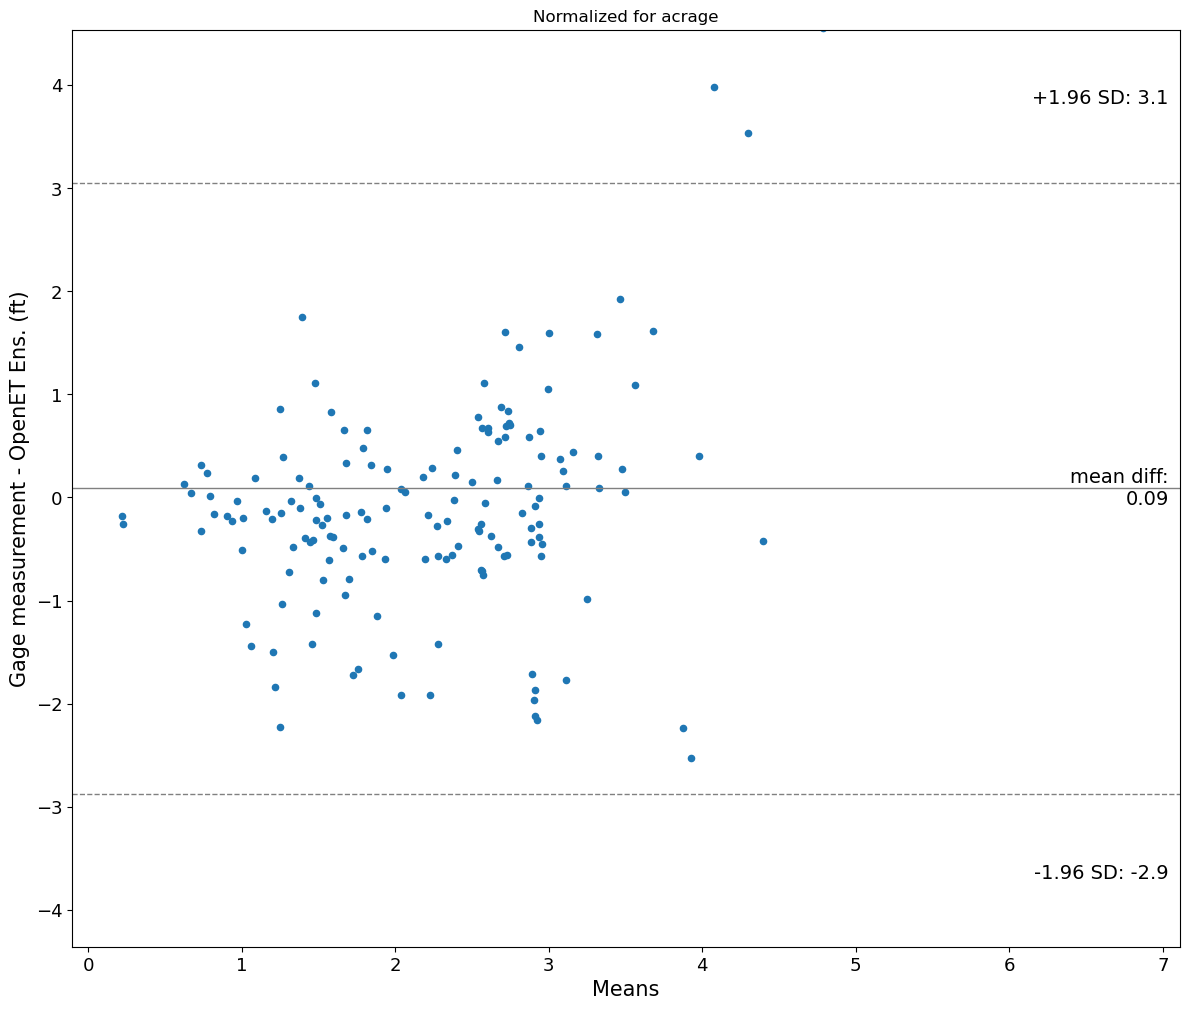

In [48]:
sm.graphics.mean_diff_plot(outliers_out['acft']/outliers_out['acres'],outliers_out['eem_et']/outliers_out['acres'])
plt.ylabel("Gage measurement - OpenET Ens. (ft)")
plt.title("Normalized for acrage")

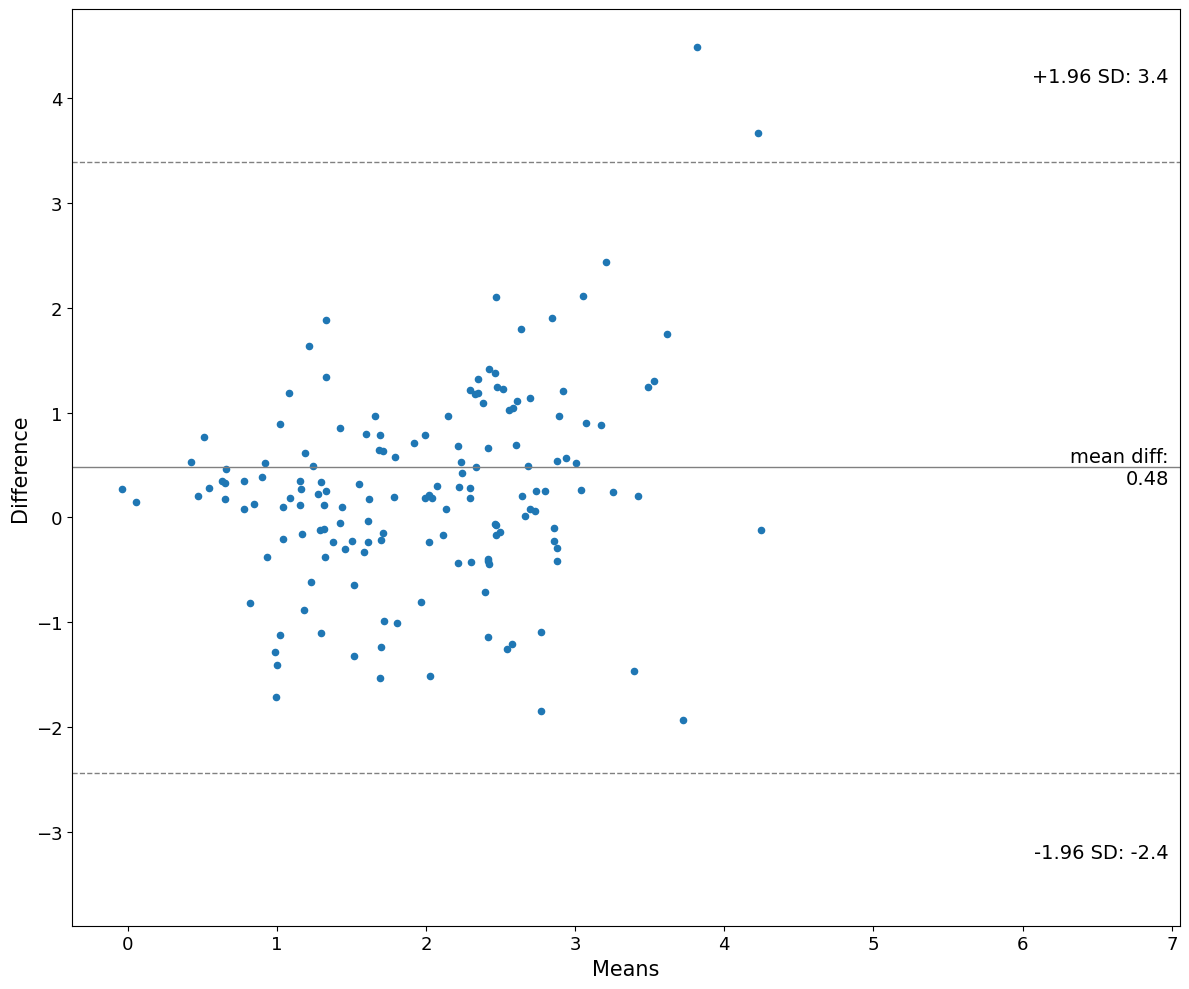

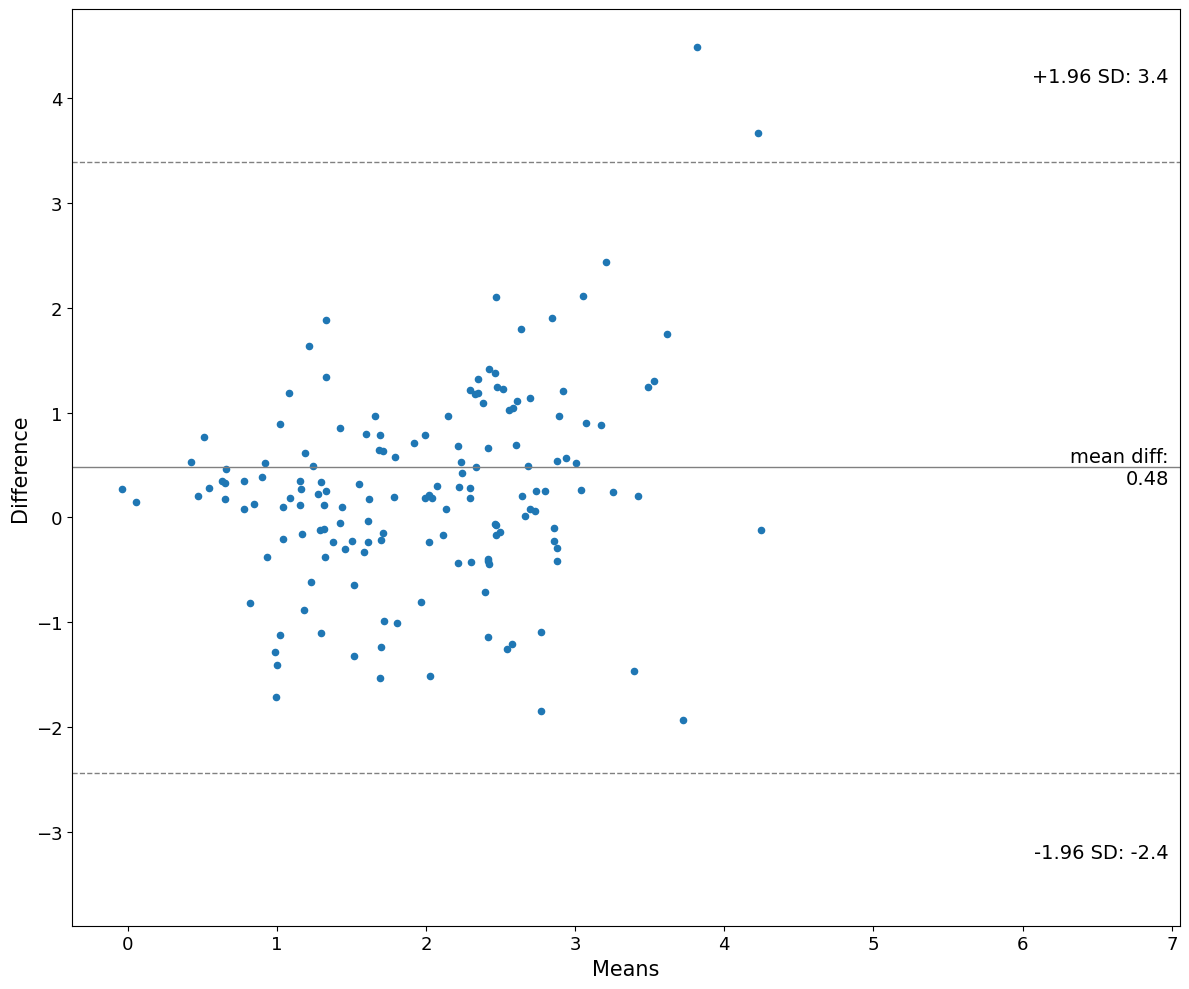

In [37]:
sm.graphics.mean_diff_plot(outliers_out['acft']/outliers_out['acres'],outliers_out['eem_eet']/outliers_out['acres'])

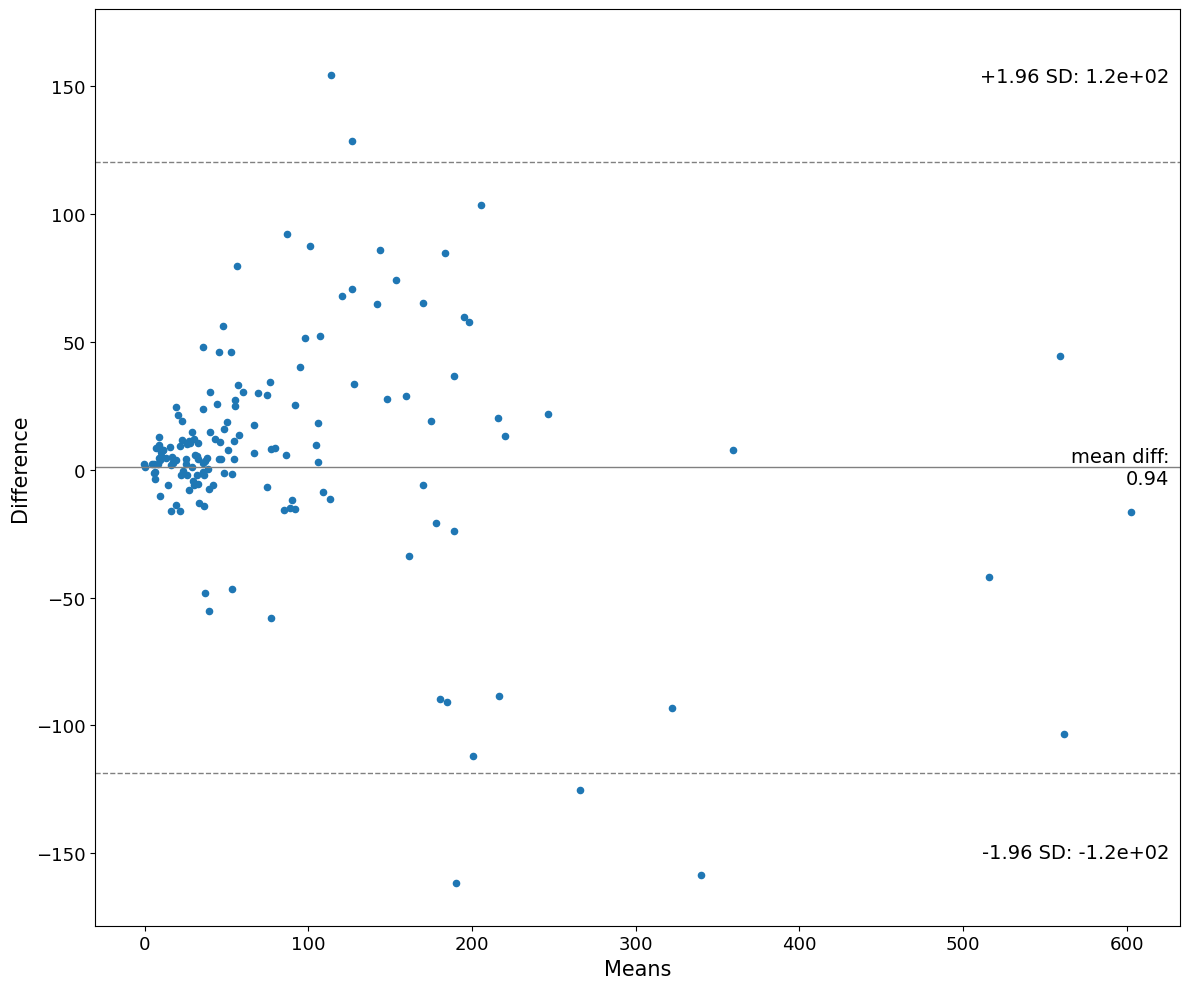

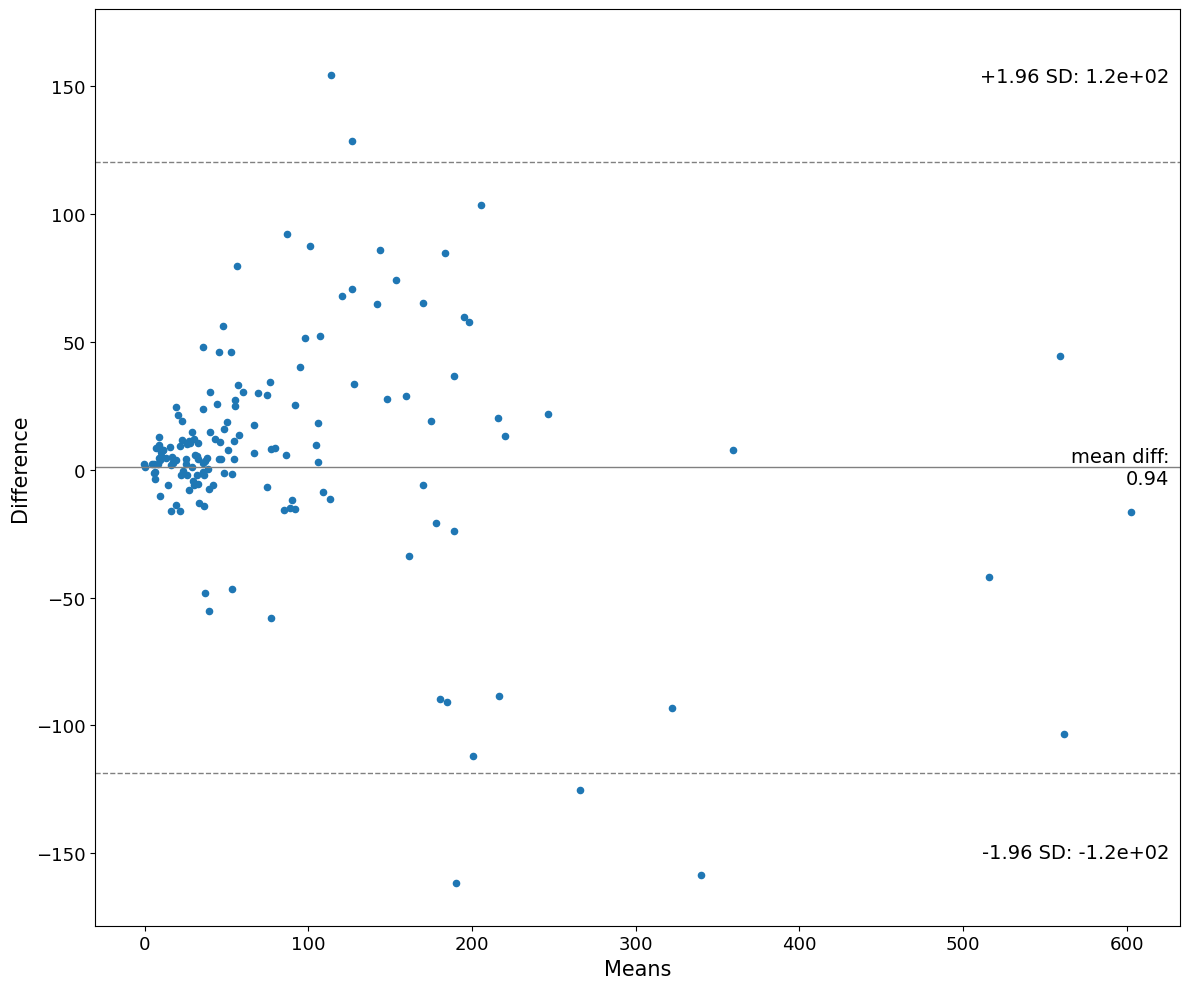

In [39]:
fig, ax = plt.subplots(1,1)
sm.graphics.mean_diff_plot(outliers_out['acft'], outliers_out['eem_eet'],ax=ax)
#sm.graphics.mean_diff_plot(data_all['ens_eet'], data_all['total_acft'],ax=ax[1])

In [40]:
outliers_out['ens_residual'].median()

8.685928260103694

In [41]:
outliers_out['eem_residual'].median()
#outliers_out['eem_residual'].mean()

5.219573559927241

(-3.0, 5.0)

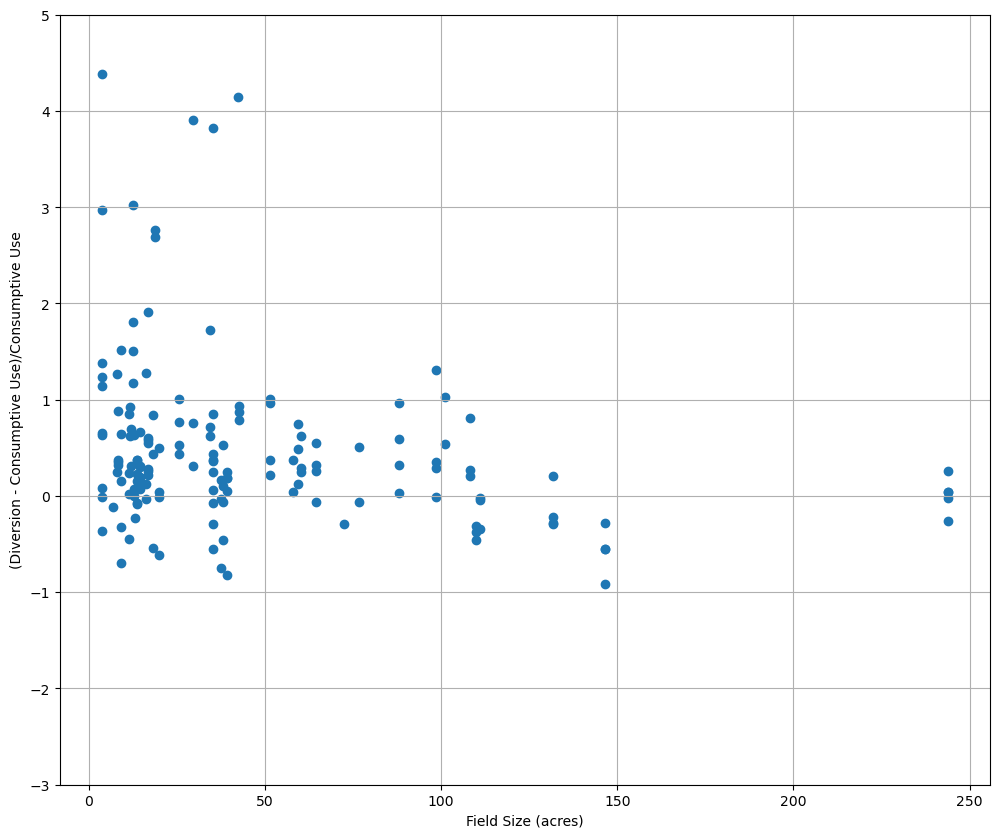

In [42]:

plt.scatter(outliers_out['acres'],outliers_out['ens_resid_pcnt_eet'])
plt.xlabel('Field Size (acres)')
plt.ylabel('(Diversion - Consumptive Use)/Consumptive Use')
plt.grid()
plt.ylim(-3,5)

#plt.savefig(figure_dir / 'consumption_vs_diversion_ratio.pdf')
#plt.savefig(figure_dir / 'consumption_vs_diversion_ratio.jpg')

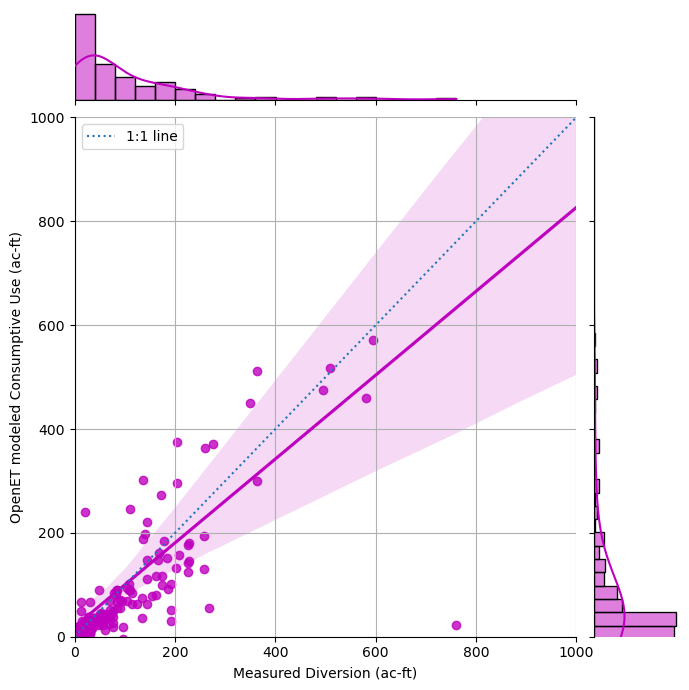

In [49]:


g = sns.jointplot(x='acft', y='ens_eet', data=data_all,
                  kind="reg", truncate=False,
                  xlim=(0, 1000), ylim=(0, 1000),
                  color="m", height=7)


plt.ylabel('OpenET modeled Consumptive Use (ac-ft)')
plt.xlabel('Measured Diversion (ac-ft)')

plt.plot(range(0,1000),range(0,1000),linestyle=':', label="1:1 line")
plt.grid()
plt.legend()
#plt.savefig(figure_dir / 'consumption_vs_diversion_jointplot.pdf')
#plt.savefig(figure_dir / 'consumption_vs_diversion_jointplot.jpg')

(-3.0, 5.0)

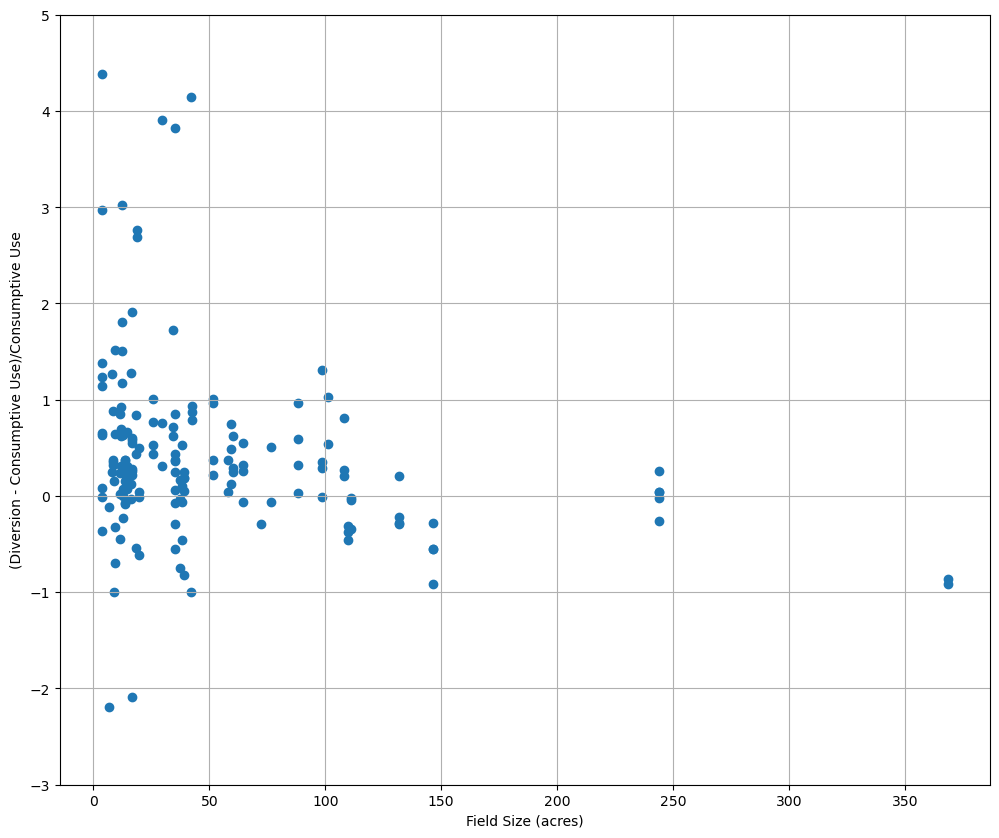

In [50]:

plt.scatter(data_all['acres'],data_all['ens_resid_pcnt_eet'])
plt.xlabel('Field Size (acres)')
plt.ylabel('(Diversion - Consumptive Use)/Consumptive Use')
plt.grid()
plt.ylim(-3,5)

#plt.savefig(figure_dir / 'consumption_vs_diversion_ratio.pdf')
#plt.savefig(figure_dir / 'consumption_vs_diversion_ratio.jpg')

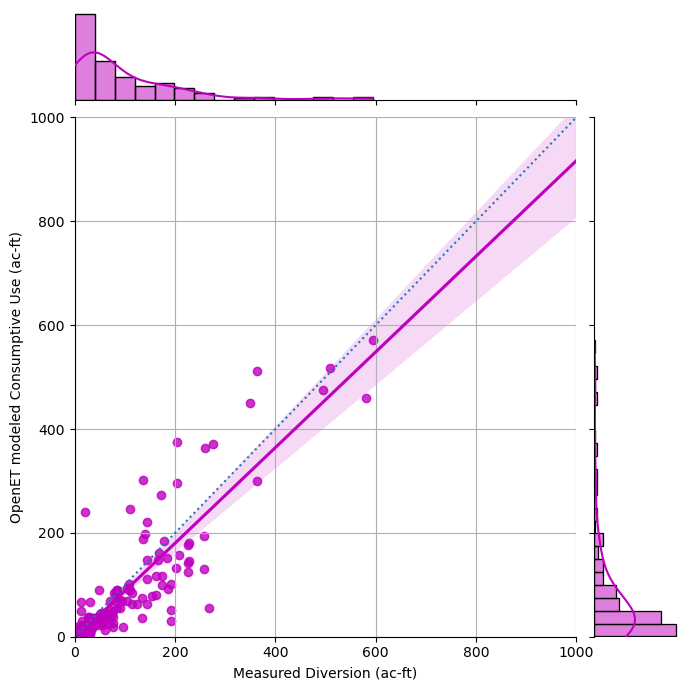

In [51]:
#outliers_out

g = sns.jointplot(x='acft', y='ens_eet', data=outliers_out,
                  kind="reg", truncate=False,
                  xlim=(0, 1000), ylim=(0, 1000),
                  color="m", height=7)


plt.ylabel('OpenET modeled Consumptive Use (ac-ft)')
plt.xlabel('Measured Diversion (ac-ft)')

plt.plot(range(0,1000),range(0,1000),linestyle=':', label="1:1 line")
plt.grid()

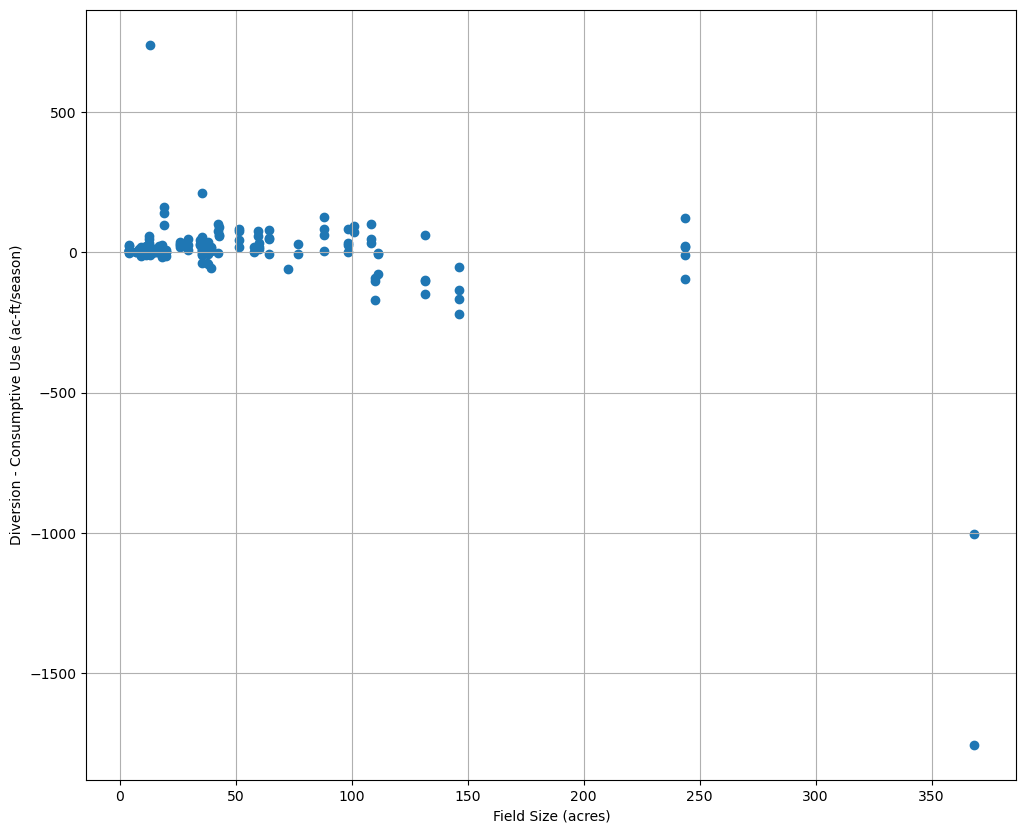

In [52]:
plt.scatter(data_all['acres'],data_all['ens_residual'])
plt.xlabel('Field Size (acres)')
plt.ylabel('Diversion - Consumptive Use (ac-ft/season)')
plt.grid()
#plt.savefig(figure_dir / "residual_by_area.png")
#plt.savefig(figure_dir / "residual_by_area.pdf")

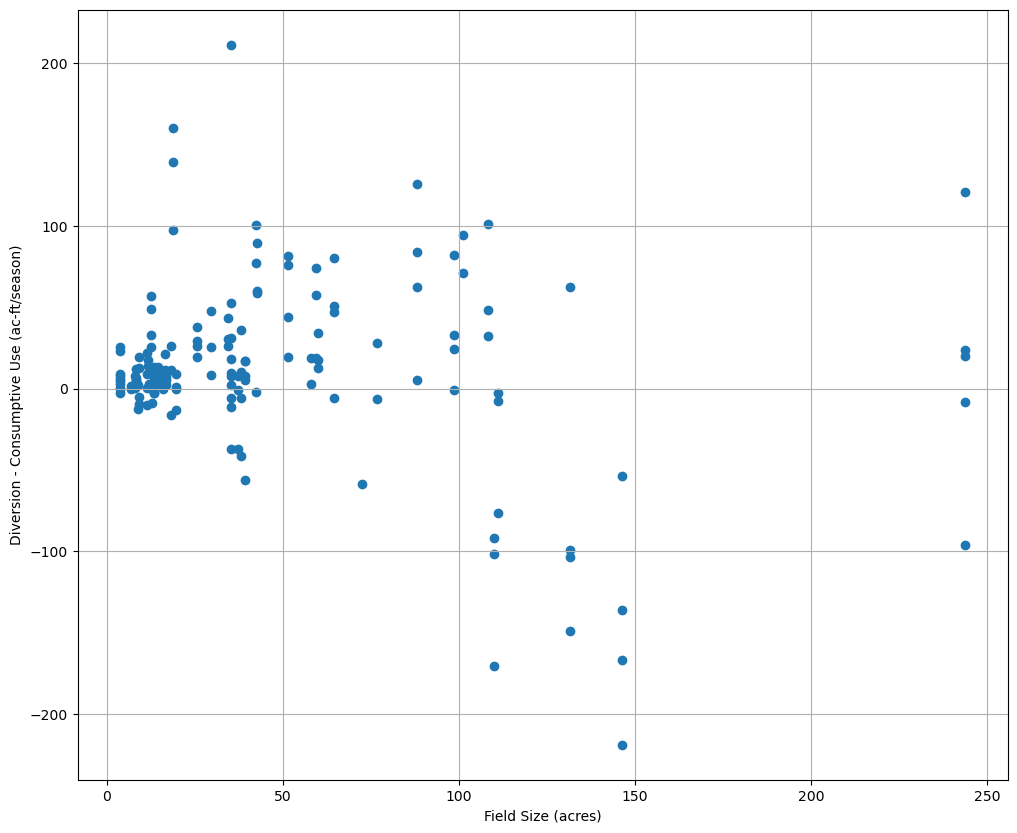

In [53]:
plt.scatter(data_all[data_all['ens_residual'].abs() < 500]['acres'],data_all[data_all['ens_residual'].abs() < 500]['ens_residual'])
plt.xlabel('Field Size (acres)')
plt.ylabel('Diversion - Consumptive Use (ac-ft/season)')
plt.grid()

In [ ]:
data_all[data_all['ens_residual'].abs() > 500]

# Import Datasets

THIS SECTION CAN BE SKIPPED IF DATASETS HAVE ALREADY BEEN IMPORTED

This section is organized by the Google Earth Engine Layers.  

It's based on the output from this script: https://code.earthengine.google.com/796841f26989c1df91bad0e663e525a3

## PML

https://developers.google.com/earth-engine/datasets/catalog/CAS_IGSNRR_PML_V2#bands

<section tab="bands" role="tabpanel" aria-labelledby="aria-tab-bands" tabindex="0" id="tabpanel-bands" active="">

<p>
<b>Resolution</b>
<br>500 meters
</p>
<p><b>Bands</b>
</p><div class="devsite-table-wrapper"><table class="eecat">
<tbody><tr>
<th scope="col">Name</th>
<th scope="col">Units</th>
<th scope="col">Min</th>
<th scope="col">Max</th>
<th scope="col">Description</th>
</tr>
<tr>
<td><code translate="no" dir="ltr">GPP</code></td>
<td>gC m-2 d-1</td>
<td>
          0*
</td>
<td>
          39.01*
</td>
<td><p>Gross primary product</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">Ec</code></td>
<td>mm d-1</td>
<td>
          0*
</td>
<td>
          15.33*
</td>
<td><p>Vegetation transpiration</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">Es</code></td>
<td>mm d-1</td>
<td>
          0*
</td>
<td>
          8.2*
</td>
<td><p>Soil evaporation</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">Ei</code></td>
<td>mm d-1</td>
<td>
          0*
</td>
<td>
          12.56*
</td>
<td><p>Interception from vegetation canopy</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">ET_<wbr>water</code></td>
<td>mm d-1</td>
<td>
          0*
</td>
<td>
          20.11*
</td>
<td><p>Water body, snow and ice evaporation. Penman evapotranspiration is
regarded as actual evaporation for them.</p></td>
</tr>
</tbody></table></div>
  * estimated min or max value
</section>

Read in the data from the GEE output and convert the dates into a readable datetime.  Rasters are in units mm/day (see above).  Convert these to volume by converting to consistent units then multiplying by area.

In [30]:
pml = pd.read_csv(raw_dir / "MonthlyPML.csv")
#pml = matchhuc(pml, hucbasin)
pml['date'] = pd.to_datetime(pml['date'], format='%Y-%m-%d')

pml['Total_ET'] =  pml[['Soil_Evap','Veg_Trans','Veg_Intercep']].sum(axis=1)

# ET in ac-ft
pml['Soil_Evap_af'] = pml['Soil_Evap']*pml['area']*0.001*0.000810714
pml['Veg_Trans_af'] = pml['Veg_Trans']*pml['area']*0.001*0.000810714
pml['Veg_Intercep_af'] = pml['Veg_Intercep']*pml['area']*0.001*0.000810714
pml['Total_ET_af'] = pml[['Soil_Evap_af','Veg_Trans_af','Veg_Intercep_af']].sum(axis=1)

In [31]:
# Set the date as the index and sort by date
pml = pml.reset_index().set_index('date').sort_index().drop(['system:index','area','.geo'],axis=1)
# Lump the data into hucs and then resample the data to daily. Fill in missing days with interpolation
pmlmo = pml.groupby('hucname').resample('1D').asfreq().interpolate(method='linear')
pmlmo = pmlmo.drop(['hucname'],axis=1).reset_index()#.resample('1M').mean()

# Lump the daily data into monthly data
pmlmo = pmlmo.groupby(['hucname',pd.Grouper(key='date',freq='1MS',closed='left',label='left')]).sum()

# Add a water year field and group the data by water year
pmlmo['wateryear'] = pmlmo.reset_index().set_index('date').index.shift(-9,freq='M').year+1

pmlallyr = pmlmo.groupby('wateryear').sum()
# This filter was added to make sure you are not getting partial water years; You may want to adjust accordingly

pmlwy = pmlmo.groupby(['hucname','wateryear']).sum()

In [32]:
pmlmo = pmlmo[['Soil_Evap_af','Veg_Trans_af', 'Veg_Intercep_af', 'Total_ET_af']]
pmlmo = pmlmo.rename(columns={'Soil_Evap_af':'PML_Soil_Evap_acft',
                              'Veg_Trans_af':'PML_Veg_Trans_acft', 
                              'Veg_Intercep_af':'PML_Veg_Intercept_acft', 
                              'Total_ET_af':'pml_aet_acft'})
pmlmo.to_csv(save_place / "pml_mo.csv")
pmlmo.to_parquet(save_place / "pml_mo.parquet")

Plot the resulting ET!

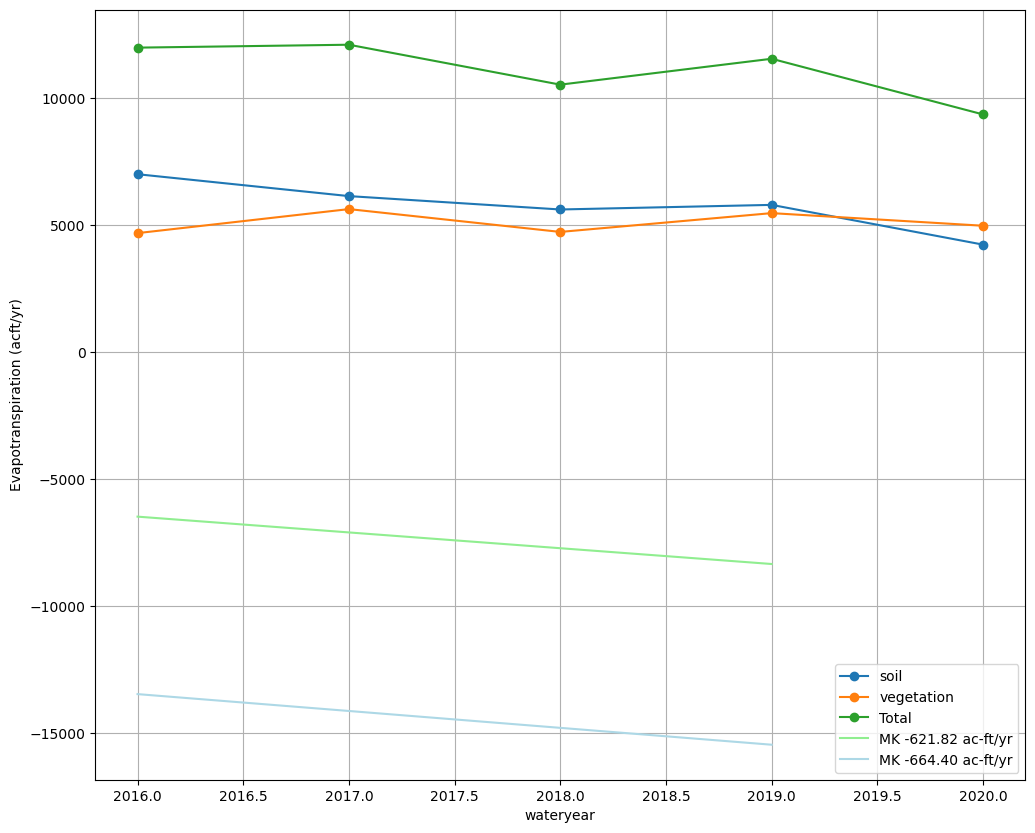

In [34]:
fig, ax = plt.subplots(1,1)
pmlallyr = pmlallyr[(pmlallyr.index>1980)&(pmlallyr.index<2023)]
pmlallyr['Soil_Evap_af'].plot(label='soil',ax=ax, marker='o')
pmlallyr['Veg_Trans_af'].plot(label='vegetation',ax=ax, marker='o')#['Veg_Trans'].plot()
pmlallyr['Total_ET_af'].plot(label='Total',ax=ax, marker='o')

# This custom function is defined above in the functions section.
plotmk(pmlallyr['Total_ET_af'],axis=ax,color='lightgreen')
plotmk(pmlallyr['Soil_Evap_af'],axis=ax,color='lightblue')
plotmk(pmlallyr['Veg_Trans_af'],axis=ax,color='yellow')
plt.legend()
plt.grid()
plt.ylabel('Evapotranspiration (acft/yr)')
#plt.xticks(range(2014,2021,1))

pmlmo_abb = pmlmo[['PML_Soil_Evap_acft','PML_Veg_Trans_acft',
                   'PML_Veg_Intercept_acft','pml_aet_acft']]
pmlmo_abb = pmlmo_abb.rename(columns={'PML_Soil_Evap_acft':'aetsoil_pml', 
                                  'PML_Veg_Trans_acft':'aetveg_pml', 
                                  'PML_Veg_Intercept_acft':'aetint_pml', 
                                  'pml_aet_acft':'aet_pml'})

In [35]:
pml['month']= pml.index.month
pml['quarter']= pml.index.quarter

Text(0, 0.5, 'Evapotranspiration (mm/day)')

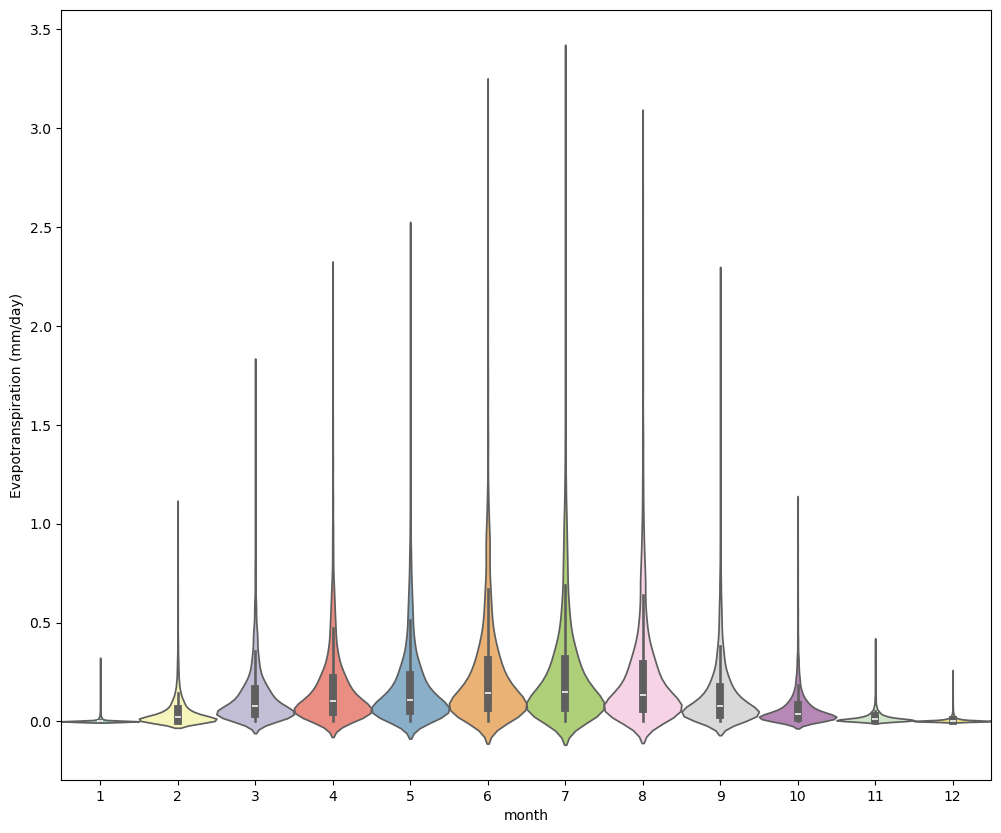

In [68]:
ax = sns.violinplot(x='month', y='Total_ET_af', data=pml, hue='month', legend=False, palette="Set3",width=1)
plt.ylabel('Evapotranspiration (mm/day)')

Text(0, 0.5, 'Evapotranspiration (mm/mo)')

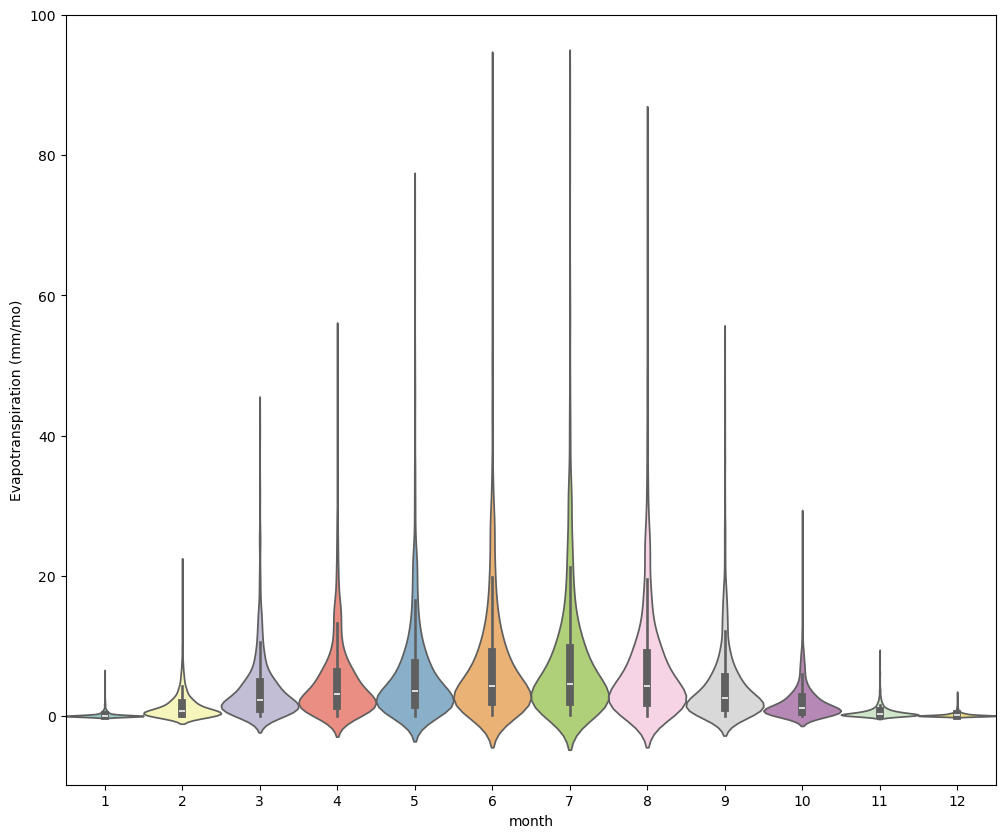

In [67]:
pmlmo['month'] = pmlmo.index.get_level_values(1).month
ax = sns.violinplot(x='month', y='pml_aet_acft', data=pmlmo, hue='month', legend=False, palette="Set3",width=1)
plt.ylabel('Evapotranspiration (mm/mo)')

## Terra

https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE#bands

<table class="eecat">
<tbody><tr>
<th scope="col">Name</th>
<th scope="col">Units</th>
<th scope="col">Min</th>
<th scope="col">Max</th>
<th scope="col">Scale</th>
<th scope="col">Description</th>
</tr>
<tr>
<td><code translate="no" dir="ltr">aet</code></td>
<td>mm</td>
<td>
          0*
</td>
<td>
          3140*
</td>
<td>0.1</td>
<td><p>Actual evapotranspiration, derived using a one-dimensional soil water balance model</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">def</code></td>
<td>mm</td>
<td>
          0*
</td>
<td>
          4548*
</td>
<td>0.1</td>
<td><p>Climate water deficit, derived using a one-dimensional soil water balance model</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">pdsi</code></td>
<td></td>
<td>
          -4317*
</td>
<td>
          3418*
</td>
<td>0.01</td>
<td><p>Palmer Drought Severity Index</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">pet</code></td>
<td>mm</td>
<td>
          0*
</td>
<td>
          4548*
</td>
<td>0.1</td>
<td><p>Reference evapotranspiration (ASCE Penman-Montieth)</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">pr</code></td>
<td>mm</td>
<td>
          0*
</td>
<td>
          7245*
</td>
<td></td>
<td><p>Precipitation accumulation</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">ro</code></td>
<td>mm</td>
<td>
          0*
</td>
<td>
          12560*
</td>
<td></td>
<td><p>Runoff, derived using a one-dimensional soil water balance model</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">soil</code></td>
<td>mm</td>
<td>
          0*
</td>
<td>
          8882*
</td>
<td>0.1</td>
<td><p>Soil moisture, derived using a one-dimensional soil water balance model</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">srad</code></td>
<td>W/m^2</td>
<td>
          0*
</td>
<td>
          5477*
</td>
<td>0.1</td>
<td><p>Downward surface shortwave radiation</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">swe</code></td>
<td>mm</td>
<td>
          0*
</td>
<td>
          32767*
</td>
<td></td>
<td><p>Snow water equivalent, derived using a one-dimensional soil water balance model</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">tmmn</code></td>
<td>°C</td>
<td>
          -770*
</td>
<td>
          387*
</td>
<td>0.1</td>
<td><p>Minimum temperature</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">tmmx</code></td>
<td>°C</td>
<td>
          -670*
</td>
<td>
          576*
</td>
<td>0.1</td>
<td><p>Maximum temperature</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">vap</code></td>
<td>kPa</td>
<td>
          0*
</td>
<td>
          14749*
</td>
<td>0.001</td>
<td><p>Vapor pressure</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">vpd</code></td>
<td>kPa</td>
<td>
          0*
</td>
<td>
          1113*
</td>
<td>0.01</td>
<td><p>Vapor pressure deficit</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">vs</code></td>
<td>m/s</td>
<td>
          0*
</td>
<td>
          2923*
</td>
<td>0.01</td>
<td><p>Wind-speed at 10m</p></td>
</tr>
</tbody></table>

In [56]:
def grpterra(x):
    """function to be applied to groupby technique on hucs and Terra data"""
    d = {}
    d['terra_et'] = x['aet_volume_af'].sum()
    d['terra_ppt'] = x['pr_volume_af'].sum()
    d['terra_ro'] = x['ro_volume_af'].sum()
    d['terra_def'] = x['def_volume_af'].sum()
    d['terra_soil'] = x['soil_volume_af'].max()
    d['terra_swe'] = x['swe_diff'].sum()
    d['terra_swe_max'] = x['swe_diff'].sum()
    d['wateryear'] = x['wateryear'].max()
    return pd.Series(d,index=['terra_et','terra_ppt','terra_ro','terra_soil','terra_def','terra_swe','wateryear'])

Read in Terra data, get dates in proper format, and organize indices

In [57]:
terra = pd.read_csv(raw_dir / "Monthly.csv")

#terra = matchhuc(terra, hucbasin)

terra['hucname'] = terra['site']
terra = terra.reset_index().rename(columns={'system:time_start':'date'})
terra['date'] = pd.to_datetime(terra['date'], format='%Y%m')
#terra = terra[terra['date']<pd.to_datetime('2022-10-01')]
terra = terra.drop('system:index',axis=1).sort_index().set_index(['hucname','date'])
terra['wateryear'] = terra.reset_index().set_index('date').index.shift(-9,freq='M').year+1

Convert units from mm/month to ac-ft per month

In [58]:
calcfields = ['aet', 'def', 'pr', 'ro', 'soil', 'swe']
for fld in calcfields:
    if fld in ['pr','ro','swe']:
        # area * mm to m * m3 to acre-ft
        terra[fld+"_volume_af"] = terra[fld]*terra['area']*0.001*0.000810714#*1.34289379E-5
    else:
        terra[fld+"_volume_af"] = terra[fld]*terra['area']*0.001*0.000810714*0.1#*1.34289379E-5

Get change in snowpack volume and change in soil water volume over time:

In [59]:
# diff function takes difference between one month and the next month; change over time
terra['swe_diff'] = terra['swe_volume_af'].diff() 
terra['soil_diff'] = terra['soil_volume_af'].diff()


In [60]:
terra_mo = terra[['aet_volume_af','def_volume_af','pr_volume_af','ro_volume_af','soil_volume_af','swe_volume_af']]
rename_dict = {'aet_volume_af':'terra_aet_acft',
               'def_volume_af':'terra_def_acft',
               'pr_volume_af':'terra_ppt_acft',
               'ro_volume_af':'terra_ro_acft',
               'soil_volume_af':'terra_soil_acft',
               'swe_volume_af':'terra_swe_acft'}
terra_mo = terra_mo.rename(columns=rename_dict)
terra_mo.to_csv(save_place / "terra_mo_hydrodiv.csv")
terra_mo.to_parquet(save_place / "terra_mo_hydrodiv.parquet")

<Axes: xlabel='date'>

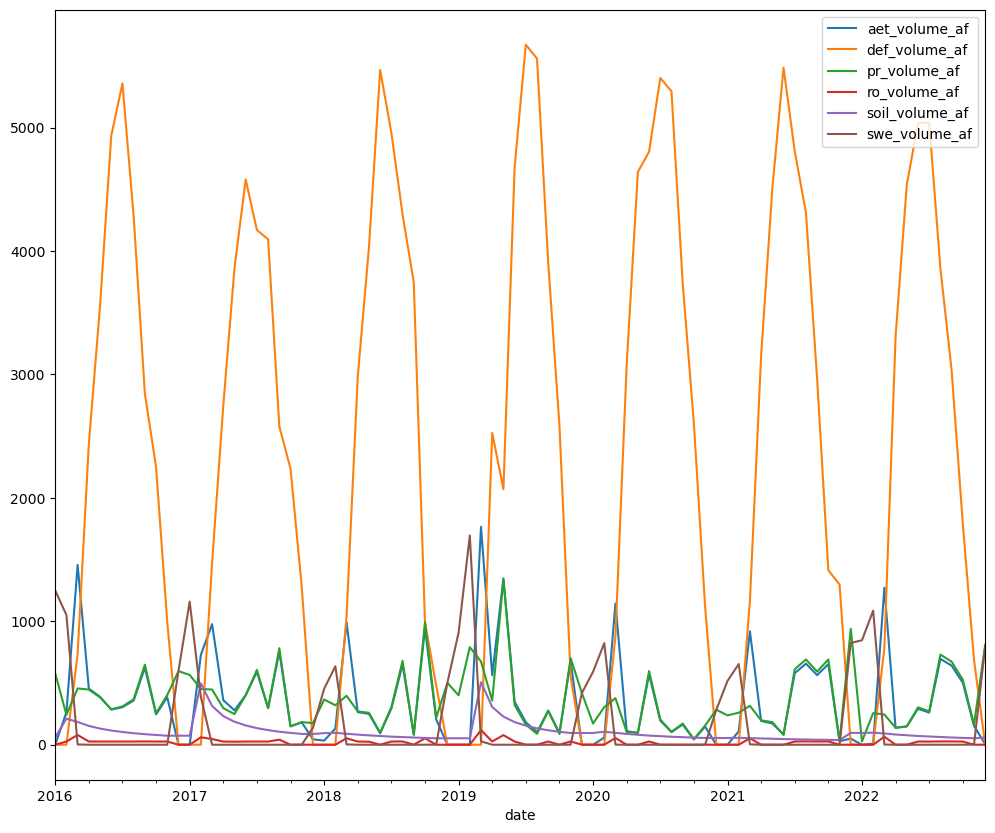

In [61]:
terra.groupby(level=1).sum()[['aet_volume_af','def_volume_af',
                                     'pr_volume_af','ro_volume_af',
                                     'soil_volume_af','swe_volume_af']].plot()

<Axes: xlabel='date'>

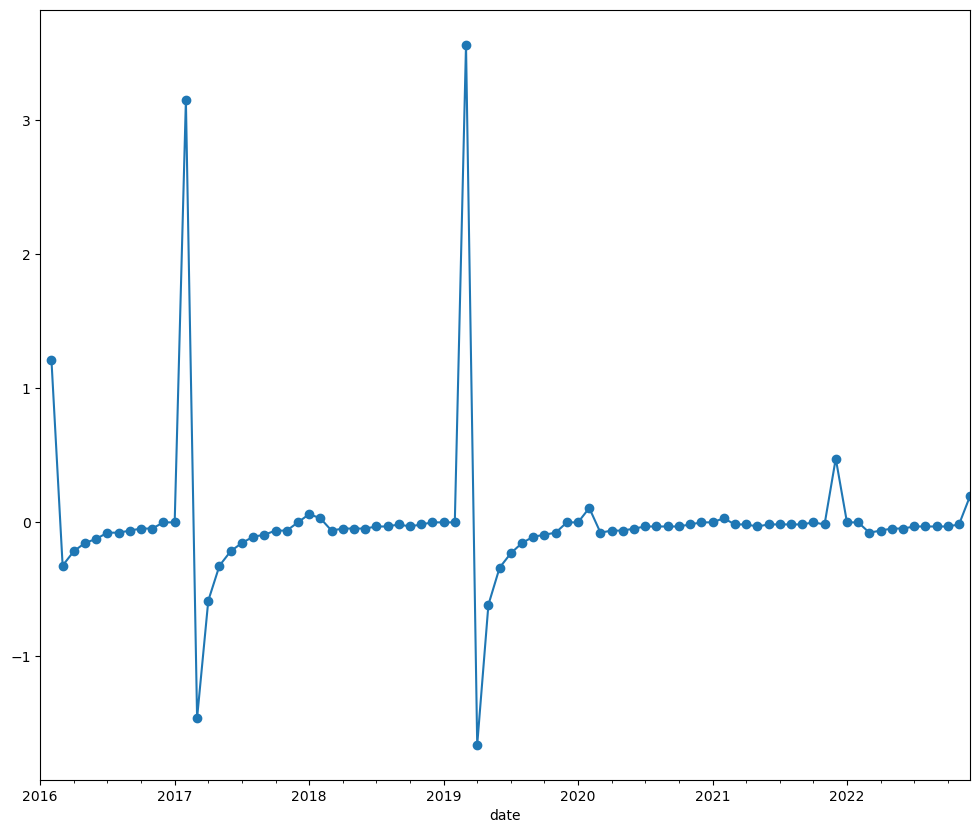

In [77]:
terra_mo.loc[2,'terra_soil_acft'].diff().plot(marker='o')

In [62]:

# This is grouping by water year and individual huc
terra_wy = terra.groupby(['hucname','wateryear']).apply(grpterra).sort_index()
# This groups all hucs together (entire basin) and gives data by water year
teryr = terra.groupby('wateryear').apply(grpterra).sort_index()

terra_wy.to_csv(save_place / "Terra_wy.csv")
terra_wy.to_parquet(save_place / "Terra_wy.parquet")

In [63]:
#terra.to_csv(save_place / "Terra_mo.csv")

Plot data

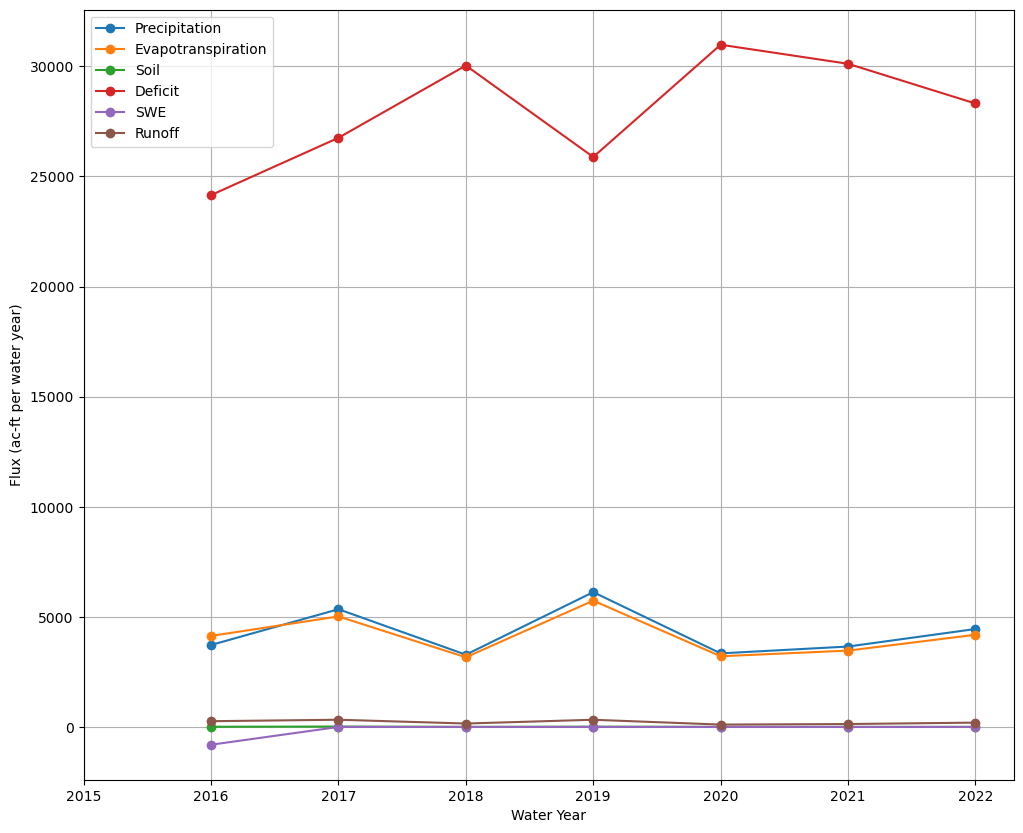

In [78]:
teryr = teryr[teryr.index<2023]

teryr['terra_ppt'].plot(marker='o',label='Precipitation')
teryr['terra_et'].plot(marker='o',label='Evapotranspiration')
teryr['terra_soil'].plot(marker='o',label='Soil')
teryr['terra_def'].plot(marker='o',label='Deficit')
teryr['terra_swe'].plot(marker='o',label='SWE')
teryr['terra_ro'].plot(marker='o',label='Runoff')

plt.ylabel('Flux (ac-ft per water year)')
plt.xticks(range(2015,2023,1))
plt.xlabel('Water Year')
plt.legend()
plt.grid()


terra_abb = terra[['aet_volume_af', 'def_volume_af', 'pr_volume_af', 'ro_volume_af', 'soil_volume_af', 'swe_volume_af']]
terra_abb = terra_abb.rename(columns={'aet_volume_af':'aet_terra', 
                      'def_volume_af':'def_terra', 
                      'pr_volume_af':'ppt_terra', 
                      'ro_volume_af':'ro_terra',
                      'soil_volume_af':'soil_terra', 
                      'swe_volume_af':'swe_terra'})

terra_abb = terra_abb.groupby([terra_abb.index.get_level_values(0), 
                               pd.Grouper(level=1,freq='1MS',label='left',closed='right')]).mean()


Text(0, 0.5, 'Evapotranspiration (mm/mo)')

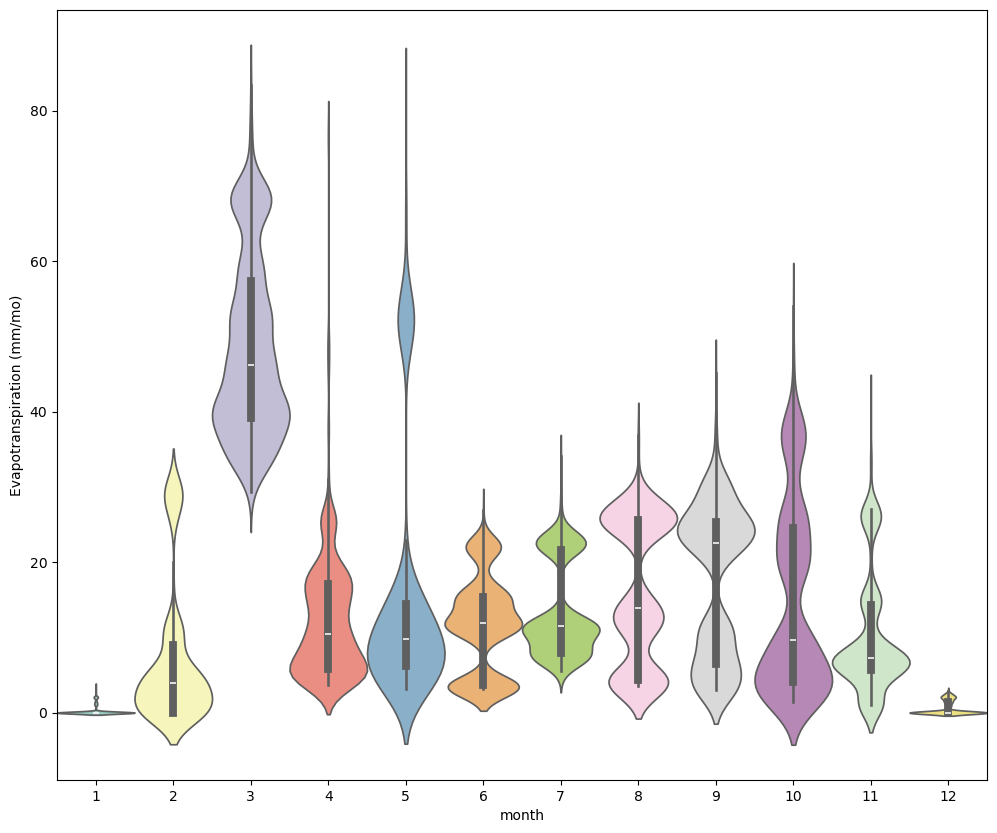

In [69]:
terra['month'] = terra.index.get_level_values(1).month
terra['aet_adj'] = terra['aet']*0.1 
ax = sns.violinplot(x='month', y='aet_adj', data=terra, hue='month',legend=False,palette="Set3",width=1)
plt.ylabel('Evapotranspiration (mm/mo)')

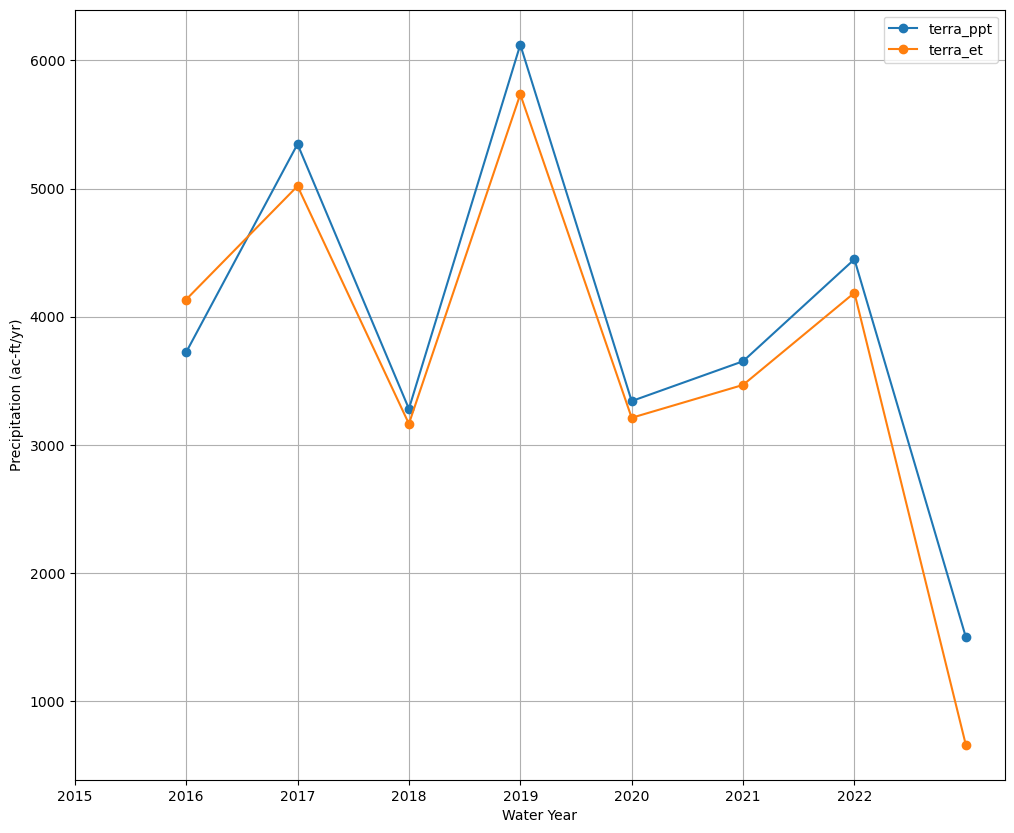

In [71]:
rcParams['figure.figsize'] = 12, 10
rcParams['pdf.fonttype'] = 42
inline_rc = dict(plt.rcParams)

plt.figure(figsize=(12,10))
teryr.loc[:2024,'terra_ppt'].plot(marker='o')
teryr.loc[:2024,'terra_et'].plot(marker='o')
plt.grid()
plt.ylabel('Precipitation (ac-ft/yr)')
plt.xticks(range(2015,2023,1))
plt.xlabel('Water Year')
plt.legend()

In [ ]:
rcParams['figure.figsize'] = 12, 10
rcParams['pdf.fonttype'] = 42
inline_rc = dict(plt.rcParams)

teryr['terra_def'].plot()

In [ ]:
terra.columns

## DAYMET

https://developers.google.com/earth-engine/datasets/catalog/NASA_ORNL_DAYMET_V4

<table class="eecat">
<tbody><tr>
<th scope="col">Name</th>
<th scope="col">Units</th>
<th scope="col">Min</th>
<th scope="col">Max</th>
<th scope="col">Description</th>
</tr>
<tr>
<td><code translate="no" dir="ltr">dayl</code></td>
<td>seconds</td>
<td>
          0*
</td>
<td>
          86400*
</td>
<td><p>Duration of the daylight period. Based on the period
of the day during which the sun is above a hypothetical flat horizon.</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">prcp</code></td>
<td>mm</td>
<td>
          0*
</td>
<td>
          544*
</td>
<td><p>Daily total precipitation, sum of all forms converted to
water-equivalent.</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">srad</code></td>
<td>W/m^2</td>
<td>
          0*
</td>
<td>
          1051*
</td>
<td><p>Incident shortwave radiation flux density, taken as an average
over the daylight period of the day.</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">swe</code></td>
<td>kg/m^2</td>
<td>
          0*
</td>
<td>
          13931*
</td>
<td><p>Snow water equivalent, the amount of water contained within
the snowpack.</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">tmax</code></td>
<td>°C</td>
<td>
          -60*
</td>
<td>
          60*
</td>
<td><p>Daily maximum 2-meter air temperature.</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">tmin</code></td>
<td>°C</td>
<td>
          -60*
</td>
<td>
          42*
</td>
<td><p>Daily minimum 2-meter air temperature.</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">vp</code></td>
<td>Pa</td>
<td>
          0*
</td>
<td>
          8230*
</td>
<td><p>Daily average partial pressure of water vapor.</p></td>
</tr>
</tbody></table>

In [79]:
def grpdaymet(x):
    """function to be applied to groupby technique on hucs and DAYMET data"""
    d = {}
    d['ppt_daymet'] = x['PR_acft'].sum()
    # SWE gives snapshot of snowpack for current day
    d['swe_daymet'] = x['SWE_acft'].median()
    return pd.Series(d,index=['ppt_daymet','swe_daymet'])

In [82]:
daymet = pd.read_csv(raw_dir / "Daily_DM.csv",index_col='system:index')
#daymet = matchhuc(daymet, match_dict, hucbasin)

daymet['hucname'] = daymet['site']
daymet['date'] =pd.to_datetime(daymet['date'], format='%Y%m%d')
# Currently daymet cuts off at the end of the 2022 calendar year 
daymet = daymet[daymet['date']<pd.to_datetime('10/1/2022')]
# ET / Density of water x Area x 1/8 days x Scaling Factor
daymet['SWE_cmd'] = daymet['swe']*0.001*daymet['area']
# Precip x area x mm to m
daymet['PR_cmd'] = daymet['pr']*daymet['area']*0.001
daymet['PR_acft'] = 0.000810714*daymet['PR_cmd']
daymet['SWE_acft'] = daymet['SWE_cmd']*0.000810714

daymetmo = daymet.groupby(['hucname',pd.Grouper(key='date',freq='1MS',closed='right',label='left')]).apply(grpdaymet)
daymetmo['wateryear'] = daymetmo.reset_index().set_index('date').index.shift(-9,freq='M').year+1
daymetmo = daymetmo.rename(columns={'ppt_daymet':'daymet_ppt_acft','swe_daymet':'daymet_swe_acft'})
daymetmo[['daymet_ppt_acft','daymet_swe_acft']].to_csv(save_place / "daymet_mo_hydrodiv.csv")
daymetmo[['daymet_ppt_acft','daymet_swe_acft']].to_parquet(save_place / "daymet_mo_hydrodiv.parquet")

In [85]:
#daymetmo['wateryear'] = daymetmo.reset_index().set_index('date').index.shift(-9,freq='M').year+1
daymetwy = daymetmo.groupby(['hucname','wateryear']).sum()[['daymet_ppt_acft','daymet_swe_acft']]
daymetwy

daymet_ppt_acft  daymet_swe_acft
hucname wateryear                                  
2       2016             24.848008         2.955717
        2017             40.151094         6.324678
        2018             20.293359         2.701271
        2019             58.914678         8.284882
        2020             30.215227         5.310035
...                            ...              ...
243     2018              1.225914         0.200855
        2019              3.536400         0.525057
        2020              1.798115         0.384256
        2021              1.704817         0.695818
        2022              1.977152         0.656952

[1652 rows x 2 columns]

In [86]:
daymetyr = daymetmo.reset_index(level = 'hucname')
daymetyr = daymetyr.groupby(['hucname']).resample('Y').sum()
daymetyr = daymetyr[['daymet_ppt_acft','daymet_swe_acft']]

In [87]:
daymetyr.to_csv(save_place / "DAYMET_yr_2hydrodiv.csv")
daymetwy.to_csv(save_place / "DAYMET_wy_2hydrodiv.csv")

daymetyr.to_parquet(save_place / "DAYMET_yr_2hydrodiv.parquet")
daymetwy.to_parquet(save_place / "DAYMET_wy_2hydrodiv.parquet")

## OpenET

In [91]:
oet_sorted

index           area  et_ensemble_mad  wateryear  \
hucname date                                                           
2       2016-01-01      0  189413.895752         6.652945       2016   
        2016-02-01      1  189413.895752        24.608311       2016   
        2016-03-01      2  189413.895752        39.028618       2016   
        2016-04-01      3  189413.895752        45.740645       2016   
        2016-05-01      4  189413.895752        45.304585       2016   
...                   ...            ...              ...        ...   
243     2022-08-01  19819   11097.466553        95.289373       2022   
        2022-09-01  19820   11097.466553        86.934379       2022   
        2022-10-01  19821   11097.466553        34.508963       2023   
        2022-11-01  19822   11097.466553        14.317862       2023   
        2022-12-01  19823   11097.466553         6.995519       2023   

                    openet_aet_acft  
hucname date                         
2       2016-01-01         1.021627  
        2016-02-01         3.778855  
        2016-03-01         5.993239  
        2016-04-01         7.023939  
        2016-05-01         6.956977  
...                             ...  
243     2022-08-01         0.857304  
        2022-09-01         0.782135  
        2022-10-01         0.310472  
        2022-11-01         0.128816  
        2022-12-01         0.062938  

[19824 rows x 5 columns]

In [92]:
oet = pd.read_csv(raw_dir / "MonthlyOpenET.csv")
oet['date'] = pd.to_datetime(oet['date'].str.split("_",expand=True)[1], format='%Y%m%d')
oet = oet.drop(['system:index','.geo'],axis=1,)
oet['wateryear'] = oet.reset_index().set_index('date').index.shift(-9,freq='M').year+1
oet['openet_aet_acft'] = oet['area'] * 0.000247105 * 0.00328084 * oet['et_ensemble_mad'] # area * cube m to acres * in to feet * precip

oet_sorted = oet.reset_index().set_index(['hucname','date']).sort_index()

oet_sorted['openet_aet_acft'].to_csv(save_place / "openet_hydrodiv.csv")

oet_sorted.to_parquet(save_place / "openet_hydrodiv.parquet")

<Axes: xlabel='wateryear'>

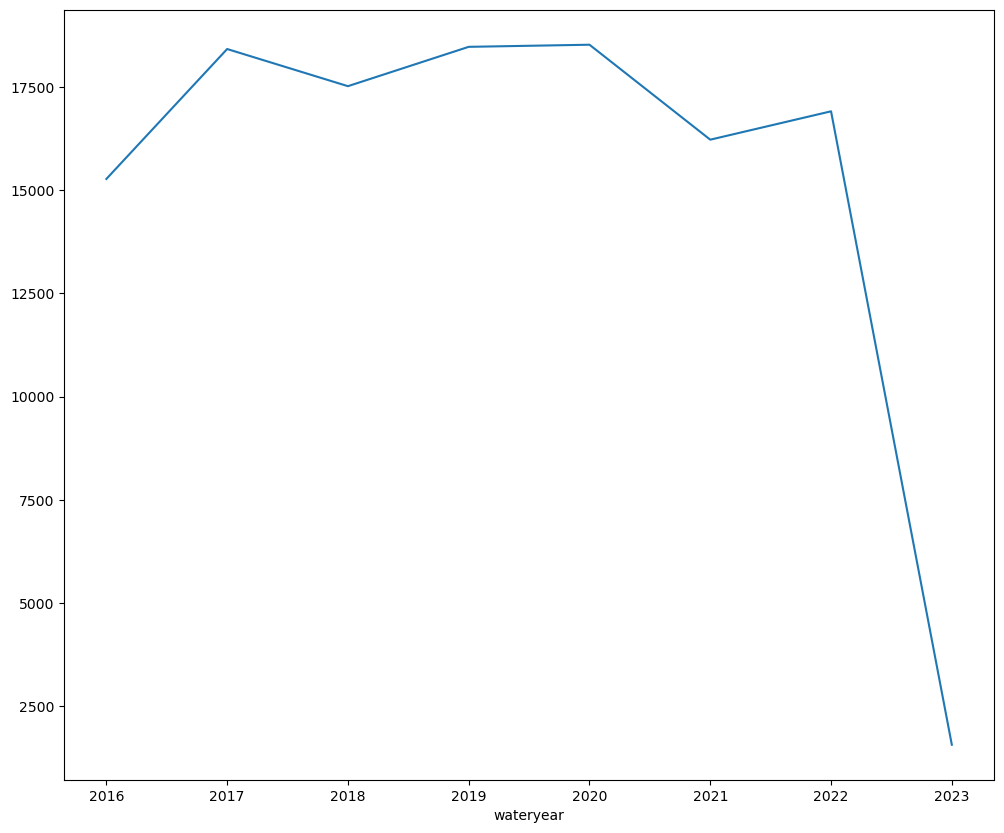

In [93]:
oet_sorted.groupby('wateryear').sum(numeric_only=True)['openet_aet_acft'].plot()

## GPM 

<th class="mdl-data-table__cell--non-numeric"> Description </th> <th> Units </th> </tr></thead><tbody><tr><td class="mdl-data-table__cell--non-numeric"> gaugeRelativeWeighting </td><td class="mdl-data-table__cell--non-numeric"> Weighting of gauge precipitation relative to the multi-satellite precipitation </td><td> % </td></tr><tr><td class="mdl-data-table__cell--non-numeric"> precipitation </td><td class="mdl-data-table__cell--non-numeric"> Merged satellite-gauge precipitation estimate </td><td> mm/hr </td>


In [96]:
gpm = pd.read_csv(raw_dir / "MonthlyGPMPPT.csv")

gpm['date'] =pd.to_datetime( gpm['date'], format='%Y%m%d%f')
gpm['hucname'] = gpm['site']
gpm['ppt in per mo'] = gpm['date'].dt.daysinmonth * 24 * gpm['precipitation'] * 0.0393701
gpm['gpm_ppt_acft'] = gpm['area'] * 0.000247105 * 0.0833333 * gpm['ppt in per mo'] # area * cube m to acres * in to feet * precip
gpm['wateryear'] = gpm.reset_index().set_index('date').index.shift(-9,freq='M').year+1

gpm_sorted = gpm.reset_index().set_index(['hucname','date']).sort_index()
gpm_sorted['gpm_ppt_acft'].to_csv(save_place / "gpm_monthly_hydrodiv.csv")
gpm_sorted.to_parquet(save_place / "gpm_monthly_hydrodiv.parquet")
#gpm_sorted.loc[14].resample('1D').asfreq()



<Axes: xlabel='wateryear'>

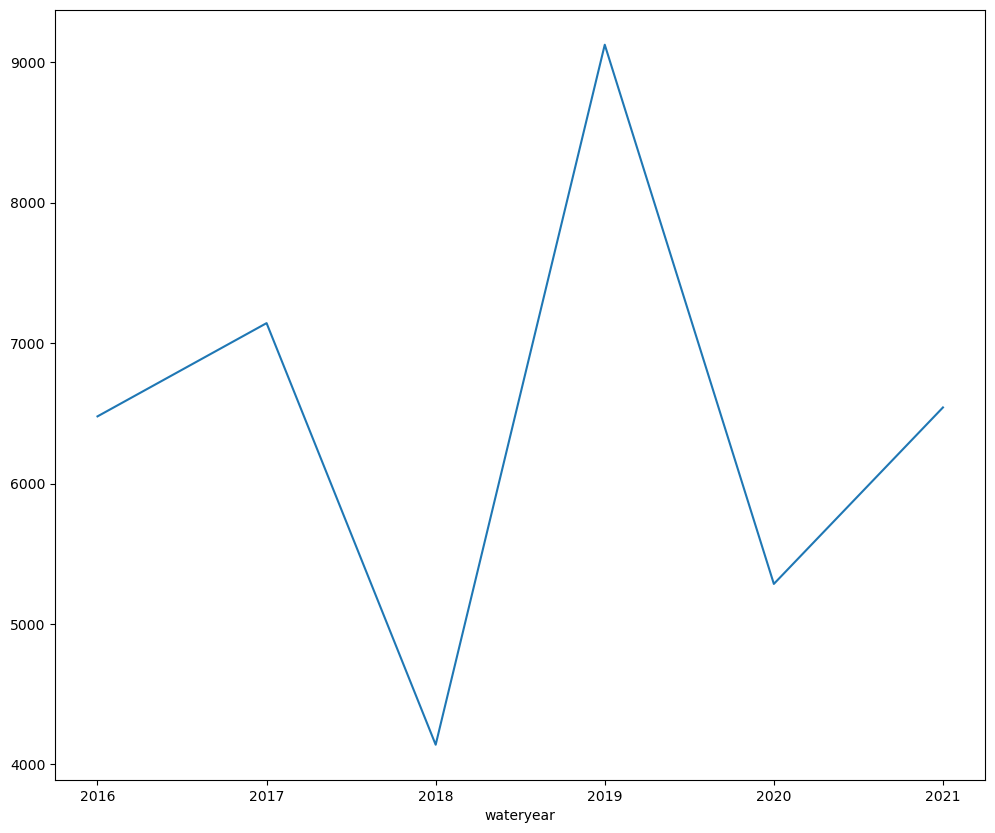

In [97]:
gpm_sorted.groupby('wateryear').sum(numeric_only=True)['gpm_ppt_acft'].plot()

## PRISM

https://developers.google.com/earth-engine/datasets/catalog/OREGONSTATE_PRISM_AN81m?hl=en

<section tab="bands" role="tabpanel" aria-labelledby="aria-tab-bands" tabindex="0" id="tabpanel-bands" active="">

<p>
<b>Resolution</b>
<br>2.5 arc minutes (~4640 m depending on latitude)
</p>
<p><b>Bands</b>
</p><div class="devsite-table-wrapper"><table class="eecat">
<tbody><tr>
<th scope="col">Name</th>
<th scope="col">Units</th>
<th scope="col">Min</th>
<th scope="col">Max</th>
<th scope="col">Description</th>
</tr>
<tr>
<td><code translate="no" dir="ltr">ppt</code></td>
<td>mm</td>
<td>
          0*
</td>
<td>
          2639.82*
</td>
<td><p>Monthly total precipitation (including rain and melted snow)</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">tmean</code></td>
<td>°C</td>
<td>
          -30.8*
</td>
<td>
          41.49*
</td>
<td><p>Monthly average of daily mean temperature (calculated as (tmin+tmax)/2)</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">tmin</code></td>
<td>°C</td>
<td>
          -35.11*
</td>
<td>
          34.72*
</td>
<td><p>Monthly minimum temperature</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">tmax</code></td>
<td>°C</td>
<td>
          -29.8*
</td>
<td>
          49.74*
</td>
<td><p>Monthly average of daily maximum temperature</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">tdmean</code></td>
<td>°C</td>
<td>
          -30.7*
</td>
<td>
          26.76*
</td>
<td><p>Monthly average of daily mean dew point temperature</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">vpdmin</code></td>
<td>hPa</td>
<td>
          0*
</td>
<td>
          44.79*
</td>
<td><p>Monthly average of daily minimum vapor pressure deficit</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">vpdmax</code></td>
<td>hPa</td>
<td>
          0.009*
</td>
<td>
          110.06*
</td>
<td><p>Monthly average of daily maximum vapor pressure deficit</p></td>
</tr>
</tbody></table></div>
  * estimated min or max value
</section>

In [110]:
# import GEE output
prism_mean = pd.read_csv(raw_dir / "DailyPRISM_PPT.csv")
# convert ppt field to acre-feet 
prism_mean["prism_ppt_volume_af"] = prism_mean['ppt']*prism_mean['area']*0.001*0.000810714

# parse date field to date-times
prism_mean['date'] = pd.to_datetime(prism_mean['system:index'].str.split("_",expand=True)[1],format="%Y%m%d")

prism_mean_mo = prism_mean.groupby(['site',pd.Grouper(key='date',freq='1MS')]).sum()

# calculate water year for each datetime (water year starts Oct 1)
prism_mean['wateryear'] = prism_mean.set_index('date').index.shift(-9,freq='M').year+1
# calculate inches of water for each area
prism_mean["prism_ppt_in"] = prism_mean['ppt']*0.0393701

prism_mean['hucname'] = prism_mean['site']

# this makes a dataframe that is grouped by areas and by water year
prism_mean_wy = prism_mean.groupby(['hucname','wateryear']).sum(numeric_only=True) #["prism_ppt_volume_af"] 

# this makes a dataframe that is grouped by areas and by month
prism_abb= prism_mean.groupby(['hucname',
                    pd.Grouper(key='date',
                               freq='1MS',
                               closed='right',
                               label='left')]).mean(numeric_only=True)['prism_ppt_volume_af'].to_frame().rename(columns={'prism_ppt_volume_af':'prism_ppt_acft'})

# export one of the grouped dataframes to csv 
prism_abb.to_csv(save_place / "prism_mo_hydrodiv.csv")

# group all data by water year to get total precip of study area by water year
priswy = prism_mean.groupby(['hucname','wateryear']).sum(numeric_only=True)

priswy.to_csv(save_place / "prism_wy.csv")
priswy.to_parquet(save_place / "prism_wy.parquet")


<Axes: xlabel='date'>

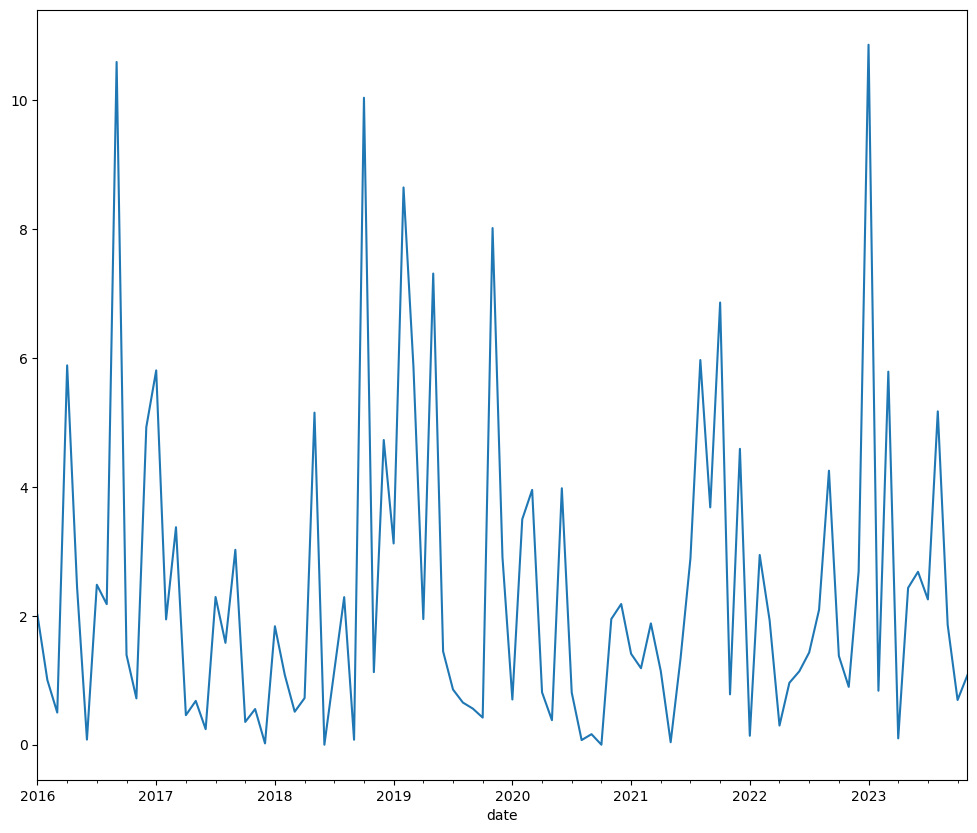

In [112]:
prism_mean_mo.loc[2,'prism_ppt_volume_af'].plot()

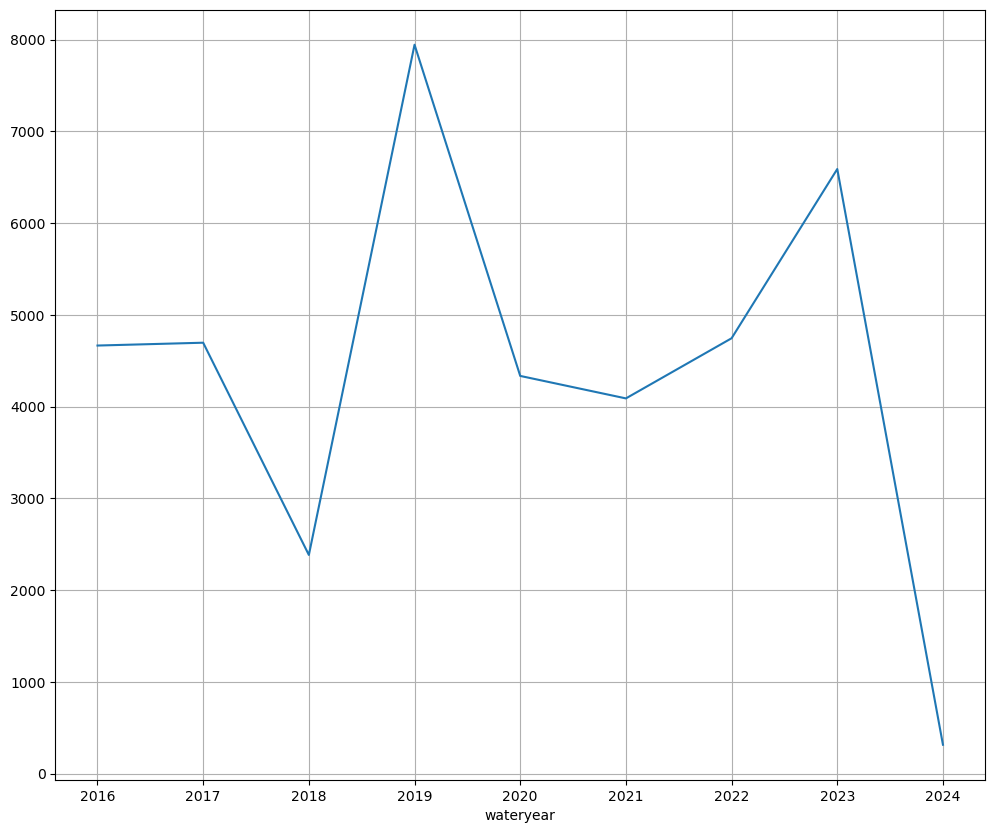

In [113]:
priswy = prism_mean.groupby(['wateryear']).sum(numeric_only=True)
priswy["prism_ppt_volume_af"].plot()
plt.grid()

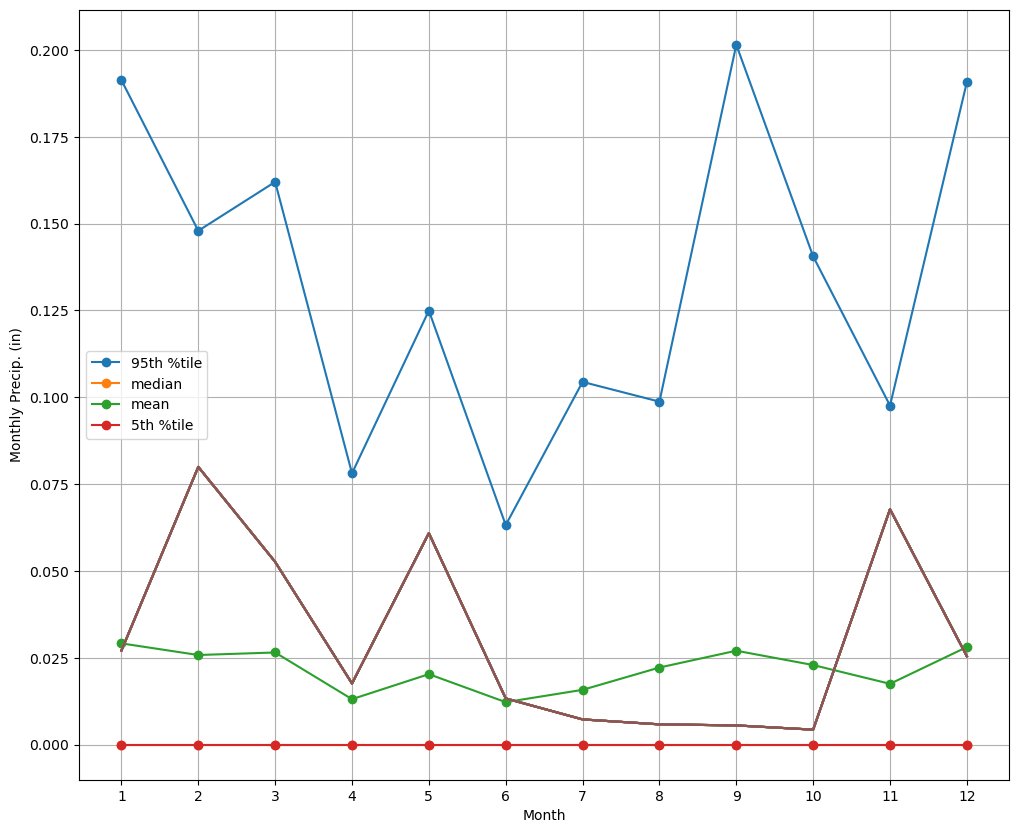

In [114]:
matplotlib.rc_file_defaults()
rcParams['figure.figsize'] = 12, 10
rcParams['pdf.fonttype'] = 42
inline_rc = dict(plt.rcParams)

def f(x):
    d = {}
    fld = 'prism_ppt_in'
    #fld = 'prism_ppt_volume_af'
    d['95th %tile'] = x[fld].quantile(0.95)
    d['median'] = x[fld].median()
    d['mean'] = x[fld].mean()
    d['5th %tile'] = x[fld].quantile(0.05)
    return pd.Series(d, index=['95th %tile', 'median', 'mean', '5th %tile'])


def g(x):
    d = {}
    fld = 'prism_ppt_in'
    d['mean'] = x[fld].mean()
    d['wateryear'] = x['wateryear'].min()
    return pd.Series(d, index=['mean','wateryear'])



prism_mean['month'] = prism_mean.reset_index().set_index('date').index.month
prism_mo = prism_mean.groupby('month').apply(f).plot(marker='o')
prism_moly = prism_mean.reset_index().set_index('date').groupby(pd.Grouper(freq='1M')).apply(g)
for year in prism_moly.index.year:
    if year in(1983,2011,2019):
        plt.plot(prism_moly[prism_moly.index.year==year].sort_index().index.month, 
                 prism_moly[prism_moly.index.year==year].sort_index()['mean'])

plt.ylabel('Monthly Precip. (in)')
plt.xlabel('Month')
plt.xticks(range(1,13))
plt.grid()

## SMAP

https://developers.google.com/earth-engine/datasets/catalog/NASA_USDA_HSL_SMAP10KM_soil_moisture

This dataset is being superseded by SPL4SMGP.007

The NASA-USDA Enhanced SMAP Global soil moisture data provides soil moisture information across the globe at 10-km spatial resolution. This dataset includes: surface and subsurface soil moisture (mm), soil moisture profile (%), surface and subsurface soil moisture anomalies (-).

The dataset is generated by integrating satellite-derived Soil Moisture Active Passive (SMAP) Level 3 soil moisture observations into the modified two-layer Palmer model using a 1-D Ensemble Kalman Filter (EnKF) data assimilation approach. Soil moisture anomalies were computed from the climatology of the day of interest. The climatology was estimated based on the full data record of the SMAP satellite observation and the 31-day-centered moving-window approach. The assimilation of the SMAP soil moisture observations help improve the model-based soil moisture predictions particularly over poorly instrumented areas of the world that lack good quality precipitation data.

This dataset was developed by the Hydrological Science Laboratory at NASA's Goddard Space Flight Center in cooperation with USDA Foreign Agricultural Services and USDA Hydrology and Remote Sensing Lab.


<thead><tr><th class="mdl-data-table__cell--non-numeric"> Name </th><th class="mdl-data-table__cell--non-numeric"> Description </th><th> Min* </th><th> Max* </th> <th> Units </th> </tr></thead><tbody><tr><td class="mdl-data-table__cell--non-numeric"> ssm </td><td class="mdl-data-table__cell--non-numeric"> Surface soil moisture </td><td> 0 </td><td> 25.39 </td><td> mm </td></tr><tr><td class="mdl-data-table__cell--non-numeric"> susm </td><td class="mdl-data-table__cell--non-numeric"> Subsurface soil moisture </td><td> 0 </td><td> 274.6 </td><td> mm </td></tr><tr><td class="mdl-data-table__cell--non-numeric"> smp </td><td class="mdl-data-table__cell--non-numeric"> Soil moisture profile </td><td> 0 </td><td> 1 </td><td> fraction </td></tr><tr><td class="mdl-data-table__cell--non-numeric"> ssma </td><td class="mdl-data-table__cell--non-numeric"> Surface soil moisture anomaly </td><td> -4 </td><td> 4 </td><td> - </td></tr><tr><td class="mdl-data-table__cell--non-numeric"> susma </td><td class="mdl-data-table__cell--non-numeric"> Subsurface soil moisture anomaly </td><td> -4 </td><td> 4 </td><td> - </td></tr></tbody>

In [121]:
smap = pd.read_csv(raw_dir / "MonthlySMAP.csv")
smap['date'] = smap['date'].str[-8:]

smap['date'] =pd.to_datetime(smap['system:index'].str.split("_",expand=True)[5], format='%Y%m%d')

smap['hucname'] = smap['site']

smap = smap[['area','hucname','SubsurfaceSM','SurfaceSM','date']].set_index(['hucname','date'])
#smap = smap.drop(['system:index','.geo'],axis=1)
smap['SubsurfaceSM_acft'] = smap['SubsurfaceSM']*smap['area']*0.001*0.000810714
smap['SurfaceSM_acft'] = smap['SurfaceSM']*smap['area']*0.001*0.000810714

In [122]:

smap_abb = smap.reset_index().groupby(['hucname',pd.Grouper(key='date', freq="MS")])[['SubsurfaceSM_acft',
                                                                          'SurfaceSM_acft']].mean(numeric_only=True)

smap_abb.to_csv(save_place / "smap_mo_hydrodiv.csv")

smap_abb

SubsurfaceSM_acft  SurfaceSM_acft
hucname date                                         
2       2015-04-01           1.574184        0.501541
        2015-05-01           2.756509        0.842204
        2015-06-01           2.548982        0.714412
        2015-07-01           1.780565        0.574932
        2015-08-01           1.457131        0.448027
...                               ...             ...
243     2022-04-01           0.158944        0.044182
        2022-05-01           0.070615        0.020311
        2022-06-01           0.062350        0.018399
        2022-07-01           0.065481        0.019476
        2022-08-01           0.060923        0.018941

[21004 rows x 2 columns]

<Axes: xlabel='date'>

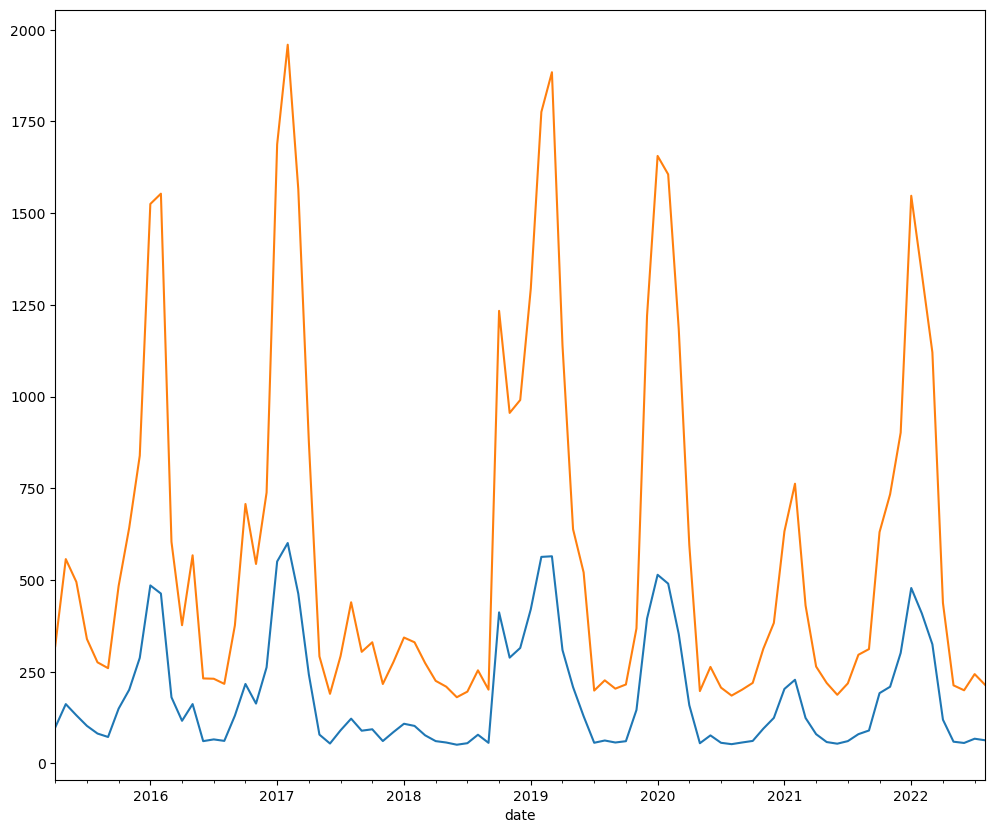

In [123]:
smap_abb.groupby(level=1).sum()['SurfaceSM_acft'].plot()
smap_abb.groupby(level=1).sum()['SubsurfaceSM_acft'].plot()


# Combine Data

## Read in stored datasets

In [54]:
pmlmo = pd.read_csv(save_place / "pml_mo.csv", parse_dates=True,
                    index_col=['hucname','date'],date_format='%Y-%m-%d').sort_index()
terra_mo = pd.read_csv(save_place / "terra_mo_hydrodiv.csv",  parse_dates=True,
                       index_col=['hucname','date'],date_format='%Y-%m-%d').sort_index()
daymetmo = pd.read_csv(save_place / "daymet_mo_hydrodiv.csv",  parse_dates=True,
                       index_col=['hucname','date'],date_format='%Y-%m-%d').sort_index()
oet_sorted = pd.read_csv(save_place / "openet_hydrodiv.csv", parse_dates=True, 
                         index_col=['hucname','date'],date_format='%Y-%m-%d').sort_index()
gpm_sorted = pd.read_csv(save_place / "gpm_monthly_hydrodiv.csv",  parse_dates=True,
                         index_col=['hucname','date'],date_format='%Y-%m-%d').sort_index()
prism_abb = pd.read_csv(save_place / "prism_mo_hydrodiv.csv", parse_dates=True, 
                        index_col=['hucname','date'],date_format='%Y-%m-%d').sort_index()
smap_abb = pd.read_csv(save_place / "smap_mo_hydrodiv.csv",  parse_dates=True,
                       index_col=['hucname','date'],date_format='%Y-%m-%d').sort_index()

datamo = pd.read_csv(save_place / "monthly_openet_query_data.csv",parse_dates=True,
                       index_col=['ID','time'],date_format='%Y-%m-%d')
datamo.index = datamo.index.rename(['hucname','date'])


## Combine datasets and subset to a good time of overlap.

In [68]:
compiled = pd.concat([pmlmo,
                      terra_mo,
                      daymetmo,
                      oet_sorted,
                      gpm_sorted,
                      prism_abb,
                      smap_abb, 
                      datamo
                     ],sort=True,axis=1)

for col in compiled.columns:
    if 'acft' in col:
        new_col = col[:-5]
    else:
        new_col = col

    if col == 'SubsurfaceSM':
        new_col = 'smap_soil'
    #print(new_col)
    compiled = compiled.rename(columns={col:new_col})
    
compiled = compiled.query("date > '2016-01-01' and date <= '2022-12-31'")

compiled.index = compiled.index.rename(['ID','datetime'])

compiled = compiled.replace(0,np.nan)

compiled['terra_soil_diff'] = compiled['terra_soil'].diff()

## Calculate effective precipitation using the equation.

In [ ]:
The effect sizes, sampling distribution, and 95% confidence intervals are plotted on a separate axes beneath the raw data. For each group, summary measurements (mean ± standard deviation) are drawn as gapped lines.

In [ ]:
if sm1 - sm2 < 0 then soil dries
if sm1 - sm2 > 0 then soil moistens



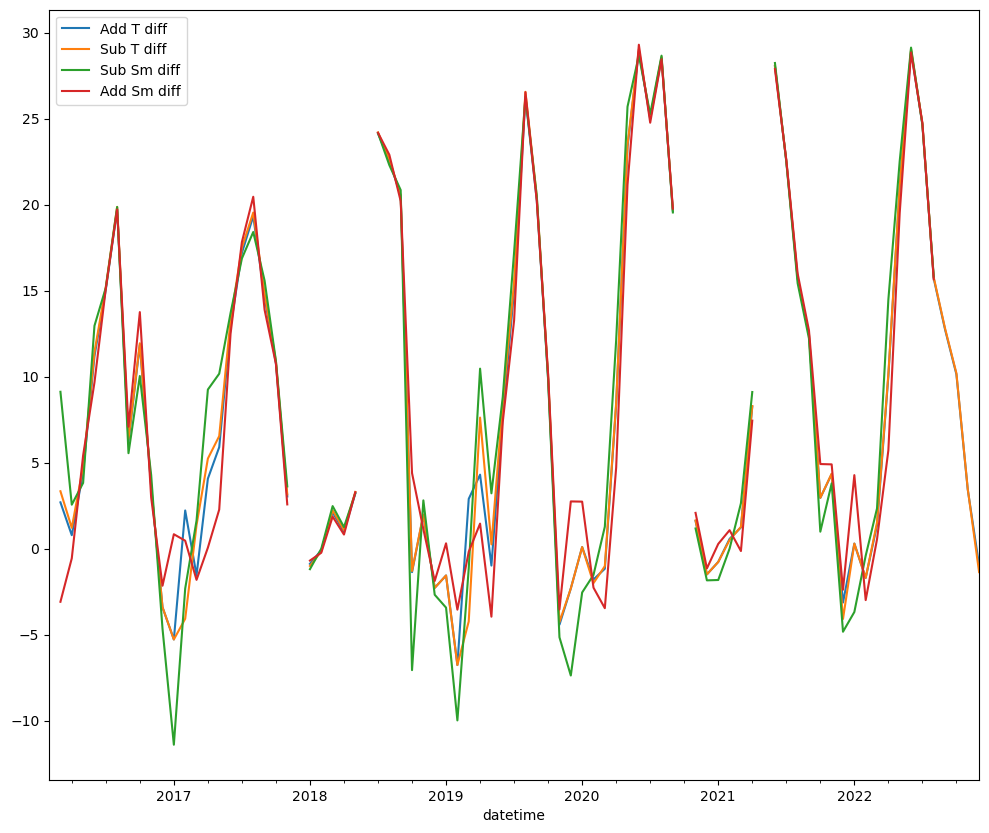

In [67]:

df = compiled.loc[2]

df = df[df.index.month.isin([3,4,5,6,7,8,9,10]).groupby(df.index.year).sum()
(df['eem_et'] - df['ens_pr'] + df['terra_soil'].diff()).plot(label='Add T diff')
(df['eem_et'] - df['ens_pr'] - df['terra_soil'].diff()).plot(label='Sub T diff')
(df['eem_et'] - df['ens_pr'] - df['SubsurfaceSM'].diff()).plot(label='Sub Sm diff')
(df['eem_et'] - df['ens_pr'] + df['SubsurfaceSM'].diff()).plot(label='Add Sm diff')
#compiled['terra_soil'].diff().loc[2].plot()
plt.legend()

In [69]:
D = compiled['SubsurfaceSM']/compiled['acres']*12.0
SF = (0.531747 + 0.295164 * D - 0.057697*D**2 + 0.003804*D**3)
ETc = compiled['ens_et']/compiled['acres']*12.0
Ptotal = compiled['ens_pr']/compiled['acres']*12.0
compiled['Peff'] = SF * (0.70917*Ptotal**0.82416 - 0.11556)*(10**(0.02426*ETc)) * compiled['acres'] / 12.0

compiled['eem_et'] - compiled['ens_pr'] - compiled['terra_soil'].diff()

#compiled.to_csv(save_place / "all_data_monthly_w_eff_prcp.csv")

ID   datetime  
2    2016-02-01          NaN
     2016-03-01     3.333041
     2016-04-01     1.207170
     2016-05-01     4.769370
     2016-06-01    11.428770
                     ...    
243  2022-08-01     0.721191
     2022-09-01     0.506685
     2022-10-01     0.267029
     2022-11-01     0.091387
     2022-12-01    -0.171989
Length: 19588, dtype: float64

Subset for irrigation months. Combine data into a yearly value.

In [70]:
def grpirrmo(x):
    """function to be applied to groupby technique on hucs and SEEBOP data"""
    d = {}
    for col in x:
        if col == 'SubsurfaceSM' or col == 'SurfaceSM':
            d[col] = x[col].max()
        elif col == 'sensor' or col == 'year':
            pass
        else:
            d[col] = x[col].sum()
    
    return pd.Series(d,index=list(d.keys()))

all_data_irr_months = compiled[compiled.index.get_level_values(1).month.isin([3,4,5,6,7,8,9,10])]
all_data_irr_months['year'] = all_data_irr_months.index.get_level_values(1).year

all_data_irr_years = all_data_irr_months.groupby(['sensor','year']).apply(grpirrmo)
#all_data_irr_years = all_data_irr_months.groupby(['sensor','year']).sum(numeric_only=True)

all_data_irr_years = all_data_irr_years.replace(0,np.nan)

meter_read = pd.read_excel(main_path / 'IRR_totals.xlsx')
#meter_read['sensor-year'] = meter_read[['sensor','year']].apply(lambda x: f"{x[0]}_{x[1]}",1)
meter_read= meter_read.set_index(['sensor','year']).sort_index()
meter_read

all_w_meter = pd.merge(all_data_irr_years,meter_read, left_index=True, right_index=True,copy=True)#how='outer'

all_w_meter['eem_eet'] = all_w_meter['eem_et'] - all_w_meter['ens_pr']
all_w_meter['sse_eet'] = all_w_meter['sse_et'] - all_w_meter['ens_pr']
all_w_meter['ens_eet'] = all_w_meter['ens_et'] - all_w_meter['ens_pr']


all_w_meter['ens_residual'] =  all_w_meter['total_acft'] - all_w_meter['ens_eet']
all_w_meter['eem_residual'] =  all_w_meter['total_acft'] - all_w_meter['eem_eet']
all_w_meter['sse_residual'] =  all_w_meter['total_acft'] - all_w_meter['eem_eet']

all_w_meter['ens_res_norm'] = all_w_meter['ens_residual'] / all_w_meter['acres']
all_w_meter['eem_res_norm'] = all_w_meter['eem_residual'] / all_w_meter['acres']

all_w_meter['ens_rsid_o_div'] = (all_w_meter['ens_residual'] /  all_w_meter['total_acft'])*100
all_w_meter['eem_rsid_o_div'] = (all_w_meter['eem_residual'] /  all_w_meter['total_acft'])*100

C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_21128\2649824336.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_irr_months['year'] = all_data_irr_months.index.get_level_values(1).year


<Axes: xlabel='year'>

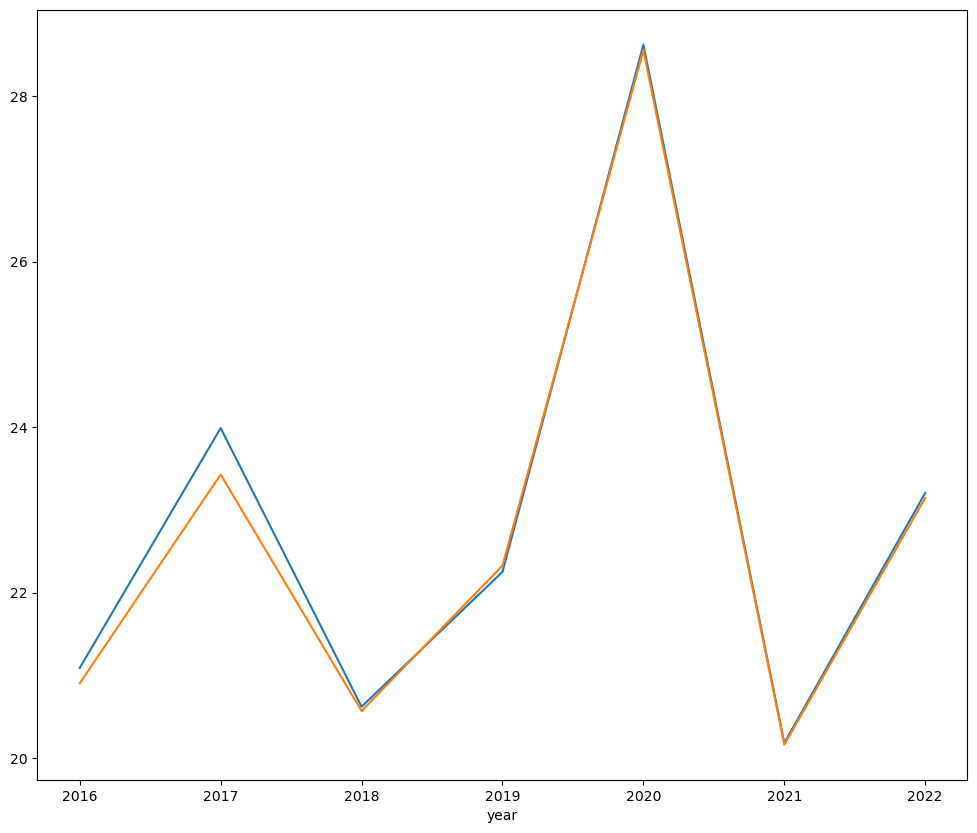

In [74]:
all_w_meter['eem_eet_sm'] = all_w_meter['eem_eet'] - all_w_meter['terra_soil_diff']
all_w_meter.loc['BC1','eem_eet_sm'].plot()
all_w_meter.loc['BC1','eem_eet'].plot()

Export to GIS format

In [20]:
pou = gpd.read_file(ecdb, driver='FileGDB', layer='Placeofuse')
pou_meter = pou.dissolve(by='Meternumber').drop(['Shape_Length', 'Shape_Area','Acreage','ID'],axis=1)
all_data_irr_yr_gis = pd.merge(pou_meter.reset_index(),all_w_meter.reset_index(),
                               right_on='sensor',left_on='Meternumber')
all_data_irr_yr_gis = all_data_irr_yr_gis.reset_index().set_index('sensor')
#.to_file(gis_path / 'POU_w_data_all_irr_yr_ind3.shp')
all_data_irr_yr_gis['comment'] = all_data_irr_yr_gis['comment'].astype(str)

In [21]:
#all_data_irr_yr_gis.to_file(gis_path / 'POU_w_data_all_irr_yr_ind8.shp')

C:\Users\pauli\AppData\Local\Temp\ipykernel_8804\3313665938.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  all_data_irr_yr_gis.to_file(gis_path / 'POU_w_data_all_irr_yr_ind8.shp')


In [22]:
all_data_irr_yr_gis.drop(['comment'],axis=1).reset_index().to_file(gis_path / 'POU_w_data_all_irr_yr.gpkg', driver="GPKG")

In [23]:
outl_out = all_data_irr_yr_gis[(all_data_irr_yr_gis['ens_eet'] > 0)&(all_data_irr_yr_gis['total_acft'] > 0.5)&(all_data_irr_yr_gis['ens_residual'].abs() < 500)]

In [24]:
uniform = all_data_irr_yr_gis[all_data_irr_yr_gis['fld_comnt']=='uniform']#[all_data_irr_yr_gis['ens_residual'].abs() > 500]

In [25]:
uniform.columns

Index(['index', 'Meternumber', 'geometry', 'irr_area', 'fld_comnt',
       'ft_from_crk', 'ft_city_service', 'SoilClass', 'AWC', 'avg_elev',
       'irr_type', 'year', 'PML_Soil_Evap', 'PML_Veg_Trans',
       'PML_Veg_Intercept', 'pml_aet', 'terra_aet', 'terra_def', 'terra_ppt',
       'terra_ro', 'terra_soil', 'terra_swe', 'daymet_ppt', 'daymet_swe',
       'openet_aet', 'gpm_ppt', 'prism_ppt', 'SubsurfaceSM', 'SurfaceSM',
       'sse_et', 'ens_etof', 'ens_eto', 'ens_et', 'ens_pr', 'eem_et', 'acres',
       'Peff', 'total_acft', 'page_num', 'comment', 'eem_eet', 'sse_eet',
       'ens_eet', 'ens_residual', 'eem_residual', 'sse_residual',
       'ens_res_norm', 'eem_res_norm', 'ens_rsid_o_div', 'eem_rsid_o_div'],
      dtype='object')

C:\Users\pauli\anaconda3\envs\pygis311\Lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


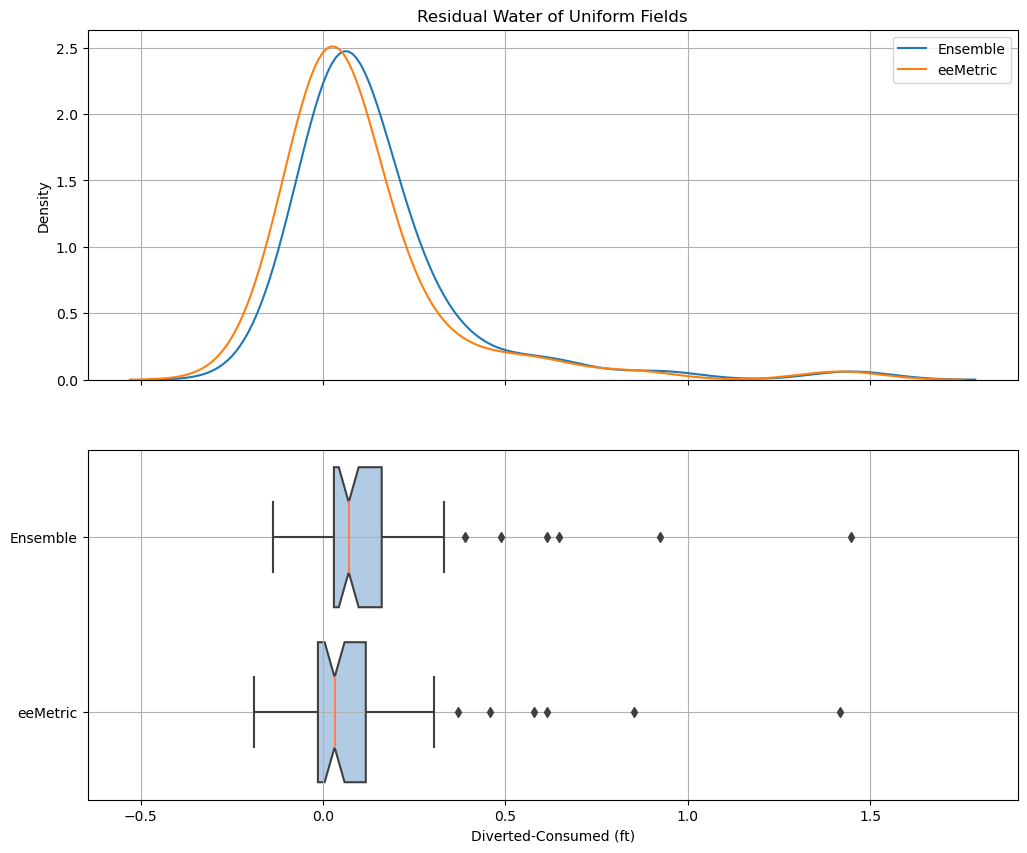

In [26]:
fig, ax = plt.subplots(2,1,sharex=True)

disdata = uniform.reset_index().set_index(['index'])

sns.kdeplot(data = disdata , x='ens_res_norm',ax=ax[0],label='Ensemble')

sns.kdeplot(data = disdata, x='eem_res_norm',ax=ax[0],label='eeMetric')

sns.boxplot(data = disdata[['ens_res_norm','eem_res_norm']].rename(columns={'ens_res_norm':'Ensemble',
                                                                             'eem_res_norm':'eeMetric'}), 
            orient='h',notch=True,    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
 )
ax[0].legend()
plt.xlabel("Diverted-Consumed (ft)")
ax[0].grid()
ax[1].grid()
ax[0].set_title("Residual Water of Uniform Fields")
plt.savefig(figure_dir / "uniform_residual_norm_distributions.png")
plt.savefig(figure_dir / "uniform_residual_norm_distributions.pdf")

C:\Users\pauli\anaconda3\envs\pygis311\Lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


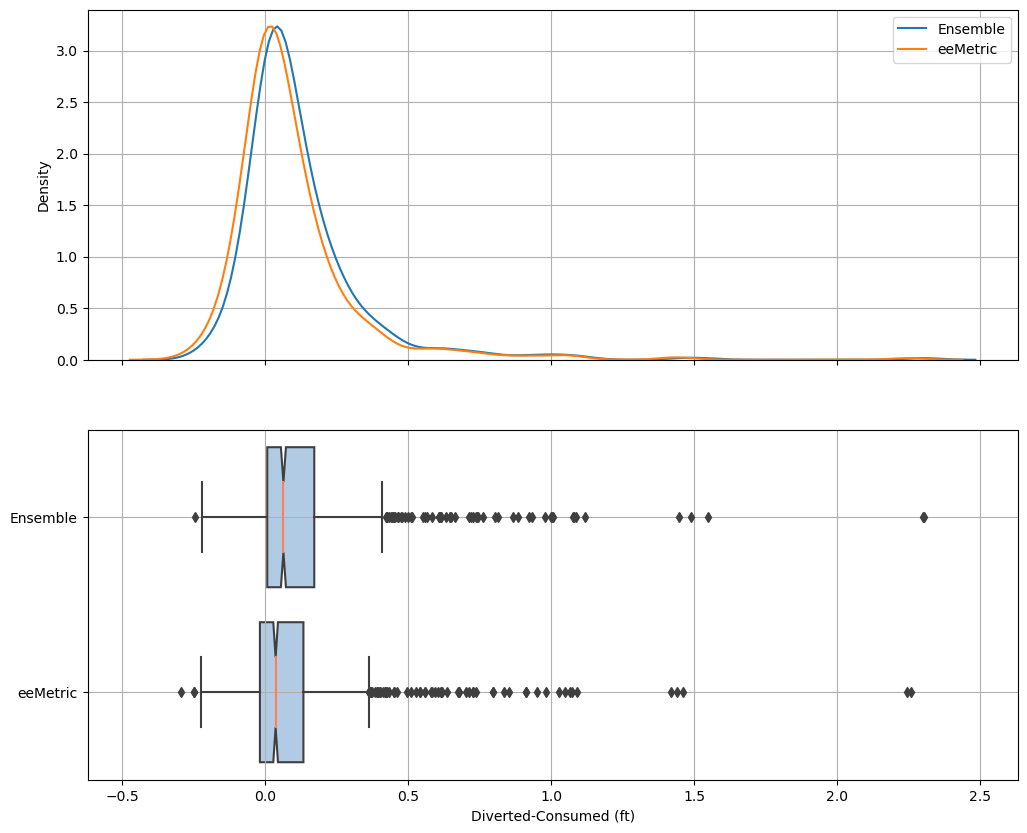

In [27]:
fig, ax = plt.subplots(2,1,sharex=True)

outldis = outl_out.reset_index().set_index(['index'])

sns.kdeplot(data = outldis, x='ens_res_norm',ax=ax[0],label='Ensemble')

sns.kdeplot(data = outldis, x='eem_res_norm',ax=ax[0],label='eeMetric')

sns.boxplot(data = outldis[['ens_res_norm','eem_res_norm']].rename(columns={'ens_res_norm':'Ensemble',
                                                                             'eem_res_norm':'eeMetric'}), 
            orient='h',notch=True,    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
 )
ax[0].legend()
plt.xlabel("Diverted-Consumed (ft)")
ax[0].grid()
ax[1].grid()
plt.savefig(figure_dir / "residual_norm_distributions.png")
plt.savefig(figure_dir / "residual_norm_distributions.pdf")

C:\Users\pauli\anaconda3\envs\pygis311\Lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


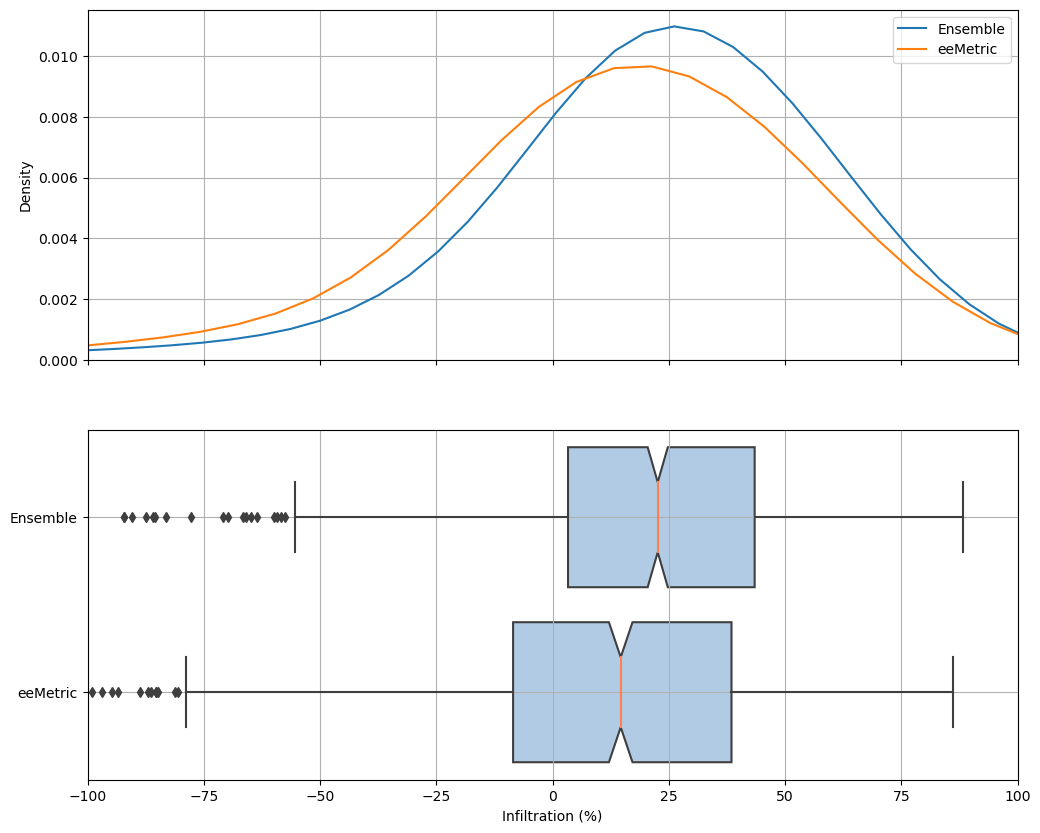

In [28]:
fig, ax = plt.subplots(2,1,sharex=True)

outldis = outl_out.reset_index().set_index(['index'])

sns.kdeplot(data = outldis, x='ens_rsid_o_div',ax=ax[0],label='Ensemble')

sns.kdeplot(data = outldis, x='eem_rsid_o_div',ax=ax[0],label='eeMetric')

sns.boxplot(data = outldis[['ens_rsid_o_div','eem_rsid_o_div']].rename(columns={'ens_rsid_o_div':'Ensemble',
                                                                             'eem_rsid_o_div':'eeMetric'}), 
            orient='h',notch=True,    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
 )
ax[0].legend()
ax[1].set_xlabel("Infiltration (%)")
ax[0].grid()
ax[1].grid()
ax[1].set_xlim(-100,100)
plt.savefig(figure_dir / "residual_infil_distributions.png")
plt.savefig(figure_dir / "residual_infil_distributions.pdf")

In [29]:
outl_out[['ens_rsid_o_div','eem_rsid_o_div']].describe().round(0)

ens_rsid_o_div  eem_rsid_o_div
count           846.0           846.0
mean             11.0             1.0
std              75.0            83.0
min           -1058.0         -1208.0
25%               3.0            -8.0
50%              23.0            15.0
75%              43.0            38.0
max              88.0           272.0

In [30]:
outl_out[['ens_res_norm','eem_res_norm']].describe().round(2)#.to_clipboard()

ens_res_norm  eem_res_norm
count        846.00        846.00
mean           0.12          0.09
std            0.23          0.23
min           -0.25         -0.30
25%            0.01         -0.02
50%            0.06          0.04
75%            0.17          0.13
max            2.30          2.26

C:\Users\pauli\anaconda3\envs\pygis311\Lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


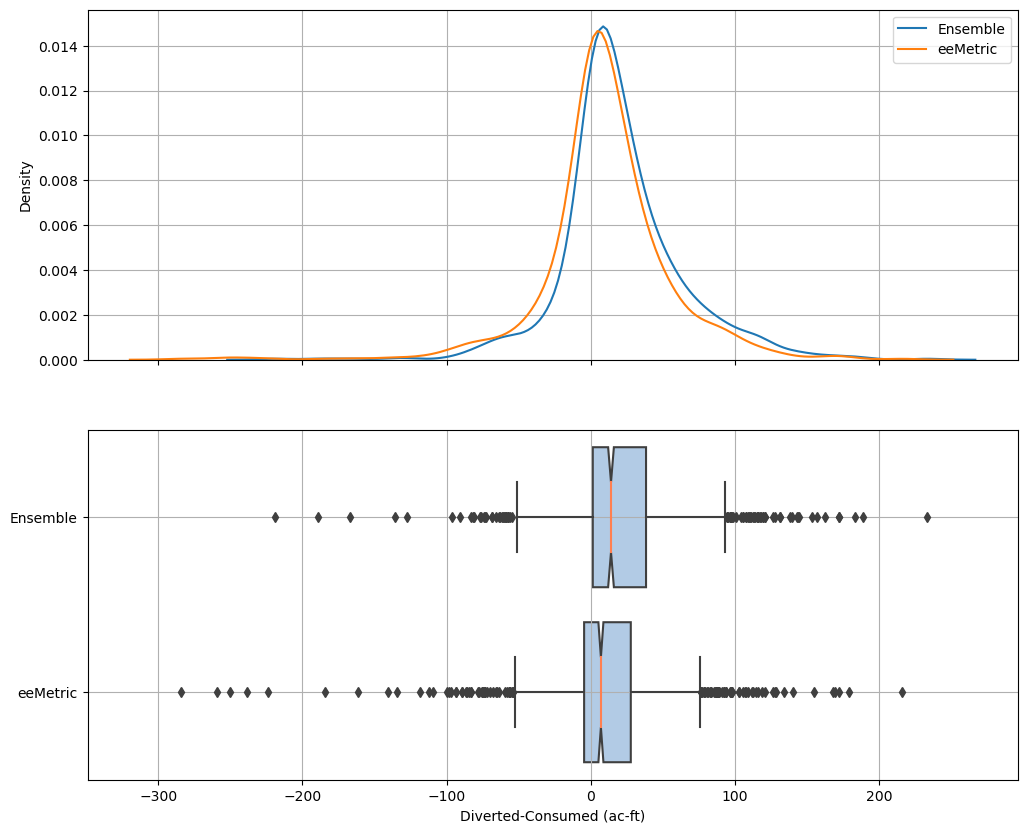

In [31]:
fig, ax = plt.subplots(2,1,sharex=True)

outldis = outl_out.reset_index().set_index(['index'])

sns.kdeplot(data = outldis, x="ens_residual",ax=ax[0],label='Ensemble')

sns.kdeplot(data = outldis, x="eem_residual",ax=ax[0],label='eeMetric')

sns.boxplot(data = outldis[["ens_residual","eem_residual"]].rename(columns={"ens_residual":'Ensemble',
                                                                             "eem_residual":'eeMetric'}), 
            orient='h',notch=True,    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
 )
ax[0].legend()
plt.xlabel("Diverted-Consumed (ac-ft)")
ax[0].grid()
ax[1].grid()
plt.savefig(figure_dir / "residual_distributions.png")
plt.savefig(figure_dir / "residual_distributions.pdf")

In [32]:
outl_out[["ens_residual","eem_residual"]].describe().round(2)

ens_residual  eem_residual
count        846.00        846.00
mean          21.01         10.52
std           42.61         45.58
min         -218.93       -284.13
25%            1.43         -4.57
50%           14.09          7.08
75%           38.38         27.81
max          233.59        216.05

In [33]:
outl_out[outl_out["ens_residual"]<-100]

index Meternumber                                           geometry  \
sensor                                                                         
CW58      440        CW58  POLYGON Z ((-12363516.984 4745430.533 0.000, -...   
LM20      540        LM20  POLYGON Z ((-12354532.489 4757548.857 0.000, -...   
LM20      541        LM20  POLYGON Z ((-12354532.489 4757548.857 0.000, -...   
LM20      543        LM20  POLYGON Z ((-12354532.489 4757548.857 0.000, -...   
MD49      651        MD49  POLYGON Z ((-12352033.848 4748996.644 0.000, -...   

               irr_area                    fld_comnt  ft_from_crk  \
sensor                                                              
CW58    Clipper Western  Receives Supplemental Water    66.046256   
LM20      Lower Mammoth          partially irrigated  9285.594737   
LM20      Lower Mammoth          partially irrigated  9285.594737   
LM20      Lower Mammoth          partially irrigated  9285.594737   
MD49         Mill Ditch  Receives Supplemental Water     0.000000   

        ft_city_service SoilClass    AWC  avg_elev  ...     eem_eet  \
sensor                                              ...               
CW58        5770.688180         C  17.35   5701.92  ...  700.069761   
LM20        1693.966272         B  17.64   5659.92  ...  270.829252   
LM20        1693.966272         B  17.64   5659.92  ...  359.676669   
LM20        1693.966272         B  17.64   5659.92  ...  270.973306   
MD49       18735.973419         C  20.57   5447.47  ...  613.131842   

           sse_eet     ens_eet  ens_residual  eem_residual  sse_residual  \
sensor                                                                     
CW58    417.470289  568.331672   -127.431672   -259.169761   -259.169761   
LM20    170.342278  239.634426   -218.934426   -250.129252   -250.129252   
LM20    279.935176  302.334437   -166.834437   -224.176669   -224.176669   
LM20    169.048567  245.259827   -135.859827   -161.573306   -161.573306   
MD49    481.820949  517.999132   -188.999132   -284.131842   -284.131842   

        ens_res_norm  eem_res_norm  ens_rsid_o_div  eem_rsid_o_div  
sensor                                                              
CW58       -0.050919     -0.103559      -28.902625      -58.781982  
LM20       -0.186944     -0.213581    -1057.654230    -1208.353874  
LM20       -0.142457     -0.191420     -123.125046     -165.444036  
LM20       -0.116008     -0.137965     -124.186314     -147.690407  
MD49       -0.096926     -0.145714      -57.446545      -86.362262  

[5 rows x 50 columns]

In [34]:
all_data_irr_yr_gis[all_data_irr_yr_gis['total_acft'] == 0]['ens_eet']

sensor
BC25     6.494488
CW16    21.632810
CW44    10.589522
CW54    32.687814
CW54    20.207074
CW54    11.925233
CW55    -2.540918
CW55     1.289967
CW55     5.156161
LM38    12.201055
LM53    -4.455090
LM53     2.328545
UM2      1.073383
UM32    41.795437
UM32    53.332597
Name: ens_eet, dtype: float64

0.9705363736437482 -7.4766028649729765
0.9705363736437482 -7.4766028649729765
0.8267287939302822
95.96604582198577
-85.70258811729742


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311\Lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_30356\3538289541.py:47: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(m)


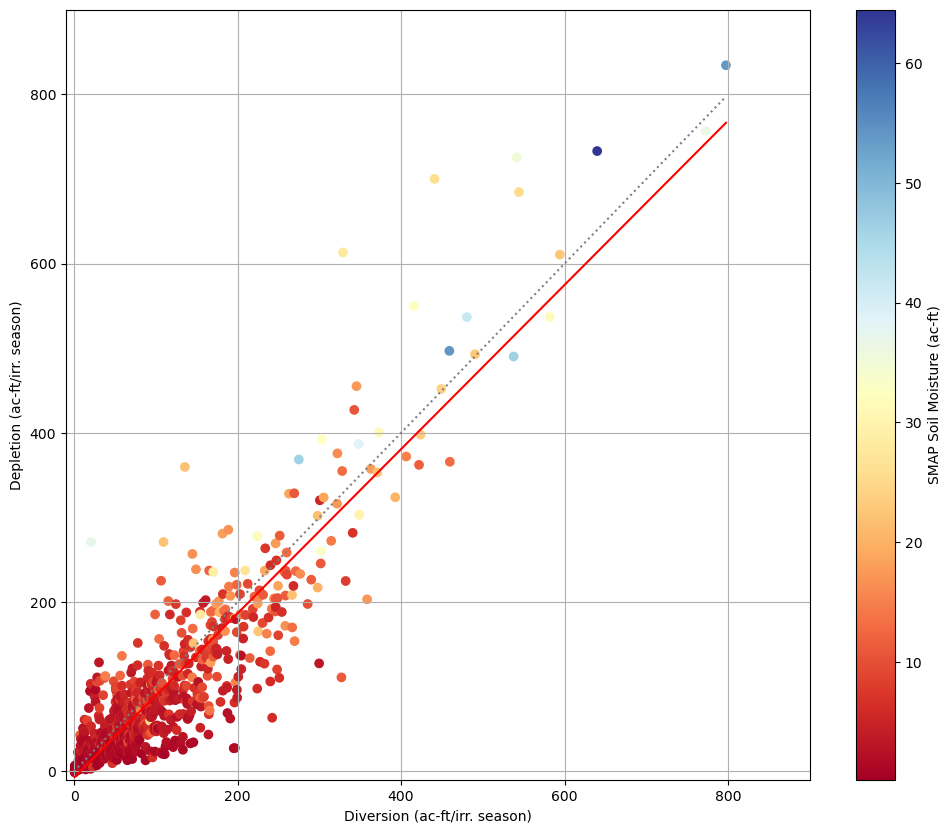

In [47]:
import matplotlib as mpl
import matplotlib.cm as cm

yvar = 'eem_eet'
xvar = 'total_acft'
cvar = 'SubsurfaceSM'

df = outl_out.sort_values(xvar)#.dropna()
#df[xvar] = df[xvar]/df['acres']
#df[yvar] = df[yvar]/df['acres']
#df[cvar] = df[cvar]/df['acres']
#define predictor and response variables
y = df[yvar]
x = df[xvar]

#add constant to predictor variables
X = sm.add_constant(x)

#fit linear regression model
fitlinet = sm.OLS(y, X).fit()
predictionst = fitlinet.get_prediction()

w = df[cvar]
cmap = plt.cm.get_cmap('RdYlBu')
norm = mpl.colors.Normalize(vmin=w.min(), vmax=w.max())
m = cm.ScalarMappable(norm=norm, cmap=cmap)
m.set_array(w)
sc = plt.scatter(x, y, label='', color = m.to_rgba(w))

#plt.scatter(x,y,c=df[cvar])
plt.plot(df[xvar],df[xvar]*fitlinet.params[1] + fitlinet.params[0], label='best fit line',color='red')

mx = int(round(df[xvar].max(),0))
plt.plot(range(0,mx),range(0,mx),color='grey',linestyle=":",label="1:1 line")

print(fitlinet.params[1], fitlinet.params[0])
print(fitlinet.params[1], fitlinet.params[0])
print(fitlinet.rsquared)
print(np.quantile(fitlinet.resid,0.975))
print(np.quantile(fitlinet.resid,0.0275))
outl_out['lin_resid'] = fitlinet.resid.values
plt.grid()
plt.xlabel('Diversion (ac-ft/irr. season)')
plt.ylabel('Depletion (ac-ft/irr. season)')
plt.xlim(-10,900)
plt.ylim(-10,900)
cbar = plt.colorbar(m)

cbar.set_label('SMAP Soil Moisture (ac-ft)')

0.8487437982078732 -5.410784008688676
0.8487437982078732 -5.410784008688676
0.8272984570322316
85.42455225172002
-78.20515349105958


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311\Lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_30356\290514932.py:47: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(m)


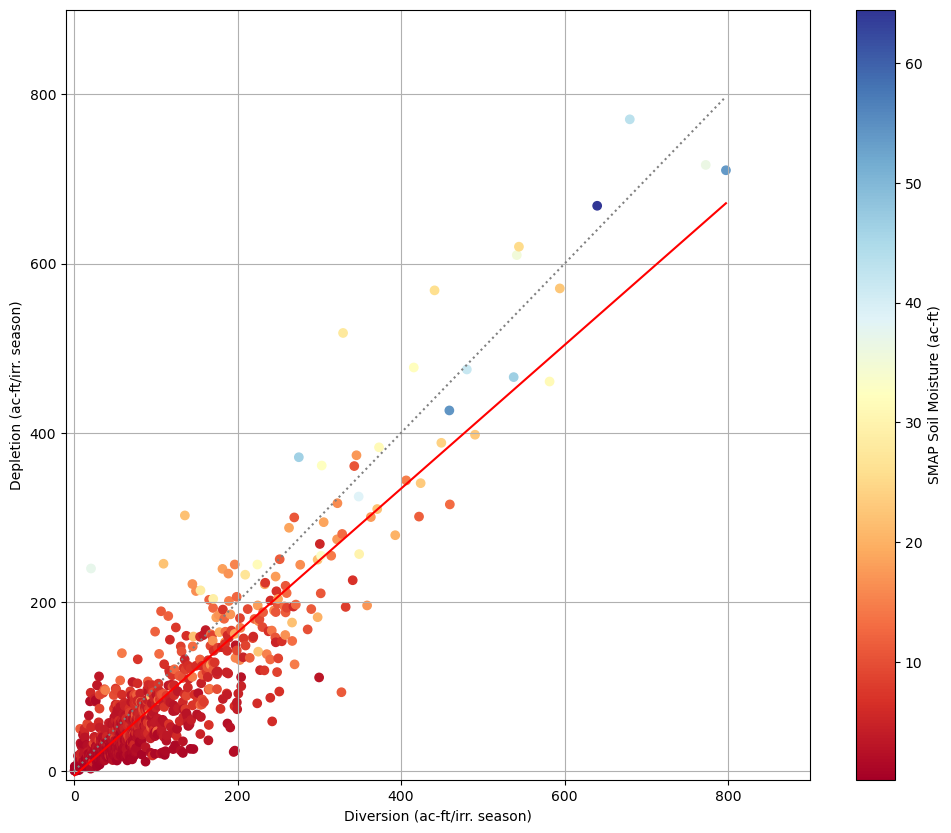

In [48]:
import matplotlib as mpl
import matplotlib.cm as cm

yvar = 'ens_eet'
xvar = 'total_acft'
cvar = 'SubsurfaceSM'

df = outl_out.sort_values(xvar)#.dropna()
#df[xvar] = df[xvar]/df['acres']
#df[yvar] = df[yvar]/df['acres']
#df[cvar] = df[cvar]/df['acres']
#define predictor and response variables
y = df[yvar]
x = df[xvar]

#add constant to predictor variables
X = sm.add_constant(x)

#fit linear regression model
fitlinet = sm.OLS(y, X).fit()
predictionst = fitlinet.get_prediction()

w = df[cvar]
cmap = plt.cm.get_cmap('RdYlBu')
norm = mpl.colors.Normalize(vmin=w.min(), vmax=w.max())
m = cm.ScalarMappable(norm=norm, cmap=cmap)
m.set_array(w)
sc = plt.scatter(x, y, label='', color = m.to_rgba(w))

#plt.scatter(x,y,c=df[cvar])
plt.plot(df[xvar],df[xvar]*fitlinet.params[1] + fitlinet.params[0], label='best fit line',color='red')

mx = int(round(df[xvar].max(),0))
plt.plot(range(0,mx),range(0,mx),color='grey',linestyle=":",label="1:1 line")

print(fitlinet.params[1], fitlinet.params[0])
print(fitlinet.params[1], fitlinet.params[0])
print(fitlinet.rsquared)
print(np.quantile(fitlinet.resid,0.975))
print(np.quantile(fitlinet.resid,0.0275))
outl_out['lin_resid'] = fitlinet.resid.values
plt.grid()
plt.xlabel('Diversion (ac-ft/irr. season)')
plt.ylabel('Depletion (ac-ft/irr. season)')
plt.xlim(-10,900)
plt.ylim(-10,900)
cbar = plt.colorbar(m)

cbar.set_label('SMAP Soil Moisture (ac-ft)')

In [50]:
print(f"mse resid = {fitlinet.mse_resid}")
print(f"mse model = {fitlinet.mse_model}")
print(f"mse total = {fitlinet.mse_total}")

mse resid = 1577.727474846471
mse model = 6378821.241315837
mse total = 9124.761219036993


In [ ]:
fitlinet.conf_int()

https://wormlabcaltech.github.io/mprsq/stats_tutorial/ODR.html


The true model is           y = 1.00x
Least squares returns       y = 0.82x
ODR returns                 y = 0.86x



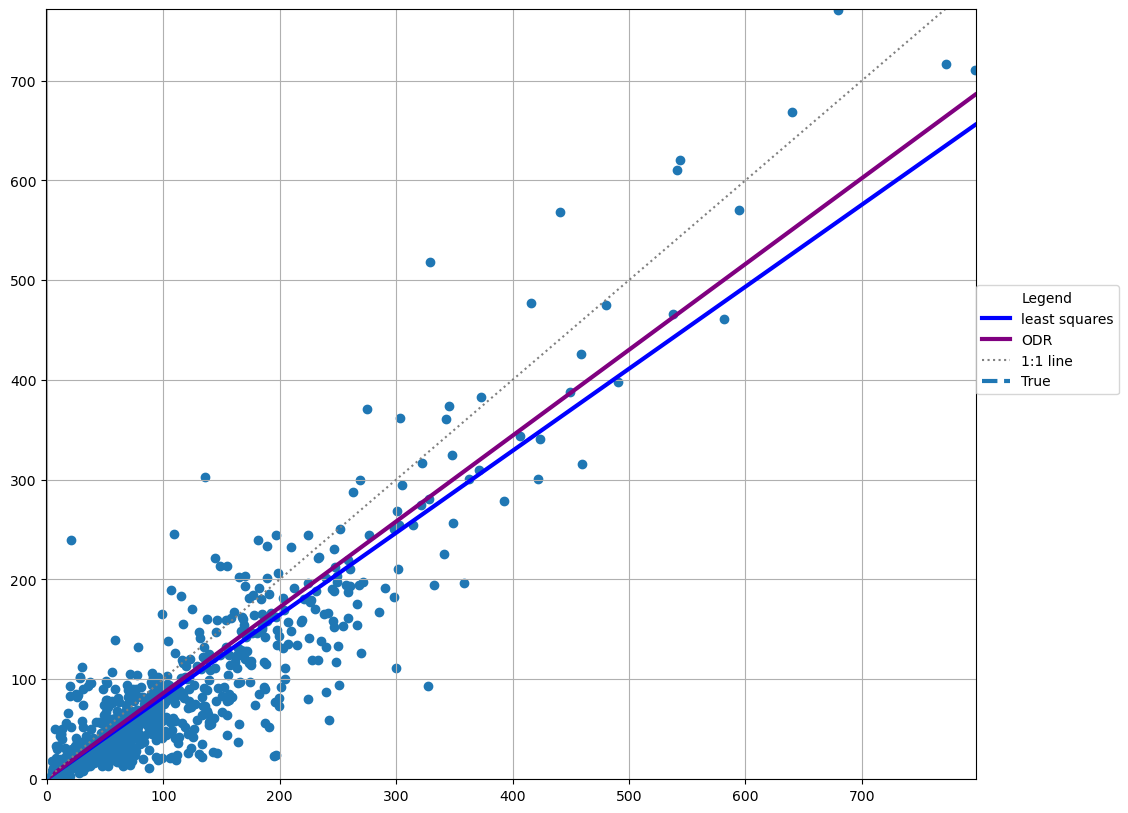

In [72]:
def odr_line(p, x):
    """The line of best fit."""
    # unpack the parameters:
    y = p*x
    return y

def perform_odr(x, y, xerr, yerr):
    """Finds the ODR for data {x, y} and returns the result"""
    linear = odr.Model(odr_line)
    mydata = odr.Data(x, y, wd=None, we=None)
    myodr = odr.ODR(mydata, linear, beta0=[0])
    output = myodr.run()
    return output

def line(x, a):
    """The line of best fit."""
    # unpack the parameters:
    y = a*x
    return y

yvar = 'ens_eet'
xvar = 'total_acft'
cvar = 'SubsurfaceSM'

df = outl_out.sort_values(xvar)#.dropna()
#df[xvar] = df[xvar]/df['acres']
#df[yvar] = df[yvar]/df['acres']
#df[cvar] = df[cvar]/df['acres']
#define predictor and response variables
y = df[yvar]
x = df[xvar]


popt, pcov = scipy.optimize.curve_fit(line, x, y)
regression = perform_odr(x, y, xerr, yerr)

# unpack the parameters of the line of best fit:
a = popt

#plt.errorbar(x, y, xerr, yerr, 'o', alpha=0.7)
plt.plot(x, line(x, a), label='least squares', lw=3, color='blue')
plt.plot(x, line(x, regression.beta[0]), label='ODR', lw=3, color='purple')

mx = int(round(df[xvar].max(),0))
plt.plot(range(0,mx),range(0,mx),color='grey',linestyle=":",label="1:1 line")


# plot the true line:
X = np.linspace(-10, 10, 10)
plt.plot(X, 2*X, label='True', lw=3, ls='--')
plt.scatter(x,y)
plt.legend(title='Legend', loc=(1, .5))
plt.xlim(np.min(x)-1, np.max(x)+1)
plt.ylim(np.min(y)-1, np.max(y)+1)
plt.grid()
print(
"""
The true model is           y = 1.00x
Least squares returns       y = {0:.2g}x
ODR returns                 y = {1:.2g}x
""".format(a[0], regression.beta[0]))

In [74]:
regression.delta
regression.eps

array([-1.45865772e-01,  2.79277470e-02, -1.40271379e-01, -2.89758458e+00,
       -2.08007091e+00, -6.69095718e-01, -1.74022232e+00, -1.10442911e+00,
        9.73040877e-01, -8.00241077e-01, -7.75677475e-01, -6.90258679e-01,
       -1.91446822e+00, -8.08722819e+00, -5.14890933e-01, -1.43426847e+00,
       -3.77314203e+00,  1.26606011e+00,  2.15608404e+00,  1.97744301e+00,
        6.14693183e-01,  1.07619391e+00, -3.87219920e-02,  6.05955686e-01,
        6.45578379e-01, -2.51666866e+01,  9.30848752e-01, -1.52064875e+01,
        1.43748646e+00,  9.52622027e-01, -7.21028066e+00, -8.09353494e+00,
        1.29674948e+00, -1.43114769e+01, -2.23151584e-03,  4.90196385e-01,
       -1.26925792e+01, -4.07993620e+00,  1.46397258e+00,  2.57231719e-01,
       -1.38144361e+01,  2.43158410e+00, -1.93033569e+01, -1.16312402e+00,
        1.96658658e+00,  2.30843156e+00, -5.75531732e+00, -1.99813558e+01,
        2.26734052e+00, -4.25692134e-01, -1.94228645e+01, -2.24330963e+01,
       -2.41856727e-01,  

In [75]:
regression.sum_square_delta

334734.3326470604

In [80]:
regression.delta.var()

385.03699819922014

In [83]:
print(regression.eps.var(),regression.eps.std()*3,regression.eps.)

520.3586777795223 68.43411503055842


In [ ]:
fitlinet.summary()

In [ ]:
plt.scatter(outl_out['lin_resid'],outl_out['ft_city_service'])

In [ ]:
outl_out.columns

In [ ]:
plt.scatter(fitlinet.resid,df['acres'])

In [ ]:
Heteroskedastic

In [ ]:
fig, ax = plt.subplots(1,1)
sm.graphics.mean_diff_plot(all_data_irr_yr_gis['total_acft'], all_data_irr_yr_gis['eem_eet'],ax=ax)

# Comparison of Datasets

This is a bunch of comparison stuff.  It compares the various remote sensing data.  You may not need to run it if you just pick one dataset.

In [ ]:

#g.map_lower(corrfunc)

In [ ]:
mo_sum = compiled.groupby(level=1).sum().replace(0,np.nan)

## PPT

In [27]:
pptlist = ['ens_pr','daymet_ppt','terra_ppt','gpm_ppt', 'prism_ppt','acres']

pptrename = {'ens_pr':'GridMET','daymet_ppt':'Daymet','terra_ppt':'Terra','gpm_ppt':'GPM','prism_ppt':'PRISM'}

cmp_prcp = compiled[pptlist].rename(columns=pptrename)

for col in pptrename.values():
    cmp_prcp[f"{col} (in)"] = 12*cmp_prcp[col]/cmp_prcp['acres']

cmp_prcp_in = cmp_prcp[['GridMET (in)','Daymet (in)', 'Terra (in)', 'GPM (in)', 'PRISM (in)']]
print(cmp_prcp.columns)


Index(['GridMET', 'Daymet', 'Terra', 'GPM', 'PRISM', 'acres', 'GridMET (in)',
       'Daymet (in)', 'Terra (in)', 'GPM (in)', 'PRISM (in)'],
      dtype='object')


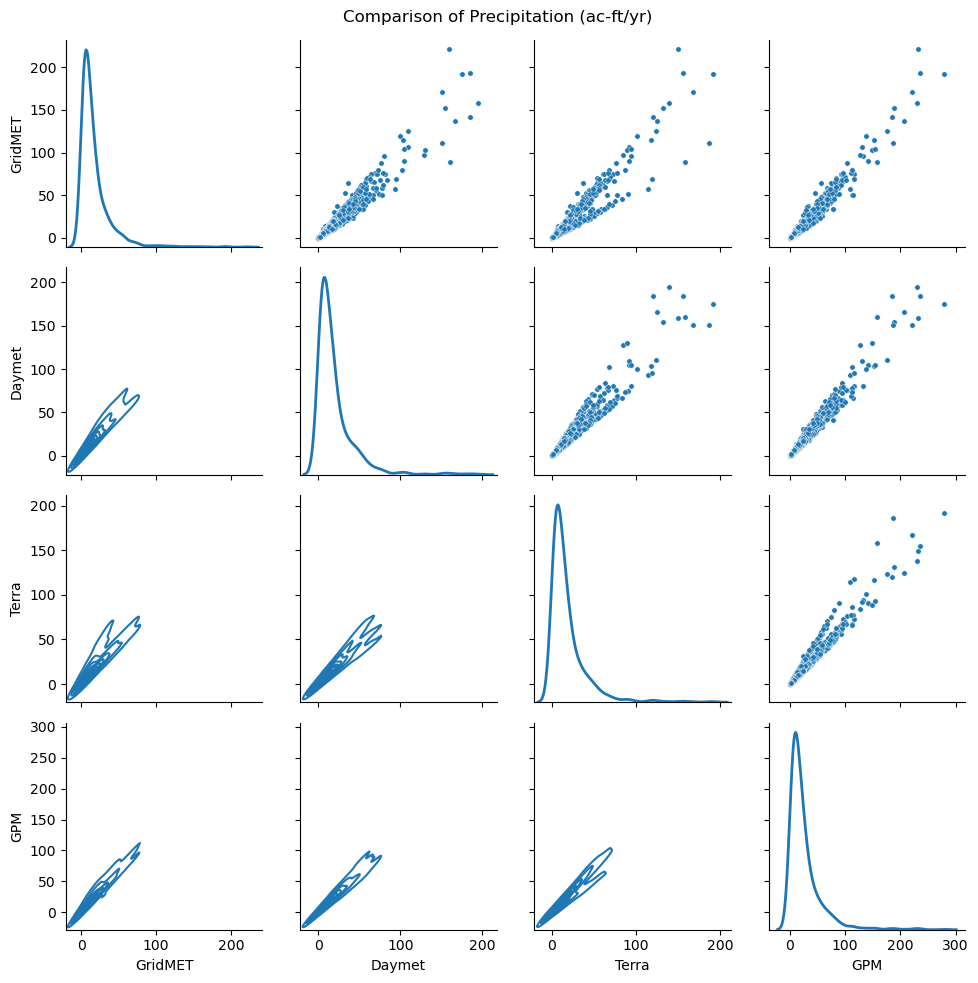

In [35]:
cmp_prcp = all_data_irr_years[['ens_pr','daymet_ppt','terra_ppt','gpm_ppt']].rename(columns={'ens_pr':'GridMET','daymet_ppt':'Daymet','terra_ppt':'Terra','gpm_ppt':'GPM'})

g = sns.PairGrid(cmp_prcp, diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)
g.fig.subplots_adjust(top=.95)
g.fig.suptitle("Comparison of Precipitation (ac-ft/yr)")
plt.savefig(figure_dir / "Precipitation_comparison.png")
plt.savefig(figure_dir / "Precipitation_comparison.pdf")

In [37]:
all_data_irr_years.columns

Index(['PML_Soil_Evap', 'PML_Veg_Trans', 'PML_Veg_Intercept', 'pml_aet',
       'terra_aet', 'terra_def', 'terra_ppt', 'terra_ro', 'terra_soil',
       'terra_swe', 'daymet_ppt', 'daymet_swe', 'openet_aet', 'gpm_ppt',
       'prism_ppt', 'SubsurfaceSM', 'SurfaceSM', 'sse_et', 'ens_etof',
       'ens_eto', 'ens_et', 'ens_pr', 'eem_et', 'acres', 'Peff'],
      dtype='object')

C:\Users\pauli\AppData\Local\Temp\ipykernel_3520\3856675690.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmp_prcp_in['month'] = cmp_prcp_in.index.get_level_values(1).month


<AxesSubplot: xlabel='month'>

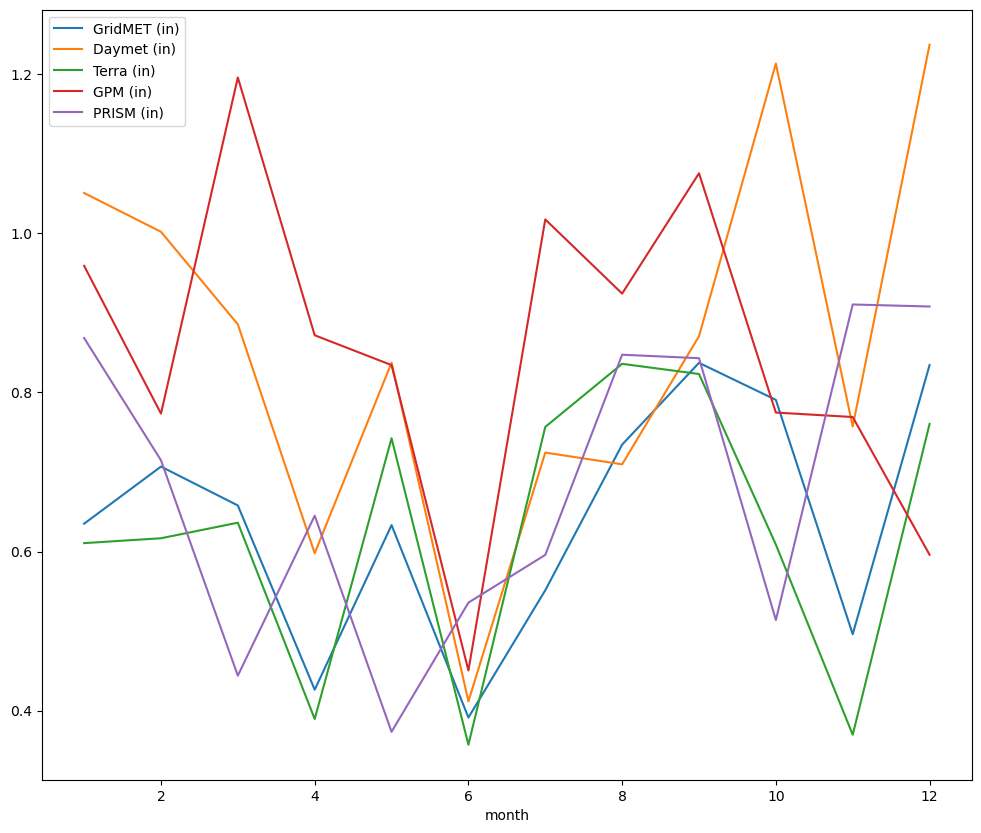

In [40]:
cmp_prcp_in['month'] = cmp_prcp_in.index.get_level_values(1).month
cmp_prcp_in.groupby('month').mean().plot()

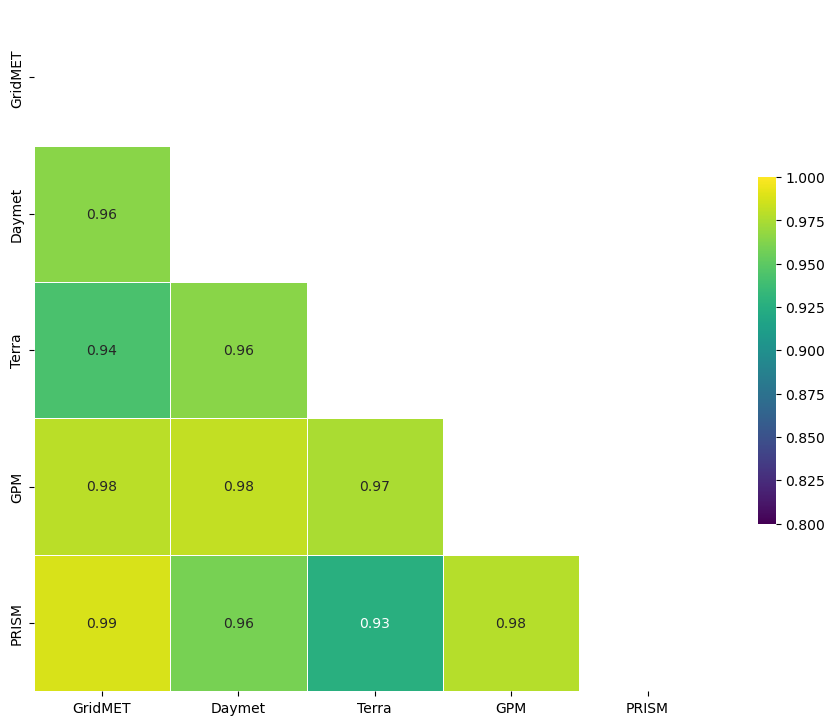

In [41]:
cmp_prcp = all_data_irr_years[['ens_pr','daymet_ppt',
                               'terra_ppt','gpm_ppt',
                               'prism_ppt']].rename(columns={'ens_pr':'GridMET',
                                                             'daymet_ppt':'Daymet',
                                                             'terra_ppt':'Terra',
                                                             'gpm_ppt':'GPM','prism_ppt':'PRISM'})


# Compute the correlation matrix
corr = cmp_prcp.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot=True,cmap="viridis",
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=0.8, vmax=1)

plt.savefig(figure_dir / "Precipitation_comparison_r2.png")
plt.savefig(figure_dir / "Precipitation_comparison_r2.pdf")

In [30]:
cmp_prcp

GridMET     Daymet      Terra        GPM      PRISM
sensor year                                                       
BC1    2016   5.736038   4.947853   5.899860   7.842605   5.865124
       2017   3.191401   4.451078   5.725308   5.552746   2.269177
       2018   4.761870   5.874375   4.259070   6.597266   4.954381
       2019   5.471115   4.929699   4.608174   7.050795   4.822734
       2020   1.608411   2.359246   2.373908   3.829752   1.856885
...                ...        ...        ...        ...        ...
UM8    2018  31.249341  38.279461  28.407876  40.883635  33.312313
       2019  31.154346  35.819714  30.543059  43.694182  31.362425
       2020  10.855473  16.606796  14.990439  23.733191  13.293556
       2021  34.197174  37.979259  30.397647  41.579259  33.889492
       2022  23.051006        NaN        NaN        NaN  19.402335

[1253 rows x 5 columns]

In [46]:
cmp_prcp_in_season = cmp_prcp_in[cmp_prcp_in.index.get_level_values(1).month.isin([3,4,5,6,7,8,9,10])]
cmp_prcp_in_season = cmp_prcp_in_season.groupby(['ID',pd.Grouper(level=1,freq='Y')]).sum()

C:\Users\pauli\anaconda3\envs\pygis311\Lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


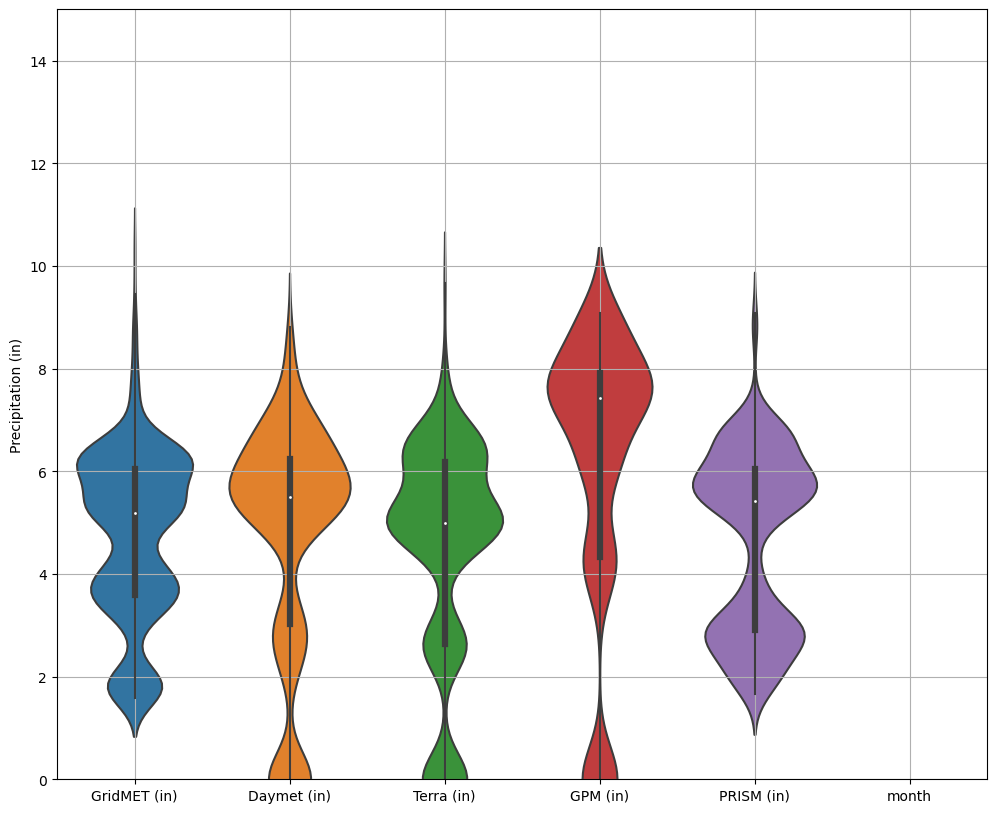

In [48]:
sns.violinplot(data=cmp_prcp_in_season)
plt.ylim(0,15)
plt.grid()

plt.ylabel('Precipitation (in)')
plt.savefig(figure_dir / "Precipitation_comparison_boxes_in.png")
plt.savefig(figure_dir / "Precipitation_comparison_boxes_in.pdf")

C:\Users\pauli\anaconda3\envs\pygis311\Lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


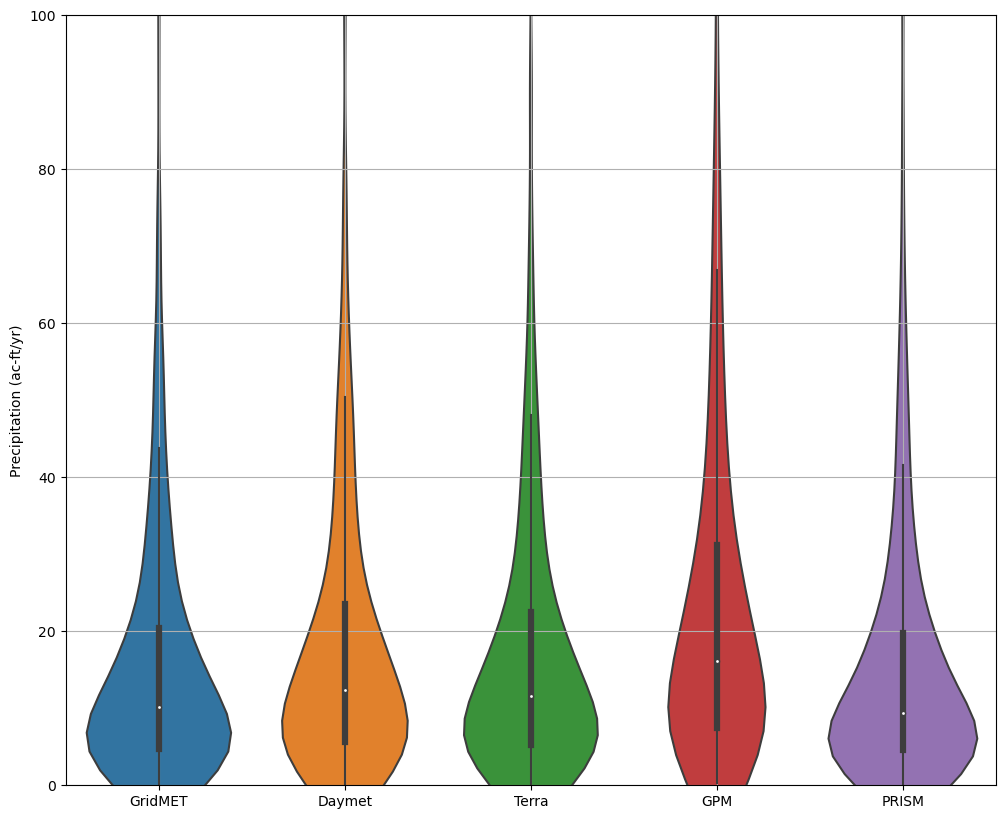

In [49]:
sns.violinplot(data=cmp_prcp)
plt.ylim(0,100)
plt.grid()

plt.ylabel('Precipitation (ac-ft/yr)')
plt.savefig(figure_dir / "Precipitation_comparison_boxes.png")
plt.savefig(figure_dir / "Precipitation_comparison_boxes.pdf")

C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311\Lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


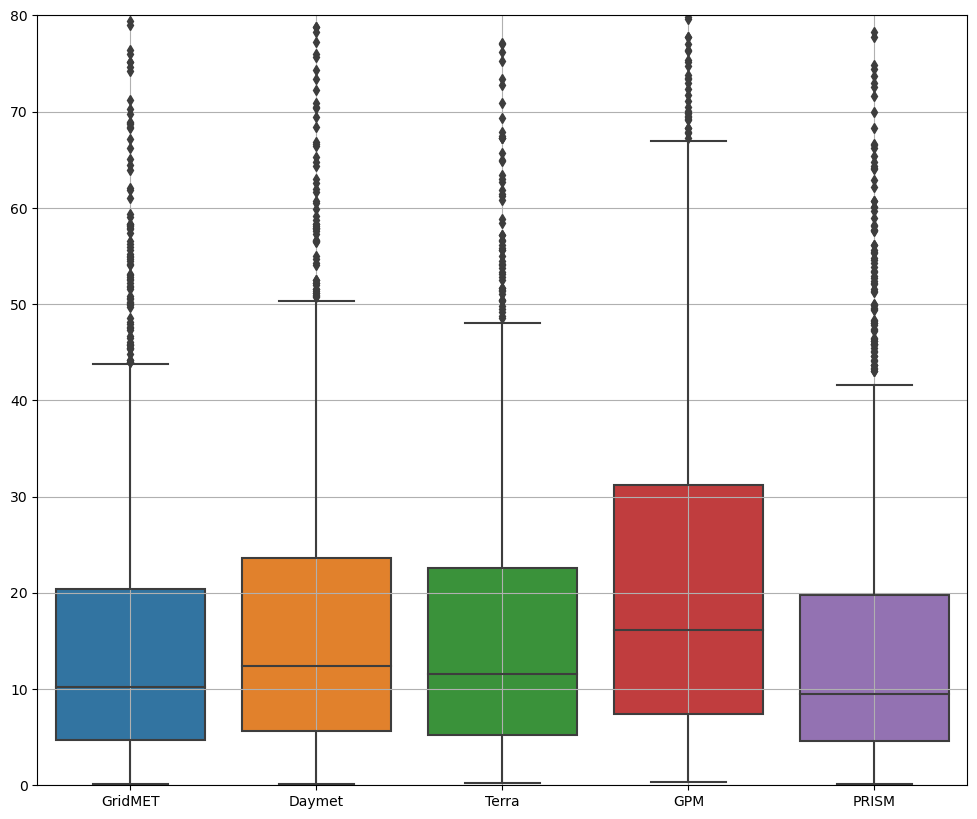

In [58]:
sns.boxplot(data=cmp_prcp)
plt.ylim(0,80)
plt.grid()
plt.ylabel('Precipitation (ac-ft/yr)')
plt.savefig(figure_dir / "Precipitation_comparison_boxes.png")
plt.savefig(figure_dir / "Precipitation_comparison_boxes.pdf")

In [51]:
cmp_prcp_in_season

GridMET (in)  Daymet (in)  Terra (in)  GPM (in)  PRISM (in)  \
ID  datetime                                                                  
2   2016-12-31      6.397638     5.789056    6.775565  8.849575    6.618191   
    2017-12-31      3.224410     5.214669    6.539208  6.265705    2.560533   
    2018-12-31      5.425197     7.021111    4.924103  7.444338    5.590511   
    2019-12-31      5.051181     5.888468    5.278638  7.956100    5.441961   
    2020-12-31      1.862205     2.956743    2.639319  4.321482    2.095304   
...                      ...          ...         ...       ...         ...   
243 2018-12-31      5.366142     7.101333    4.917003  7.433605    5.986510   
    2019-12-31      5.358268     6.095117    5.271028  7.944629    5.976362   
    2020-12-31      1.826772     3.032414    2.635514  4.315252    2.569901   
    2021-12-31      6.000000     6.338214    5.271028  7.560086    6.060431   
    2022-12-31      4.074803     0.000000    0.000000  0.000000    3.864643   

                month  
ID  datetime           
2   2016-12-31     52  
    2017-12-31     52  
    2018-12-31     52  
    2019-12-31     52  
    2020-12-31     52  
...               ...  
243 2018-12-31     52  
    2019-12-31     52  
    2020-12-31     52  
    2021-12-31     52  
    2022-12-31     52  

[1652 rows x 6 columns]

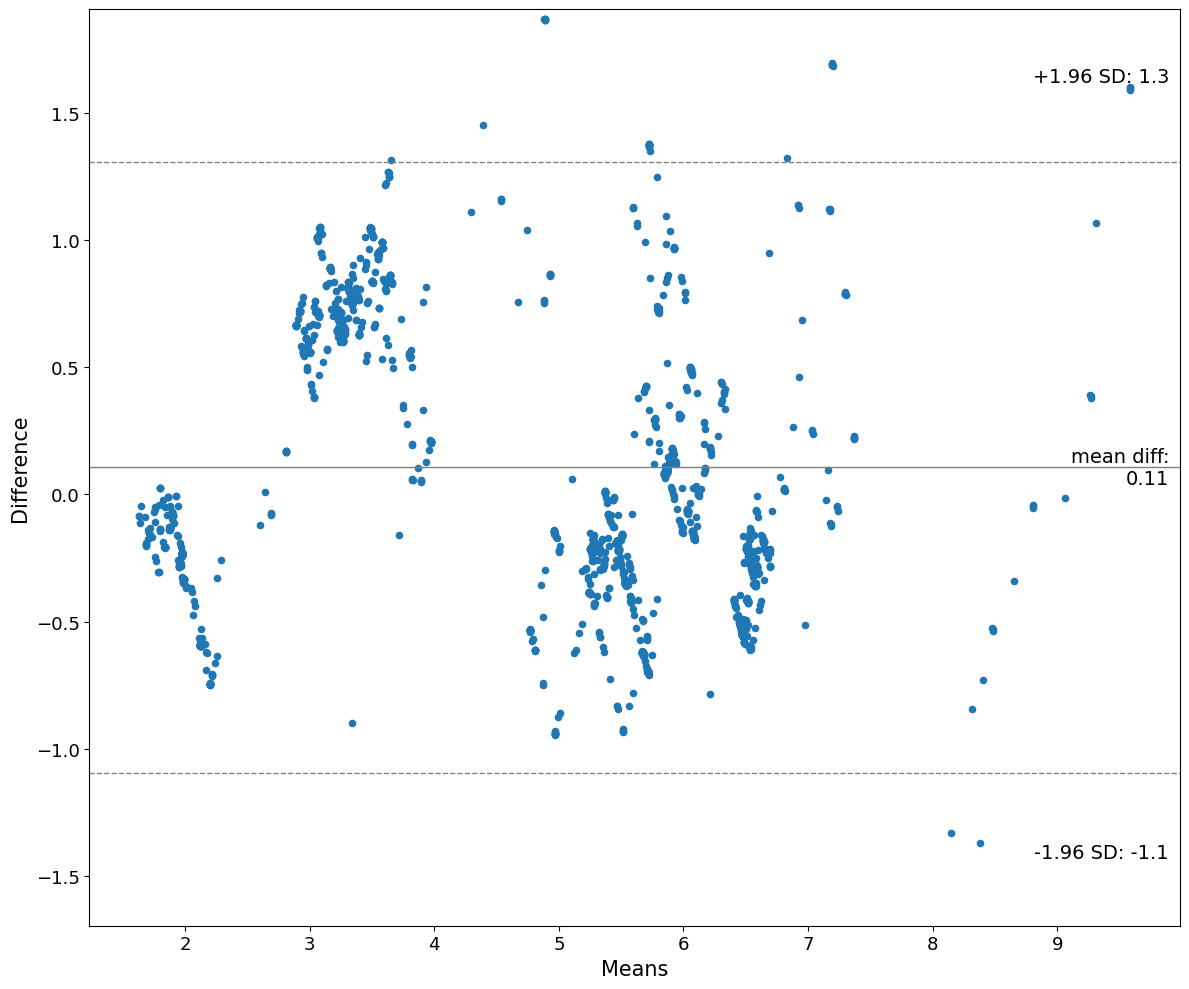

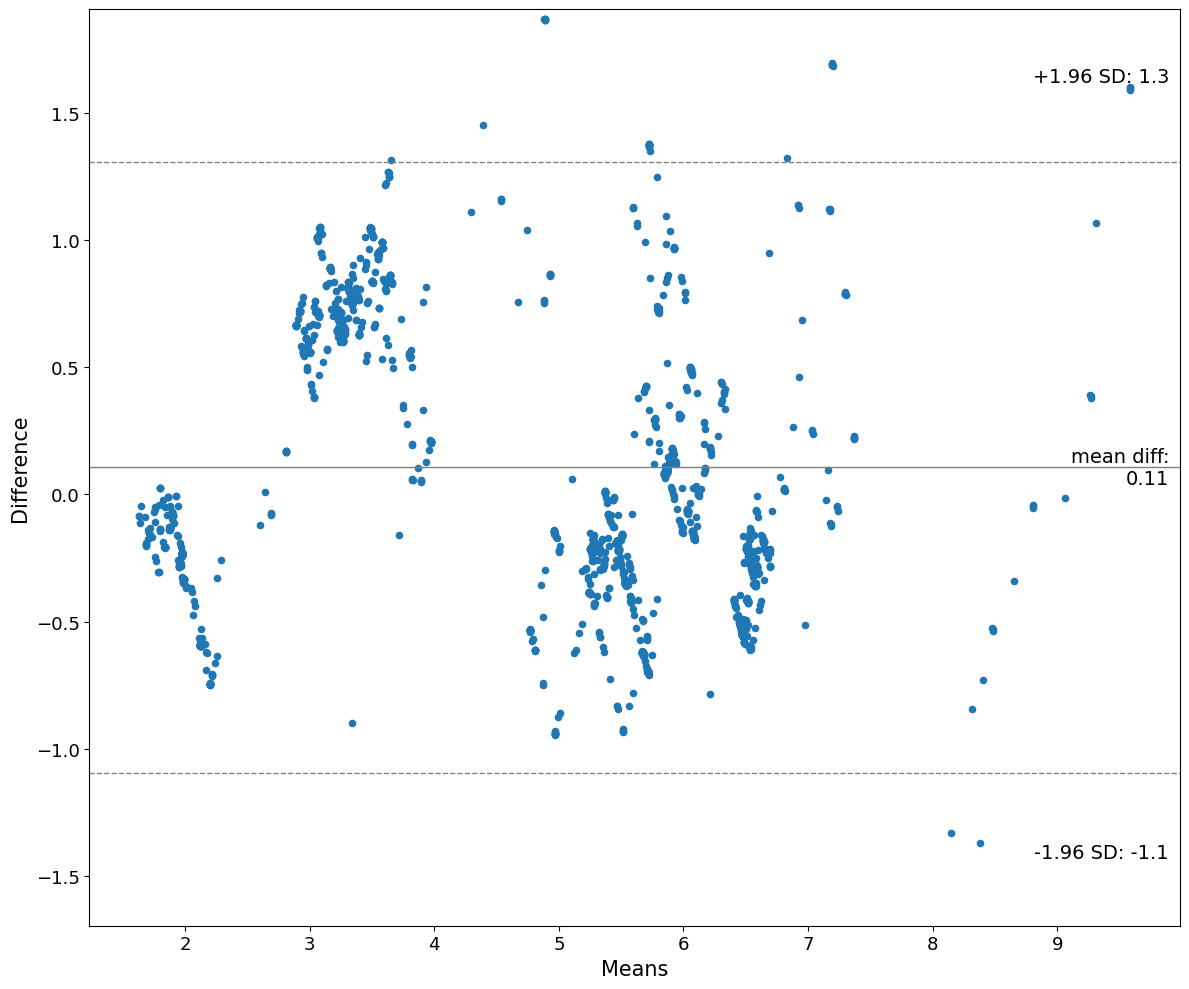

In [52]:
dataset_1 = 'GridMET (in)'
dataset_2 = 'PRISM (in)'

sm.graphics.mean_diff_plot(cmp_prcp_in_season[dataset_1], cmp_prcp_in_season[dataset_2])

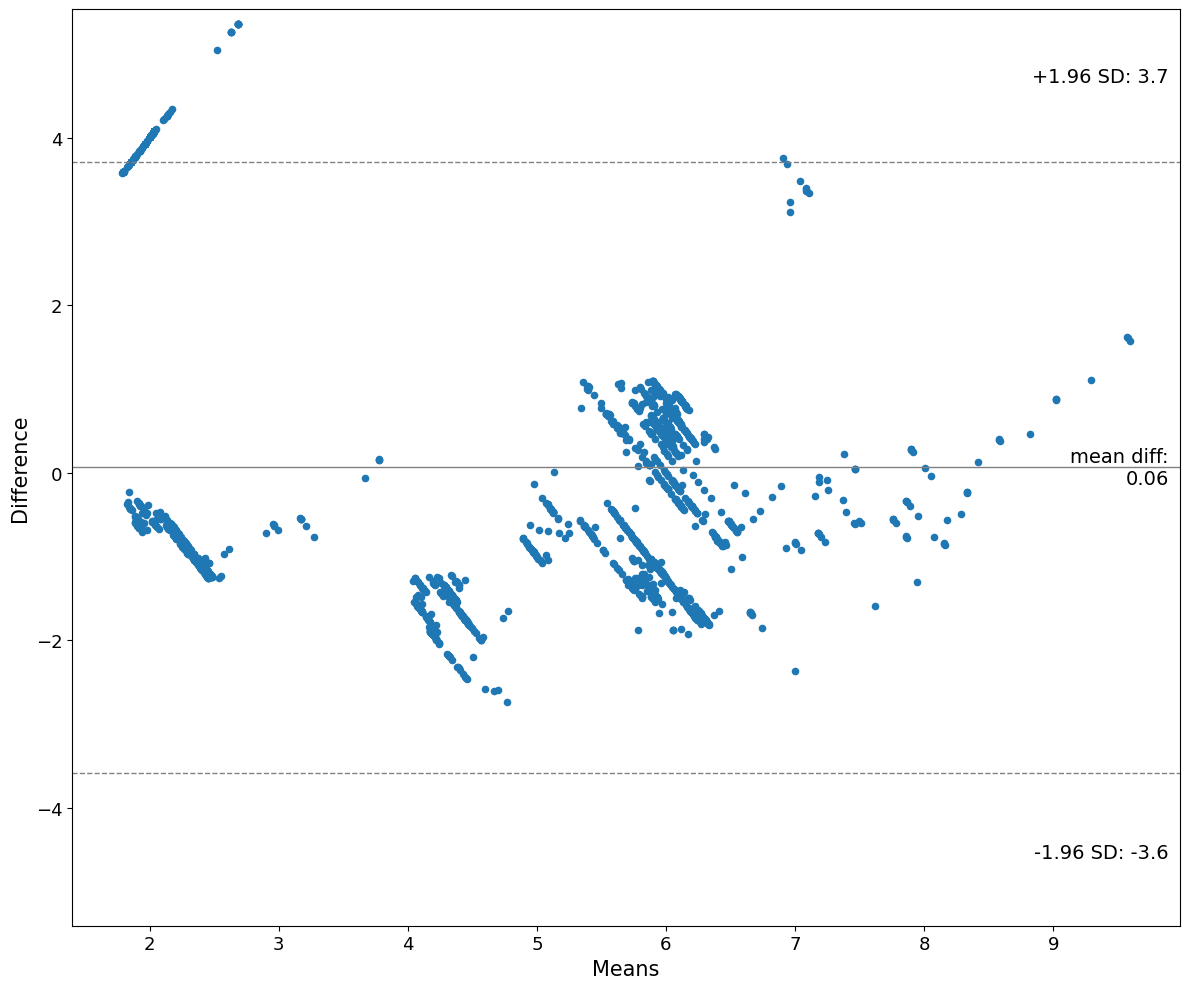

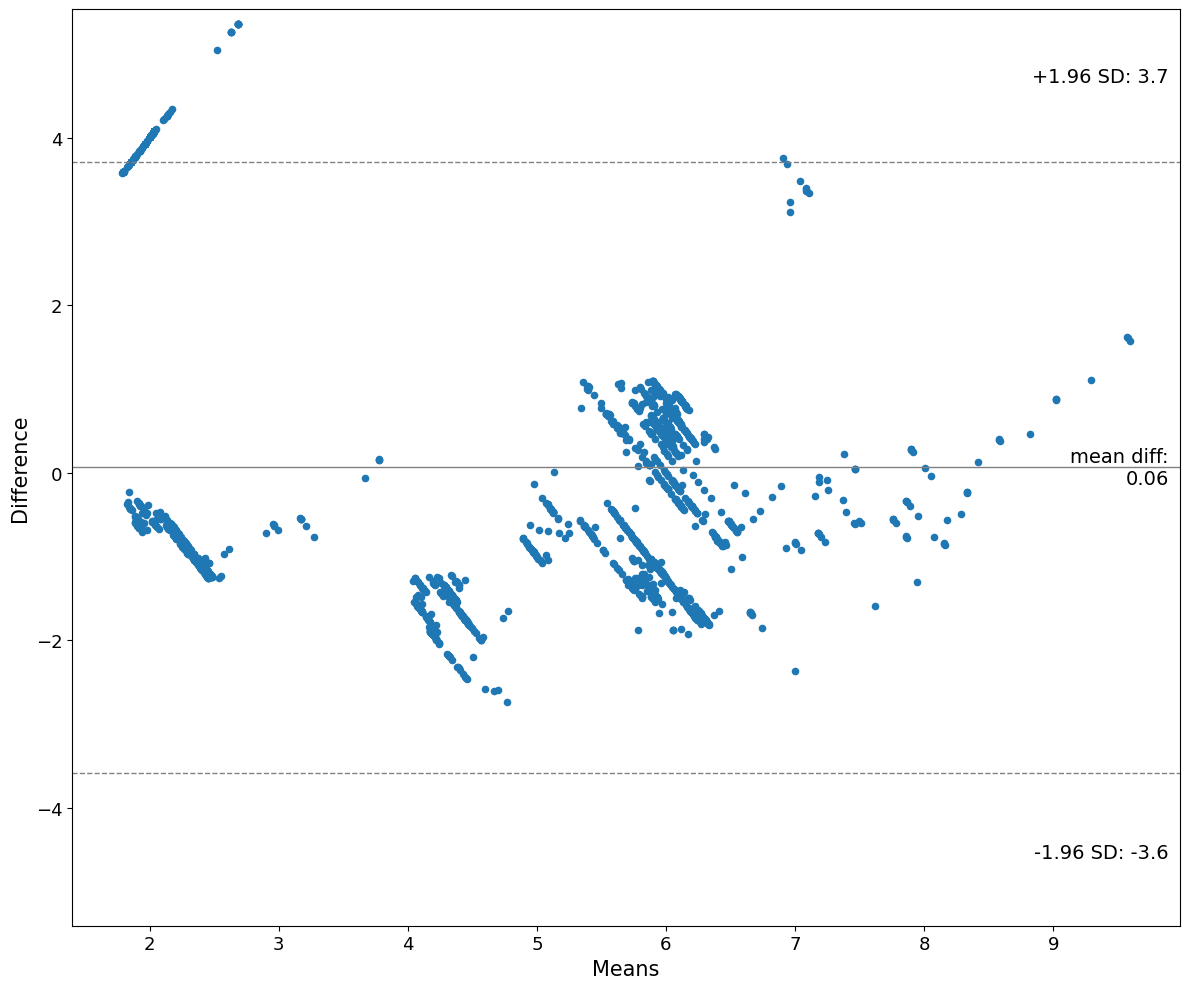

In [54]:
dataset_1 = 'GridMET (in)'
dataset_2 = 'Daymet (in)'

sm.graphics.mean_diff_plot(cmp_prcp_in_season[dataset_1], cmp_prcp_in_season[dataset_2])

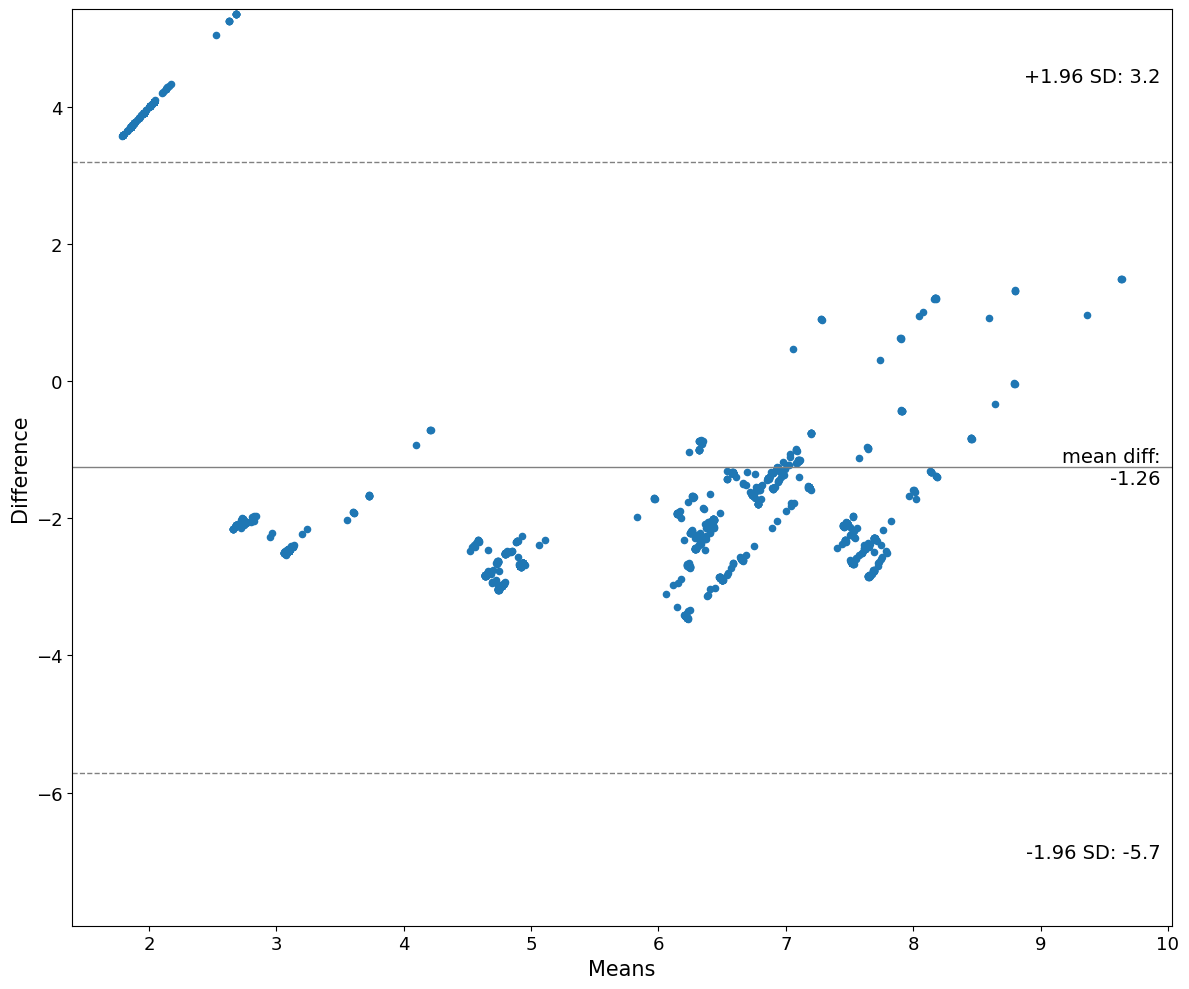

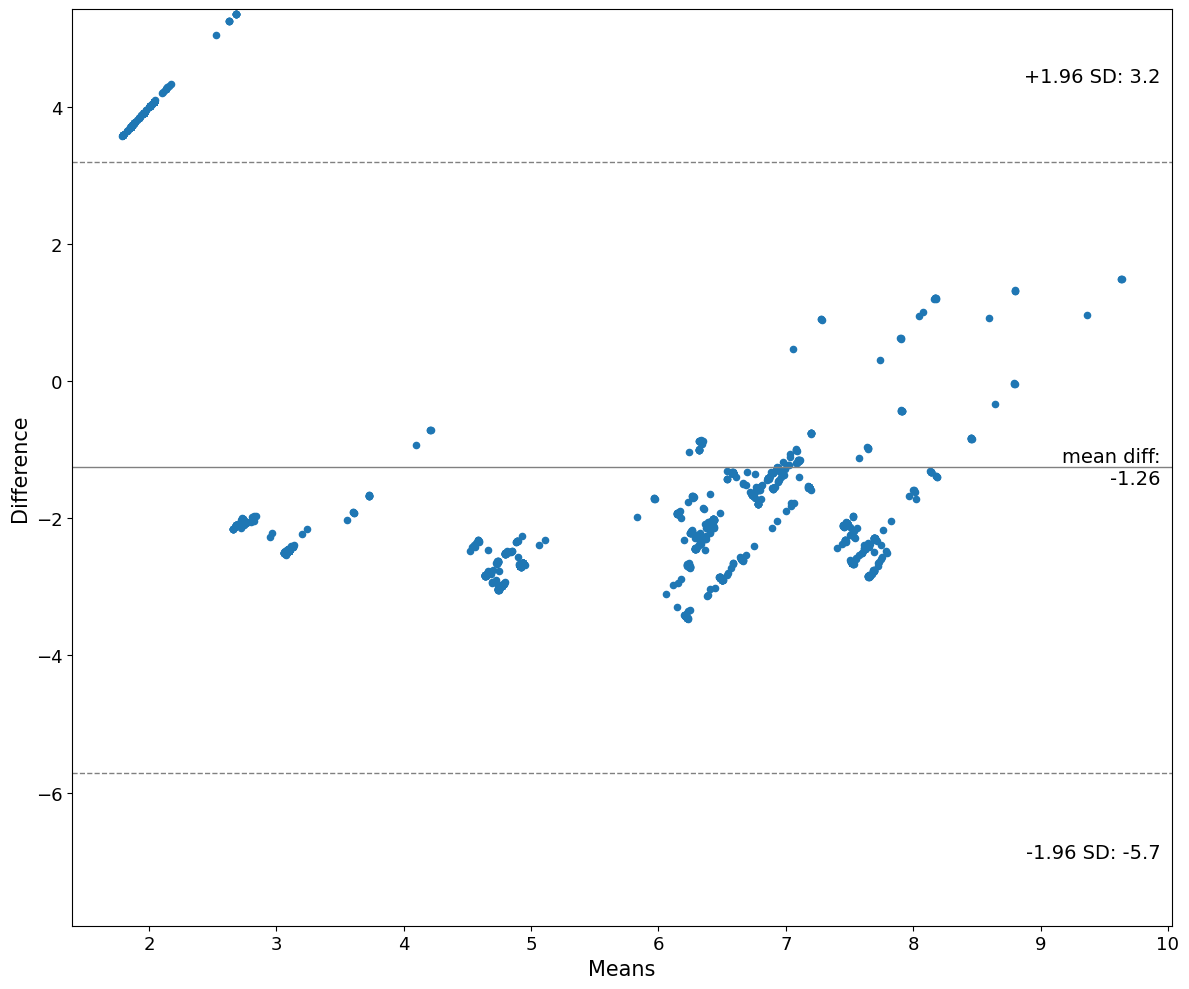

In [55]:

    
dataset_1 = 'GridMET (in)'
dataset_2 = 'GPM (in)'

sm.graphics.mean_diff_plot(cmp_prcp_in_season[dataset_1], cmp_prcp_in_season[dataset_2])

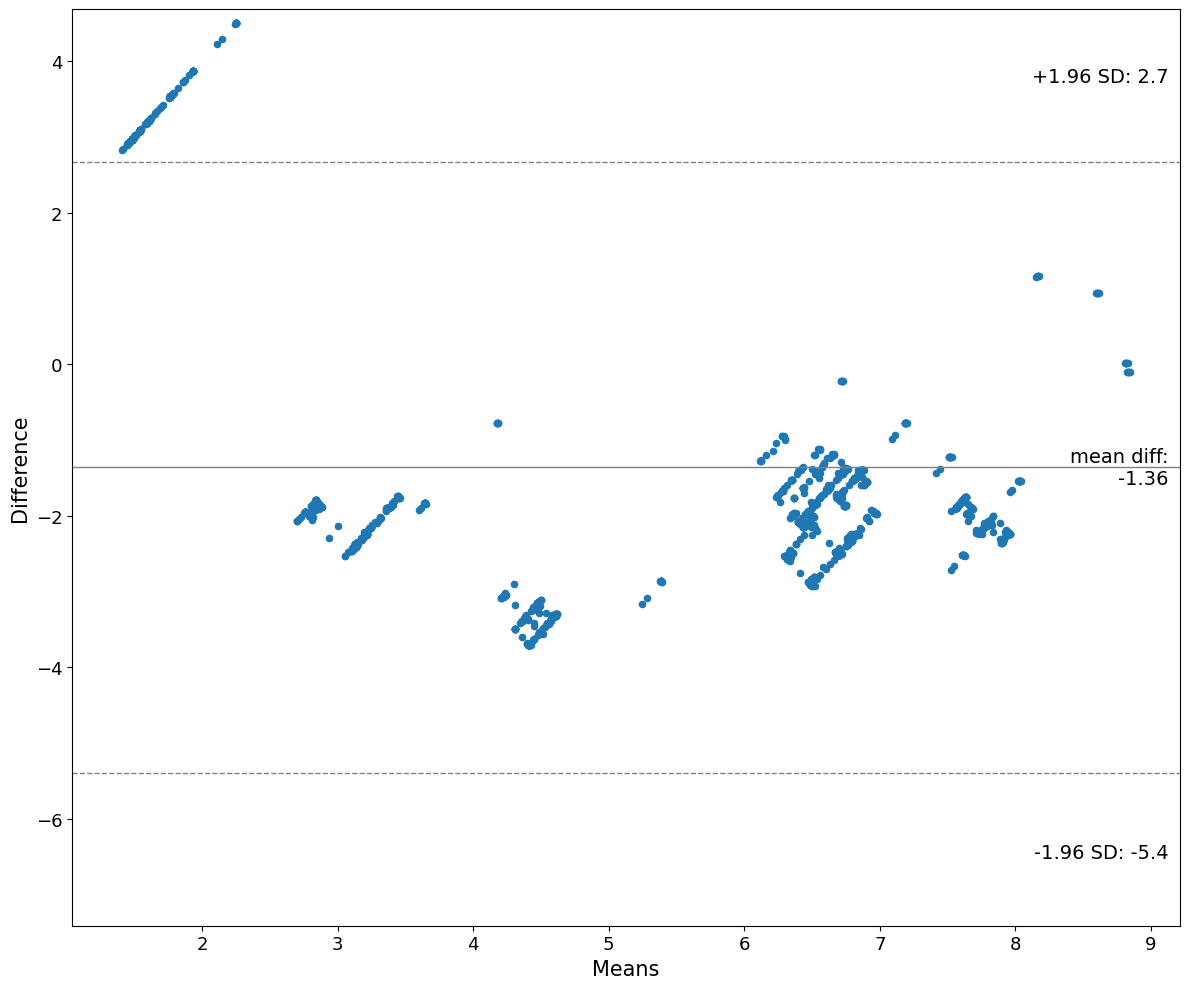

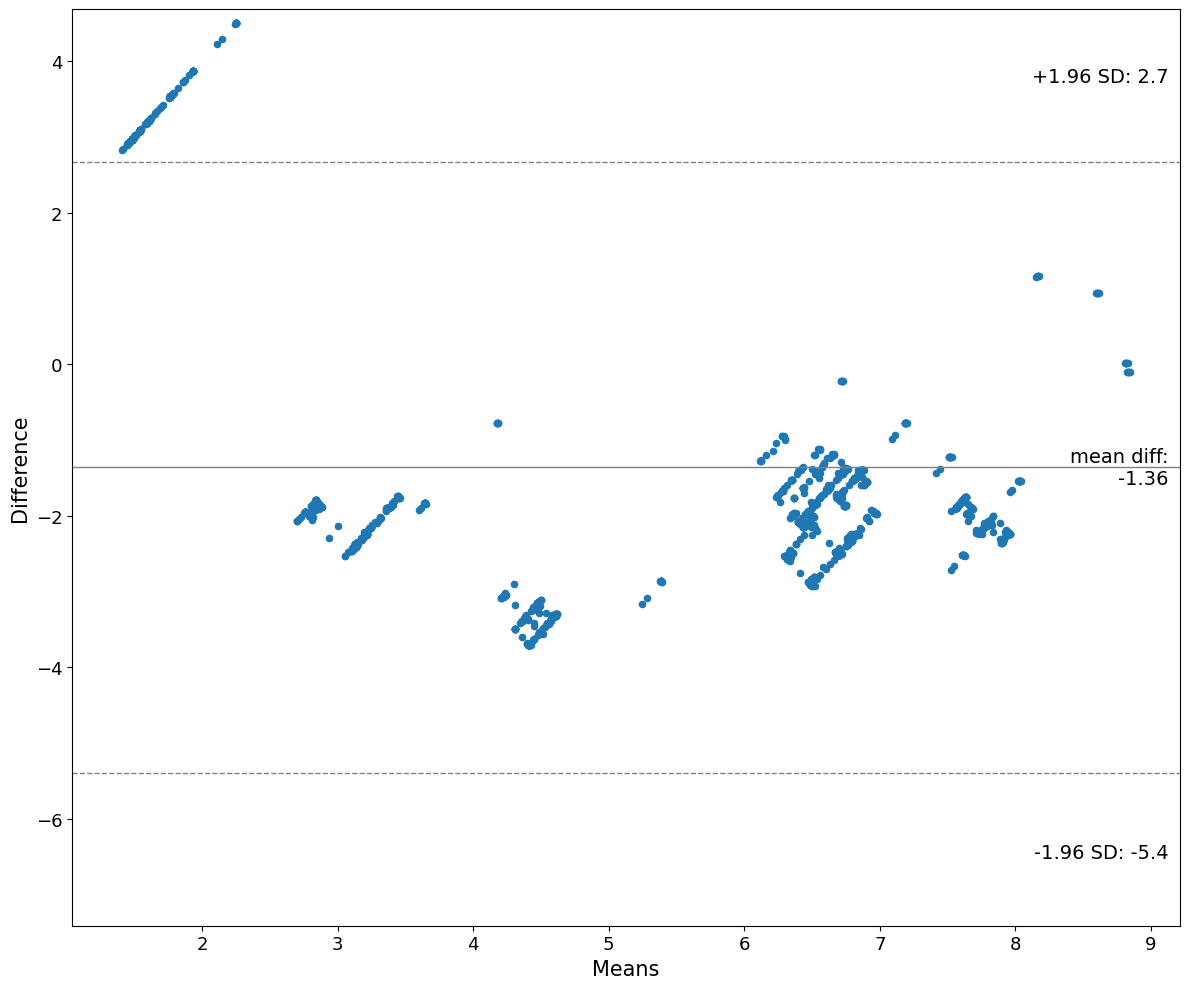

In [57]:
dataset_1 = 'PRISM (in)'
dataset_2 = 'GPM (in)'

sm.graphics.mean_diff_plot(cmp_prcp_in_season[dataset_1], cmp_prcp_in_season[dataset_2])

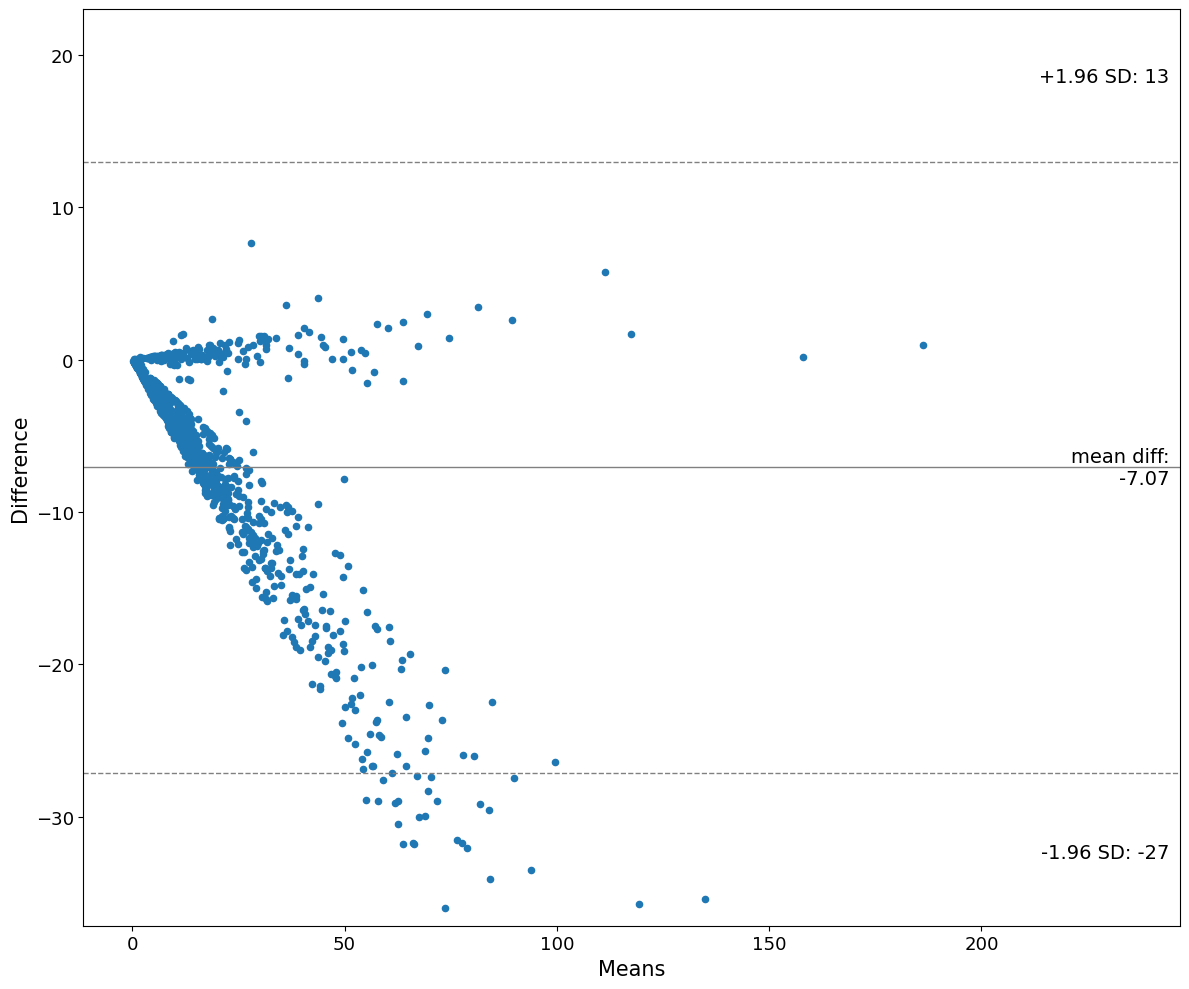

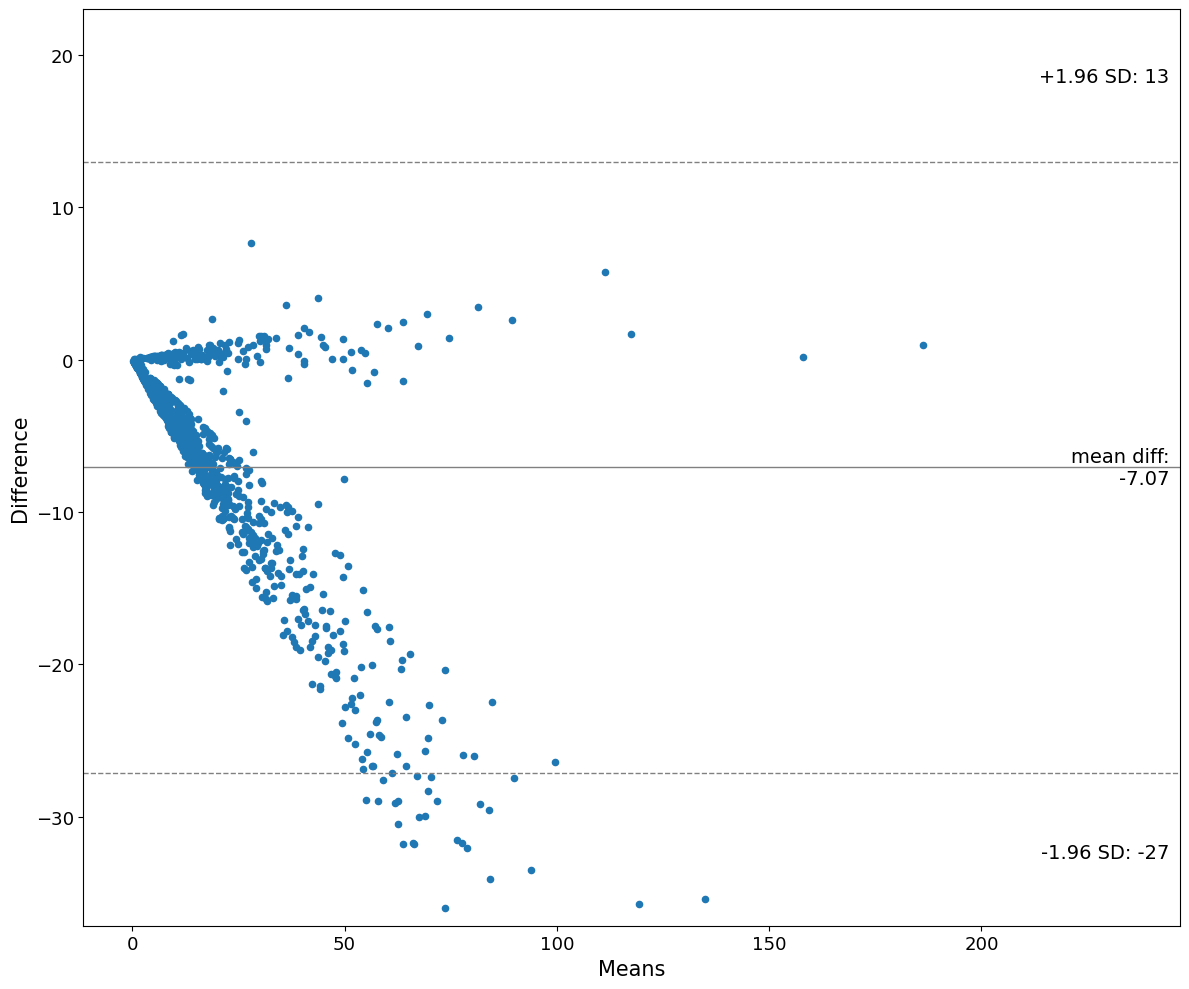

In [42]:
dataset_1 = 'Terra'
dataset_2 = 'GPM'

sm.graphics.mean_diff_plot(cmp_prcp[dataset_1], cmp_prcp[dataset_2])

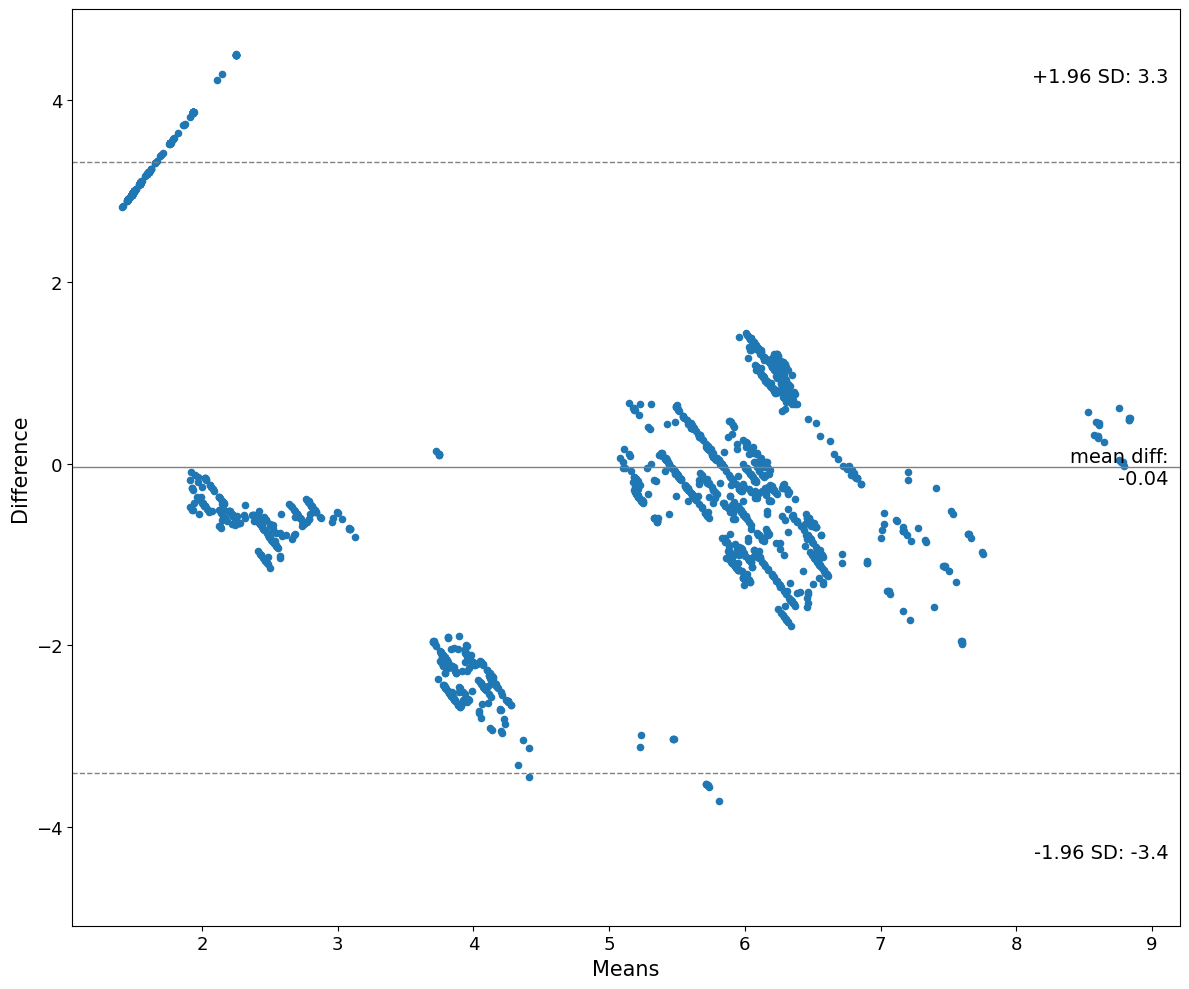

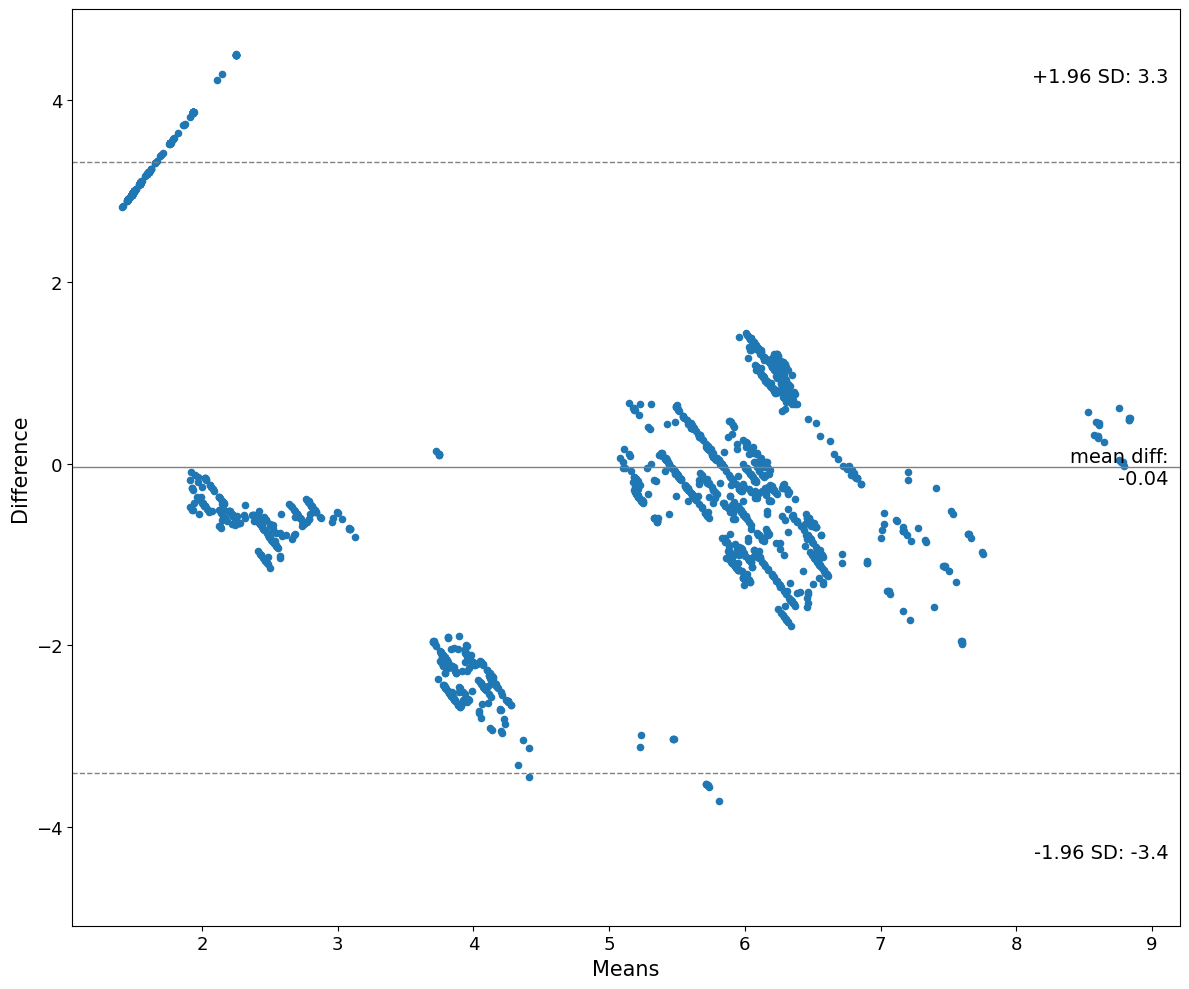

In [58]:
dataset_1 = 'PRISM (in)'
dataset_2 = 'Daymet (in)'

sm.graphics.mean_diff_plot(cmp_prcp_in_season[dataset_1], cmp_prcp_in_season[dataset_2])

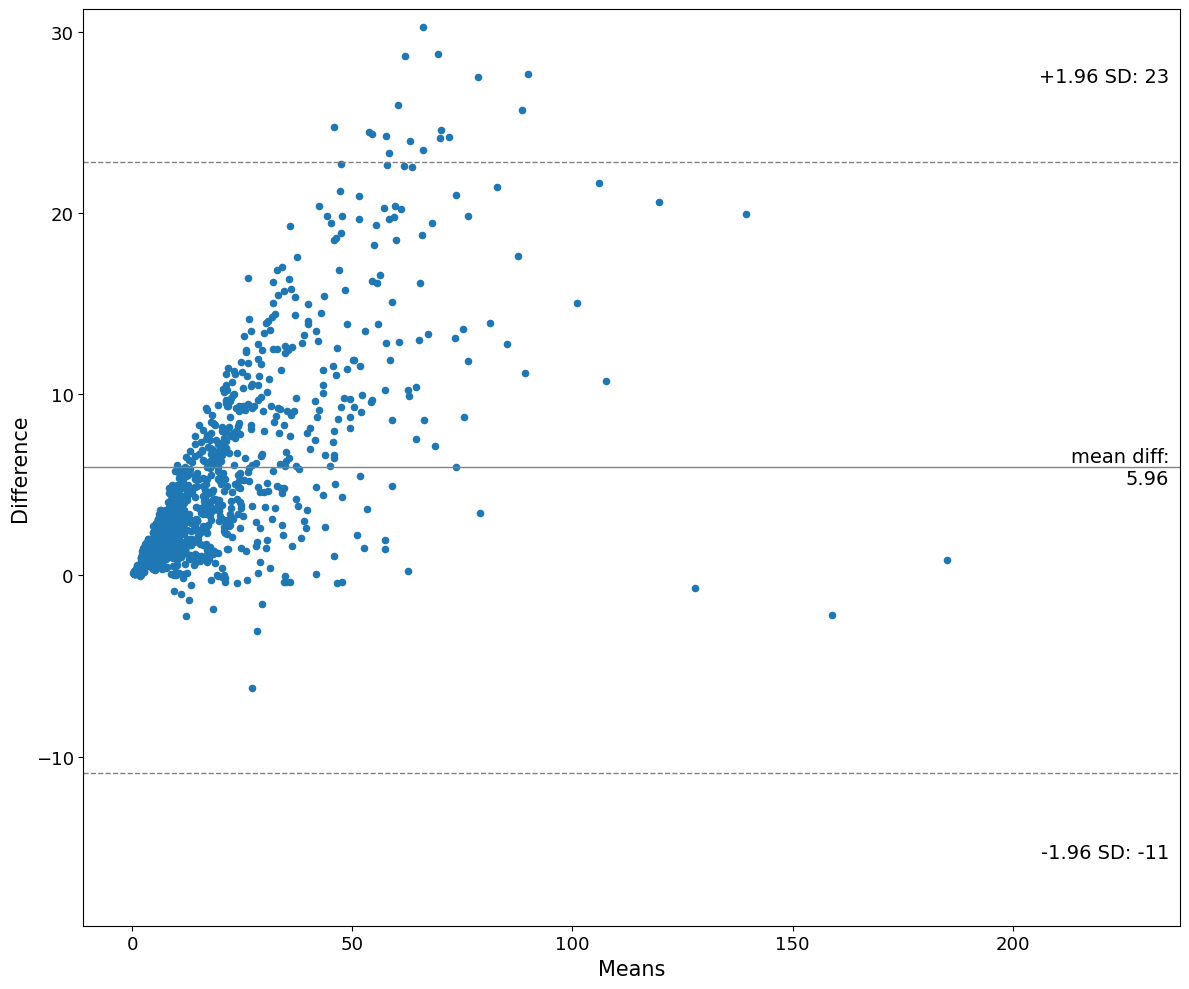

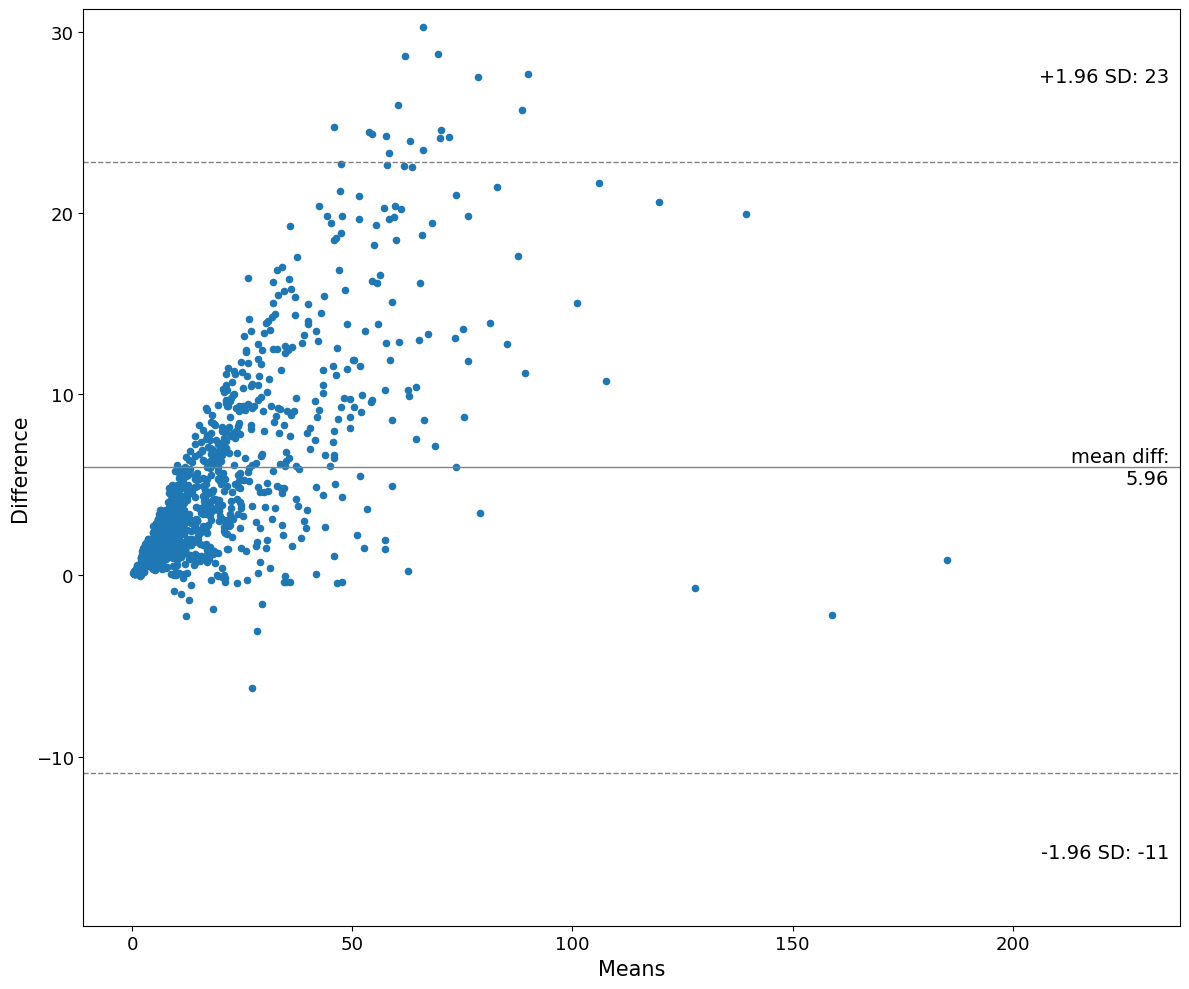

In [45]:
dataset_1 = 'GPM'
dataset_2 = 'Daymet'

sm.graphics.mean_diff_plot(cmp_prcp[dataset_1], cmp_prcp[dataset_2])

In [ ]:
dataset_1 = 'gpm'
dataset_2 = 'prism'
datatype = 'ppt'

diffs1, offset1, slope1 = plotcomparion(mo_sum, dataset_1, 
                                        dataset_2, datatype, slope_adj=1., offset_adj = 0, plot=True)
diffs2, offset2, slope2 = plotcomparion(mo_sum,
                                        dataset_1, 
                                dataset_2, 
                                datatype, 
                                slope_adj=slope1, 
                                offset_adj=offset1,
                                plot=False)

In [ ]:
mo

## AET

In [ ]:
cmp = all_data_irr_years[['terra_aet', 'openet_aet','sse_et',
                          'ens_et','eem_et','pml_aet']].rename(columns={'terra_aet':'Terra', 
                                                                        'openet_aet':'GEE OpenET',
                                                                        'sse_et':'SSEBop',
                                                                        'ens_et':'Ensemble',
                                                                        'eem_et':'eeMetric',
                                                                        'pml_aet':'PML'})

g = sns.PairGrid(cmp, diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

g.fig.subplots_adjust(top=.95)
g.fig.suptitle("Comparison of Evapotranspiration (ac-ft/yr)")
plt.savefig(figure_dir / "ET_comparison.png")
plt.savefig(figure_dir / "ET_comparison.pdf")


In [ ]:
all_data_irr_years.columns

In [ ]:
cmp = all_data_irr_years[['terra_aet', 'openet_aet','sse_et',
                          'ens_et','eem_et','pml_aet']].rename(columns={'terra_aet':'Terra', 
                                                                        'openet_aet':'GEE OpenET',
                                                                        'sse_et':'SSEBop',
                                                                        'ens_et':'Ensemble',
                                                                        'eem_et':'eeMetric',
                                                                        'pml_aet':'PML'})

# Compute the correlation matrix
corr = cmp.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot=True,cmap="viridis",
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=0.8, vmax=1)

In [ ]:
cmpaet = all_data_irr_years[['terra_aet', 'openet_aet','sse_et','ens_et','eem_et','pml_aet']]

In [ ]:


df = cmpaet.sort_values('pml_aet').dropna()
#define predictor and response variables
y = df['openet_aet']
x = df['ens_et']

#add constant to predictor variables
X = sm.add_constant(x)

#fit linear regression model
fitline = sm.RLM(y, X).fit()
#predictions = fitline.get_prediction()

plt.scatter(cmpaet['pml_aet'],cmpaet['openet_aet'])
plt.plot(df['pml_aet'],df['pml_aet']*fitline.params[1] + fitline.params[0], label='best fit line',color='red')

plt.grid()
plt.xlabel('PML ET(ac-ft)')
plt.ylabel('OpenET ET(ac-ft)')

In [ ]:
print(fitline.params[1], fitline.params[0])

In [ ]:
cmpaet

In [ ]:
plt.scatter(cmpaet['eem_et'],cmpaet['ens_et'])

df = cmpaet.sort_values('eem_et').dropna()
#define predictor and response variables
y = df['ens_et']
x = df['eem_et']

#add constant to predictor variables
X = sm.add_constant(x)

#fit linear regression model
fitlinet = sm.OLS(y, X).fit()
predictionst = fitlinet.get_prediction()

plt.plot(df['eem_et'],df['eem_et']*fitlinet.params[1] + fitlinet.params[0], label='best fit line',color='red')
plt.plot(range(0,1000),range(0,1000),color='grey',linestyle=":",label="1:1 line")

print(fitlinet.params[1], fitlinet.params[0])
print(fitlinet.params[1], fitlinet.params[0])
print(fitlinet.rsquared)
print(np.quantile(fitlinet.resid,0.975))
print(np.quantile(fitlinet.resid,0.0275))


plt.grid()
plt.legend()
plt.xlabel('eeMetric ET(ac-ft/yr)')
plt.ylabel('OpenET ET(ac-ft/yr)')

In [ ]:
plt.scatter(cmpaet['sse_et'],cmpaet['ens_et'])

df = cmpaet.sort_values('sse_et').dropna()
#define predictor and response variables
y = df['ens_et']
x = df['sse_et']

#add constant to predictor variables
X = sm.add_constant(x)

#fit linear regression model
fitlinet = sm.OLS(y, X).fit()
predictionst = fitlinet.get_prediction()

plt.plot(df['sse_et'],df['sse_et']*fitlinet.params[1] + fitlinet.params[0], label='best fit line',color='red')
plt.plot(range(0,1000),range(0,1000),color='black')

print(fitlinet.params[1], fitlinet.params[0])
print(fitlinet.params[1], fitlinet.params[0])
print(fitlinet.rsquared)

plt.grid()
plt.xlabel('SSEBop ET(ac-ft)')
plt.ylabel('OpenET ET(ac-ft)')

In [ ]:
#cmp = all_data_irr_years[['terra_aet', 'openet_aet','sse_et','ens_et','eem_et','pml_aet']]

dataset_1 = 'terra'
dataset_2 = 'openet'
datatype = 'aet'

diffs1, offset1, slope1 = plotcomparion(mo_sum, dataset_1, 
                                        dataset_2, datatype, slope_adj=1., offset_adj = 0, plot=True)
diffs2, offset2, slope2 = plotcomparion(mo_sum,
                                        dataset_1, 
                                dataset_2, 
                                datatype, 
                                slope_adj=slope1, 
                                offset_adj=offset1,
                                plot=False)
#offset3, slope3 = plotcomparion(dataset_1, dataset_2, datatype, slope1, offset2)

In [ ]:
mo_sum

In [ ]:
cmpaet = all_data_irr_years[['terra_aet', 'openet_aet','sse_et','ens_et','eem_et','pml_aet']]

### TERRA vs PML - AET

In [ ]:
#comp_aet_mo['terrashift_aet'] = comp_aet_mo['terra_aet'].shift(3)
mo_sum_aet = mo_sum.rename(columns={'ens_et':'ens_aet', 'sse_et':'sse_aet','eem_et':'eem_aet'})
mo_sum_aet = mo_sum_aet[mo_sum_aet['openet_aet']>0]

dataset_1 = 'openet'
dataset_2 = 'ens'
datatype = 'aet'

diffs1, offset1, slope1 = plotcomparion(mo_sum_aet, dataset_1, dataset_2, datatype, slope_adj=1., offset_adj = 0, plot=True)
diffs2, offset2, slope2 = plotcomparion(mo_sum_aet, dataset_1, 
                                dataset_2, 
                                datatype, 
                                slope_adj=slope1, 
                                offset_adj=offset1,
                                plot=False)

In [ ]:
#comp_aet_mo['terrashift_aet'] = comp_aet_mo['terra_aet'].shift(3)
mo_sum_aet = mo_sum.rename(columns={'ens_et':'ens_aet', 'sse_et':'sse_aet','eem_et':'eem_aet'})
mo_sum_aet = mo_sum_aet[mo_sum_aet['openet_aet']>0]

dataset_1 = 'sse'
dataset_2 = 'ens'
datatype = 'aet'

diffs1, offset1, slope1 = plotcomparion(mo_sum_aet, dataset_1, dataset_2, datatype, slope_adj=1., offset_adj = 0, plot=True)
diffs2, offset2, slope2 = plotcomparion(mo_sum_aet, dataset_1, 
                                dataset_2, 
                                datatype, 
                                slope_adj=slope1, 
                                offset_adj=offset1,
                                plot=False)

In [ ]:
#comp_aet_mo['terrashift_aet'] = comp_aet_mo['terra_aet'].shift(3)
mo_sum_aet = mo_sum.rename(columns={'ens_et':'ens_aet', 'sse_et':'sse_aet','eem_et':'eem_aet'})
mo_sum_aet = mo_sum_aet[mo_sum_aet['openet_aet']>0]

dataset_1 = 'eem'
dataset_2 = 'ens'
datatype = 'aet'

diffs1, offset1, slope1 = plotcomparion(mo_sum_aet, dataset_1, dataset_2, datatype, slope_adj=1., offset_adj = 0, plot=True)
diffs2, offset2, slope2 = plotcomparion(mo_sum_aet, dataset_1, 
                                dataset_2, 
                                datatype, 
                                slope_adj=slope1, 
                                offset_adj=offset1,
                                plot=False)

### MODIS vs PML - AET

In [ ]:
[['terra_aet', 'openet_aet','sse_et','ens_et','eem_et','pml_aet']]

In [ ]:
dataset_1 = 'terra'
dataset_2 = 'ens'
datatype = 'aet'

diffs1, offset1, slope1 = plotcomparion(mo_sum_aet, dataset_1, dataset_2, datatype, slope_adj=1., offset_adj = 0, plot=True)
diffs2, offset2, slope2 = plotcomparion(mo_sum_aet, dataset_1, 
                                dataset_2, 
                                datatype, 
                                slope_adj=slope1, 
                                offset_adj=offset1,
                                plot=False)